<a href="https://colab.research.google.com/github/hmehryar/Hm.JetscapeMl/blob/ml5/jet_ml_synthesis_model/jet_ml_synthesis_pointnet_model_kfolded_all_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)# Synthesis mode classification for Heavy Ion Collisions for diffrent dataset size and K-Folding

**Authors:** [Haydar Mehryar](https://github.com/hmehryar) <br>
**Date created:** 2023/12/01<br>
**Last modified:** 2020/12/20<br>
**Description:** Implementation of Pointnet Deep Network for heavy ion colllisions classifiction

In [10]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
print (tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU'))>0)
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

2.15.0
True


In [11]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# loading libraries
print('Loading/Installing Package => Begin\n\n')
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import parse_parameters
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import install

import os
from time import time
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,History,TensorBoard
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json
%matplotlib inline

tf.random.set_seed(1234)
print('\nLoading/Installing Package => End\n\n')


Loading/Installing Package => Begin



Loading/Installing Package => End




In [13]:
print('\n########################################################################')
print('Checking the running platforms\n')

# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')


########################################################################
Checking the running platforms

Python version: 3.10.12
OS: Linux
OS version: 6.1.58+
running on Colab: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Directory Path: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/
Simulation Results Path: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
Dataset Directory Path: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/
Simulation Directory Path: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
########################################################################



In [14]:
tokenized_arguments, tokenized_values = parse_parameters()
# Call the function and retrieve the tokenized parameters
# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

option -f not recognized
Tokenized Arguments:

Tokenized Values:
y_class_label_items: ['MMAT', 'MLBT']
alpha_s_items: [0.2, 0.3, 0.4]
q0_items: [1.5, 2.0, 2.5]


In [15]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
# total_size=9*1200000

Building required params for the loading the dataset file


In [16]:
# loading dataset by size and getting just the first column
# Function to load datasets of different sizes
def get_dataset(size):
    dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{size}_shuffled.pkl"

    dataset_file_name=dataset_directory_path+dataset_file_name
    print("dataset_file_name:",dataset_file_name)

    dataset=load_dataset(dataset_file_name,has_test=False)
    (dataset_x, dataset_y) = dataset
    print('Extract the first column for binary classification')
    # dataset_y = dataset_y[:, 0]
    print("dataset.x:",type(dataset_x), dataset_x.size, dataset_x.shape)
    print("dataset.y:",type(dataset_y), dataset_y.size,dataset_y.shape)
    return dataset_x, dataset_y

Building and Compiling the Classifier model

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, History

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': self.num_features, 'l2reg': self.l2reg}

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES, model_name="pointnet"):
    inputs = keras.Input(shape=(NUM_POINTS, 3))
    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    if NUM_CLASSES <=2:
        outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    else:
        outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)


    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [18]:
# NUM_POINTS = 2048
NUM_POINTS = 1024
# NUM_CLASSES = 10

eloss_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=2,model_name="ElossPointNet")
alpha_s_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=3,model_name="AlphaSPointNet")
q_0_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=4,model_name="Q0PointNet")
learning_rate=0.001

In [19]:
def compile_pointnet_classifier_model_with_hyperparam(model,learning_rate,num_classes):
  if num_classes==None:
    raise Exception("Number of classses are not defined!")
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss="binary_crossentropy"
  metrics=["accuracy"]

  if num_classes>2:
    loss="sparse_categorical_crossentropy"
    metrics=["sparse_categorical_accuracy"]
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=metrics,
  )
  model.summary()
  return model

In [20]:
eloss_pointnet=compile_pointnet_classifier_model_with_hyperparam(eloss_pointnet,learning_rate,num_classes=2)
alpha_s_pointnet=compile_pointnet_classifier_model_with_hyperparam(alpha_s_pointnet,learning_rate,num_classes=3)
q_0_pointnet=compile_pointnet_classifier_model_with_hyperparam(q_0_pointnet,learning_rate,num_classes=4)


Model: "ElossPointNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 32)             0         ['batch_normalizat

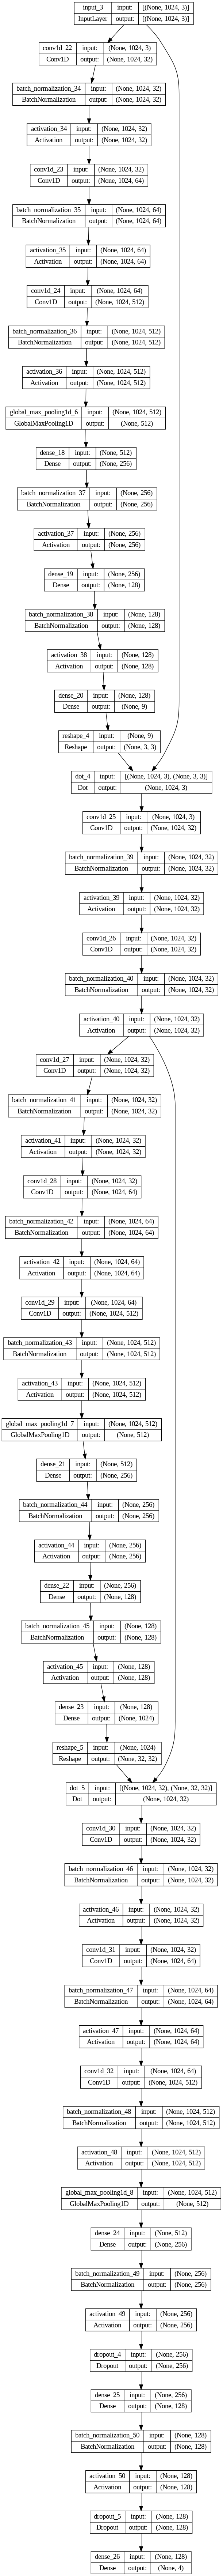

In [21]:
tf.keras.utils.plot_model(eloss_pointnet, show_shapes=True)
tf.keras.utils.plot_model(alpha_s_pointnet, show_shapes=True)
tf.keras.utils.plot_model(q_0_pointnet, show_shapes=True)

In [22]:
def split_dataset(dataset_x, dataset_x_points, dataset_y, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - dataset_x: The input data (3D array).
    - dataset_x_points: The 3D coordinates corresponding to each entry.
    - dataset_y: The target values (2D array).
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.

    Returns:
    - x_train, x_test: The split input data for training and testing.
    - x_train_points, x_test_points: The split 3D coordinates for training and testing.
    - y_train, y_test: The split target values for training and testing.
    """
    # Flatten the input data to 2D
    flattened_dataset_x = dataset_x.reshape(dataset_x.shape[0], -1)

    # Split the dataset
    x_train, x_test, x_train_points, x_test_points, y_train, y_test = \
        train_test_split(flattened_dataset_x, dataset_x_points, dataset_y, test_size=test_size, random_state=random_state)

    # Reshape the input data back to 3D
    x_train = x_train.reshape(x_train.shape[0], dataset_x.shape[1], dataset_x.shape[2])
    x_test = x_test.reshape(x_test.shape[0], dataset_x.shape[1], dataset_x.shape[2])

    return x_train, x_test, x_train_points, x_test_points, y_train, y_test


In [23]:
def parse_dataset(x_train,x_test):
    train_labels = []
    test_labels = []
    i=0
    for f in x_train:

        train_labels.append(i)
        i=i+1
    for f in x_test:
        test_labels.append(i)
        i=i+1
    return (
        np.array(train_labels),
        np.array(test_labels),
    )

In [24]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [25]:
def evaluate_model(model, x_test, y_test, is_binary_classification=False):
    """
    Evaluate the performance of a trained model on test data.

    Parameters:
    - model: The trained deep neural model.
    - x_test: Test data, it shall be in the flatten format, each entry contains 1024x1 data.
    - y_test: True labels.

    Returns:
    - accuracy: Accuracy of the model on the test data.
    - confusion_matrix: Confusion matrix for the predictions.
    """
    # Assuming model is your trained deep neural model
    y_pred = model.predict(x_test)
    print("y_pred",y_pred)
    y_pred_class = np.argmax(y_pred, axis=1)  # Extracting the class with the highest probability

    if is_binary_classification:
        # Assuming y_true is a Nx2 array where each row contains the true class probabilities
        y_true_class = np.argmax(y_test, axis=1)  # Extracting the class with the highest true probability
        accuracy = accuracy_score(y_true_class, y_pred_class)
        cm = confusion_matrix(y_true_class, y_pred_class)
    else:
        accuracy=accuracy_score(y_test,y_pred_class)
        cm = confusion_matrix(y_test, y_pred_class)

    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix: {cm}')

    return accuracy, cm

# Example usage:
# accuracy, confusion_matrix = evaluate_model(trained_model, test_data, true_labels)


In [26]:
def preprocess_y_eloss(y_train,y_test):
    # One-hot encode the categorical variable for eloss
    # print(y_train)
    y_train_0_categorical = np.array(y_train).reshape(-1, 1)
    y_test_0_categorical = np.array(y_test).reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False)
    y_train_0_categorical_encoded = encoder.fit_transform(y_train_0_categorical)
    y_test_0_categorical_encoded = encoder.transform(y_test_0_categorical)
    return y_train_0_categorical_encoded,y_test_0_categorical_encoded

def convert_y_to_float(y_train,y_test):
    y_train = y_train.astype(np.float32)
    y_test= y_test.astype(np.float32)
    return y_train,y_test

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
def convert_y_to_integer_categorical(y_train,y_test):
    # Step 1: Convert string labels to integer labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded= label_encoder.fit_transform(y_test)
    num_classes = len(label_encoder.classes_)
    return y_train_encoded,y_test_encoded, num_classes

def convert_y_to_categorical(y_train,y_test):
    # # Step 1: Convert string labels to integer labels
    # label_encoder = LabelEncoder()
    # y_train_encoded = label_encoder.fit_transform(y_train)
    # y_test_encoded= label_encoder.fit_transform(y_test)
    y_train_encoded,y_test_encoded,num_classes=convert_y_to_integer_categorical(y_train,y_test)
    # Step 2: Convert integer labels to one-hot encoded format
    # num_classes = len(label_encoder.classes_)
    y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

    return y_train_categorical,y_test_categorical



def preprocess_y_alpha_s(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

def preprocess_y_q_0(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

In [27]:
def get_coordinates(image_array):
  import numpy as np
  # Get the dimensions of the original array
  height, width = image_array.shape
  # Create an array of coordinates (x, y)
  coordinates = np.column_stack((np.repeat(np.arange(height), width),
                                np.tile(np.arange(width), height)))
  return coordinates
def get_point_clouds(image_array,coordinates):
  # Assuming image_array is your 32x32 numpy array
  # image_array = np.random.randint(0, 256, (32, 32), dtype=np.uint8)
  # Create an nx3 array with x, y, and intensity values
  result_array = np.column_stack((coordinates, image_array.flatten()))
  return result_array

def get_dataset_points(dataset_x):
    """
    Get 3D points for each entry in the dataset.

    Parameters:
    - dataset: 3D array-like, the dataset containing non-zero values.

    Returns:
    - dataset_points: NumPy array, each entry corresponds to the 3D points of non-zero values for a particular entry in the dataset.

    """
    dataset_points = []
    coordinates=get_coordinates(dataset_x[0])


    for data in dataset_x:

        point_clouds=get_point_clouds(data,coordinates)
        # Append coordinates to the list
        dataset_points.append(point_clouds)

    # Convert the list of coordinates to a NumPy array
    dataset_points = np.array(dataset_points)
    return dataset_points

In [28]:
def preprocess_dataset(dataset_x, dataset_y):
  print("Pre-processing")

  # Example usage:
  dataset_x_points = get_dataset_points(dataset_x)
  print("dataset_x_points shape:", dataset_x_points.shape)
  x_train, x_test, x_train_points, x_test_points, y_train, y_test= \
    split_dataset(dataset_x, dataset_x_points, dataset_y, test_size=0.2, random_state=None)
  print("deleting the original dataset after splitting ...")
  del dataset_x,dataset_x_points,dataset_y
  print("train_x:",type(x_train), x_train.size, x_train.shape)
  print("train_points:",type(x_train_points), x_train_points.size, x_train_points.shape)
  print("train_y:",type(y_train), y_train.size,y_train.shape)

  print("x_test:",type(x_test), x_test.size, x_test.shape)
  print("x_test_points:",type(x_test_points), x_test_points.size, x_test_points.shape)
  print("y_test:",type(y_test), y_test.size,y_test.shape)
  train_labels, test_labels = parse_dataset(x_train,x_test)
  print(train_labels.size,test_labels.size)


  train_dataset = tf.data.Dataset.from_tensor_slices((x_train_points, train_labels))
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test_points, test_labels))


  BATCH_SIZE = 32

  train_dataset = train_dataset.shuffle(len(x_train_points)).map(augment).batch(BATCH_SIZE)
  test_dataset = test_dataset.shuffle(len(x_test_points)).batch(BATCH_SIZE)

  print("Preprocess y_train and y_test")
  y_train_eloss, y_test_eloss,y_train_alpha_s, y_test_alpha_s,y_train_q_0, y_test_q_0=([],[],[],[],[],[])


  print("y_train[:,0]:",type(y_train[:,0]), y_train[:,0].size,y_train[:,0].shape)
  y_train_eloss, y_test_eloss=preprocess_y_eloss(y_train[:,0],y_test[:,0])
  print(y_train[:4,0])
  print(y_train_eloss[:4])

  print("y_train[:,1]:",type(y_train[:,1]), y_train[:,1].size,y_train[:,1].shape)
  y_train_alpha_s, y_test_alpha_s=preprocess_y_alpha_s(y_train[:,1],y_test[:,1])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  print("y_train[:,2]:",type(y_train[:,2]), y_train[:,2].size,y_train[:,2].shape)
  y_train_q_0, y_test_q_0=preprocess_y_q_0(y_train[:,2],y_test[:,2])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  return (x_test_points, y_train_eloss,y_train_alpha_s,y_train_q_0, \
          x_test_points, y_test_eloss,y_test_alpha_s,y_test_q_0)
# (dataset_x, dataset_y)= get_dataset(1000)
# (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
#   x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
# preprocess_dataset(dataset_x, dataset_y)

In [29]:
def plot_training_history(history,simulation_path, is_binary_classification=True):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    xtick_max=0
    if is_binary_classification:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        xtick_max=len(history.history['accuracy'])+1
    else:
        plt.plot(history.history['sparse_categorical_accuracy'])  # Change 'accuracy' to 'sparse_categorical_accuracy'
        plt.plot(history.history['val_sparse_categorical_accuracy'])  # Change 'val_accuracy' to 'val_sparse_categorical_accuracy'
        xtick_max=len(history.history['sparse_categorical_accuracy'])+1
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0,xtick_max ,5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, xtick_max,5))

    # Adjust layout and show the plot
    plt.tight_layout()


    # Save the plot with high resolution (300 dpi)
    file_name='_accuracy_loss.png'
    file_path=simulation_path+file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.close()
    return file_path

# Plot the training history
# plot_training_history_path=plot_training_history(history,simulation_path)

In [41]:
def save_training_history(history,simulation_path):
  # Save the training history to a file (e.g., JSON format)

  training_history_file_path =simulation_path+'_training_history'
  # training_history_file_path  =simulation_directory_path+training_history_file_name

  training_history_file_path_json=training_history_file_path+'.json'
  with open(training_history_file_path_json, 'w') as f:
      json.dump(history.history, f)
  # print(training_history_file_path_json)

  training_history_file_path_csv=training_history_file_path+'.csv'
  pd.DataFrame.from_dict(history.history).to_csv(training_history_file_path_csv,index=False)
  # print(training_history_file_path_csv)

  training_history_file_path_npy=training_history_file_path+'.npy'
  np.save(training_history_file_path_npy,history.history)
  # print(training_history_file_path_npy)
  return training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv

# training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
#   save_training_history(history,simulation_path)

In [42]:
# train and evaluate classifiers
# This method shall get the cloud points as the trainset, to be trained by pointnet

from tensorflow.keras.callbacks import ModelCheckpoint, History, TensorBoard

def train_and_evaluate_classifier_kfold(model, x_train,y_train , x_test, y_test, n_epochs, monitor, k_folds,simulation_path,is_binary_classification):

    # Use KFold for k-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    accuracies = []
    cms = []
    train_times = []
    all_histories = []  # Store histories for each fold
    plots=[]
    models=[]
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
    # train_index, val_index in kfold.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Include both ModelCheckpoint and History callbacks in the callbacks list
        # callbacks=[checkpoint_callback]
        fold_path=f'{simulation_path}_fold_{fold}'
        # Use ModelCheckpoint callback to save the best model
        best_model_file_path = f'{fold_path}_best_model.keras'

        models.append(best_model_file_path)
        checkpoint_callback = ModelCheckpoint(
            best_model_file_path,
            monitor=monitor,
            save_best_only=True,
            mode="max" if monitor == "val_accuracy" else "min",
            verbose=1
        )

        # Use History callback to retrieve the training history
        history_callback = History()
        log_dir=f'{simulation_path}/'
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        start = time()
        history = model.fit(
            x_train_fold,
            y_train_fold,
            epochs=n_epochs,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[checkpoint_callback,history_callback
                       ,tensorboard_callback
                       ]
        )
        train_time = (time()-start)/60.0
        train_times.append(train_time)
        # Append history to the list
        all_histories.append(history.history)

        plot=plot_training_history(history,fold_path,is_binary_classification=is_binary_classification)
        training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
         save_training_history(history,fold_path)
        plots.append(plot)

        accuracy, confusion_matrix = evaluate_model(model, x_test, y_test,is_binary_classification)
        accuracies.append(accuracy)
        cms.append(confusion_matrix)

    return accuracies, cms, train_times, all_histories, plots,models

In [32]:
# Load the DataFrame from the saved file
# def load_csv_into_dataframe(file_path):
#   df_results = pd.read_csv(file_path, sep='\t')
#   return df_results
# #example usage
# results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar-all-dataset.txt'
# results_kfold_errorbar_path
# # df_results=load_csv_into_dataframe("/content/drive/MyDrive/Colab Notebooks/binary_classification_results_kfold_errorbar.txt")
# df_results=load_csv_into_dataframe(results_kfold_errorbar_path)
# df_results

In [33]:
# plot_save_mean_error_bar(df_results,simulation_path)

In [34]:
def plot_save_mean_error_bar(df_results,simulation_path):
    # df_results= df_results_kfold_errorbar
    print(df_results)
    # Set a seaborn style (optional)
    sns.set(style="whitegrid")



    # Define a dictionary to map classifiers to markers
    marker_dict = {

        'ElossNet': 'o',
        'AlphaSNet': 's',
        'Q0Net': '^'
    }
    plt.figure(figsize=(10, 6))

    for clf_name, group in df_results.groupby('Classifier'):
        plt.errorbar(
            group['Dataset_Size'],
            group['Mean_Accuracy'],
            yerr=group['Std_Accuracy'],
            label=clf_name,
            marker=marker_dict.get(clf_name, 'o'),  # Use 'o' as default marker if not found in the dictionary
            capsize=5
        )

    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Mean Accuracy')
    plt.title('Energy loss, alpha_s, and Q_0 Classification Accuracy with Error Bars for Different Dataset Sizes')
    plt.legend()
    # plt.grid(True)
    # Save the plot with high resolution (300 dpi)
    accuracy_errorbar_plot_path=simulation_path+'_results_accuracy_errorbar_plot.png'
    plt.savefig(accuracy_errorbar_plot_path, dpi=300)
    plt.show()

In [40]:
def train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds):
  print(simulation_path)
  # Results storage
  results_kfold = []
  results_kfold_errorbar=[]
  # Loop through different dataset sizes
  for size in dataset_sizes:
      current_simulation_name=f'_size_{size}'
      current_simulation_path=simulation_path+current_simulation_name
      print(current_simulation_path)
      # Generate dataset
      # x, y = get_dataset(size)
      (dataset_x, dataset_y)= get_dataset(size)
      (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
       x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
        preprocess_dataset(dataset_x, dataset_y)

      # Loop through classifiers
      for clf_name, clf in classifiers.items():
        current_classifier_name=f'_classifier_{clf_name}'
        current_simulation_path_with_classifier=current_simulation_path+current_classifier_name
        print(current_simulation_path_with_classifier)
        is_binary_classification=False
        # Choose the appropriate y_train and y_test based on clf_name
        if clf_name == 'ElossPointNet':
            y_train, y_test = y_train_eloss, y_test_eloss
            is_binary_classification=True
        elif clf_name == 'AlphaSPointNet':
            y_train, y_test = y_train_alpha_s, y_test_alpha_s
        elif clf_name == 'Q0PointNet':
            y_train, y_test = y_train_q_0, y_test_q_0
        else:
            raise ValueError(f"Unknown classifier name: {clf_name}")
        # print("y_trian",y_train[:10])
        # print("y_test",y_test[:10])
        # Evaluate classifier using k-fold cross-validation
        clf_instance=clf
        fold_accuracies, fold_conf_matrices, fold_train_times, all_histories, plots, models = \
        train_and_evaluate_classifier_kfold(clf_instance, x_train,  y_train,x_test,  y_test, n_epochs, monitor, k_folds,current_simulation_path_with_classifier,is_binary_classification )

        # Store results for each fold
        for fold_num, (accuracy, cm,train_time,plot,model) in enumerate(zip(fold_accuracies, fold_conf_matrices,fold_train_times,plots,models), start=1):
            results_kfold.append({
                'Dataset Size': size,
                'Classifier': clf_name,
                'Fold Number': fold_num,
                'Accuracy': accuracy,
                'Confusion Matrix': cm,
                'Train Time': train_time,
                'Loss/Accuracy Plot Path': plot,
                'Best Model Path': model
            })
            print(f'Average Train Time: {np.mean(fold_train_times)} minutes')
            # Calculate mean and standard deviation of accuracy scores
            mean_accuracy = np.mean(fold_accuracies)
            std_accuracy = np.std(fold_accuracies)

            # Store results
            results_kfold_errorbar.append({
                'Dataset_Size': size,
                'Classifier': clf_name,
                'Mean_Accuracy': mean_accuracy,
                'Std_Accuracy': std_accuracy
            })
  # Create a DataFrame from k-fold results
  df_results_kfold = pd.DataFrame(results_kfold)
  # Save the DataFrame to a text file
  results_kfold_path=simulation_path+'_results_kfold.txt'
  df_results_kfold.to_csv(results_kfold_path, index=False, sep='\t')
  # Display results in a table
  # print(df_results_kfold)

  # Create a DataFrame from k-fold results
  df_results_kfold_errorbar = pd.DataFrame(results_kfold_errorbar)
  # Save the DataFrame to a text file
  results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar.txt'
  df_results_kfold_errorbar.to_csv(results_kfold_errorbar_path, index=False, sep='\t')
  # Display results in a table
  # print(df_results_kfold_errorbar)
  plot_save_mean_error_bar(df_results_kfold_errorbar,simulation_path)

In [36]:
# Classifiers 'ElossNet','AlphaSNet','Q0Net'
classifiers = {
    'ElossPointNet': eloss_pointnet,
    'AlphaSPointNet':alpha_s_pointnet,
    'Q0PointNet':q_0_pointnet
}

/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_1000
dataset_file_name: /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Extract the first column for binary classification
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Pre-processing
dataset_x_points shape: (1000, 1024, 3)
deleting the original dataset after splitting ...
train_x: <class 'numpy.ndarray'> 819200 (800, 32, 32)
train_points: <class 'numpy.ndarray'> 2457600 (800, 1024, 3)
train_y: <class 'nump

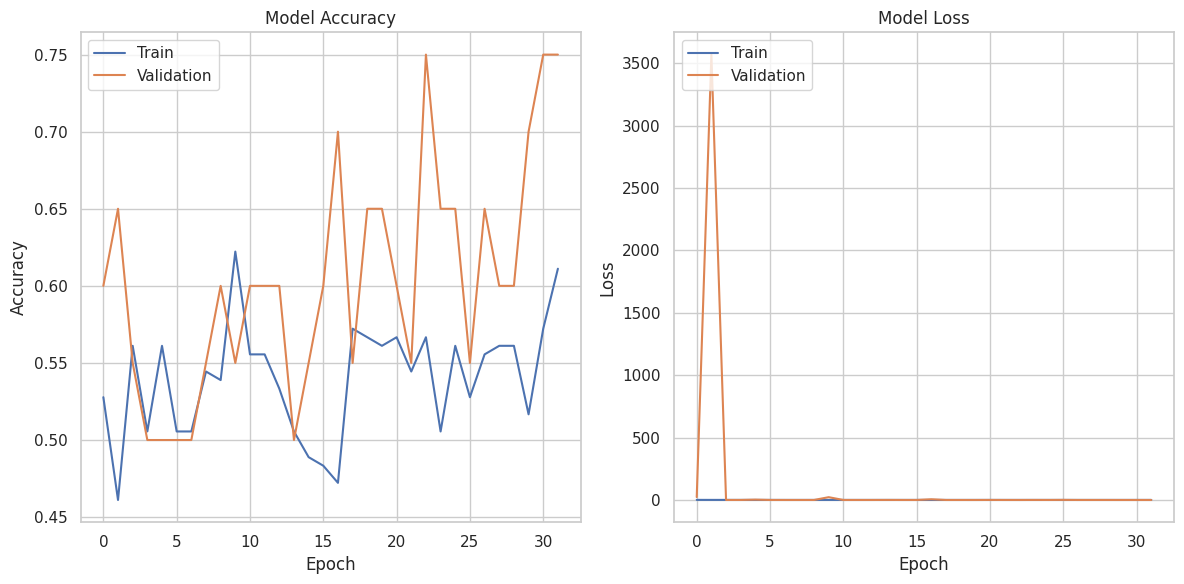

7/7 [==============================] - 0s 20ms/step
y_pred [[4.94592547e-01 4.40344274e-01]
 [4.35205549e-01 5.58318734e-01]
 [6.64465547e-01 3.17784160e-01]
 [7.54292071e-01 2.55436540e-01]
 [4.82728571e-01 5.01785994e-01]
 [7.01226473e-01 2.81735897e-01]
 [1.85821608e-01 5.85623264e-01]
 [1.09145060e-01 5.65506399e-01]
 [6.20552540e-01 3.23831797e-01]
 [1.13825381e-01 5.46099246e-01]
 [5.12976512e-05 9.99873042e-01]
 [5.76942563e-01 3.28067809e-01]
 [5.69465101e-01 3.66452664e-01]
 [4.95541766e-02 9.45737660e-01]
 [3.20237458e-01 5.57452381e-01]
 [1.31619271e-09 1.00000000e+00]
 [4.15998816e-01 5.15652478e-01]
 [3.59169215e-01 6.51905715e-01]
 [7.96789467e-01 2.23978072e-01]
 [6.48458064e-01 2.63186157e-01]
 [3.90055627e-01 6.22974634e-01]
 [4.68263745e-01 5.32983124e-01]
 [7.77906299e-01 2.33944014e-01]
 [3.90721828e-01 4.97063100e-01]
 [5.00099632e-05 9.99899507e-01]
 [2.06460297e-01 7.42327332e-01]
 [7.73595035e-01 2.40058273e-01]
 [3.27234656e-01 5.76582193e-01]
 [6.77579939e-01 

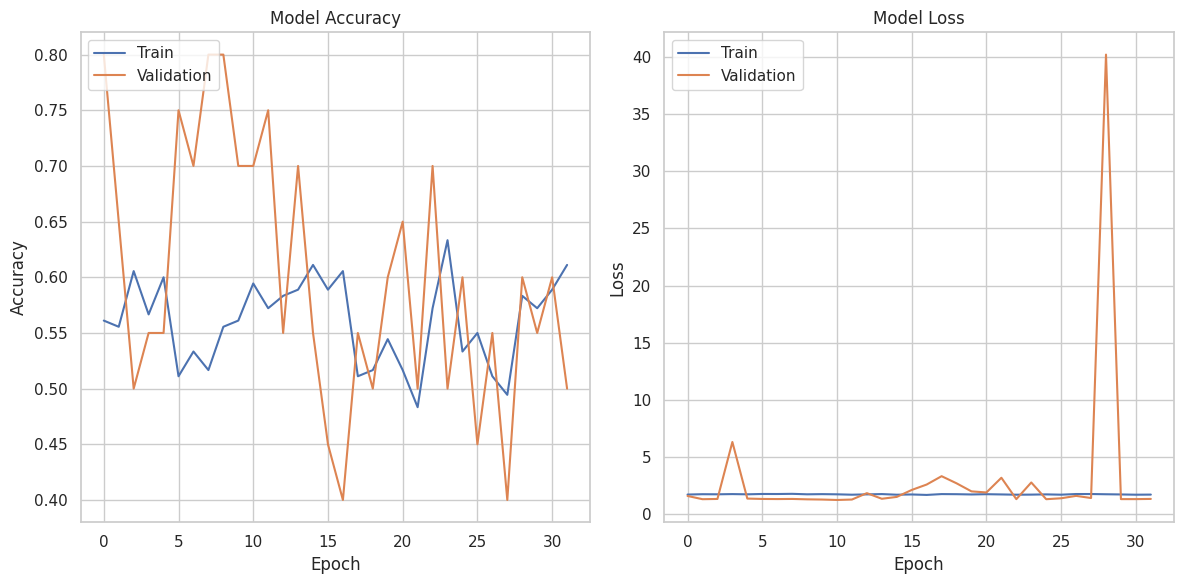

7/7 [==============================] - 0s 20ms/step
y_pred [[0.5061436  0.50906354]
 [0.56865025 0.4216255 ]
 [0.5902042  0.39845115]
 [0.5918379  0.3931454 ]
 [0.44337422 0.59503883]
 [0.5861217  0.4001203 ]
 [0.50819737 0.51386803]
 [0.48693898 0.53361654]
 [0.4304037  0.6061907 ]
 [0.475386   0.54788065]
 [0.4808959  0.64626956]
 [0.5649954  0.42594826]
 [0.5183728  0.49109042]
 [0.47756022 0.61346555]
 [0.44975168 0.59617513]
 [0.54794425 0.70600706]
 [0.5280947  0.47936141]
 [0.5721008  0.417865  ]
 [0.60499495 0.38152188]
 [0.49227205 0.545964  ]
 [0.45441583 0.5829942 ]
 [0.5652633  0.4244533 ]
 [0.59340817 0.39041972]
 [0.54200935 0.45700288]
 [0.5251354  0.653254  ]
 [0.5418016  0.45550838]
 [0.5990325  0.38572294]
 [0.5672516  0.4221961 ]
 [0.593994   0.39357316]
 [0.57449186 0.41504133]
 [0.55852586 0.43099183]
 [0.5688565  0.77979493]
 [0.43764055 0.6057552 ]
 [0.57857674 0.4129118 ]
 [0.5086741  0.51095074]
 [0.5264818  0.47960392]
 [0.5290945  0.4775425 ]
 [0.5585094  0.4

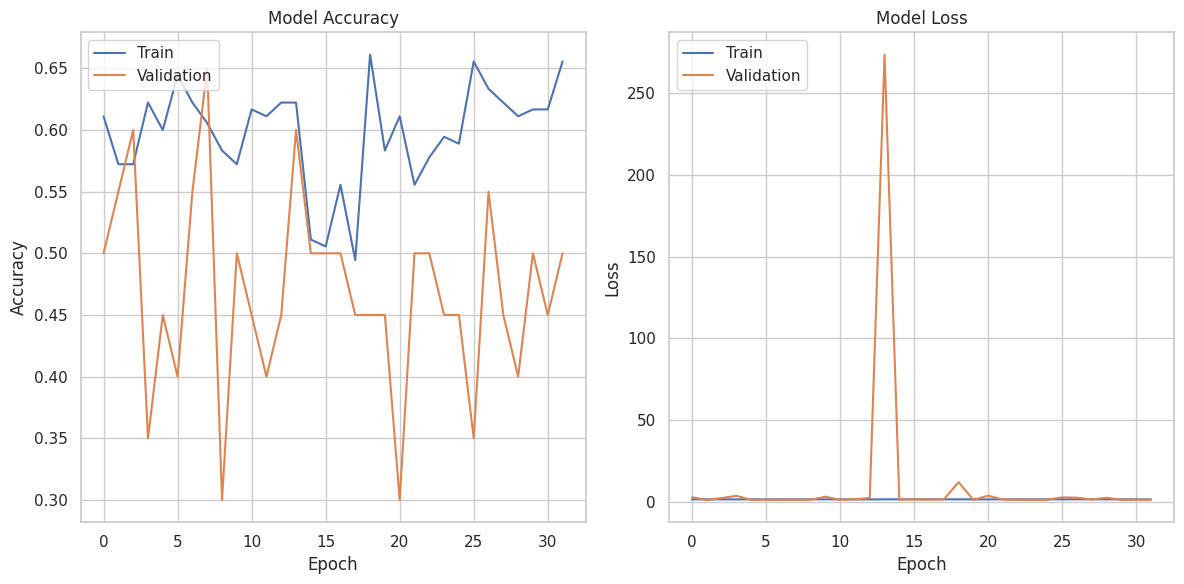

7/7 [==============================] - 0s 20ms/step
y_pred [[0.41619968 0.5928064 ]
 [0.37457877 0.6527578 ]
 [0.6574086  0.32831162]
 [0.65728205 0.33031517]
 [0.65851736 0.32612216]
 [0.6525552  0.33555314]
 [0.39849216 0.5923118 ]
 [0.40474364 0.58341175]
 [0.48803413 0.49287024]
 [0.4036106  0.58540344]
 [0.9825783  0.9348804 ]
 [0.55301005 0.4419547 ]
 [0.40117556 0.6179984 ]
 [0.9552275  0.91205335]
 [0.53492016 0.4535332 ]
 [0.9998827  0.9984835 ]
 [0.43202496 0.5467479 ]
 [0.3741219  0.6321448 ]
 [0.6540476  0.33386695]
 [0.38843516 0.63280565]
 [0.6587618  0.32639855]
 [0.38094014 0.65285885]
 [0.6588466  0.3278183 ]
 [0.4089512  0.5847961 ]
 [0.9968454  0.985587  ]
 [0.4041139  0.5749584 ]
 [0.66397697 0.31805286]
 [0.4324615  0.55554754]
 [0.6300464  0.3627274 ]
 [0.41488427 0.6319472 ]
 [0.4327232  0.5757175 ]
 [0.9998797  0.9986356 ]
 [0.6591981  0.32556695]
 [0.39915112 0.63436776]
 [0.38610834 0.6473721 ]
 [0.66452664 0.3199883 ]
 [0.43774202 0.5651455 ]
 [0.6617503  0.3

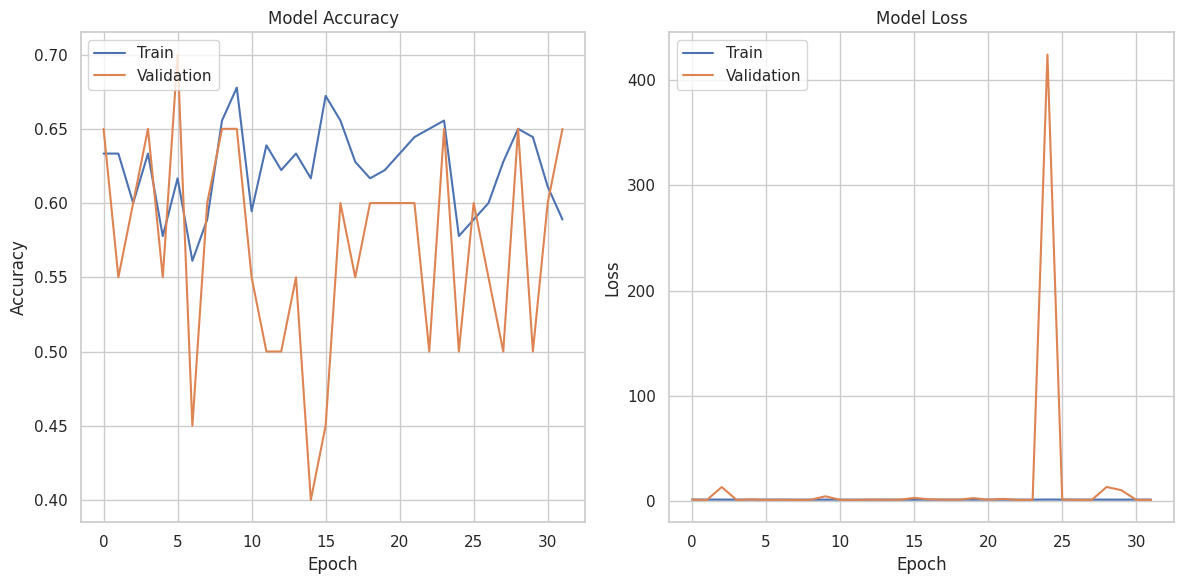

7/7 [==============================] - 0s 20ms/step
y_pred [[0.33418277 0.6772805 ]
 [0.615344   0.3964614 ]
 [0.59080315 0.42239144]
 [0.69480735 0.31801504]
 [0.62304723 0.40306535]
 [0.67936826 0.3312679 ]
 [0.49257421 0.5524257 ]
 [0.4795925  0.5621875 ]
 [0.58744216 0.44859767]
 [0.4795916  0.56167454]
 [0.4078128  0.590229  ]
 [0.36735094 0.6497011 ]
 [0.37496784 0.6423231 ]
 [0.43005472 0.5624337 ]
 [0.32368448 0.68571717]
 [0.37957895 0.79601425]
 [0.56025565 0.49361053]
 [0.54471564 0.46816736]
 [0.6751557  0.3308142 ]
 [0.57868665 0.43598294]
 [0.65185094 0.37176782]
 [0.5244803  0.49050066]
 [0.699903   0.3101996 ]
 [0.56050116 0.4944005 ]
 [0.35015672 0.6858794 ]
 [0.52553064 0.52739155]
 [0.70154506 0.30896938]
 [0.586711   0.46141538]
 [0.45185515 0.5670083 ]
 [0.53440905 0.48293257]
 [0.5348744  0.48280358]
 [0.36149102 0.79953104]
 [0.64716816 0.3745182 ]
 [0.58487636 0.43383193]
 [0.55792296 0.4550289 ]
 [0.6625678  0.34674436]
 [0.48424667 0.5342592 ]
 [0.6320915  0.3

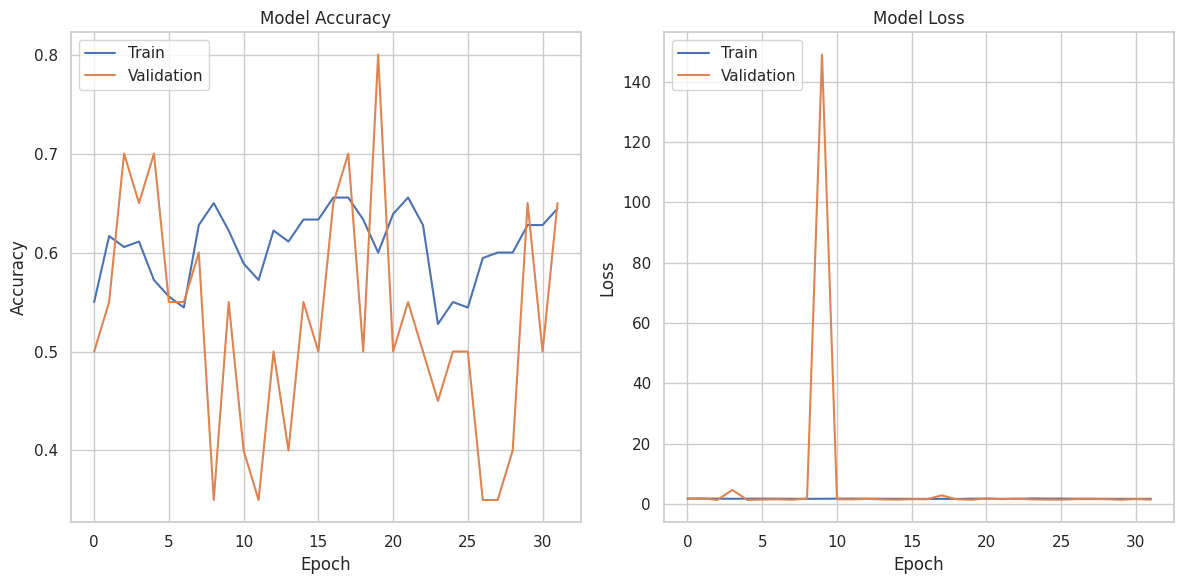

7/7 [==============================] - 0s 20ms/step
y_pred [[0.24545011 0.7530162 ]
 [0.8257036  0.19674475]
 [0.5614332  0.44511873]
 [0.70121354 0.30954006]
 [0.7719896  0.24547312]
 [0.6787498  0.3384752 ]
 [0.43150717 0.5621922 ]
 [0.40837225 0.5800632 ]
 [0.6514262  0.36810687]
 [0.41251776 0.57599646]
 [0.5349831  0.4996521 ]
 [0.20138647 0.7844614 ]
 [0.2390689  0.7569089 ]
 [0.50670856 0.52133   ]
 [0.24591698 0.75575393]
 [0.47053334 0.7656706 ]
 [0.4174388  0.5977843 ]
 [0.33045277 0.634107  ]
 [0.37033054 0.63516706]
 [0.20937844 0.7766213 ]
 [0.6622011  0.3484946 ]
 [0.22391307 0.753822  ]
 [0.6125167  0.3929041 ]
 [0.44232515 0.5790358 ]
 [0.5352737  0.6194301 ]
 [0.436091   0.5767276 ]
 [0.4388618  0.5719834 ]
 [0.4895851  0.55582446]
 [0.20704232 0.7572481 ]
 [0.2531915  0.71896577]
 [0.22415073 0.7574601 ]
 [0.49165177 0.7240753 ]
 [0.6426218  0.38045406]
 [0.2909175  0.686201  ]
 [0.26396888 0.737178  ]
 [0.66863495 0.35651127]
 [0.18619883 0.79651546]
 [0.21958797 0.7

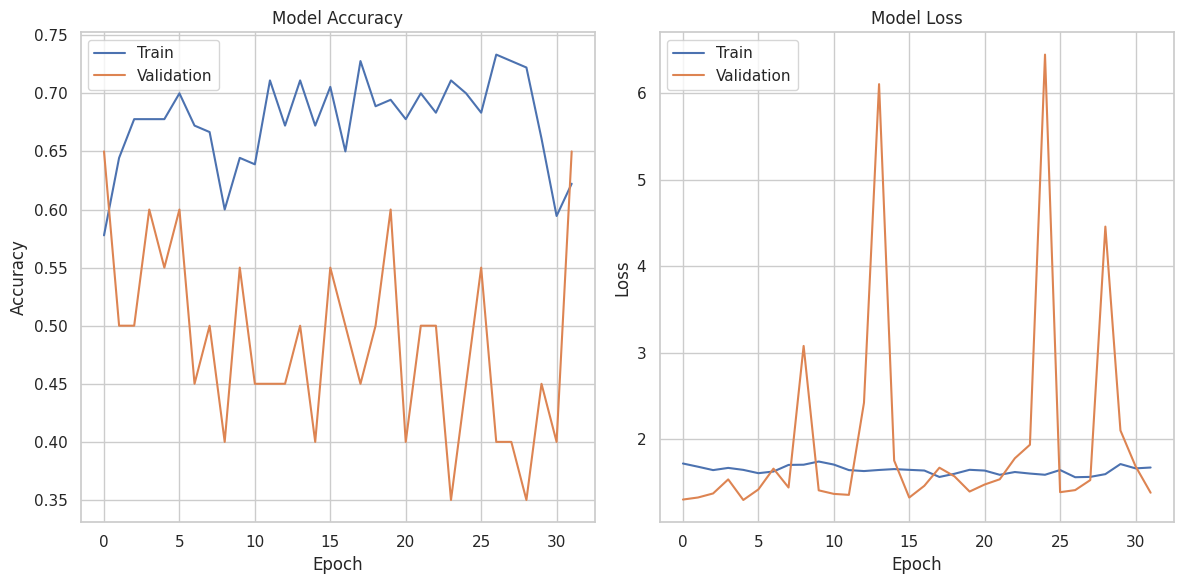

7/7 [==============================] - 0s 21ms/step
y_pred [[3.83155882e-01 5.88266671e-01]
 [8.02174270e-01 1.89828143e-01]
 [5.07195890e-01 4.75953937e-01]
 [5.13556063e-01 4.66902733e-01]
 [4.82322991e-01 5.19958138e-01]
 [4.20739502e-01 5.37262261e-01]
 [4.20270085e-01 5.99967778e-01]
 [4.04524803e-01 5.88534057e-01]
 [4.81789201e-01 5.22665143e-01]
 [4.07484472e-01 5.91543496e-01]
 [4.48581576e-01 5.58650434e-01]
 [6.55433714e-01 3.07778090e-01]
 [4.31906998e-01 5.44628382e-01]
 [4.21514779e-01 5.72384953e-01]
 [4.16240841e-01 5.58818877e-01]
 [1.46235153e-01 6.96291745e-01]
 [9.95327950e-01 3.89391463e-03]
 [4.39866602e-01 5.39187908e-01]
 [6.80362940e-01 2.82015890e-01]
 [3.75792623e-01 5.95793307e-01]
 [4.98710394e-01 4.87894714e-01]
 [5.96172988e-01 3.95625412e-01]
 [5.25133729e-01 4.49812740e-01]
 [9.72379506e-01 2.41874568e-02]
 [4.46407914e-01 5.23235142e-01]
 [4.53067482e-01 5.58044314e-01]
 [5.21450639e-01 4.55350339e-01]
 [2.76078343e-01 6.89832568e-01]
 [4.82033640e-01 

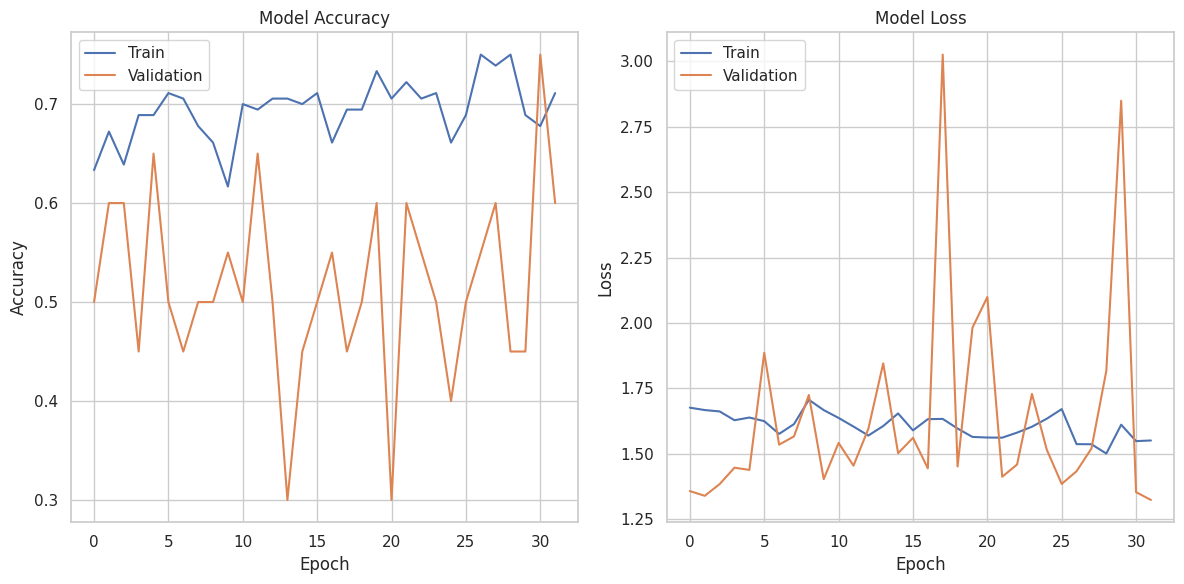

7/7 [==============================] - 0s 20ms/step
y_pred [[1.87368527e-01 7.85117030e-01]
 [8.16359699e-01 1.70019269e-01]
 [5.66533506e-01 4.30533260e-01]
 [6.69200182e-01 3.23016882e-01]
 [5.10307908e-01 4.78500426e-01]
 [4.76556957e-01 5.22889912e-01]
 [3.31874073e-01 6.56217515e-01]
 [3.52609962e-01 6.49254799e-01]
 [4.67043102e-01 5.25636971e-01]
 [3.36736411e-01 6.59122229e-01]
 [2.00712830e-01 8.72439086e-01]
 [6.07776821e-01 3.91583353e-01]
 [7.96725810e-01 1.92926988e-01]
 [2.73854047e-01 8.01729143e-01]
 [2.90936798e-01 6.89353049e-01]
 [3.78102437e-02 9.90275502e-01]
 [3.57157260e-01 6.36260629e-01]
 [5.29733956e-01 4.59780812e-01]
 [8.92133176e-01 9.63127315e-02]
 [2.45489120e-01 7.29134500e-01]
 [6.14543617e-01 3.78419876e-01]
 [6.78903520e-01 3.10788751e-01]
 [5.77062428e-01 4.21543300e-01]
 [3.91320288e-01 6.00936472e-01]
 [1.29233822e-01 9.30575550e-01]
 [3.31264317e-01 6.57457530e-01]
 [8.98050189e-01 9.00503621e-02]
 [3.80340904e-01 6.20472312e-01]
 [3.32462601e-02 

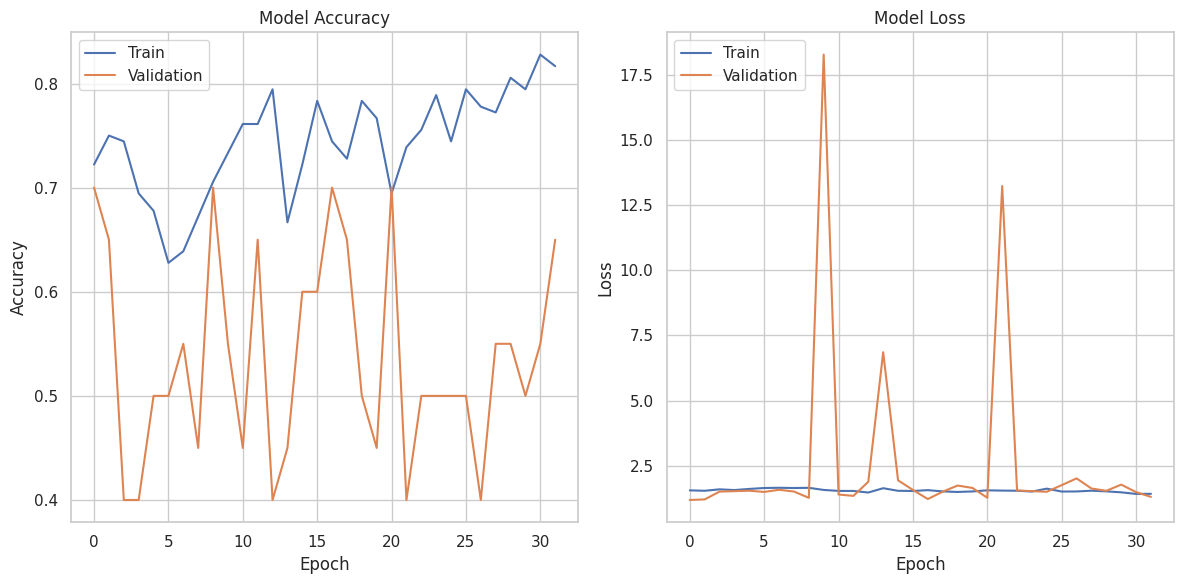

7/7 [==============================] - 0s 21ms/step
y_pred [[0.43484008 0.6076484 ]
 [0.96921253 0.03341496]
 [0.7516026  0.2592623 ]
 [0.8779378  0.13074552]
 [0.42715028 0.60931414]
 [0.7450983  0.2662258 ]
 [0.05637669 0.941824  ]
 [0.25661343 0.7678792 ]
 [0.33854845 0.6870729 ]
 [0.19146517 0.82604414]
 [0.2133237  0.7759133 ]
 [0.9735912  0.02848826]
 [0.97445005 0.02755394]
 [0.24723977 0.7460585 ]
 [0.25074142 0.7739065 ]
 [0.23941034 0.73720413]
 [0.5616862  0.46460682]
 [0.0810495  0.91629225]
 [0.9671793  0.03562143]
 [0.44533244 0.5965726 ]
 [0.7177704  0.2965599 ]
 [0.6131745  0.39635304]
 [0.26811582 0.7617664 ]
 [0.89081264 0.11820235]
 [0.26272652 0.7312178 ]
 [0.73846483 0.27938926]
 [0.8484815  0.16073568]
 [0.03037826 0.96975535]
 [0.27536875 0.7547655 ]
 [0.94408745 0.06160743]
 [0.19270769 0.8214962 ]
 [0.26568073 0.7266049 ]
 [0.48120245 0.55820465]
 [0.06250221 0.9357041 ]
 [0.45088688 0.5891261 ]
 [0.6402481  0.37549317]
 [0.4472205  0.59367114]
 [0.9765097  0.0

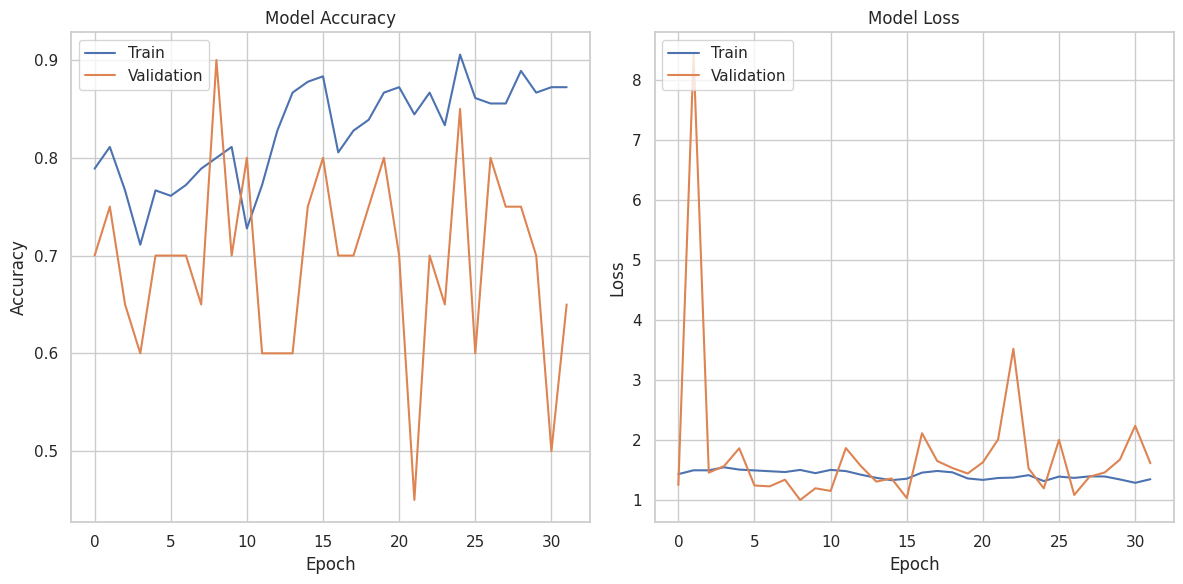

7/7 [==============================] - 0s 20ms/step
y_pred [[2.80638672e-02 9.73091245e-01]
 [9.19289351e-01 8.70546028e-02]
 [6.29559085e-02 9.42895055e-01]
 [7.56796241e-01 2.44069383e-01]
 [6.62768066e-01 3.37509602e-01]
 [4.41805124e-02 9.58793581e-01]
 [5.69664361e-03 9.93543267e-01]
 [6.60373969e-03 9.91098225e-01]
 [4.06093568e-01 5.98782539e-01]
 [3.10916249e-02 9.63568211e-01]
 [8.01963031e-01 1.34749666e-01]
 [8.15445900e-01 1.89160109e-01]
 [8.63620162e-01 1.42769560e-01]
 [8.50798786e-01 1.36969090e-01]
 [1.67749878e-02 9.83726203e-01]
 [3.06134701e-01 5.36426544e-01]
 [1.91764790e-03 9.96835053e-01]
 [9.71836269e-01 3.08331791e-02]
 [8.02582800e-01 2.01373696e-01]
 [1.22824647e-02 9.88038301e-01]
 [9.04548287e-01 1.02233313e-01]
 [3.32081951e-02 9.68380511e-01]
 [1.94610059e-02 9.81430590e-01]
 [5.53112328e-01 4.27756757e-01]
 [5.38545370e-01 4.13881361e-01]
 [1.96569562e-02 9.75592434e-01]
 [7.77852714e-01 2.25269616e-01]
 [5.22634434e-03 9.94340658e-01]
 [8.07847362e-03 

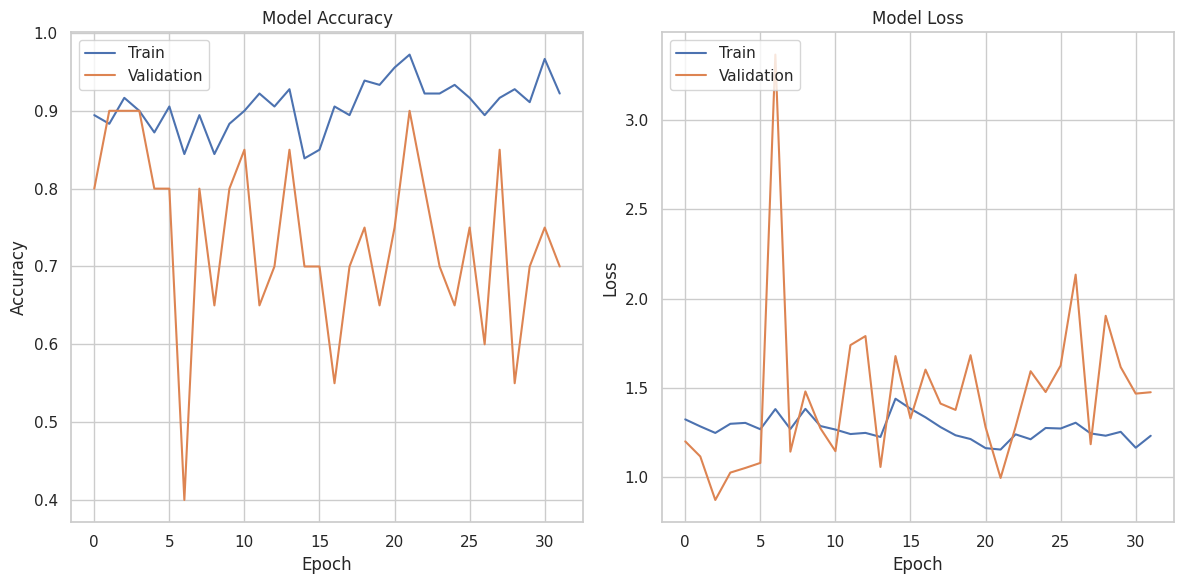

7/7 [==============================] - 0s 20ms/step
y_pred [[2.64688767e-02 9.74379897e-01]
 [9.92709756e-01 7.44286785e-03]
 [3.56782153e-02 9.65421796e-01]
 [9.86283779e-01 1.41513627e-02]
 [9.95497584e-01 4.69729071e-03]
 [7.14046955e-02 9.35754001e-01]
 [9.86322202e-03 9.90955293e-01]
 [1.74574945e-02 9.85407889e-01]
 [9.84149873e-01 1.63385794e-02]
 [9.93777871e-01 6.33529760e-03]
 [9.96870458e-01 3.34138051e-03]
 [9.85210955e-01 1.51263727e-02]
 [9.87412810e-01 1.28304213e-02]
 [6.98059320e-01 2.75063485e-01]
 [5.72157741e-01 4.32468891e-01]
 [2.33570699e-06 9.99999642e-01]
 [1.65991247e-01 8.37452531e-01]
 [9.96307611e-01 3.87067581e-03]
 [9.93642151e-01 6.53266674e-03]
 [1.78423449e-02 9.82824981e-01]
 [9.66118157e-01 3.41279842e-02]
 [1.75416507e-02 9.83087182e-01]
 [2.60793597e-01 7.70810723e-01]
 [9.77000773e-01 2.34891232e-02]
 [3.23984593e-01 7.22212613e-01]
 [9.99041259e-01 9.94468923e-04]
 [9.96833503e-01 3.36509268e-03]
 [6.00433815e-03 9.94608521e-01]
 [2.57139932e-02 

6/6 [==============================] - 1s 247ms/step - loss: 2.5689 - sparse_categorical_accuracy: 0.3056 - val_loss: 9.8623 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.5021 - sparse_categorical_accuracy: 0.3556

6/6 [==============================] - 1s 229ms/step - loss: 2.5021 - sparse_categorical_accuracy: 0.3556 - val_loss: 1082.9296 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.4268 - sparse_categorical_accuracy: 0.3611

6/6 [==============================] - 1s 225ms/step - loss: 2.4268 - sparse_categorical_accuracy: 0.3611 - val_loss: 1.8169 - val_sparse_categorical_accuracy: 0.3500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.4886 - sparse_categorical_accuracy: 0.3667

6/6 [==============================] - 1s 228ms/step - loss: 2.4886 - sparse_categorical_accuracy: 0.3667 - val_loss: 2.2337 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.4718 - sparse_categorical_accuracy: 0.2944

6/6 [==============================] - 1s 279ms/step - loss: 2.4718 - sparse_categorical_accuracy: 0.2944 - val_loss: 30.4835 - val_sparse_categorical_accuracy: 0.3500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.3031 - sparse_categorical_accuracy: 0.3833

6/6 [==============================] - 1s 283ms/step - loss: 2.3031 - sparse_categorical_accuracy: 0.3833 - val_loss: 2.1581 - val_sparse_categorical_accuracy: 0.3500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.3030 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 228ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.3778 - val_loss: 1.7928 - val_sparse_categorical_accuracy: 0.3000
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.2441 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 232ms/step - loss: 2.2441 - sparse_categorical_accuracy: 0.3889 - val_loss: 2.0598 - val_sparse_categorical_accuracy: 0.4000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.3231 - sparse_categorical_accuracy: 0.3722

6/6 [==============================] - 1s 229ms/step - loss: 2.3231 - sparse_categorical_accuracy: 0.3722 - val_loss: 1.9594 - val_sparse_categorical_accuracy: 0.3000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.3176 - sparse_categorical_accuracy: 0.3278

6/6 [==============================] - 1s 230ms/step - loss: 2.3176 - sparse_categorical_accuracy: 0.3278 - val_loss: 18.6918 - val_sparse_categorical_accuracy: 0.2000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.2418 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 232ms/step - loss: 2.2418 - sparse_categorical_accuracy: 0.3889 - val_loss: 1.8726 - val_sparse_categorical_accuracy: 0.2500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.2783 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 232ms/step - loss: 2.2783 - sparse_categorical_accuracy: 0.3778 - val_loss: 1.8050 - val_sparse_categorical_accuracy: 0.3500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.3627 - sparse_categorical_accuracy: 0.3667

6/6 [==============================] - 1s 224ms/step - loss: 2.3627 - sparse_categorical_accuracy: 0.3667 - val_loss: 2.0447 - val_sparse_categorical_accuracy: 0.3500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.2992 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 225ms/step - loss: 2.2992 - sparse_categorical_accuracy: 0.3889 - val_loss: 3.1514 - val_sparse_categorical_accuracy: 0.3000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.2691 - sparse_categorical_accuracy: 0.3167

6/6 [==============================] - 1s 274ms/step - loss: 2.2691 - sparse_categorical_accuracy: 0.3167 - val_loss: 2.3596 - val_sparse_categorical_accuracy: 0.3000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.3258 - sparse_categorical_accuracy: 0.3500

6/6 [==============================] - 1s 284ms/step - loss: 2.3258 - sparse_categorical_accuracy: 0.3500 - val_loss: 2.3802 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.3269 - sparse_categorical_accuracy: 0.4000

6/6 [==============================] - 1s 262ms/step - loss: 2.3269 - sparse_categorical_accuracy: 0.4000 - val_loss: 10.7040 - val_sparse_categorical_accuracy: 0.2500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.2767 - sparse_categorical_accuracy: 0.4167

6/6 [==============================] - 1s 229ms/step - loss: 2.2767 - sparse_categorical_accuracy: 0.4167 - val_loss: 2.0601 - val_sparse_categorical_accuracy: 0.3000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.3313 - sparse_categorical_accuracy: 0.3333

6/6 [==============================] - 1s 238ms/step - loss: 2.3313 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.9952 - val_sparse_categorical_accuracy: 0.3500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.2148 - sparse_categorical_accuracy: 0.4222

6/6 [==============================] - 1s 229ms/step - loss: 2.2148 - sparse_categorical_accuracy: 0.4222 - val_loss: 1.8820 - val_sparse_categorical_accuracy: 0.3000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.2289 - sparse_categorical_accuracy: 0.4167

6/6 [==============================] - 1s 228ms/step - loss: 2.2289 - sparse_categorical_accuracy: 0.4167 - val_loss: 1.9306 - val_sparse_categorical_accuracy: 0.2500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.2692 - sparse_categorical_accuracy: 0.4222

6/6 [==============================] - 1s 227ms/step - loss: 2.2692 - sparse_categorical_accuracy: 0.4222 - val_loss: 1.8100 - val_sparse_categorical_accuracy: 0.4000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.2529 - sparse_categorical_accuracy: 0.4056

6/6 [==============================] - 1s 223ms/step - loss: 2.2529 - sparse_categorical_accuracy: 0.4056 - val_loss: 2.1219 - val_sparse_categorical_accuracy: 0.4000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.2190 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 231ms/step - loss: 2.2190 - sparse_categorical_accuracy: 0.3778 - val_loss: 6.6092 - val_sparse_categorical_accuracy: 0.2500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.1910 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 259ms/step - loss: 2.1910 - sparse_categorical_accuracy: 0.3889 - val_loss: 2.0863 - val_sparse_categorical_accuracy: 0.3500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.2026 - sparse_categorical_accuracy: 0.4222

6/6 [==============================] - 2s 285ms/step - loss: 2.2026 - sparse_categorical_accuracy: 0.4222 - val_loss: 7.1503 - val_sparse_categorical_accuracy: 0.3000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.2224 - sparse_categorical_accuracy: 0.3667

6/6 [==============================] - 2s 295ms/step - loss: 2.2224 - sparse_categorical_accuracy: 0.3667 - val_loss: 3.3784 - val_sparse_categorical_accuracy: 0.3000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.2341 - sparse_categorical_accuracy: 0.4389

6/6 [==============================] - 1s 226ms/step - loss: 2.2341 - sparse_categorical_accuracy: 0.4389 - val_loss: 3.6135 - val_sparse_categorical_accuracy: 0.3000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.2014 - sparse_categorical_accuracy: 0.3333

6/6 [==============================] - 1s 225ms/step - loss: 2.2014 - sparse_categorical_accuracy: 0.3333 - val_loss: 2.2291 - val_sparse_categorical_accuracy: 0.2500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.1624 - sparse_categorical_accuracy: 0.3722

6/6 [==============================] - 1s 231ms/step - loss: 2.1624 - sparse_categorical_accuracy: 0.3722 - val_loss: 2.0371 - val_sparse_categorical_accuracy: 0.3500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.2392 - sparse_categorical_accuracy: 0.4000

6/6 [==============================] - 1s 228ms/step - loss: 2.2392 - sparse_categorical_accuracy: 0.4000 - val_loss: 1.8147 - val_sparse_categorical_accuracy: 0.3000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.1579 - sparse_categorical_accuracy: 0.3667

6/6 [==============================] - 1s 231ms/step - loss: 2.1579 - sparse_categorical_accuracy: 0.3667 - val_loss: 2.3729 - val_sparse_categorical_accuracy: 0.2000


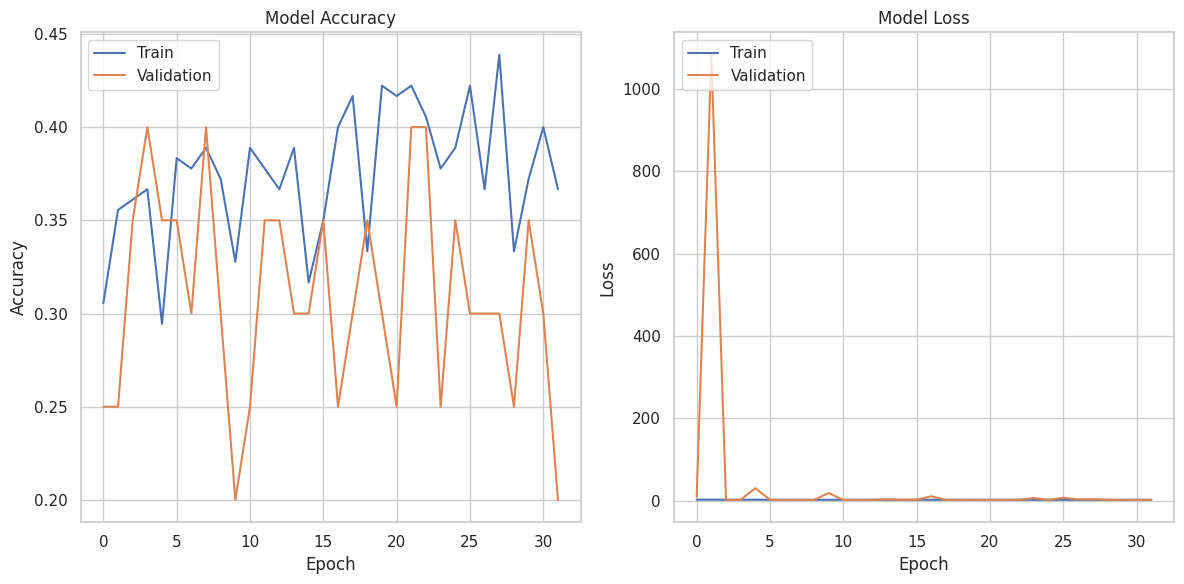

7/7 [==============================] - 0s 21ms/step
y_pred [[2.45182216e-01 4.04414177e-01 3.50403666e-01]
 [3.89567256e-01 2.62657851e-01 3.47774863e-01]
 [2.50730008e-01 4.11658734e-01 3.37611258e-01]
 [2.39213988e-01 3.78054410e-01 3.82731616e-01]
 [2.26088643e-01 2.66986072e-01 5.06925285e-01]
 [2.35691339e-01 3.56405616e-01 4.07903016e-01]
 [3.03873748e-01 3.08244199e-01 3.87882084e-01]
 [3.17594200e-01 2.34963745e-01 4.47442025e-01]
 [2.20642179e-01 2.56429017e-01 5.22928834e-01]
 [3.16149294e-01 2.37555280e-01 4.46295410e-01]
 [8.72639101e-03 4.81479481e-04 9.90792155e-01]
 [2.56242782e-01 3.94432336e-01 3.49324912e-01]
 [2.43345439e-01 4.06237602e-01 3.50416988e-01]
 [8.16117451e-02 2.78469864e-02 8.90541315e-01]
 [2.51540244e-01 3.94418865e-01 3.54040831e-01]
 [1.36658468e-03 1.40164848e-05 9.98619437e-01]
 [2.91044146e-01 3.81948352e-01 3.27007473e-01]
 [3.96328032e-01 2.50840962e-01 3.52831036e-01]
 [2.50521094e-01 4.12666023e-01 3.36812884e-01]
 [2.40158305e-01 4.05331641e-

6/6 [==============================] - 1s 249ms/step - loss: 2.1905 - sparse_categorical_accuracy: 0.3722 - val_loss: 2.4158 - val_sparse_categorical_accuracy: 0.3500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.2244 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 272ms/step - loss: 2.2244 - sparse_categorical_accuracy: 0.3778 - val_loss: 1.7526 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.2054 - sparse_categorical_accuracy: 0.3556

6/6 [==============================] - 1s 277ms/step - loss: 2.2054 - sparse_categorical_accuracy: 0.3556 - val_loss: 1.7422 - val_sparse_categorical_accuracy: 0.5500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.1671 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 270ms/step - loss: 2.1671 - sparse_categorical_accuracy: 0.4333 - val_loss: 231.4204 - val_sparse_categorical_accuracy: 0.3500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.1582 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 223ms/step - loss: 2.1582 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.8461 - val_sparse_categorical_accuracy: 0.3000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.1996 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 227ms/step - loss: 2.1996 - sparse_categorical_accuracy: 0.3889 - val_loss: 1.7727 - val_sparse_categorical_accuracy: 0.2500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.1628 - sparse_categorical_accuracy: 0.4056

6/6 [==============================] - 1s 227ms/step - loss: 2.1628 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.8139 - val_sparse_categorical_accuracy: 0.3500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.1569 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 228ms/step - loss: 2.1569 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.7543 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.1168 - sparse_categorical_accuracy: 0.4389

6/6 [==============================] - 1s 225ms/step - loss: 2.1168 - sparse_categorical_accuracy: 0.4389 - val_loss: 2.6179 - val_sparse_categorical_accuracy: 0.3500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.1706 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 220ms/step - loss: 2.1706 - sparse_categorical_accuracy: 0.3778 - val_loss: 1.8038 - val_sparse_categorical_accuracy: 0.3500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.2299 - sparse_categorical_accuracy: 0.3611

6/6 [==============================] - 1s 224ms/step - loss: 2.2299 - sparse_categorical_accuracy: 0.3611 - val_loss: 1.7529 - val_sparse_categorical_accuracy: 0.4500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.1987 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 242ms/step - loss: 2.1987 - sparse_categorical_accuracy: 0.3778 - val_loss: 1.8257 - val_sparse_categorical_accuracy: 0.2500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.1171 - sparse_categorical_accuracy: 0.4167

6/6 [==============================] - 2s 285ms/step - loss: 2.1171 - sparse_categorical_accuracy: 0.4167 - val_loss: 4.4912 - val_sparse_categorical_accuracy: 0.3000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.2169 - sparse_categorical_accuracy: 0.4056

6/6 [==============================] - 2s 301ms/step - loss: 2.2169 - sparse_categorical_accuracy: 0.4056 - val_loss: 2.0075 - val_sparse_categorical_accuracy: 0.2500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.2471 - sparse_categorical_accuracy: 0.3611

6/6 [==============================] - 1s 227ms/step - loss: 2.2471 - sparse_categorical_accuracy: 0.3611 - val_loss: 1.7586 - val_sparse_categorical_accuracy: 0.4000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.2377 - sparse_categorical_accuracy: 0.3722

6/6 [==============================] - 1s 228ms/step - loss: 2.2377 - sparse_categorical_accuracy: 0.3722 - val_loss: 2.3561 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.2531 - sparse_categorical_accuracy: 0.3389

6/6 [==============================] - 1s 235ms/step - loss: 2.2531 - sparse_categorical_accuracy: 0.3389 - val_loss: 1.9253 - val_sparse_categorical_accuracy: 0.4000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.2183 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 222ms/step - loss: 2.2183 - sparse_categorical_accuracy: 0.3889 - val_loss: 3.1115 - val_sparse_categorical_accuracy: 0.2500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.1690 - sparse_categorical_accuracy: 0.4444

6/6 [==============================] - 1s 224ms/step - loss: 2.1690 - sparse_categorical_accuracy: 0.4444 - val_loss: 3.7531 - val_sparse_categorical_accuracy: 0.3000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.1429 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 225ms/step - loss: 2.1429 - sparse_categorical_accuracy: 0.4722 - val_loss: 2.2176 - val_sparse_categorical_accuracy: 0.5000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.1400 - sparse_categorical_accuracy: 0.4389

6/6 [==============================] - 1s 229ms/step - loss: 2.1400 - sparse_categorical_accuracy: 0.4389 - val_loss: 2.7927 - val_sparse_categorical_accuracy: 0.3500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.2840 - sparse_categorical_accuracy: 0.3333

6/6 [==============================] - 1s 230ms/step - loss: 2.2840 - sparse_categorical_accuracy: 0.3333 - val_loss: 5.1999 - val_sparse_categorical_accuracy: 0.3000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.2263 - sparse_categorical_accuracy: 0.3778

6/6 [==============================] - 1s 283ms/step - loss: 2.2263 - sparse_categorical_accuracy: 0.3778 - val_loss: 1.9870 - val_sparse_categorical_accuracy: 0.4000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.2175 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 2s 287ms/step - loss: 2.2175 - sparse_categorical_accuracy: 0.4333 - val_loss: 3.4993 - val_sparse_categorical_accuracy: 0.3500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.2033 - sparse_categorical_accuracy: 0.3833

6/6 [==============================] - 1s 240ms/step - loss: 2.2033 - sparse_categorical_accuracy: 0.3833 - val_loss: 1.7302 - val_sparse_categorical_accuracy: 0.5500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.2194 - sparse_categorical_accuracy: 0.4056

6/6 [==============================] - 1s 234ms/step - loss: 2.2194 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.7927 - val_sparse_categorical_accuracy: 0.4000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.1721 - sparse_categorical_accuracy: 0.4611

6/6 [==============================] - 1s 227ms/step - loss: 2.1721 - sparse_categorical_accuracy: 0.4611 - val_loss: 2.9185 - val_sparse_categorical_accuracy: 0.4000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.2336 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 226ms/step - loss: 2.2336 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.8249 - val_sparse_categorical_accuracy: 0.4000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.1741 - sparse_categorical_accuracy: 0.3944

6/6 [==============================] - 1s 231ms/step - loss: 2.1741 - sparse_categorical_accuracy: 0.3944 - val_loss: 17.6884 - val_sparse_categorical_accuracy: 0.2500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.2024 - sparse_categorical_accuracy: 0.3389

6/6 [==============================] - 1s 226ms/step - loss: 2.2024 - sparse_categorical_accuracy: 0.3389 - val_loss: 2.0210 - val_sparse_categorical_accuracy: 0.3500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.1672 - sparse_categorical_accuracy: 0.4556

6/6 [==============================] - 1s 228ms/step - loss: 2.1672 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.7597 - val_sparse_categorical_accuracy: 0.4000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.1470 - sparse_categorical_accuracy: 0.3889

6/6 [==============================] - 1s 230ms/step - loss: 2.1470 - sparse_categorical_accuracy: 0.3889 - val_loss: 1.7409 - val_sparse_categorical_accuracy: 0.3500


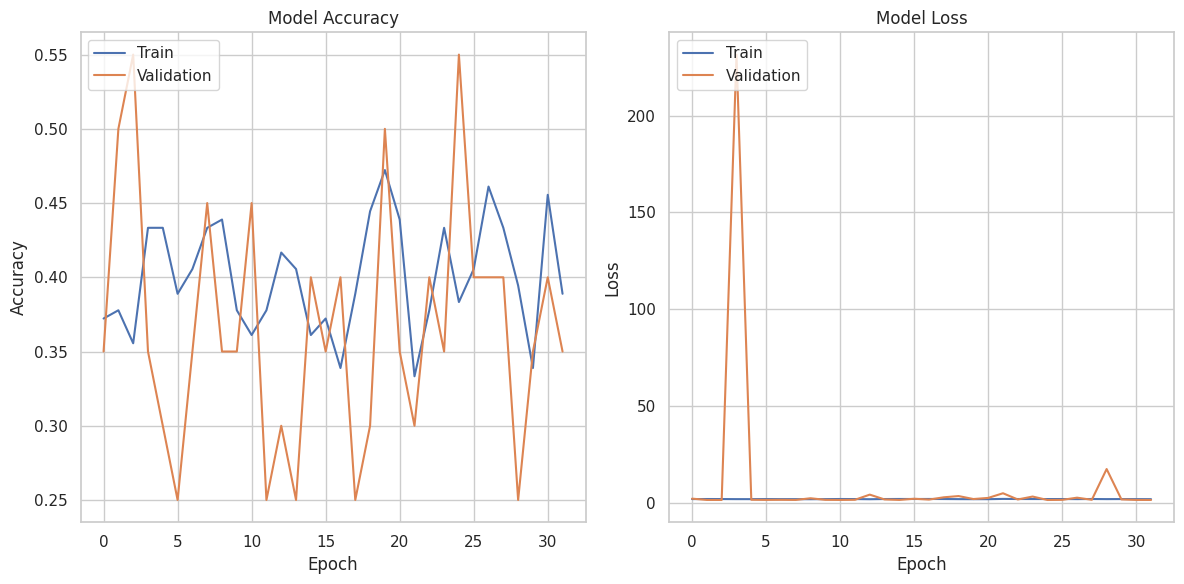

7/7 [==============================] - 0s 20ms/step
y_pred [[0.26842752 0.38325384 0.3483187 ]
 [0.27735677 0.39604843 0.32659477]
 [0.25810373 0.38106412 0.3608322 ]
 [0.23175712 0.35489663 0.4133462 ]
 [0.22322994 0.34669662 0.43007347]
 [0.23714913 0.36305082 0.39980006]
 [0.2531308  0.38634163 0.36052755]
 [0.33034098 0.39809513 0.27156392]
 [0.22288847 0.3426638  0.43444774]
 [0.29280692 0.4090512  0.2981418 ]
 [0.334874   0.23545867 0.42966732]
 [0.26931405 0.3855988  0.3450871 ]
 [0.28332555 0.38987803 0.32679635]
 [0.3413714  0.2233711  0.4352575 ]
 [0.2689666  0.38363162 0.3474018 ]
 [0.28424254 0.23435332 0.4814041 ]
 [0.24169971 0.37413153 0.38416877]
 [0.32884467 0.3959515  0.27520385]
 [0.24995078 0.37693816 0.3731111 ]
 [0.28800553 0.4072312  0.30476335]
 [0.22352874 0.3506676  0.4258037 ]
 [0.30597863 0.3945796  0.2994418 ]
 [0.23804645 0.36974666 0.39220694]
 [0.24759473 0.38353854 0.36886674]
 [0.3316725  0.22832447 0.4400031 ]
 [0.46848944 0.33261132 0.19889924]
 [0.2

6/6 [==============================] - 1s 243ms/step - loss: 2.1406 - sparse_categorical_accuracy: 0.3889 - val_loss: 3.5688 - val_sparse_categorical_accuracy: 0.3000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.1811 - sparse_categorical_accuracy: 0.3833

6/6 [==============================] - 1s 229ms/step - loss: 2.1811 - sparse_categorical_accuracy: 0.3833 - val_loss: 1.6805 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.1421 - sparse_categorical_accuracy: 0.4056

6/6 [==============================] - 1s 226ms/step - loss: 2.1421 - sparse_categorical_accuracy: 0.4056 - val_loss: 2.2722 - val_sparse_categorical_accuracy: 0.3000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.1638 - sparse_categorical_accuracy: 0.3667

6/6 [==============================] - 1s 226ms/step - loss: 2.1638 - sparse_categorical_accuracy: 0.3667 - val_loss: 1.8819 - val_sparse_categorical_accuracy: 0.3500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.1117 - sparse_categorical_accuracy: 0.4278

6/6 [==============================] - 1s 276ms/step - loss: 2.1117 - sparse_categorical_accuracy: 0.4278 - val_loss: 1.7652 - val_sparse_categorical_accuracy: 0.3500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.1327 - sparse_categorical_accuracy: 0.4444

6/6 [==============================] - 1s 280ms/step - loss: 2.1327 - sparse_categorical_accuracy: 0.4444 - val_loss: 1.8326 - val_sparse_categorical_accuracy: 0.4000
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.1113 - sparse_categorical_accuracy: 0.4500

6/6 [==============================] - 1s 272ms/step - loss: 2.1113 - sparse_categorical_accuracy: 0.4500 - val_loss: 1.6304 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.0924 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 224ms/step - loss: 2.0924 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.7548 - val_sparse_categorical_accuracy: 0.3000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.1748 - sparse_categorical_accuracy: 0.4056

6/6 [==============================] - 1s 228ms/step - loss: 2.1748 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.6544 - val_sparse_categorical_accuracy: 0.4500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.0993 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 233ms/step - loss: 2.0993 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.7635 - val_sparse_categorical_accuracy: 0.5000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.0657 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 233ms/step - loss: 2.0657 - sparse_categorical_accuracy: 0.5111 - val_loss: 1.7540 - val_sparse_categorical_accuracy: 0.3500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.1021 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 229ms/step - loss: 2.1021 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.8368 - val_sparse_categorical_accuracy: 0.3500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.0859 - sparse_categorical_accuracy: 0.4222

6/6 [==============================] - 1s 223ms/step - loss: 2.0859 - sparse_categorical_accuracy: 0.4222 - val_loss: 2.1338 - val_sparse_categorical_accuracy: 0.3000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.0615 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 231ms/step - loss: 2.0615 - sparse_categorical_accuracy: 0.4889 - val_loss: 17.2778 - val_sparse_categorical_accuracy: 0.2500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.0994 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 250ms/step - loss: 2.0994 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.7466 - val_sparse_categorical_accuracy: 0.3500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.1694 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 2s 287ms/step - loss: 2.1694 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.8118 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.0795 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 300ms/step - loss: 2.0795 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.8329 - val_sparse_categorical_accuracy: 0.3000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.1053 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 228ms/step - loss: 2.1053 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.9184 - val_sparse_categorical_accuracy: 0.3000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.1077 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 238ms/step - loss: 2.1077 - sparse_categorical_accuracy: 0.4944 - val_loss: 9.8698 - val_sparse_categorical_accuracy: 0.2500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.1208 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 233ms/step - loss: 2.1208 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.7361 - val_sparse_categorical_accuracy: 0.4000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.1205 - sparse_categorical_accuracy: 0.4389

6/6 [==============================] - 1s 228ms/step - loss: 2.1205 - sparse_categorical_accuracy: 0.4389 - val_loss: 2.5624 - val_sparse_categorical_accuracy: 0.5000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.1060 - sparse_categorical_accuracy: 0.4611

6/6 [==============================] - 1s 232ms/step - loss: 2.1060 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.7509 - val_sparse_categorical_accuracy: 0.4500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.0447 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 226ms/step - loss: 2.0447 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.8193 - val_sparse_categorical_accuracy: 0.3500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.0969 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 224ms/step - loss: 2.0969 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.6900 - val_sparse_categorical_accuracy: 0.5500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.0204 - sparse_categorical_accuracy: 0.5444

6/6 [==============================] - 1s 224ms/step - loss: 2.0204 - sparse_categorical_accuracy: 0.5444 - val_loss: 1.7898 - val_sparse_categorical_accuracy: 0.4000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.0662 - sparse_categorical_accuracy: 0.5444

6/6 [==============================] - 1s 281ms/step - loss: 2.0662 - sparse_categorical_accuracy: 0.5444 - val_loss: 2.1067 - val_sparse_categorical_accuracy: 0.3000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.2032 - sparse_categorical_accuracy: 0.4444

6/6 [==============================] - 2s 297ms/step - loss: 2.2032 - sparse_categorical_accuracy: 0.4444 - val_loss: 2.0490 - val_sparse_categorical_accuracy: 0.3000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.1202 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 242ms/step - loss: 2.1202 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.7571 - val_sparse_categorical_accuracy: 0.3500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.1499 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 229ms/step - loss: 2.1499 - sparse_categorical_accuracy: 0.4889 - val_loss: 1.6888 - val_sparse_categorical_accuracy: 0.5500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.0754 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 222ms/step - loss: 2.0754 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.7676 - val_sparse_categorical_accuracy: 0.3500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.0732 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 228ms/step - loss: 2.0732 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.7573 - val_sparse_categorical_accuracy: 0.3500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.1149 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 230ms/step - loss: 2.1149 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.8109 - val_sparse_categorical_accuracy: 0.3000


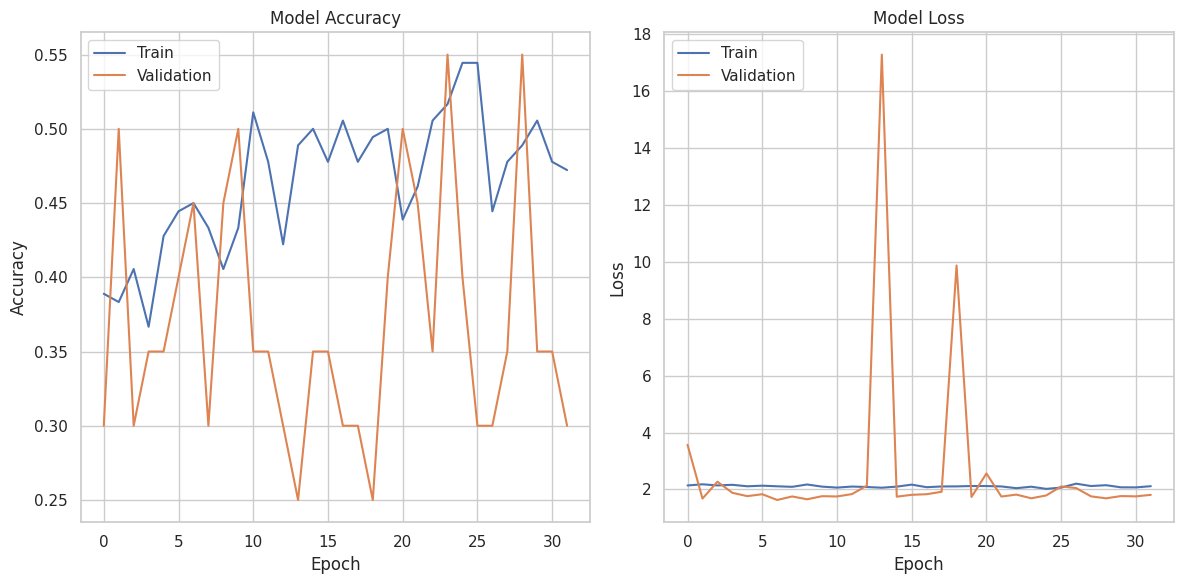

7/7 [==============================] - 0s 21ms/step
y_pred [[1.26580790e-01 2.52002031e-01 6.21417224e-01]
 [1.65668905e-01 4.03930783e-01 4.30400372e-01]
 [1.73777148e-01 3.22575629e-01 5.03647268e-01]
 [1.99435800e-01 3.78513902e-01 4.22050327e-01]
 [6.31944180e-01 1.87305316e-01 1.80750489e-01]
 [1.57375023e-01 2.83548713e-01 5.59076250e-01]
 [3.29051554e-01 4.60918754e-01 2.10029632e-01]
 [2.07817554e-01 3.33404809e-01 4.58777636e-01]
 [6.16048276e-01 1.88255325e-01 1.95696399e-01]
 [1.78141966e-01 3.03079545e-01 5.18778503e-01]
 [1.91052327e-21 4.45407750e-07 9.99999523e-01]
 [1.27004117e-01 2.51988381e-01 6.21007502e-01]
 [1.42732397e-01 2.80348539e-01 5.76919019e-01]
 [4.45707235e-03 2.13823617e-01 7.81719327e-01]
 [4.78473663e-01 1.98766068e-01 3.22760314e-01]
 [8.28000710e-19 3.84569785e-06 9.99996185e-01]
 [2.46618614e-01 5.00177324e-01 2.53204018e-01]
 [4.53940988e-01 2.45126933e-01 3.00932109e-01]
 [1.26312241e-01 2.49572128e-01 6.24115646e-01]
 [2.85448700e-01 5.26682198e-

6/6 [==============================] - 1s 249ms/step - loss: 1.9729 - sparse_categorical_accuracy: 0.5722 - val_loss: 2.0161 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.0425 - sparse_categorical_accuracy: 0.5667

6/6 [==============================] - 1s 228ms/step - loss: 2.0425 - sparse_categorical_accuracy: 0.5667 - val_loss: 2.0191 - val_sparse_categorical_accuracy: 0.3000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.1267 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 229ms/step - loss: 2.1267 - sparse_categorical_accuracy: 0.5111 - val_loss: 3.2662 - val_sparse_categorical_accuracy: 0.3000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.0492 - sparse_categorical_accuracy: 0.5389

6/6 [==============================] - 1s 231ms/step - loss: 2.0492 - sparse_categorical_accuracy: 0.5389 - val_loss: 2.6169 - val_sparse_categorical_accuracy: 0.2000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.0137 - sparse_categorical_accuracy: 0.5444

6/6 [==============================] - 1s 234ms/step - loss: 2.0137 - sparse_categorical_accuracy: 0.5444 - val_loss: 2.3922 - val_sparse_categorical_accuracy: 0.3500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.9809 - sparse_categorical_accuracy: 0.5500

6/6 [==============================] - 1s 230ms/step - loss: 1.9809 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.3106 - val_sparse_categorical_accuracy: 0.2000
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.9905 - sparse_categorical_accuracy: 0.5833

6/6 [==============================] - 1s 228ms/step - loss: 1.9905 - sparse_categorical_accuracy: 0.5833 - val_loss: 2.1496 - val_sparse_categorical_accuracy: 0.3000
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.9951 - sparse_categorical_accuracy: 0.5833

6/6 [==============================] - 1s 241ms/step - loss: 1.9951 - sparse_categorical_accuracy: 0.5833 - val_loss: 2.0194 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.9639 - sparse_categorical_accuracy: 0.5500

6/6 [==============================] - 2s 289ms/step - loss: 1.9639 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.1902 - val_sparse_categorical_accuracy: 0.3000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.9178 - sparse_categorical_accuracy: 0.6278

6/6 [==============================] - 2s 320ms/step - loss: 1.9178 - sparse_categorical_accuracy: 0.6278 - val_loss: 4.1205 - val_sparse_categorical_accuracy: 0.3000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.9184 - sparse_categorical_accuracy: 0.6056

6/6 [==============================] - 1s 226ms/step - loss: 1.9184 - sparse_categorical_accuracy: 0.6056 - val_loss: 3.1825 - val_sparse_categorical_accuracy: 0.3000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.0214 - sparse_categorical_accuracy: 0.5889

6/6 [==============================] - 1s 224ms/step - loss: 2.0214 - sparse_categorical_accuracy: 0.5889 - val_loss: 2.0455 - val_sparse_categorical_accuracy: 0.4000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.9607 - sparse_categorical_accuracy: 0.5500

6/6 [==============================] - 1s 228ms/step - loss: 1.9607 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.2129 - val_sparse_categorical_accuracy: 0.3000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.0065 - sparse_categorical_accuracy: 0.5667

6/6 [==============================] - 1s 230ms/step - loss: 2.0065 - sparse_categorical_accuracy: 0.5667 - val_loss: 1.9695 - val_sparse_categorical_accuracy: 0.2500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.0324 - sparse_categorical_accuracy: 0.5389

6/6 [==============================] - 1s 230ms/step - loss: 2.0324 - sparse_categorical_accuracy: 0.5389 - val_loss: 2.0022 - val_sparse_categorical_accuracy: 0.3500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.9187 - sparse_categorical_accuracy: 0.6556

6/6 [==============================] - 1s 240ms/step - loss: 1.9187 - sparse_categorical_accuracy: 0.6556 - val_loss: 12.1627 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.9424 - sparse_categorical_accuracy: 0.5889

6/6 [==============================] - 1s 232ms/step - loss: 1.9424 - sparse_categorical_accuracy: 0.5889 - val_loss: 3.3913 - val_sparse_categorical_accuracy: 0.2000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.0575 - sparse_categorical_accuracy: 0.5278

6/6 [==============================] - 1s 228ms/step - loss: 2.0575 - sparse_categorical_accuracy: 0.5278 - val_loss: 2.1210 - val_sparse_categorical_accuracy: 0.3500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.0388 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 269ms/step - loss: 2.0388 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.1123 - val_sparse_categorical_accuracy: 0.3000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.9946 - sparse_categorical_accuracy: 0.5500

6/6 [==============================] - 1s 275ms/step - loss: 1.9946 - sparse_categorical_accuracy: 0.5500 - val_loss: 5.1038 - val_sparse_categorical_accuracy: 0.2500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.9579 - sparse_categorical_accuracy: 0.5778

6/6 [==============================] - 1s 260ms/step - loss: 1.9579 - sparse_categorical_accuracy: 0.5778 - val_loss: 2.1105 - val_sparse_categorical_accuracy: 0.3500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.8904 - sparse_categorical_accuracy: 0.6389

6/6 [==============================] - 1s 228ms/step - loss: 1.8904 - sparse_categorical_accuracy: 0.6389 - val_loss: 4.6903 - val_sparse_categorical_accuracy: 0.3500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.0265 - sparse_categorical_accuracy: 0.5667

6/6 [==============================] - 1s 227ms/step - loss: 2.0265 - sparse_categorical_accuracy: 0.5667 - val_loss: 2.5016 - val_sparse_categorical_accuracy: 0.3000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.9923 - sparse_categorical_accuracy: 0.6167

6/6 [==============================] - 1s 223ms/step - loss: 1.9923 - sparse_categorical_accuracy: 0.6167 - val_loss: 3.4650 - val_sparse_categorical_accuracy: 0.3500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.9589 - sparse_categorical_accuracy: 0.6278

6/6 [==============================] - 1s 231ms/step - loss: 1.9589 - sparse_categorical_accuracy: 0.6278 - val_loss: 213.9015 - val_sparse_categorical_accuracy: 0.3000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.0420 - sparse_categorical_accuracy: 0.5389

6/6 [==============================] - 1s 229ms/step - loss: 2.0420 - sparse_categorical_accuracy: 0.5389 - val_loss: 3.7275 - val_sparse_categorical_accuracy: 0.2000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.9200 - sparse_categorical_accuracy: 0.6000

6/6 [==============================] - 1s 233ms/step - loss: 1.9200 - sparse_categorical_accuracy: 0.6000 - val_loss: 2.1926 - val_sparse_categorical_accuracy: 0.3000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.9558 - sparse_categorical_accuracy: 0.6278

6/6 [==============================] - 1s 226ms/step - loss: 1.9558 - sparse_categorical_accuracy: 0.6278 - val_loss: 12.6967 - val_sparse_categorical_accuracy: 0.1500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.8508 - sparse_categorical_accuracy: 0.6556

6/6 [==============================] - 1s 249ms/step - loss: 1.8508 - sparse_categorical_accuracy: 0.6556 - val_loss: 3.9083 - val_sparse_categorical_accuracy: 0.2500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.8515 - sparse_categorical_accuracy: 0.6278

6/6 [==============================] - 2s 292ms/step - loss: 1.8515 - sparse_categorical_accuracy: 0.6278 - val_loss: 16.9736 - val_sparse_categorical_accuracy: 0.3500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.8860 - sparse_categorical_accuracy: 0.6167

6/6 [==============================] - 2s 301ms/step - loss: 1.8860 - sparse_categorical_accuracy: 0.6167 - val_loss: 3.8867 - val_sparse_categorical_accuracy: 0.3500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.8796 - sparse_categorical_accuracy: 0.6333

6/6 [==============================] - 1s 226ms/step - loss: 1.8796 - sparse_categorical_accuracy: 0.6333 - val_loss: 2.5668 - val_sparse_categorical_accuracy: 0.3000


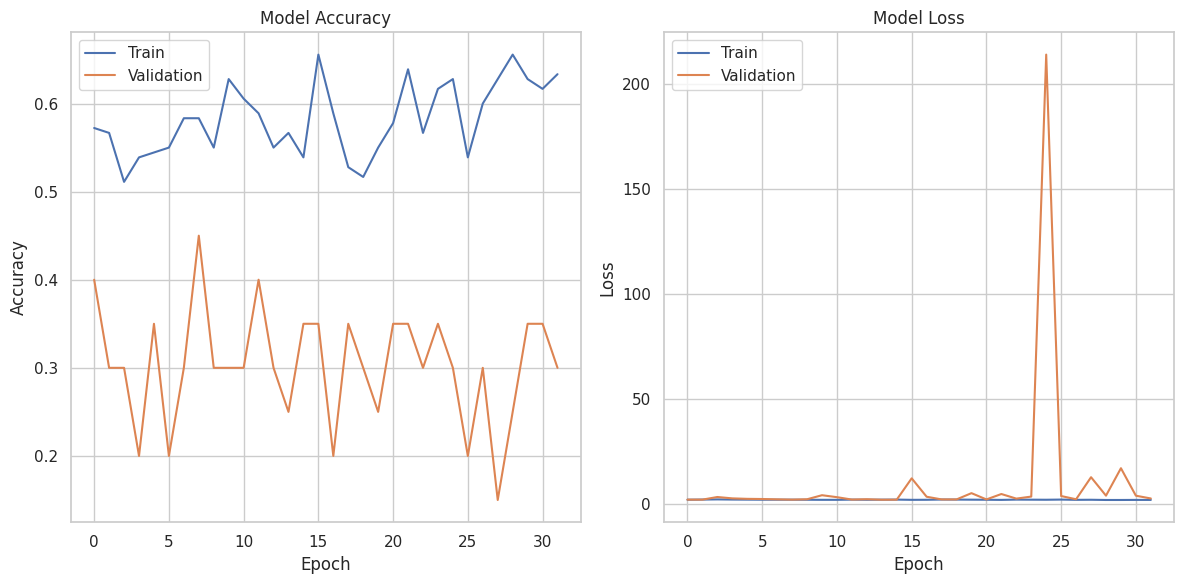

7/7 [==============================] - 0s 21ms/step
y_pred [[5.24686985e-02 3.14488947e-01 6.33042276e-01]
 [1.32799372e-01 6.90761387e-01 1.76439241e-01]
 [1.60666645e-01 6.41071916e-01 1.98261425e-01]
 [1.26404822e-01 6.48149312e-01 2.25445881e-01]
 [6.99196681e-02 3.96412939e-01 5.33667386e-01]
 [5.36752194e-02 2.49802336e-01 6.96522415e-01]
 [9.95950699e-01 6.74931332e-04 3.37427692e-03]
 [9.48210716e-01 1.21405926e-02 3.96487266e-02]
 [4.44484688e-02 2.72743642e-01 6.82807922e-01]
 [8.36053729e-01 4.75505292e-02 1.16395675e-01]
 [1.89182889e-02 2.05824301e-01 7.75257468e-01]
 [9.56115350e-02 4.30255115e-01 4.74133343e-01]
 [6.86592877e-01 1.83204398e-01 1.30202681e-01]
 [5.65372288e-01 1.88676000e-01 2.45951712e-01]
 [8.20653379e-01 5.11540212e-02 1.28192559e-01]
 [3.49043161e-02 2.13929698e-01 7.51165986e-01]
 [1.55561343e-01 5.79046965e-01 2.65391737e-01]
 [9.91301715e-01 1.71737000e-03 6.98095001e-03]
 [1.00413702e-01 4.28696871e-01 4.70889390e-01]
 [9.80267525e-01 5.93335647e-

6/6 [==============================] - 1s 248ms/step - loss: 1.9575 - sparse_categorical_accuracy: 0.6611 - val_loss: 2.3722 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.0527 - sparse_categorical_accuracy: 0.5556

6/6 [==============================] - 1s 232ms/step - loss: 2.0527 - sparse_categorical_accuracy: 0.5556 - val_loss: 3.1535 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.0015 - sparse_categorical_accuracy: 0.5833

6/6 [==============================] - 1s 230ms/step - loss: 2.0015 - sparse_categorical_accuracy: 0.5833 - val_loss: 1.9144 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.9868 - sparse_categorical_accuracy: 0.5944

6/6 [==============================] - 1s 231ms/step - loss: 1.9868 - sparse_categorical_accuracy: 0.5944 - val_loss: 29.5815 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.9625 - sparse_categorical_accuracy: 0.5944

6/6 [==============================] - 1s 227ms/step - loss: 1.9625 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.6210 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.9509 - sparse_categorical_accuracy: 0.5889

6/6 [==============================] - 1s 279ms/step - loss: 1.9509 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.4969 - val_sparse_categorical_accuracy: 0.7500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.9141 - sparse_categorical_accuracy: 0.6222

6/6 [==============================] - 2s 285ms/step - loss: 1.9141 - sparse_categorical_accuracy: 0.6222 - val_loss: 2.0661 - val_sparse_categorical_accuracy: 0.3500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.9245 - sparse_categorical_accuracy: 0.5778

6/6 [==============================] - 1s 251ms/step - loss: 1.9245 - sparse_categorical_accuracy: 0.5778 - val_loss: 1.9392 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.8851 - sparse_categorical_accuracy: 0.6111

6/6 [==============================] - 1s 224ms/step - loss: 1.8851 - sparse_categorical_accuracy: 0.6111 - val_loss: 2.1433 - val_sparse_categorical_accuracy: 0.6500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.9822 - sparse_categorical_accuracy: 0.5833

6/6 [==============================] - 1s 228ms/step - loss: 1.9822 - sparse_categorical_accuracy: 0.5833 - val_loss: 7.2054 - val_sparse_categorical_accuracy: 0.3000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.7974 - sparse_categorical_accuracy: 0.6944

6/6 [==============================] - 1s 227ms/step - loss: 1.7974 - sparse_categorical_accuracy: 0.6944 - val_loss: 2.4385 - val_sparse_categorical_accuracy: 0.4500
Epoch 12/32
5/6 [========================>.....] - ETA: 0s - loss: 1.8447 - sparse_categorical_accuracy: 0.6875

6/6 [==============================] - 1s 226ms/step - loss: 1.8326 - sparse_categorical_accuracy: 0.6667 - val_loss: 2.2194 - val_sparse_categorical_accuracy: 0.4000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.7702 - sparse_categorical_accuracy: 0.6889

6/6 [==============================] - 1s 233ms/step - loss: 1.7702 - sparse_categorical_accuracy: 0.6889 - val_loss: 2.1196 - val_sparse_categorical_accuracy: 0.5500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.8182 - sparse_categorical_accuracy: 0.6722

6/6 [==============================] - 1s 233ms/step - loss: 1.8182 - sparse_categorical_accuracy: 0.6722 - val_loss: 1.8213 - val_sparse_categorical_accuracy: 0.5000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.7797 - sparse_categorical_accuracy: 0.7333

6/6 [==============================] - 1s 232ms/step - loss: 1.7797 - sparse_categorical_accuracy: 0.7333 - val_loss: 2.2007 - val_sparse_categorical_accuracy: 0.4000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.8987 - sparse_categorical_accuracy: 0.6222

6/6 [==============================] - 1s 265ms/step - loss: 1.8987 - sparse_categorical_accuracy: 0.6222 - val_loss: 1.8906 - val_sparse_categorical_accuracy: 0.4500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.8723 - sparse_categorical_accuracy: 0.6556

6/6 [==============================] - 2s 285ms/step - loss: 1.8723 - sparse_categorical_accuracy: 0.6556 - val_loss: 1.8665 - val_sparse_categorical_accuracy: 0.5500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.7532 - sparse_categorical_accuracy: 0.7111

6/6 [==============================] - 2s 289ms/step - loss: 1.7532 - sparse_categorical_accuracy: 0.7111 - val_loss: 9.7411 - val_sparse_categorical_accuracy: 0.4500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.6476 - sparse_categorical_accuracy: 0.7611

6/6 [==============================] - 1s 228ms/step - loss: 1.6476 - sparse_categorical_accuracy: 0.7611 - val_loss: 2.4692 - val_sparse_categorical_accuracy: 0.4000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.7201 - sparse_categorical_accuracy: 0.7222

6/6 [==============================] - 1s 229ms/step - loss: 1.7201 - sparse_categorical_accuracy: 0.7222 - val_loss: 2.2021 - val_sparse_categorical_accuracy: 0.4500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.8129 - sparse_categorical_accuracy: 0.7389

6/6 [==============================] - 1s 229ms/step - loss: 1.8129 - sparse_categorical_accuracy: 0.7389 - val_loss: 2.2401 - val_sparse_categorical_accuracy: 0.4000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.6616 - sparse_categorical_accuracy: 0.7333

6/6 [==============================] - 1s 234ms/step - loss: 1.6616 - sparse_categorical_accuracy: 0.7333 - val_loss: 2.3618 - val_sparse_categorical_accuracy: 0.5000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.7196 - sparse_categorical_accuracy: 0.7111

6/6 [==============================] - 1s 239ms/step - loss: 1.7196 - sparse_categorical_accuracy: 0.7111 - val_loss: 1.8984 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.7435 - sparse_categorical_accuracy: 0.7333

6/6 [==============================] - 1s 229ms/step - loss: 1.7435 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.9704 - val_sparse_categorical_accuracy: 0.5000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.6738 - sparse_categorical_accuracy: 0.7722

6/6 [==============================] - 1s 232ms/step - loss: 1.6738 - sparse_categorical_accuracy: 0.7722 - val_loss: 2.4757 - val_sparse_categorical_accuracy: 0.4000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.6476 - sparse_categorical_accuracy: 0.7667

6/6 [==============================] - 1s 236ms/step - loss: 1.6476 - sparse_categorical_accuracy: 0.7667 - val_loss: 2.2309 - val_sparse_categorical_accuracy: 0.1000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.6515 - sparse_categorical_accuracy: 0.7889

6/6 [==============================] - 2s 298ms/step - loss: 1.6515 - sparse_categorical_accuracy: 0.7889 - val_loss: 1.9007 - val_sparse_categorical_accuracy: 0.4500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.6950 - sparse_categorical_accuracy: 0.7389

6/6 [==============================] - 2s 295ms/step - loss: 1.6950 - sparse_categorical_accuracy: 0.7389 - val_loss: 2.4125 - val_sparse_categorical_accuracy: 0.4000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.6777 - sparse_categorical_accuracy: 0.7444

6/6 [==============================] - 1s 228ms/step - loss: 1.6777 - sparse_categorical_accuracy: 0.7444 - val_loss: 2.0702 - val_sparse_categorical_accuracy: 0.5000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.7057 - sparse_categorical_accuracy: 0.7111

6/6 [==============================] - 1s 224ms/step - loss: 1.7057 - sparse_categorical_accuracy: 0.7111 - val_loss: 1.7953 - val_sparse_categorical_accuracy: 0.4500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.7146 - sparse_categorical_accuracy: 0.7333

6/6 [==============================] - 1s 228ms/step - loss: 1.7146 - sparse_categorical_accuracy: 0.7333 - val_loss: 2.2453 - val_sparse_categorical_accuracy: 0.4000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.5561 - sparse_categorical_accuracy: 0.8000

6/6 [==============================] - 1s 233ms/step - loss: 1.5561 - sparse_categorical_accuracy: 0.8000 - val_loss: 2.7525 - val_sparse_categorical_accuracy: 0.3000


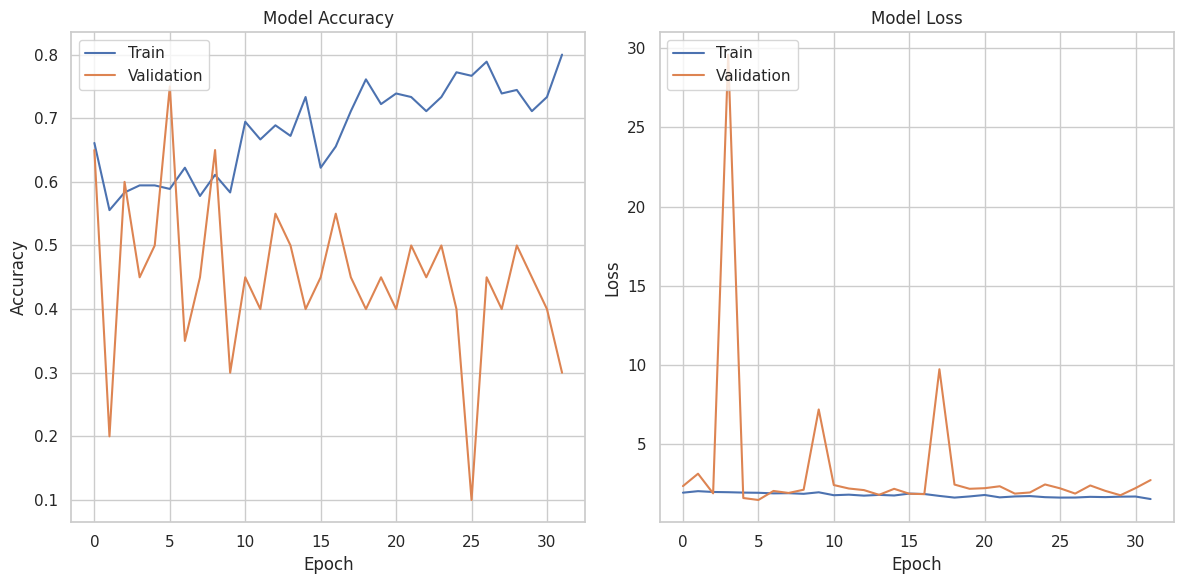

7/7 [==============================] - 0s 21ms/step
y_pred [[1.46353096e-02 4.71389890e-02 9.38225627e-01]
 [1.14691421e-01 1.48010209e-01 7.37298369e-01]
 [1.20163122e-02 1.22143529e-01 8.65840197e-01]
 [1.10255489e-02 9.05396104e-01 8.35783556e-02]
 [1.03783943e-02 2.67138444e-02 9.62907791e-01]
 [3.19552631e-03 1.38459494e-02 9.82958496e-01]
 [9.35420752e-01 2.15337966e-02 4.30455655e-02]
 [9.86291587e-01 8.70093331e-03 5.00755012e-03]
 [4.87511372e-03 1.76678635e-02 9.77456987e-01]
 [8.46657932e-01 5.53797781e-02 9.79622602e-02]
 [1.76357090e-01 5.43994665e-01 2.79648274e-01]
 [2.05691196e-02 4.63774949e-02 9.33053374e-01]
 [5.38203478e-01 1.37172952e-01 3.24623555e-01]
 [4.64353487e-02 5.52608728e-01 4.00955975e-01]
 [9.52233851e-01 2.17499677e-02 2.60161590e-02]
 [5.59316464e-02 5.78251123e-01 3.65817159e-01]
 [1.29940612e-02 3.15756723e-02 9.55430269e-01]
 [9.75635409e-01 1.13585657e-02 1.30060455e-02]
 [5.17809065e-03 1.98732987e-02 9.74948585e-01]
 [9.81969357e-01 9.72478837e-

6/6 [==============================] - 2s 255ms/step - loss: 1.7654 - sparse_categorical_accuracy: 0.7111 - val_loss: 1.4982 - val_sparse_categorical_accuracy: 0.8000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.7047 - sparse_categorical_accuracy: 0.7389

6/6 [==============================] - 1s 242ms/step - loss: 1.7047 - sparse_categorical_accuracy: 0.7389 - val_loss: 1.7039 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.7418 - sparse_categorical_accuracy: 0.7333

6/6 [==============================] - 1s 272ms/step - loss: 1.7418 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.3002 - val_sparse_categorical_accuracy: 0.8500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.6852 - sparse_categorical_accuracy: 0.7333

6/6 [==============================] - 2s 287ms/step - loss: 1.6852 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.8664 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.6024 - sparse_categorical_accuracy: 0.7778

6/6 [==============================] - 2s 294ms/step - loss: 1.6024 - sparse_categorical_accuracy: 0.7778 - val_loss: 1.3675 - val_sparse_categorical_accuracy: 0.6500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.5970 - sparse_categorical_accuracy: 0.7889

6/6 [==============================] - 1s 228ms/step - loss: 1.5970 - sparse_categorical_accuracy: 0.7889 - val_loss: 1.6226 - val_sparse_categorical_accuracy: 0.6500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.5357 - sparse_categorical_accuracy: 0.8000

6/6 [==============================] - 1s 228ms/step - loss: 1.5357 - sparse_categorical_accuracy: 0.8000 - val_loss: 1.5767 - val_sparse_categorical_accuracy: 0.7500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.6277 - sparse_categorical_accuracy: 0.7722

6/6 [==============================] - 1s 230ms/step - loss: 1.6277 - sparse_categorical_accuracy: 0.7722 - val_loss: 1.9979 - val_sparse_categorical_accuracy: 0.7000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.6383 - sparse_categorical_accuracy: 0.7833

6/6 [==============================] - 1s 232ms/step - loss: 1.6383 - sparse_categorical_accuracy: 0.7833 - val_loss: 27.2159 - val_sparse_categorical_accuracy: 0.7000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.4917 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 227ms/step - loss: 1.4917 - sparse_categorical_accuracy: 0.8444 - val_loss: 1.9103 - val_sparse_categorical_accuracy: 0.6500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.5415 - sparse_categorical_accuracy: 0.8167

6/6 [==============================] - 1s 232ms/step - loss: 1.5415 - sparse_categorical_accuracy: 0.8167 - val_loss: 1.6112 - val_sparse_categorical_accuracy: 0.5500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.5233 - sparse_categorical_accuracy: 0.8333

6/6 [==============================] - 1s 229ms/step - loss: 1.5233 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.7469 - val_sparse_categorical_accuracy: 0.6500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.5904 - sparse_categorical_accuracy: 0.7944

6/6 [==============================] - 1s 243ms/step - loss: 1.5904 - sparse_categorical_accuracy: 0.7944 - val_loss: 1.9694 - val_sparse_categorical_accuracy: 0.5500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.5705 - sparse_categorical_accuracy: 0.8056

6/6 [==============================] - 1s 279ms/step - loss: 1.5705 - sparse_categorical_accuracy: 0.8056 - val_loss: 755.0031 - val_sparse_categorical_accuracy: 0.5000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.6781 - sparse_categorical_accuracy: 0.7500

6/6 [==============================] - 2s 290ms/step - loss: 1.6781 - sparse_categorical_accuracy: 0.7500 - val_loss: 2.8093 - val_sparse_categorical_accuracy: 0.4500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.6100 - sparse_categorical_accuracy: 0.8056

6/6 [==============================] - 1s 234ms/step - loss: 1.6100 - sparse_categorical_accuracy: 0.8056 - val_loss: 2.5125 - val_sparse_categorical_accuracy: 0.4500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.5934 - sparse_categorical_accuracy: 0.7889

6/6 [==============================] - 1s 234ms/step - loss: 1.5934 - sparse_categorical_accuracy: 0.7889 - val_loss: 1.3886 - val_sparse_categorical_accuracy: 0.7000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.4341 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 234ms/step - loss: 1.4341 - sparse_categorical_accuracy: 0.8444 - val_loss: 3.1407 - val_sparse_categorical_accuracy: 0.6000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.5145 - sparse_categorical_accuracy: 0.8389

6/6 [==============================] - 1s 231ms/step - loss: 1.5145 - sparse_categorical_accuracy: 0.8389 - val_loss: 4.9965 - val_sparse_categorical_accuracy: 0.5500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.4814 - sparse_categorical_accuracy: 0.8333

6/6 [==============================] - 1s 232ms/step - loss: 1.4814 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.5885 - val_sparse_categorical_accuracy: 0.7000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.4596 - sparse_categorical_accuracy: 0.8611

6/6 [==============================] - 1s 232ms/step - loss: 1.4596 - sparse_categorical_accuracy: 0.8611 - val_loss: 1.3011 - val_sparse_categorical_accuracy: 0.7000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.4887 - sparse_categorical_accuracy: 0.8278

6/6 [==============================] - 1s 229ms/step - loss: 1.4887 - sparse_categorical_accuracy: 0.8278 - val_loss: 2.7815 - val_sparse_categorical_accuracy: 0.6000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.4278 - sparse_categorical_accuracy: 0.8222

6/6 [==============================] - 1s 228ms/step - loss: 1.4278 - sparse_categorical_accuracy: 0.8222 - val_loss: 3.1174 - val_sparse_categorical_accuracy: 0.6500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.4947 - sparse_categorical_accuracy: 0.8333

6/6 [==============================] - 2s 291ms/step - loss: 1.4947 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.8307 - val_sparse_categorical_accuracy: 0.5500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.5252 - sparse_categorical_accuracy: 0.8167

6/6 [==============================] - 2s 286ms/step - loss: 1.5252 - sparse_categorical_accuracy: 0.8167 - val_loss: 77.0546 - val_sparse_categorical_accuracy: 0.4000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.5885 - sparse_categorical_accuracy: 0.7889

6/6 [==============================] - 1s 261ms/step - loss: 1.5885 - sparse_categorical_accuracy: 0.7889 - val_loss: 1.9870 - val_sparse_categorical_accuracy: 0.5500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.6374 - sparse_categorical_accuracy: 0.8056

6/6 [==============================] - 1s 232ms/step - loss: 1.6374 - sparse_categorical_accuracy: 0.8056 - val_loss: 2.2545 - val_sparse_categorical_accuracy: 0.4500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.6096 - sparse_categorical_accuracy: 0.8111

6/6 [==============================] - 1s 240ms/step - loss: 1.6096 - sparse_categorical_accuracy: 0.8111 - val_loss: 1.7212 - val_sparse_categorical_accuracy: 0.5500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.4826 - sparse_categorical_accuracy: 0.8222

6/6 [==============================] - 1s 233ms/step - loss: 1.4826 - sparse_categorical_accuracy: 0.8222 - val_loss: 1.3818 - val_sparse_categorical_accuracy: 0.7000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.5005 - sparse_categorical_accuracy: 0.8278

6/6 [==============================] - 1s 231ms/step - loss: 1.5005 - sparse_categorical_accuracy: 0.8278 - val_loss: 2.1598 - val_sparse_categorical_accuracy: 0.5000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.4117 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 1s 233ms/step - loss: 1.4117 - sparse_categorical_accuracy: 0.8667 - val_loss: 2.8210 - val_sparse_categorical_accuracy: 0.5000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.3635 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 235ms/step - loss: 1.3635 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.8448 - val_sparse_categorical_accuracy: 0.5000


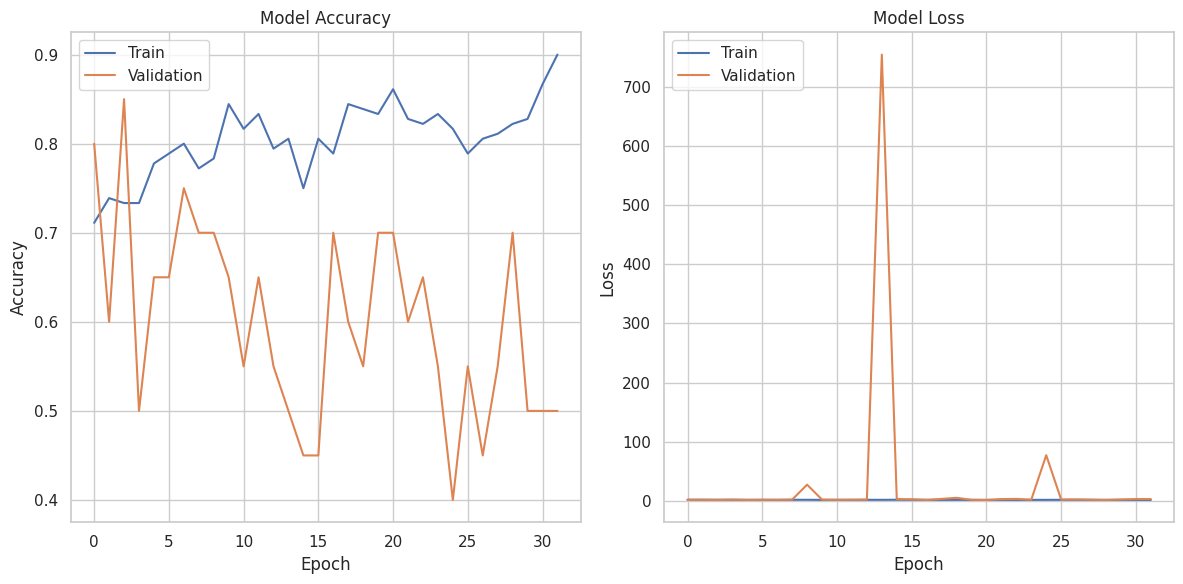

7/7 [==============================] - 0s 20ms/step
y_pred [[1.13903091e-03 9.86182213e-01 1.26787750e-02]
 [9.96141732e-01 2.56887008e-03 1.28938083e-03]
 [1.80154778e-02 9.42775786e-01 3.92086953e-02]
 [1.97100155e-02 8.81419182e-01 9.88709182e-02]
 [1.47675741e-02 9.36411798e-01 4.88206111e-02]
 [2.05205958e-02 6.67825267e-02 9.12696898e-01]
 [9.80610967e-01 6.11074315e-03 1.32783232e-02]
 [9.89134371e-01 6.45899540e-03 4.40669013e-03]
 [1.37188016e-02 4.35127765e-02 9.42768395e-01]
 [4.91636656e-02 2.55695749e-02 9.25266743e-01]
 [7.63949531e-04 3.59693259e-01 6.39542818e-01]
 [4.79098968e-03 1.35136265e-02 9.81695414e-01]
 [9.84476745e-01 7.94560742e-03 7.57766468e-03]
 [4.45053279e-01 2.21215606e-01 3.33731174e-01]
 [9.76577580e-01 7.77858449e-03 1.56439003e-02]
 [1.76130906e-01 5.77469647e-01 2.46399403e-01]
 [1.80801994e-03 9.84312117e-01 1.38798868e-02]
 [2.14486271e-02 1.49546945e-02 9.63596642e-01]
 [1.38296634e-02 2.41953414e-02 9.61975038e-01]
 [9.96033132e-01 2.44714576e-

6/6 [==============================] - 1s 251ms/step - loss: 1.5461 - sparse_categorical_accuracy: 0.8389 - val_loss: 1.4274 - val_sparse_categorical_accuracy: 0.7500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.3481 - sparse_categorical_accuracy: 0.8722

6/6 [==============================] - 1s 225ms/step - loss: 1.3481 - sparse_categorical_accuracy: 0.8722 - val_loss: 1.3878 - val_sparse_categorical_accuracy: 0.8000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.4949 - sparse_categorical_accuracy: 0.8500

6/6 [==============================] - 1s 233ms/step - loss: 1.4949 - sparse_categorical_accuracy: 0.8500 - val_loss: 1.8256 - val_sparse_categorical_accuracy: 0.7000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.4408 - sparse_categorical_accuracy: 0.8500

6/6 [==============================] - 1s 228ms/step - loss: 1.4408 - sparse_categorical_accuracy: 0.8500 - val_loss: 1.1779 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.5050 - sparse_categorical_accuracy: 0.8278

6/6 [==============================] - 1s 226ms/step - loss: 1.5050 - sparse_categorical_accuracy: 0.8278 - val_loss: 1.0326 - val_sparse_categorical_accuracy: 0.9000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.4608 - sparse_categorical_accuracy: 0.8222

6/6 [==============================] - 1s 229ms/step - loss: 1.4608 - sparse_categorical_accuracy: 0.8222 - val_loss: 2.8326 - val_sparse_categorical_accuracy: 0.5500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.4076 - sparse_categorical_accuracy: 0.8833

6/6 [==============================] - 2s 295ms/step - loss: 1.4076 - sparse_categorical_accuracy: 0.8833 - val_loss: 1.4091 - val_sparse_categorical_accuracy: 0.7500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.3945 - sparse_categorical_accuracy: 0.8722

6/6 [==============================] - 2s 293ms/step - loss: 1.3945 - sparse_categorical_accuracy: 0.8722 - val_loss: 1.4552 - val_sparse_categorical_accuracy: 0.6500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.3718 - sparse_categorical_accuracy: 0.8944

6/6 [==============================] - 1s 245ms/step - loss: 1.3718 - sparse_categorical_accuracy: 0.8944 - val_loss: 2.8498 - val_sparse_categorical_accuracy: 0.5000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.5911 - sparse_categorical_accuracy: 0.8056

6/6 [==============================] - 1s 230ms/step - loss: 1.5911 - sparse_categorical_accuracy: 0.8056 - val_loss: 1.3665 - val_sparse_categorical_accuracy: 0.7500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.2956 - sparse_categorical_accuracy: 0.9222

6/6 [==============================] - 1s 232ms/step - loss: 1.2956 - sparse_categorical_accuracy: 0.9222 - val_loss: 1.4378 - val_sparse_categorical_accuracy: 0.8000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.3274 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 228ms/step - loss: 1.3274 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.3463 - val_sparse_categorical_accuracy: 0.7500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.3248 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 229ms/step - loss: 1.3248 - sparse_categorical_accuracy: 0.9000 - val_loss: 1.2900 - val_sparse_categorical_accuracy: 0.7500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.2625 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 230ms/step - loss: 1.2625 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.9303 - val_sparse_categorical_accuracy: 0.9500
Epoch 15/32
5/6 [========================>.....] - ETA: 0s - loss: 1.3356 - sparse_categorical_accuracy: 0.9187

6/6 [==============================] - 1s 228ms/step - loss: 1.3637 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.1276 - val_sparse_categorical_accuracy: 0.7000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.3841 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 1s 232ms/step - loss: 1.3841 - sparse_categorical_accuracy: 0.9056 - val_loss: 1.8006 - val_sparse_categorical_accuracy: 0.7500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.2797 - sparse_categorical_accuracy: 0.9333

6/6 [==============================] - 1s 277ms/step - loss: 1.2797 - sparse_categorical_accuracy: 0.9333 - val_loss: 1.6491 - val_sparse_categorical_accuracy: 0.7000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.3381 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 280ms/step - loss: 1.3381 - sparse_categorical_accuracy: 0.9000 - val_loss: 1.8905 - val_sparse_categorical_accuracy: 0.7000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.3360 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 2s 296ms/step - loss: 1.3360 - sparse_categorical_accuracy: 0.9000 - val_loss: 1.3670 - val_sparse_categorical_accuracy: 0.8500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.2880 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 229ms/step - loss: 1.2880 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.2117 - val_sparse_categorical_accuracy: 0.8000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.2596 - sparse_categorical_accuracy: 0.9333

6/6 [==============================] - 1s 227ms/step - loss: 1.2596 - sparse_categorical_accuracy: 0.9333 - val_loss: 1.8140 - val_sparse_categorical_accuracy: 0.6500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.3956 - sparse_categorical_accuracy: 0.8722

6/6 [==============================] - 1s 233ms/step - loss: 1.3956 - sparse_categorical_accuracy: 0.8722 - val_loss: 2.2550 - val_sparse_categorical_accuracy: 0.6000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.4431 - sparse_categorical_accuracy: 0.8889

6/6 [==============================] - 1s 225ms/step - loss: 1.4431 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.4121 - val_sparse_categorical_accuracy: 0.6000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.3326 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 232ms/step - loss: 1.3326 - sparse_categorical_accuracy: 0.9167 - val_loss: 4.4617 - val_sparse_categorical_accuracy: 0.5000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.3610 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 235ms/step - loss: 1.3610 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.2075 - val_sparse_categorical_accuracy: 0.6500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.6136 - sparse_categorical_accuracy: 0.8333

6/6 [==============================] - 1s 231ms/step - loss: 1.6136 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.6520 - val_sparse_categorical_accuracy: 0.7000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.3856 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 241ms/step - loss: 1.3856 - sparse_categorical_accuracy: 0.9000 - val_loss: 1.4423 - val_sparse_categorical_accuracy: 0.6500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.3275 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 2s 294ms/step - loss: 1.3275 - sparse_categorical_accuracy: 0.9056 - val_loss: 1.7358 - val_sparse_categorical_accuracy: 0.6500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.2926 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 2s 293ms/step - loss: 1.2926 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.8240 - val_sparse_categorical_accuracy: 0.6000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.3845 - sparse_categorical_accuracy: 0.8833

6/6 [==============================] - 1s 231ms/step - loss: 1.3845 - sparse_categorical_accuracy: 0.8833 - val_loss: 4.9816 - val_sparse_categorical_accuracy: 0.6000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.2912 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 229ms/step - loss: 1.2912 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.5749 - val_sparse_categorical_accuracy: 0.8000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.2467 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 227ms/step - loss: 1.2467 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.7485 - val_sparse_categorical_accuracy: 0.6500


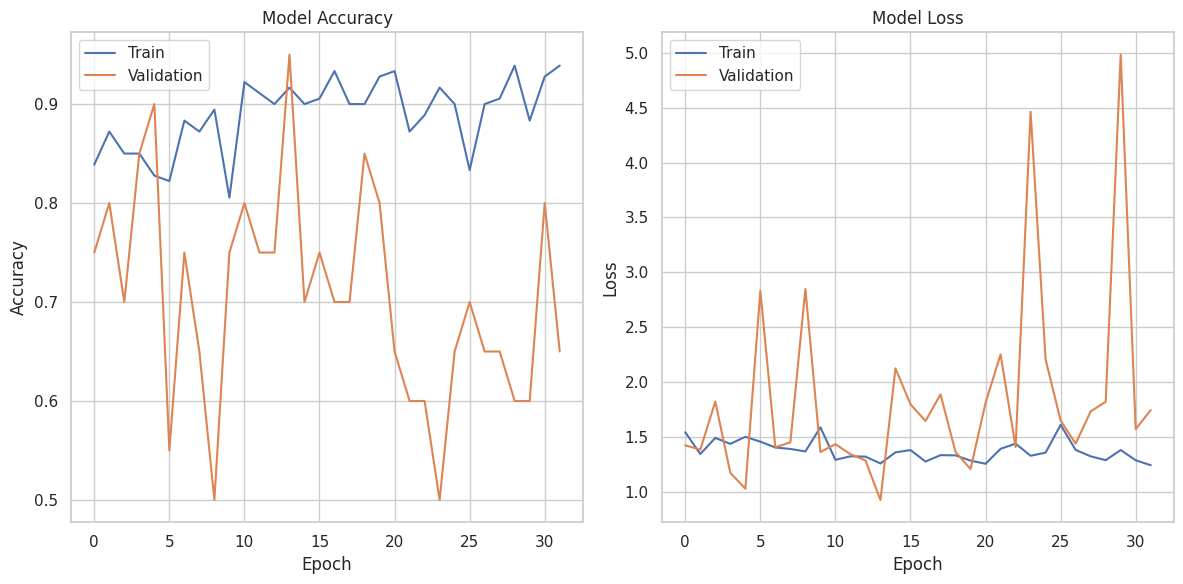

7/7 [==============================] - 0s 21ms/step
y_pred [[3.74560729e-02 7.37042785e-01 2.25501209e-01]
 [9.91233885e-01 3.56329628e-03 5.20292204e-03]
 [2.13884423e-03 9.81401861e-01 1.64592676e-02]
 [1.33215566e-03 9.88711596e-01 9.95620713e-03]
 [3.74149968e-04 8.65803391e-04 9.98760104e-01]
 [3.09215015e-04 4.57609887e-04 9.99233127e-01]
 [9.61918116e-01 1.29274791e-02 2.51543857e-02]
 [6.11846328e-01 1.57528520e-01 2.30625108e-01]
 [3.09745898e-04 3.55361553e-04 9.99334872e-01]
 [1.13079630e-01 5.01105264e-02 8.36809874e-01]
 [5.48994740e-06 1.71187086e-04 9.99823391e-01]
 [7.98806141e-04 2.01480859e-03 9.97186363e-01]
 [7.14921415e-01 6.36525899e-02 2.21425965e-01]
 [7.05852406e-04 9.60772991e-01 3.85211371e-02]
 [9.58565712e-01 1.43914362e-02 2.70428881e-02]
 [1.51463808e-03 5.68835795e-01 4.29649621e-01]
 [1.01182470e-03 9.87871408e-01 1.11167869e-02]
 [8.83057117e-01 3.92616950e-02 7.76811466e-02]
 [4.48617386e-04 8.27641750e-04 9.98723686e-01]
 [1.07445672e-01 2.76565924e-

6/6 [==============================] - 2s 333ms/step - loss: 1.3886 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.7331 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.2700 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 2s 301ms/step - loss: 1.2700 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.2426 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 229ms/step - loss: 1.2426 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.1626 - val_sparse_categorical_accuracy: 0.9000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.3089 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 231ms/step - loss: 1.3089 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.1950 - val_sparse_categorical_accuracy: 0.9000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.2861 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 228ms/step - loss: 1.2861 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.1594 - val_sparse_categorical_accuracy: 0.8500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.2965 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 231ms/step - loss: 1.2965 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.9674 - val_sparse_categorical_accuracy: 0.8500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.3246 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 233ms/step - loss: 1.3246 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.4020 - val_sparse_categorical_accuracy: 0.6000
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.4142 - sparse_categorical_accuracy: 0.8833

6/6 [==============================] - 1s 229ms/step - loss: 1.4142 - sparse_categorical_accuracy: 0.8833 - val_loss: 2.2694 - val_sparse_categorical_accuracy: 0.7000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.3618 - sparse_categorical_accuracy: 0.8722

6/6 [==============================] - 1s 229ms/step - loss: 1.3618 - sparse_categorical_accuracy: 0.8722 - val_loss: 1.7780 - val_sparse_categorical_accuracy: 0.7000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.2194 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 232ms/step - loss: 1.2194 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.1633 - val_sparse_categorical_accuracy: 0.8500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.2208 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 282ms/step - loss: 1.2208 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.6531 - val_sparse_categorical_accuracy: 0.7000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.3350 - sparse_categorical_accuracy: 0.9333

6/6 [==============================] - 1s 284ms/step - loss: 1.3350 - sparse_categorical_accuracy: 0.9333 - val_loss: 1.2849 - val_sparse_categorical_accuracy: 0.8000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.2103 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 273ms/step - loss: 1.2103 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.2388 - val_sparse_categorical_accuracy: 0.8500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.3040 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 232ms/step - loss: 1.3040 - sparse_categorical_accuracy: 0.9389 - val_loss: 5.8303 - val_sparse_categorical_accuracy: 0.6500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.1619 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 1s 231ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.9000 - val_sparse_categorical_accuracy: 0.7000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.1510 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 1s 226ms/step - loss: 1.1510 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.8658 - val_sparse_categorical_accuracy: 0.9500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.1731 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 230ms/step - loss: 1.1731 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.2140 - val_sparse_categorical_accuracy: 0.8500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.1186 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 231ms/step - loss: 1.1186 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.1462 - val_sparse_categorical_accuracy: 0.9000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.2589 - sparse_categorical_accuracy: 0.9222

6/6 [==============================] - 1s 228ms/step - loss: 1.2589 - sparse_categorical_accuracy: 0.9222 - val_loss: 3.4882 - val_sparse_categorical_accuracy: 0.6000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.2205 - sparse_categorical_accuracy: 0.9556

6/6 [==============================] - 1s 227ms/step - loss: 1.2205 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.9000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.3939 - sparse_categorical_accuracy: 0.8778

6/6 [==============================] - 1s 259ms/step - loss: 1.3939 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.2103 - val_sparse_categorical_accuracy: 0.7500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.3246 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 2s 287ms/step - loss: 1.3246 - sparse_categorical_accuracy: 0.9278 - val_loss: 1296.2593 - val_sparse_categorical_accuracy: 0.6000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.1992 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 2s 314ms/step - loss: 1.1992 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.0920 - val_sparse_categorical_accuracy: 0.8500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.1966 - sparse_categorical_accuracy: 0.9556

6/6 [==============================] - 1s 234ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.4441 - val_sparse_categorical_accuracy: 0.5000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.2975 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 229ms/step - loss: 1.2975 - sparse_categorical_accuracy: 0.9278 - val_loss: 3.0628 - val_sparse_categorical_accuracy: 0.4500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.2780 - sparse_categorical_accuracy: 0.9333

6/6 [==============================] - 1s 225ms/step - loss: 1.2780 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.2346 - val_sparse_categorical_accuracy: 0.5500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.2799 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 229ms/step - loss: 1.2799 - sparse_categorical_accuracy: 0.9444 - val_loss: 1.7208 - val_sparse_categorical_accuracy: 0.8500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.2809 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 240ms/step - loss: 1.2809 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.2101 - val_sparse_categorical_accuracy: 0.8500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.2272 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 239ms/step - loss: 1.2272 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.9856 - val_sparse_categorical_accuracy: 0.7000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.2668 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 229ms/step - loss: 1.2668 - sparse_categorical_accuracy: 0.9444 - val_loss: 1.7565 - val_sparse_categorical_accuracy: 0.7000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.2785 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 242ms/step - loss: 1.2785 - sparse_categorical_accuracy: 0.9167 - val_loss: 1.9390 - val_sparse_categorical_accuracy: 0.6500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.1877 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 2s 292ms/step - loss: 1.1877 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.7370 - val_sparse_categorical_accuracy: 0.7500


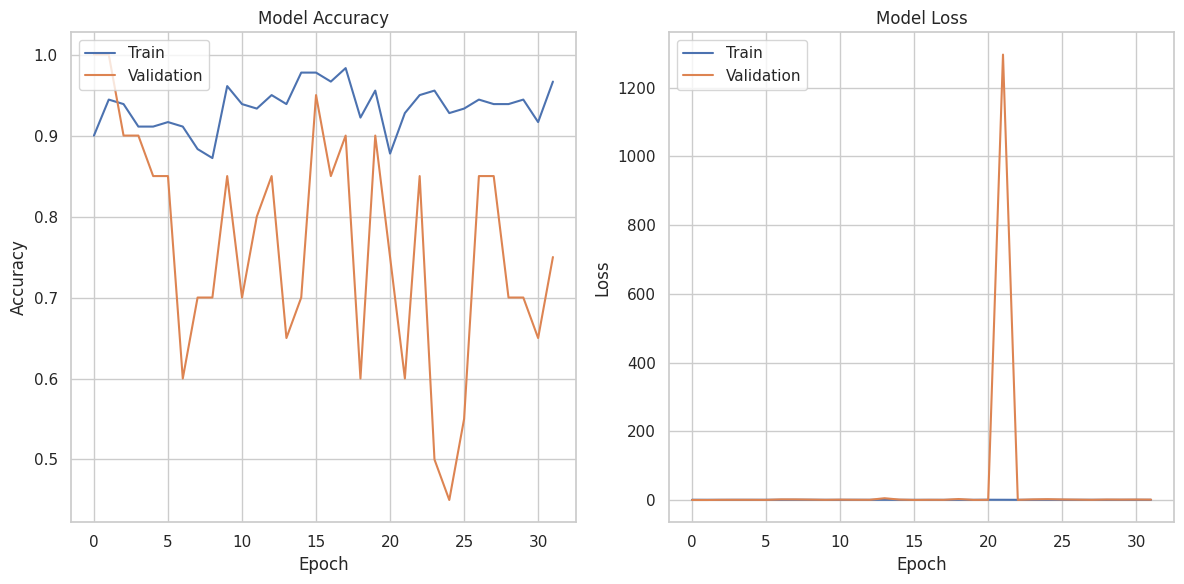

7/7 [==============================] - 0s 20ms/step
y_pred [[1.17292274e-02 3.61434892e-02 9.52127278e-01]
 [1.74765252e-02 9.56769228e-01 2.57542916e-02]
 [6.19880520e-05 9.99246120e-01 6.91931753e-04]
 [1.00191835e-04 9.98791277e-01 1.10867154e-03]
 [1.47229098e-02 1.20231383e-01 8.65045726e-01]
 [1.53373228e-03 6.69802539e-04 9.97796535e-01]
 [4.50611293e-01 4.06428128e-01 1.42960519e-01]
 [7.79531419e-01 1.37624472e-01 8.28440711e-02]
 [2.40120858e-01 1.56769957e-02 7.44202137e-01]
 [6.24803687e-03 1.05837837e-01 8.87914121e-01]
 [8.55876319e-03 8.85279663e-03 9.82588410e-01]
 [2.60566548e-03 6.48571411e-03 9.90908563e-01]
 [1.68799534e-01 1.61143988e-01 6.70056462e-01]
 [1.41116187e-01 2.21412137e-01 6.37471676e-01]
 [9.49854851e-01 1.57661345e-02 3.43790650e-02]
 [1.90251376e-04 9.97035742e-01 2.77403090e-03]
 [1.02206453e-04 9.98692334e-01 1.20559346e-03]
 [1.14853960e-02 1.66498348e-02 9.71864760e-01]
 [5.47941122e-03 2.20853463e-02 9.72435296e-01]
 [9.74490702e-01 8.47351365e-

6/6 [==============================] - 1s 251ms/step - loss: 1.2300 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.8331 - val_sparse_categorical_accuracy: 0.9500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.1860 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 226ms/step - loss: 1.1860 - sparse_categorical_accuracy: 0.9500 - val_loss: 2.5709 - val_sparse_categorical_accuracy: 0.9500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.1965 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 230ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0138 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.2270 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 231ms/step - loss: 1.2270 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.8479 - val_sparse_categorical_accuracy: 0.9500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.1646 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 2s 286ms/step - loss: 1.1646 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.8189 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.1317 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 2s 296ms/step - loss: 1.1317 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.7521 - val_sparse_categorical_accuracy: 1.0000
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.1012 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 259ms/step - loss: 1.1012 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.7716 - val_sparse_categorical_accuracy: 0.9500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.1130 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 233ms/step - loss: 1.1130 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.9072 - val_sparse_categorical_accuracy: 0.9000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.1097 - sparse_categorical_accuracy: 0.9889

6/6 [==============================] - 1s 238ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.9000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.1444 - sparse_categorical_accuracy: 0.9556

6/6 [==============================] - 1s 230ms/step - loss: 1.1444 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.8524 - val_sparse_categorical_accuracy: 0.9500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.2094 - sparse_categorical_accuracy: 0.9556

6/6 [==============================] - 1s 231ms/step - loss: 1.2094 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.1219 - val_sparse_categorical_accuracy: 0.8500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.0983 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 229ms/step - loss: 1.0983 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.8078 - val_sparse_categorical_accuracy: 0.9500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.1543 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 232ms/step - loss: 1.1543 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.2860 - val_sparse_categorical_accuracy: 0.7500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.1048 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 1s 233ms/step - loss: 1.1048 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.2285 - val_sparse_categorical_accuracy: 0.9000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.1028 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 265ms/step - loss: 1.1028 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.9263 - val_sparse_categorical_accuracy: 0.9500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.1879 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 281ms/step - loss: 1.1879 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.2717 - val_sparse_categorical_accuracy: 0.9000
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.1709 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 283ms/step - loss: 1.1709 - sparse_categorical_accuracy: 0.9444 - val_loss: 7.4224 - val_sparse_categorical_accuracy: 0.4500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.1577 - sparse_categorical_accuracy: 0.9722

6/6 [==============================] - 1s 232ms/step - loss: 1.1577 - sparse_categorical_accuracy: 0.9722 - val_loss: 2.6256 - val_sparse_categorical_accuracy: 0.6500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.3078 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 1s 228ms/step - loss: 1.3078 - sparse_categorical_accuracy: 0.9056 - val_loss: 2.7082 - val_sparse_categorical_accuracy: 0.6000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.1302 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 233ms/step - loss: 1.1302 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.7936 - val_sparse_categorical_accuracy: 0.8500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.1709 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 234ms/step - loss: 1.1709 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.1084 - val_sparse_categorical_accuracy: 0.8000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.1528 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 234ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.9833 - val_loss: 5.6810 - val_sparse_categorical_accuracy: 0.8500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.1380 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 226ms/step - loss: 1.1380 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.6594 - val_sparse_categorical_accuracy: 0.7500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.1726 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 235ms/step - loss: 1.1726 - sparse_categorical_accuracy: 0.9667 - val_loss: 3.1061 - val_sparse_categorical_accuracy: 0.7500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.1976 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 251ms/step - loss: 1.1976 - sparse_categorical_accuracy: 0.9611 - val_loss: 6.7183 - val_sparse_categorical_accuracy: 0.8500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.1873 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 2s 297ms/step - loss: 1.1873 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.6989 - val_sparse_categorical_accuracy: 0.7500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.1974 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 2s 299ms/step - loss: 1.1974 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.8031 - val_sparse_categorical_accuracy: 0.9500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.1678 - sparse_categorical_accuracy: 0.9556

6/6 [==============================] - 1s 230ms/step - loss: 1.1678 - sparse_categorical_accuracy: 0.9556 - val_loss: 3.2503 - val_sparse_categorical_accuracy: 0.7500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.1676 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 232ms/step - loss: 1.1676 - sparse_categorical_accuracy: 0.9611 - val_loss: 2.9071 - val_sparse_categorical_accuracy: 0.7500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.1712 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 238ms/step - loss: 1.1712 - sparse_categorical_accuracy: 0.9667 - val_loss: 3.2477 - val_sparse_categorical_accuracy: 0.7000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.1422 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 1s 222ms/step - loss: 1.1422 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.8565 - val_sparse_categorical_accuracy: 1.0000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.1622 - sparse_categorical_accuracy: 0.9722

6/6 [==============================] - 1s 231ms/step - loss: 1.1622 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.9013 - val_sparse_categorical_accuracy: 0.9000


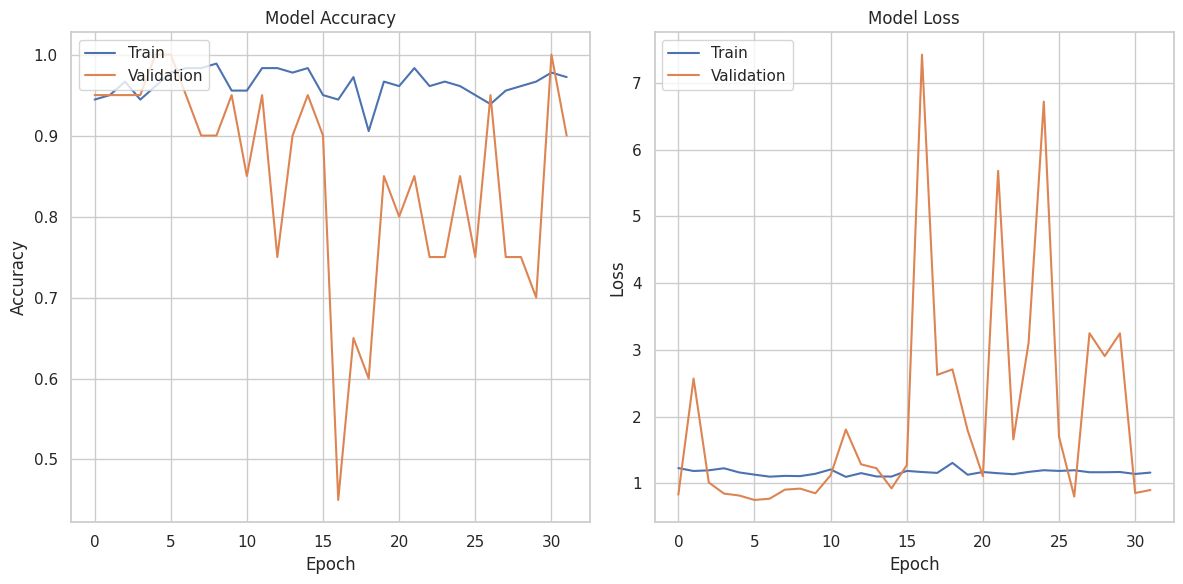

7/7 [==============================] - 0s 20ms/step
y_pred [[8.22840200e-04 3.57646612e-03 9.95600700e-01]
 [9.35734272e-01 4.08408679e-02 2.34249458e-02]
 [2.12968109e-04 9.98462439e-01 1.32462732e-03]
 [4.18964587e-03 9.67413187e-01 2.83972416e-02]
 [4.12417285e-04 5.93868433e-04 9.98993695e-01]
 [4.48689971e-04 5.44044247e-04 9.99007285e-01]
 [9.97937560e-01 5.22224000e-04 1.54022221e-03]
 [9.94981825e-01 7.23109464e-04 4.29514516e-03]
 [3.64155043e-04 9.45623906e-05 9.99541283e-01]
 [1.90222767e-04 2.65149487e-04 9.99544561e-01]
 [1.62968319e-02 3.60328369e-02 9.47670341e-01]
 [9.03489720e-03 2.34908029e-03 9.88616049e-01]
 [9.99114335e-01 2.71007069e-04 6.14657358e-04]
 [1.45112772e-05 9.99833584e-01 1.51906643e-04]
 [9.99943614e-01 2.64914961e-05 2.99763124e-05]
 [3.98425123e-04 9.84479129e-01 1.51223904e-02]
 [2.71650442e-05 9.99661207e-01 3.11620912e-04]
 [9.98964906e-01 3.54093005e-04 6.81093836e-04]
 [1.92651327e-03 9.31996445e-04 9.97141421e-01]
 [9.64296460e-01 4.92547546e-

6/6 [==============================] - 1s 248ms/step - loss: 1.1655 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.3057 - val_sparse_categorical_accuracy: 0.8500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.2643 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 258ms/step - loss: 1.2643 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.0240 - val_sparse_categorical_accuracy: 0.8500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.1809 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 2s 288ms/step - loss: 1.1809 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.3395 - val_sparse_categorical_accuracy: 0.8000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.2348 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 2s 310ms/step - loss: 1.2348 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.9135 - val_sparse_categorical_accuracy: 0.7500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.2210 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 234ms/step - loss: 1.2210 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.7990 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.3591 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 1s 231ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.9056 - val_loss: 1.4242 - val_sparse_categorical_accuracy: 0.8500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.1530 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 233ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.3222 - val_sparse_categorical_accuracy: 0.7500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.3226 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 232ms/step - loss: 1.3226 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.9935 - val_sparse_categorical_accuracy: 0.9000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.1470 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 227ms/step - loss: 1.1470 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.6073 - val_sparse_categorical_accuracy: 0.8500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.2179 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 238ms/step - loss: 1.2179 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.0435 - val_sparse_categorical_accuracy: 0.8000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.1986 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 228ms/step - loss: 1.1986 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.2975 - val_sparse_categorical_accuracy: 0.8000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.1789 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 236ms/step - loss: 1.1789 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.9952 - val_sparse_categorical_accuracy: 0.9500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.2109 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 2s 286ms/step - loss: 1.2109 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.0732 - val_sparse_categorical_accuracy: 0.8500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.2266 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 2s 302ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.9500 - val_loss: 2.8084 - val_sparse_categorical_accuracy: 0.5500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.2349 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 1s 237ms/step - loss: 1.2349 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.2435 - val_sparse_categorical_accuracy: 0.8000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.2013 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 236ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.9444 - val_loss: 1.7081 - val_sparse_categorical_accuracy: 0.7500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.2358 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 227ms/step - loss: 1.2358 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.7098 - val_sparse_categorical_accuracy: 0.8000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.1946 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 233ms/step - loss: 1.1946 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.8500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.2341 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 234ms/step - loss: 1.2341 - sparse_categorical_accuracy: 0.9278 - val_loss: 2.0678 - val_sparse_categorical_accuracy: 0.6000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.2200 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 234ms/step - loss: 1.2200 - sparse_categorical_accuracy: 0.9389 - val_loss: 3.9597 - val_sparse_categorical_accuracy: 0.6500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.1749 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 1s 233ms/step - loss: 1.1749 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.9000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.2213 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 228ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.4897 - val_sparse_categorical_accuracy: 0.8500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.1562 - sparse_categorical_accuracy: 0.9778

6/6 [==============================] - 2s 286ms/step - loss: 1.1562 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.3209 - val_sparse_categorical_accuracy: 0.9000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.1505 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 282ms/step - loss: 1.1505 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0671 - val_sparse_categorical_accuracy: 0.8500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.2066 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 266ms/step - loss: 1.2066 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.5341 - val_sparse_categorical_accuracy: 0.8500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.1719 - sparse_categorical_accuracy: 0.9556

6/6 [==============================] - 1s 234ms/step - loss: 1.1719 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.9198 - val_sparse_categorical_accuracy: 0.7500
Epoch 27/32
5/6 [========================>.....] - ETA: 0s - loss: 1.2169 - sparse_categorical_accuracy: 0.9625

6/6 [==============================] - 1s 223ms/step - loss: 1.1736 - sparse_categorical_accuracy: 0.9611 - val_loss: 2.5619 - val_sparse_categorical_accuracy: 0.7000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.1762 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 1s 232ms/step - loss: 1.1762 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.1401 - val_sparse_categorical_accuracy: 0.8500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.1441 - sparse_categorical_accuracy: 0.9833

6/6 [==============================] - 1s 231ms/step - loss: 1.1441 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.1378 - val_sparse_categorical_accuracy: 0.8500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.1256 - sparse_categorical_accuracy: 0.9889

6/6 [==============================] - 1s 237ms/step - loss: 1.1256 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.2701 - val_sparse_categorical_accuracy: 0.9000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.2154 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 233ms/step - loss: 1.2154 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.3904 - val_sparse_categorical_accuracy: 0.6000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.0826 - sparse_categorical_accuracy: 0.9944

6/6 [==============================] - 1s 228ms/step - loss: 1.0826 - sparse_categorical_accuracy: 0.9944 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.8000


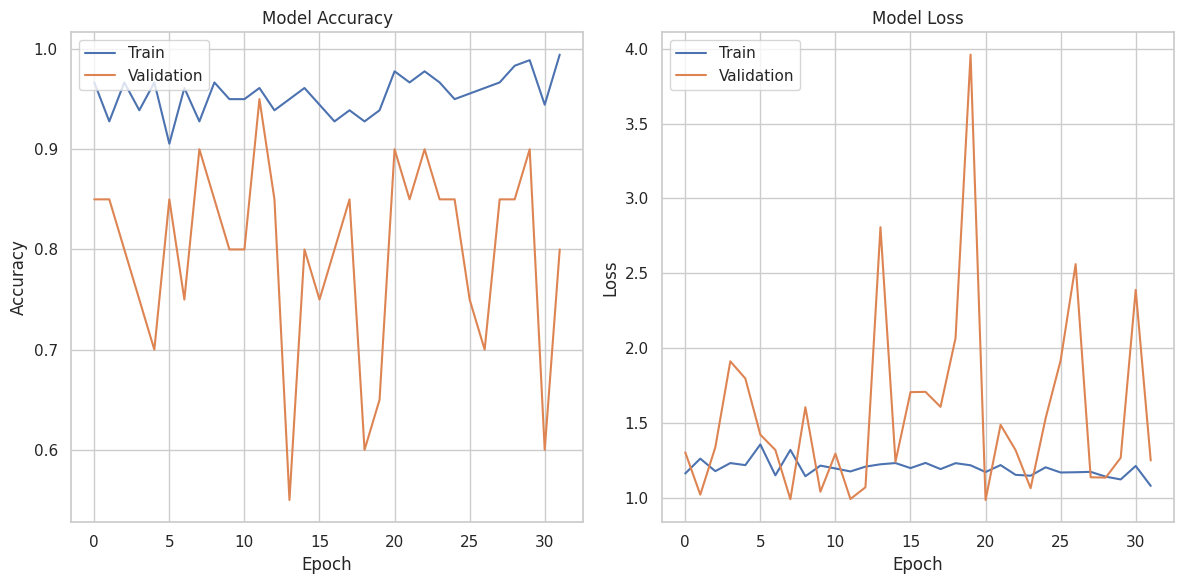

7/7 [==============================] - 0s 20ms/step
y_pred [[1.00080535e-04 3.39276245e-04 9.99560654e-01]
 [9.99907970e-01 5.16198925e-05 4.04222010e-05]
 [1.23885379e-03 9.94623899e-01 4.13727434e-03]
 [4.19199583e-04 9.97068584e-01 2.51223845e-03]
 [3.90689733e-04 5.94183628e-04 9.99015093e-01]
 [1.88969206e-02 2.39823923e-01 7.41279185e-01]
 [9.99081373e-01 5.67259558e-04 3.51372059e-04]
 [9.99942541e-01 2.67508021e-05 3.07765986e-05]
 [3.16684862e-04 6.48547953e-04 9.99034762e-01]
 [3.55779011e-05 7.41390395e-05 9.99890327e-01]
 [1.09776565e-05 1.62394499e-05 9.99972820e-01]
 [8.68624169e-03 1.21043483e-02 9.79209423e-01]
 [9.99577940e-01 2.15013119e-04 2.07042089e-04]
 [1.69529617e-02 9.67138350e-01 1.59086585e-02]
 [9.95313287e-01 2.08021444e-03 2.60657212e-03]
 [6.67228876e-03 9.92030621e-01 1.29712385e-03]
 [1.68650833e-04 9.97841477e-01 1.98981422e-03]
 [9.99616504e-01 2.27194963e-04 1.56198410e-04]
 [1.56729319e-03 3.04657407e-03 9.95386183e-01]
 [9.95758116e-01 2.71718041e-

6/6 [==============================] - 1s 245ms/step - loss: 2.8046 - sparse_categorical_accuracy: 0.3944 - val_loss: 4.4545 - val_sparse_categorical_accuracy: 0.3500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.6601 - sparse_categorical_accuracy: 0.4278

6/6 [==============================] - 1s 248ms/step - loss: 2.6601 - sparse_categorical_accuracy: 0.4278 - val_loss: 345.3761 - val_sparse_categorical_accuracy: 0.1500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.6968 - sparse_categorical_accuracy: 0.4278

6/6 [==============================] - 1s 236ms/step - loss: 2.6968 - sparse_categorical_accuracy: 0.4278 - val_loss: 2.0860 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.6515 - sparse_categorical_accuracy: 0.4222

6/6 [==============================] - 1s 234ms/step - loss: 2.6515 - sparse_categorical_accuracy: 0.4222 - val_loss: 2.1549 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.5946 - sparse_categorical_accuracy: 0.4389

6/6 [==============================] - 1s 233ms/step - loss: 2.5946 - sparse_categorical_accuracy: 0.4389 - val_loss: 5.4102 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.5388 - sparse_categorical_accuracy: 0.4500

6/6 [==============================] - 1s 284ms/step - loss: 2.5388 - sparse_categorical_accuracy: 0.4500 - val_loss: 2.2449 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.5316 - sparse_categorical_accuracy: 0.4389

6/6 [==============================] - 2s 293ms/step - loss: 2.5316 - sparse_categorical_accuracy: 0.4389 - val_loss: 2.0181 - val_sparse_categorical_accuracy: 0.5000
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.4954 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 264ms/step - loss: 2.4954 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.9674 - val_sparse_categorical_accuracy: 0.5000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.5181 - sparse_categorical_accuracy: 0.4500

6/6 [==============================] - 1s 231ms/step - loss: 2.5181 - sparse_categorical_accuracy: 0.4500 - val_loss: 2.1106 - val_sparse_categorical_accuracy: 0.4500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.4685 - sparse_categorical_accuracy: 0.4500

6/6 [==============================] - 1s 225ms/step - loss: 2.4685 - sparse_categorical_accuracy: 0.4500 - val_loss: 94.7610 - val_sparse_categorical_accuracy: 0.4500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.4821 - sparse_categorical_accuracy: 0.4667

6/6 [==============================] - 1s 233ms/step - loss: 2.4821 - sparse_categorical_accuracy: 0.4667 - val_loss: 2.0125 - val_sparse_categorical_accuracy: 0.5000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.3663 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 236ms/step - loss: 2.3663 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.9333 - val_sparse_categorical_accuracy: 0.5000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.4099 - sparse_categorical_accuracy: 0.4667

6/6 [==============================] - 1s 229ms/step - loss: 2.4099 - sparse_categorical_accuracy: 0.4667 - val_loss: 1.9958 - val_sparse_categorical_accuracy: 0.5000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.4747 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 230ms/step - loss: 2.4747 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.4296 - val_sparse_categorical_accuracy: 0.4000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.4222 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 234ms/step - loss: 2.4222 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.9100 - val_sparse_categorical_accuracy: 0.5000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.3982 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 271ms/step - loss: 2.3982 - sparse_categorical_accuracy: 0.4944 - val_loss: 2.0592 - val_sparse_categorical_accuracy: 0.5000
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.3565 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 2s 295ms/step - loss: 2.3565 - sparse_categorical_accuracy: 0.5000 - val_loss: 17.4763 - val_sparse_categorical_accuracy: 0.4000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.3759 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 2s 293ms/step - loss: 2.3759 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.9670 - val_sparse_categorical_accuracy: 0.5000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.3966 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 226ms/step - loss: 2.3966 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.9530 - val_sparse_categorical_accuracy: 0.5000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.4568 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 230ms/step - loss: 2.4568 - sparse_categorical_accuracy: 0.4944 - val_loss: 1.9238 - val_sparse_categorical_accuracy: 0.5000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.3919 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 232ms/step - loss: 2.3919 - sparse_categorical_accuracy: 0.4944 - val_loss: 2.3997 - val_sparse_categorical_accuracy: 0.4000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.3480 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 238ms/step - loss: 2.3480 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.9336 - val_sparse_categorical_accuracy: 0.4000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.4399 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 229ms/step - loss: 2.4399 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.1483 - val_sparse_categorical_accuracy: 0.4000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.3936 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 231ms/step - loss: 2.3936 - sparse_categorical_accuracy: 0.4778 - val_loss: 7.0383 - val_sparse_categorical_accuracy: 0.4000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.4583 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 233ms/step - loss: 2.4583 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.5608 - val_sparse_categorical_accuracy: 0.5000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.3555 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 260ms/step - loss: 2.3555 - sparse_categorical_accuracy: 0.4889 - val_loss: 15.3009 - val_sparse_categorical_accuracy: 0.5000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.3695 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 2s 293ms/step - loss: 2.3695 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.5243 - val_sparse_categorical_accuracy: 0.5000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.3338 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 2s 294ms/step - loss: 2.3338 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.2186 - val_sparse_categorical_accuracy: 0.5000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.3493 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 235ms/step - loss: 2.3493 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.0494 - val_sparse_categorical_accuracy: 0.5000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.3888 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 230ms/step - loss: 2.3888 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.9945 - val_sparse_categorical_accuracy: 0.5000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.3430 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 238ms/step - loss: 2.3430 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.9929 - val_sparse_categorical_accuracy: 0.5000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.3527 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 233ms/step - loss: 2.3527 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.9298 - val_sparse_categorical_accuracy: 0.5000


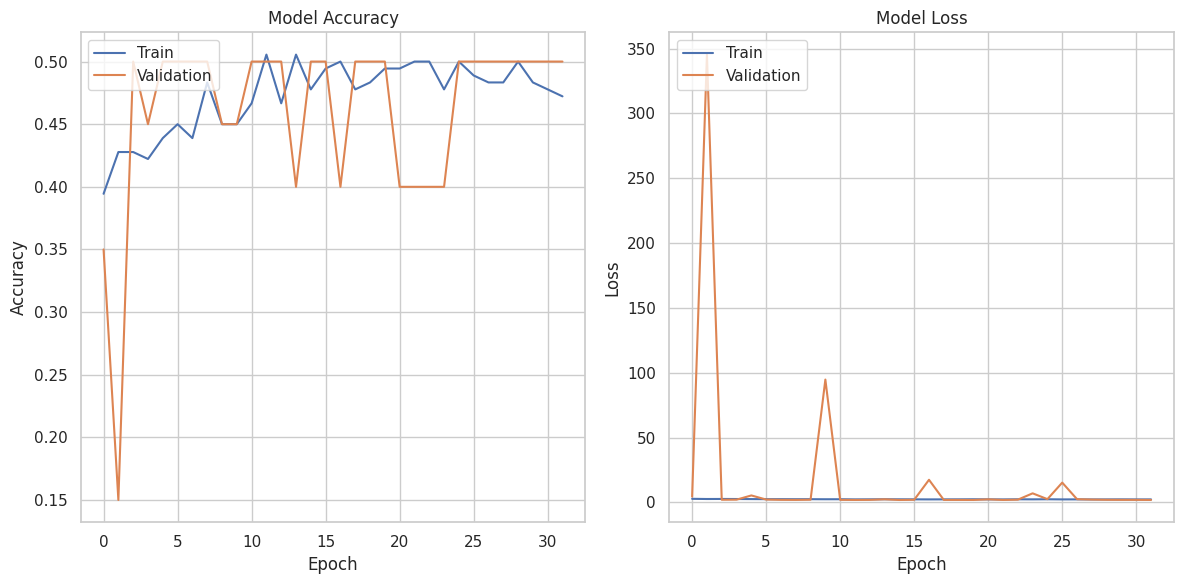

7/7 [==============================] - 0s 23ms/step
y_pred [[5.79445124e-01 1.32705405e-01 1.13000274e-01 1.74849153e-01]
 [5.64640999e-01 1.39054507e-01 1.01367436e-01 1.94937021e-01]
 [5.61774671e-01 9.42218751e-02 1.85257927e-01 1.58745483e-01]
 [3.26248527e-01 1.84346035e-01 3.13553065e-01 1.75852403e-01]
 [4.45242435e-01 1.83670074e-01 2.26975948e-01 1.44111589e-01]
 [3.92078668e-01 1.59186214e-01 2.66922742e-01 1.81812391e-01]
 [7.38066137e-01 1.24245591e-01 7.55478069e-02 6.21404648e-02]
 [7.62524247e-01 1.14800401e-01 6.19332157e-02 6.07420951e-02]
 [4.68345523e-01 1.70584500e-01 2.27366313e-01 1.33703619e-01]
 [7.59214818e-01 1.17894001e-01 6.20176122e-02 6.08735159e-02]
 [9.86103177e-01 3.09433672e-04 5.24691492e-03 8.34054407e-03]
 [5.24118364e-01 1.04159079e-01 2.16848165e-01 1.54874384e-01]
 [5.88249028e-01 1.22122034e-01 9.15547535e-02 1.98074117e-01]
 [7.48677611e-01 3.35402638e-02 1.47537425e-01 7.02447295e-02]
 [5.92780948e-01 1.37443364e-01 1.26146361e-01 1.43629298e-

6/6 [==============================] - 2s 309ms/step - loss: 2.3323 - sparse_categorical_accuracy: 0.4944 - val_loss: 3.0486 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.2965 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 265ms/step - loss: 2.2965 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.0866 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.3003 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 238ms/step - loss: 2.3003 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.0082 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.3371 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 229ms/step - loss: 2.3371 - sparse_categorical_accuracy: 0.5111 - val_loss: 28.9965 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.3503 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 230ms/step - loss: 2.3503 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.0943 - val_sparse_categorical_accuracy: 0.4000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.3170 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 233ms/step - loss: 2.3170 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.0208 - val_sparse_categorical_accuracy: 0.4000
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.3329 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 229ms/step - loss: 2.3329 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.0648 - val_sparse_categorical_accuracy: 0.4000
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.2776 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 234ms/step - loss: 2.2776 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.9987 - val_sparse_categorical_accuracy: 0.4000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.3221 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 230ms/step - loss: 2.3221 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.0671 - val_sparse_categorical_accuracy: 0.4000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.2851 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 265ms/step - loss: 2.2851 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.0212 - val_sparse_categorical_accuracy: 0.4000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.3525 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 301ms/step - loss: 2.3525 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.1757 - val_sparse_categorical_accuracy: 0.4000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.2505 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 296ms/step - loss: 2.2505 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.0109 - val_sparse_categorical_accuracy: 0.4000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.3425 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 225ms/step - loss: 2.3425 - sparse_categorical_accuracy: 0.5167 - val_loss: 9.5926 - val_sparse_categorical_accuracy: 0.4000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.2967 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 228ms/step - loss: 2.2967 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.0734 - val_sparse_categorical_accuracy: 0.4000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.3170 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 231ms/step - loss: 2.3170 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.9911 - val_sparse_categorical_accuracy: 0.4000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.3130 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 229ms/step - loss: 2.3130 - sparse_categorical_accuracy: 0.5056 - val_loss: 6.0513 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.3065 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 229ms/step - loss: 2.3065 - sparse_categorical_accuracy: 0.5111 - val_loss: 98.6071 - val_sparse_categorical_accuracy: 0.4000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.2846 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 229ms/step - loss: 2.2846 - sparse_categorical_accuracy: 0.5111 - val_loss: 61.2622 - val_sparse_categorical_accuracy: 0.4000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.3956 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 229ms/step - loss: 2.3956 - sparse_categorical_accuracy: 0.5111 - val_loss: 3.3888 - val_sparse_categorical_accuracy: 0.4000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.2771 - sparse_categorical_accuracy: 0.5278

6/6 [==============================] - 1s 234ms/step - loss: 2.2771 - sparse_categorical_accuracy: 0.5278 - val_loss: 2.5099 - val_sparse_categorical_accuracy: 0.4000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.3476 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 293ms/step - loss: 2.3476 - sparse_categorical_accuracy: 0.5056 - val_loss: 8.0963 - val_sparse_categorical_accuracy: 0.4000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.3592 - sparse_categorical_accuracy: 0.5222

6/6 [==============================] - 2s 299ms/step - loss: 2.3592 - sparse_categorical_accuracy: 0.5222 - val_loss: 699.8518 - val_sparse_categorical_accuracy: 0.3500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.2930 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 241ms/step - loss: 2.2930 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.0932 - val_sparse_categorical_accuracy: 0.4000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.3048 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 238ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.5056 - val_loss: 4.0234 - val_sparse_categorical_accuracy: 0.4000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.2875 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 232ms/step - loss: 2.2875 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.1130 - val_sparse_categorical_accuracy: 0.4000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.2984 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 226ms/step - loss: 2.2984 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.0709 - val_sparse_categorical_accuracy: 0.4000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.3073 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 230ms/step - loss: 2.3073 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.4992 - val_sparse_categorical_accuracy: 0.4000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.3114 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 237ms/step - loss: 2.3114 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.1470 - val_sparse_categorical_accuracy: 0.4000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.2879 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 231ms/step - loss: 2.2879 - sparse_categorical_accuracy: 0.5056 - val_loss: 50.2602 - val_sparse_categorical_accuracy: 0.4000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.3113 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 234ms/step - loss: 2.3113 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.0146 - val_sparse_categorical_accuracy: 0.4000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.2794 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 2s 292ms/step - loss: 2.2794 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.1128 - val_sparse_categorical_accuracy: 0.4000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.3049 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 278ms/step - loss: 2.3049 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.0045 - val_sparse_categorical_accuracy: 0.4000


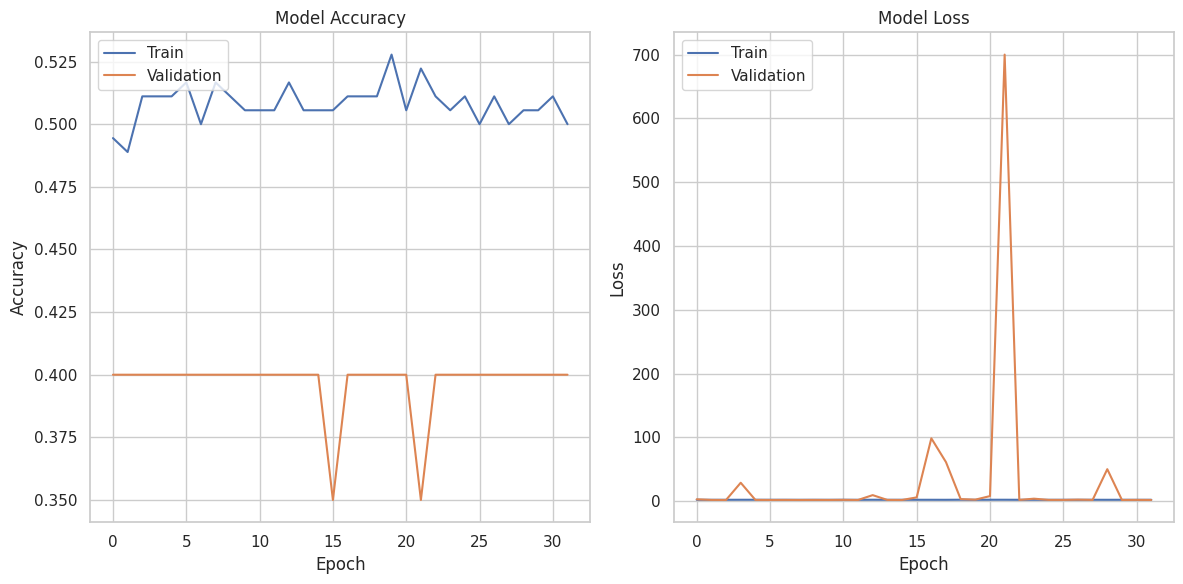

7/7 [==============================] - 0s 21ms/step
y_pred [[0.4499628  0.16711356 0.20254625 0.1803774 ]
 [0.4560292  0.16423884 0.19802785 0.1817041 ]
 [0.4543455  0.15937339 0.19861023 0.18767099]
 [0.45591533 0.16045025 0.19677411 0.1868603 ]
 [0.45360765 0.15819201 0.19961123 0.18858902]
 [0.45430622 0.15867794 0.19896428 0.18805152]
 [0.56901324 0.20515972 0.09213371 0.13369338]
 [0.48425657 0.19022936 0.15617025 0.16934374]
 [0.45254233 0.15778804 0.20099655 0.18867306]
 [0.5045904  0.19574726 0.13957815 0.16008419]
 [0.59662753 0.18612666 0.10514149 0.11210433]
 [0.44632477 0.16279559 0.20584215 0.18503746]
 [0.4524591  0.16888729 0.19872463 0.17992903]
 [0.53148496 0.1411059  0.16259688 0.1648123 ]
 [0.4475453  0.16023633 0.20631689 0.18590151]
 [0.5912839  0.2069933  0.10382648 0.09789624]
 [0.54644346 0.2002119  0.11094602 0.14239858]
 [0.45332888 0.16264257 0.20025091 0.18377768]
 [0.45002085 0.16301648 0.2013391  0.18562353]
 [0.45211208 0.1686934  0.19916746 0.18002708]
 

6/6 [==============================] - 2s 251ms/step - loss: 2.2915 - sparse_categorical_accuracy: 0.5056 - val_loss: 3.9929 - val_sparse_categorical_accuracy: 0.4500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.2993 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 231ms/step - loss: 2.2993 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.9445 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.2742 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 234ms/step - loss: 2.2742 - sparse_categorical_accuracy: 0.4889 - val_loss: 5.2928 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.2899 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 228ms/step - loss: 2.2899 - sparse_categorical_accuracy: 0.5056 - val_loss: 3.7085 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.2727 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 231ms/step - loss: 2.2727 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.0510 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.3091 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 235ms/step - loss: 2.3091 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.1412 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.2872 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 226ms/step - loss: 2.2872 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.0340 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.3169 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 294ms/step - loss: 2.3169 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.9963 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.2469 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 2s 287ms/step - loss: 2.2469 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.3310 - val_sparse_categorical_accuracy: 0.4500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.2501 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 273ms/step - loss: 2.2501 - sparse_categorical_accuracy: 0.5000 - val_loss: 3.5110 - val_sparse_categorical_accuracy: 0.4500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.2625 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 224ms/step - loss: 2.2625 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.0736 - val_sparse_categorical_accuracy: 0.4500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.2470 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 236ms/step - loss: 2.2470 - sparse_categorical_accuracy: 0.5056 - val_loss: 3.2460 - val_sparse_categorical_accuracy: 0.4500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.2786 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 231ms/step - loss: 2.2786 - sparse_categorical_accuracy: 0.5167 - val_loss: 3.3380 - val_sparse_categorical_accuracy: 0.4500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.3603 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 237ms/step - loss: 2.3603 - sparse_categorical_accuracy: 0.4944 - val_loss: 27.6046 - val_sparse_categorical_accuracy: 0.4500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.2839 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 227ms/step - loss: 2.2839 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.2167 - val_sparse_categorical_accuracy: 0.4500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.2791 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 230ms/step - loss: 2.2791 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.5969 - val_sparse_categorical_accuracy: 0.4500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.2128 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 231ms/step - loss: 2.2128 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.2361 - val_sparse_categorical_accuracy: 0.4500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.2647 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 260ms/step - loss: 2.2647 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.7266 - val_sparse_categorical_accuracy: 0.4500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.2407 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 293ms/step - loss: 2.2407 - sparse_categorical_accuracy: 0.5056 - val_loss: 8.2925 - val_sparse_categorical_accuracy: 0.4500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.2618 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 2s 312ms/step - loss: 2.2618 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.0533 - val_sparse_categorical_accuracy: 0.4500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.2210 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 226ms/step - loss: 2.2210 - sparse_categorical_accuracy: 0.5111 - val_loss: 8.3183 - val_sparse_categorical_accuracy: 0.4000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.2337 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 226ms/step - loss: 2.2337 - sparse_categorical_accuracy: 0.4944 - val_loss: 3.2111 - val_sparse_categorical_accuracy: 0.4500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.2536 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 234ms/step - loss: 2.2536 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.3451 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.2182 - sparse_categorical_accuracy: 0.5222

6/6 [==============================] - 1s 231ms/step - loss: 2.2182 - sparse_categorical_accuracy: 0.5222 - val_loss: 2.0502 - val_sparse_categorical_accuracy: 0.4500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.2328 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 232ms/step - loss: 2.2328 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.3972 - val_sparse_categorical_accuracy: 0.4500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.3096 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 228ms/step - loss: 2.3096 - sparse_categorical_accuracy: 0.4944 - val_loss: 6.7623 - val_sparse_categorical_accuracy: 0.4500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.2908 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 226ms/step - loss: 2.2908 - sparse_categorical_accuracy: 0.4889 - val_loss: 4.3028 - val_sparse_categorical_accuracy: 0.4500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.2282 - sparse_categorical_accuracy: 0.5222

6/6 [==============================] - 1s 231ms/step - loss: 2.2282 - sparse_categorical_accuracy: 0.5222 - val_loss: 2.4435 - val_sparse_categorical_accuracy: 0.4500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.2155 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 2s 288ms/step - loss: 2.2155 - sparse_categorical_accuracy: 0.5000 - val_loss: 5.1372 - val_sparse_categorical_accuracy: 0.4000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.3154 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 2s 300ms/step - loss: 2.3154 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.4357 - val_sparse_categorical_accuracy: 0.4500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.2268 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 258ms/step - loss: 2.2268 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.1752 - val_sparse_categorical_accuracy: 0.4500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.3119 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 231ms/step - loss: 2.3119 - sparse_categorical_accuracy: 0.4944 - val_loss: 2.4921 - val_sparse_categorical_accuracy: 0.4500


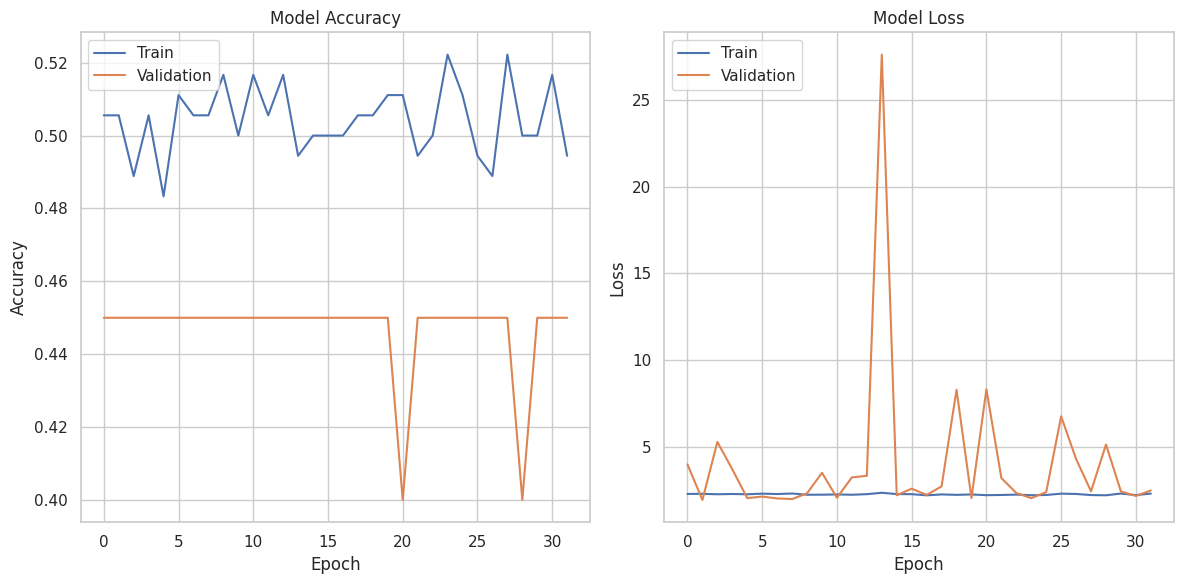

7/7 [==============================] - 0s 21ms/step
y_pred [[4.20841306e-01 1.57613426e-01 2.78183103e-01 1.43362105e-01]
 [4.87991214e-01 1.02397069e-01 1.55598491e-01 2.54013181e-01]
 [4.14118618e-01 2.03315988e-01 2.40445301e-01 1.42120108e-01]
 [4.06673849e-01 2.31219456e-01 2.13311598e-01 1.48795158e-01]
 [4.28018421e-01 1.72800213e-01 2.25513160e-01 1.73668176e-01]
 [4.16698366e-01 2.01457366e-01 2.31230557e-01 1.50613770e-01]
 [6.42475188e-01 2.12338582e-01 3.04529220e-02 1.14733376e-01]
 [4.80206221e-01 1.86565578e-01 1.48534656e-01 1.84693545e-01]
 [4.33556944e-01 1.55242980e-01 2.15386465e-01 1.95813596e-01]
 [5.35047591e-01 2.06015959e-01 1.22838892e-01 1.36097491e-01]
 [9.94250655e-01 1.24917045e-04 2.27322860e-04 5.39709069e-03]
 [4.05187845e-01 2.04506323e-01 2.59655088e-01 1.30650789e-01]
 [4.21408415e-01 1.57433361e-01 2.83368081e-01 1.37790203e-01]
 [9.84059095e-01 3.69350106e-04 1.16071207e-02 3.96437012e-03]
 [4.52718705e-01 1.25453964e-01 2.05003068e-01 2.16824189e-

6/6 [==============================] - 1s 248ms/step - loss: 2.3072 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.0933 - val_sparse_categorical_accuracy: 0.4500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.3166 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 283ms/step - loss: 2.3166 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.8828 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.2722 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 271ms/step - loss: 2.2722 - sparse_categorical_accuracy: 0.5111 - val_loss: 3.0902 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.2622 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 266ms/step - loss: 2.2622 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.7006 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.2710 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 227ms/step - loss: 2.2710 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.1911 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.2348 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 229ms/step - loss: 2.2348 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.0728 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.3029 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 230ms/step - loss: 2.3029 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.2487 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.2442 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 230ms/step - loss: 2.2442 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.9829 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.2488 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 225ms/step - loss: 2.2488 - sparse_categorical_accuracy: 0.5056 - val_loss: 2.3957 - val_sparse_categorical_accuracy: 0.4500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.2779 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 229ms/step - loss: 2.2779 - sparse_categorical_accuracy: 0.5000 - val_loss: 5.2866 - val_sparse_categorical_accuracy: 0.4500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.2478 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 227ms/step - loss: 2.2478 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.2024 - val_sparse_categorical_accuracy: 0.4500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.2498 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 245ms/step - loss: 2.2498 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.9047 - val_sparse_categorical_accuracy: 0.4500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.3144 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 2s 303ms/step - loss: 2.3144 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.9852 - val_sparse_categorical_accuracy: 0.4500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.3187 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 2s 308ms/step - loss: 2.3187 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.8881 - val_sparse_categorical_accuracy: 0.4500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.1941 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 232ms/step - loss: 2.1941 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.2236 - val_sparse_categorical_accuracy: 0.4500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.2295 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 229ms/step - loss: 2.2295 - sparse_categorical_accuracy: 0.5111 - val_loss: 5.4231 - val_sparse_categorical_accuracy: 0.4500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.2763 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 230ms/step - loss: 2.2763 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.3001 - val_sparse_categorical_accuracy: 0.4500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.2062 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 232ms/step - loss: 2.2062 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.1774 - val_sparse_categorical_accuracy: 0.3500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.1750 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 230ms/step - loss: 2.1750 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.1788 - val_sparse_categorical_accuracy: 0.4500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.2554 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 231ms/step - loss: 2.2554 - sparse_categorical_accuracy: 0.5000 - val_loss: 9.0616 - val_sparse_categorical_accuracy: 0.2500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.2936 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 229ms/step - loss: 2.2936 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.1623 - val_sparse_categorical_accuracy: 0.3500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.2655 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 234ms/step - loss: 2.2655 - sparse_categorical_accuracy: 0.4889 - val_loss: 3.1162 - val_sparse_categorical_accuracy: 0.4500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.2982 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 2s 285ms/step - loss: 2.2982 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.2282 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.2776 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 2s 299ms/step - loss: 2.2776 - sparse_categorical_accuracy: 0.4944 - val_loss: 2.2273 - val_sparse_categorical_accuracy: 0.4000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.2416 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 260ms/step - loss: 2.2416 - sparse_categorical_accuracy: 0.5000 - val_loss: 86.1296 - val_sparse_categorical_accuracy: 0.3500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.2773 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 230ms/step - loss: 2.2773 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.9690 - val_sparse_categorical_accuracy: 0.4500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.3267 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 230ms/step - loss: 2.3267 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2124 - val_sparse_categorical_accuracy: 0.4500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.2823 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 230ms/step - loss: 2.2823 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.3763 - val_sparse_categorical_accuracy: 0.4500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.3000 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 246ms/step - loss: 2.3000 - sparse_categorical_accuracy: 0.4944 - val_loss: 6.9077 - val_sparse_categorical_accuracy: 0.4000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.2709 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 233ms/step - loss: 2.2709 - sparse_categorical_accuracy: 0.5111 - val_loss: 11.4962 - val_sparse_categorical_accuracy: 0.4500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.2940 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 228ms/step - loss: 2.2940 - sparse_categorical_accuracy: 0.5000 - val_loss: 2.8690 - val_sparse_categorical_accuracy: 0.4500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.3062 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 231ms/step - loss: 2.3062 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.5680 - val_sparse_categorical_accuracy: 0.4000


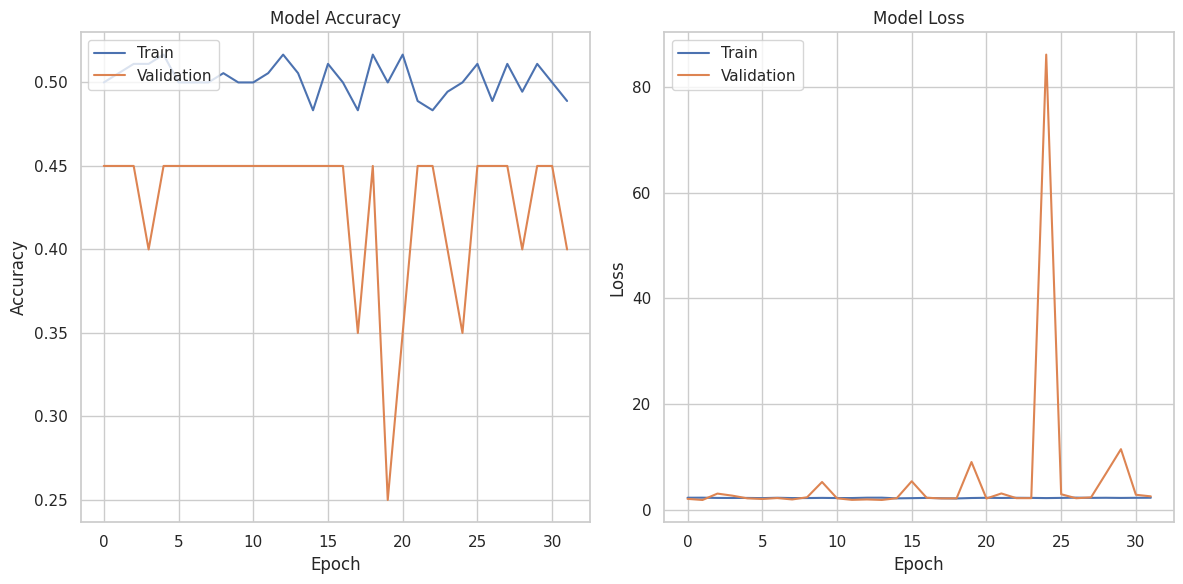

7/7 [==============================] - 0s 22ms/step
y_pred [[6.04083776e-01 8.74624550e-02 1.96178779e-01 1.12274967e-01]
 [6.00472212e-01 9.59668159e-02 1.85414404e-01 1.18146531e-01]
 [5.33958197e-01 1.21709190e-01 2.00448409e-01 1.43884197e-01]
 [3.23308289e-01 3.61302763e-01 1.24968022e-01 1.90420896e-01]
 [6.01718307e-01 8.77115354e-02 1.90322325e-01 1.20247833e-01]
 [4.02282864e-01 2.67544359e-01 1.54442132e-01 1.75730720e-01]
 [7.95478940e-01 8.95093232e-02 1.09813111e-02 1.04030401e-01]
 [5.49869239e-01 1.80600926e-01 5.78520261e-02 2.11677864e-01]
 [6.32801592e-01 7.50324354e-02 1.72741532e-01 1.19424500e-01]
 [4.81648117e-01 2.47256413e-01 7.69379213e-02 1.94157541e-01]
 [4.08644170e-01 2.66048968e-01 1.41015679e-01 1.84291244e-01]
 [5.08405924e-01 1.32052898e-01 2.28676453e-01 1.30864695e-01]
 [5.59128165e-01 1.01154268e-01 2.23897278e-01 1.15820266e-01]
 [5.04381001e-01 1.71585992e-01 1.63330495e-01 1.60702452e-01]
 [6.34451509e-01 7.86425993e-02 1.71161562e-01 1.15744345e-

6/6 [==============================] - 1s 251ms/step - loss: 2.3274 - sparse_categorical_accuracy: 0.4778 - val_loss: 2.7527 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.3180 - sparse_categorical_accuracy: 0.4667

6/6 [==============================] - 1s 231ms/step - loss: 2.3180 - sparse_categorical_accuracy: 0.4667 - val_loss: 10.9288 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.3616 - sparse_categorical_accuracy: 0.4611

6/6 [==============================] - 1s 229ms/step - loss: 2.3616 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.5957 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.3190 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 236ms/step - loss: 2.3190 - sparse_categorical_accuracy: 0.4722 - val_loss: 2.0992 - val_sparse_categorical_accuracy: 0.7500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.3287 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 274ms/step - loss: 2.3287 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.5596 - val_sparse_categorical_accuracy: 0.7500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.3161 - sparse_categorical_accuracy: 0.4667

6/6 [==============================] - 2s 294ms/step - loss: 2.3161 - sparse_categorical_accuracy: 0.4667 - val_loss: 1.6341 - val_sparse_categorical_accuracy: 0.7500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.2890 - sparse_categorical_accuracy: 0.4667

6/6 [==============================] - 2s 286ms/step - loss: 2.2890 - sparse_categorical_accuracy: 0.4667 - val_loss: 1.7162 - val_sparse_categorical_accuracy: 0.6500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 2.2891 - sparse_categorical_accuracy: 0.4111

6/6 [==============================] - 1s 235ms/step - loss: 2.2891 - sparse_categorical_accuracy: 0.4111 - val_loss: 1.6442 - val_sparse_categorical_accuracy: 0.7500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.2479 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 226ms/step - loss: 2.2479 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.6605 - val_sparse_categorical_accuracy: 0.7500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.2941 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 1s 230ms/step - loss: 2.2941 - sparse_categorical_accuracy: 0.5000 - val_loss: 24.2803 - val_sparse_categorical_accuracy: 0.7500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.2657 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 1s 237ms/step - loss: 2.2657 - sparse_categorical_accuracy: 0.4889 - val_loss: 1.6442 - val_sparse_categorical_accuracy: 0.7500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.2423 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 233ms/step - loss: 2.2423 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.6005 - val_sparse_categorical_accuracy: 0.7000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.3220 - sparse_categorical_accuracy: 0.4444

6/6 [==============================] - 1s 230ms/step - loss: 2.3220 - sparse_categorical_accuracy: 0.4444 - val_loss: 1.8619 - val_sparse_categorical_accuracy: 0.7500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.3219 - sparse_categorical_accuracy: 0.4333

6/6 [==============================] - 1s 234ms/step - loss: 2.3219 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.6581 - val_sparse_categorical_accuracy: 0.7500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.2709 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 257ms/step - loss: 2.2709 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.6167 - val_sparse_categorical_accuracy: 0.7500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 2.2704 - sparse_categorical_accuracy: 0.4889

6/6 [==============================] - 2s 307ms/step - loss: 2.2704 - sparse_categorical_accuracy: 0.4889 - val_loss: 1.6273 - val_sparse_categorical_accuracy: 0.7500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.2730 - sparse_categorical_accuracy: 0.4556

6/6 [==============================] - 2s 287ms/step - loss: 2.2730 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.5691 - val_sparse_categorical_accuracy: 0.7500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.2723 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 230ms/step - loss: 2.2723 - sparse_categorical_accuracy: 0.4722 - val_loss: 25.6816 - val_sparse_categorical_accuracy: 0.4500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.2135 - sparse_categorical_accuracy: 0.4778

6/6 [==============================] - 1s 231ms/step - loss: 2.2135 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.6226 - val_sparse_categorical_accuracy: 0.7500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.2441 - sparse_categorical_accuracy: 0.4556

6/6 [==============================] - 1s 231ms/step - loss: 2.2441 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.6693 - val_sparse_categorical_accuracy: 0.6000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.2690 - sparse_categorical_accuracy: 0.5111

6/6 [==============================] - 1s 228ms/step - loss: 2.2690 - sparse_categorical_accuracy: 0.5111 - val_loss: 1.4930 - val_sparse_categorical_accuracy: 0.8000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 2.2553 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 236ms/step - loss: 2.2553 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.6621 - val_sparse_categorical_accuracy: 0.7500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 2.2117 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 228ms/step - loss: 2.2117 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.6321 - val_sparse_categorical_accuracy: 0.8000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.2737 - sparse_categorical_accuracy: 0.4833

6/6 [==============================] - 1s 233ms/step - loss: 2.2737 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.5912 - val_sparse_categorical_accuracy: 0.7500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 2.2447 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 1s 233ms/step - loss: 2.2447 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.5510 - val_sparse_categorical_accuracy: 0.6500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.2118 - sparse_categorical_accuracy: 0.4722

6/6 [==============================] - 2s 288ms/step - loss: 2.2118 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.6130 - val_sparse_categorical_accuracy: 0.7500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.2075 - sparse_categorical_accuracy: 0.5000

6/6 [==============================] - 2s 299ms/step - loss: 2.2075 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6132 - val_sparse_categorical_accuracy: 0.5500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 2.2443 - sparse_categorical_accuracy: 0.5056

6/6 [==============================] - 1s 233ms/step - loss: 2.2443 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.5731 - val_sparse_categorical_accuracy: 0.7000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 2.2064 - sparse_categorical_accuracy: 0.5167

6/6 [==============================] - 1s 235ms/step - loss: 2.2064 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.7905 - val_sparse_categorical_accuracy: 0.7000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 2.1645 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 1s 229ms/step - loss: 2.1645 - sparse_categorical_accuracy: 0.4944 - val_loss: 1.9347 - val_sparse_categorical_accuracy: 0.3000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 2.1444 - sparse_categorical_accuracy: 0.5722

6/6 [==============================] - 1s 232ms/step - loss: 2.1444 - sparse_categorical_accuracy: 0.5722 - val_loss: 1.7582 - val_sparse_categorical_accuracy: 0.6500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 2.1702 - sparse_categorical_accuracy: 0.5444

6/6 [==============================] - 1s 229ms/step - loss: 2.1702 - sparse_categorical_accuracy: 0.5444 - val_loss: 1.8860 - val_sparse_categorical_accuracy: 0.6000


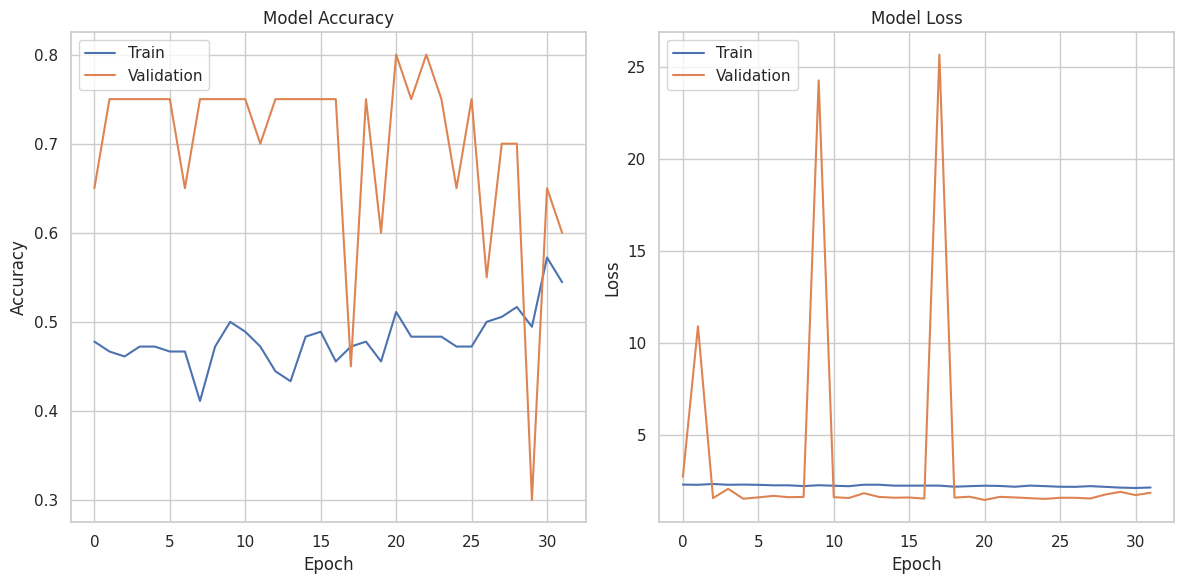

7/7 [==============================] - 0s 21ms/step
y_pred [[3.99821699e-01 2.63258338e-01 6.62333369e-02 2.70686656e-01]
 [5.69755614e-01 1.94437057e-02 3.60993333e-02 3.74701351e-01]
 [4.96488482e-01 1.26362592e-01 3.71681787e-02 3.39980751e-01]
 [2.93597907e-01 5.65782726e-01 2.28958968e-02 1.17723428e-01]
 [5.91621697e-01 4.04666513e-02 5.59667051e-02 3.11944902e-01]
 [6.04353189e-01 3.17400210e-02 3.98414358e-02 3.24065417e-01]
 [8.56521606e-01 5.02109434e-03 5.34312239e-05 1.38403848e-01]
 [5.78772426e-01 2.55506456e-01 3.53577249e-02 1.30363360e-01]
 [6.08376801e-01 3.05228438e-02 8.50352645e-02 2.76065081e-01]
 [4.95320886e-01 3.20723414e-01 3.04422360e-02 1.53513432e-01]
 [3.95853370e-01 2.26272583e-01 3.35564077e-01 4.23099622e-02]
 [3.98138404e-01 2.71183640e-01 6.44571781e-02 2.66220748e-01]
 [4.24390852e-01 2.17262983e-01 7.49992728e-02 2.83346981e-01]
 [3.80776703e-01 1.60969839e-01 3.40182304e-01 1.18071176e-01]
 [4.83710647e-01 1.07562251e-01 5.46085574e-02 3.54118586e-

6/6 [==============================] - 2s 257ms/step - loss: 2.1876 - sparse_categorical_accuracy: 0.5222 - val_loss: 1.8783 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 2.0895 - sparse_categorical_accuracy: 0.5556

6/6 [==============================] - 1s 256ms/step - loss: 2.0895 - sparse_categorical_accuracy: 0.5556 - val_loss: 1.9554 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.1091 - sparse_categorical_accuracy: 0.5500

6/6 [==============================] - 2s 298ms/step - loss: 2.1091 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.0980 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 2.1103 - sparse_categorical_accuracy: 0.5611

6/6 [==============================] - 2s 302ms/step - loss: 2.1103 - sparse_categorical_accuracy: 0.5611 - val_loss: 2.1391 - val_sparse_categorical_accuracy: 0.3000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 2.0833 - sparse_categorical_accuracy: 0.5333

6/6 [==============================] - 1s 228ms/step - loss: 2.0833 - sparse_categorical_accuracy: 0.5333 - val_loss: 2.2486 - val_sparse_categorical_accuracy: 0.4000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 2.1612 - sparse_categorical_accuracy: 0.5222

6/6 [==============================] - 1s 226ms/step - loss: 2.1612 - sparse_categorical_accuracy: 0.5222 - val_loss: 1.9739 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 2.0809 - sparse_categorical_accuracy: 0.5556

6/6 [==============================] - 1s 231ms/step - loss: 2.0809 - sparse_categorical_accuracy: 0.5556 - val_loss: 2.1278 - val_sparse_categorical_accuracy: 0.3500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.9832 - sparse_categorical_accuracy: 0.6278

6/6 [==============================] - 1s 229ms/step - loss: 1.9832 - sparse_categorical_accuracy: 0.6278 - val_loss: 2.2646 - val_sparse_categorical_accuracy: 0.4000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 2.0856 - sparse_categorical_accuracy: 0.5778

6/6 [==============================] - 1s 228ms/step - loss: 2.0856 - sparse_categorical_accuracy: 0.5778 - val_loss: 3.5284 - val_sparse_categorical_accuracy: 0.5000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 2.0795 - sparse_categorical_accuracy: 0.5667

6/6 [==============================] - 1s 225ms/step - loss: 2.0795 - sparse_categorical_accuracy: 0.5667 - val_loss: 2.2598 - val_sparse_categorical_accuracy: 0.3000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 2.0613 - sparse_categorical_accuracy: 0.5389

6/6 [==============================] - 1s 226ms/step - loss: 2.0613 - sparse_categorical_accuracy: 0.5389 - val_loss: 2.2431 - val_sparse_categorical_accuracy: 0.3000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 2.1098 - sparse_categorical_accuracy: 0.5444

6/6 [==============================] - 1s 223ms/step - loss: 2.1098 - sparse_categorical_accuracy: 0.5444 - val_loss: 2.0027 - val_sparse_categorical_accuracy: 0.5000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 2.0893 - sparse_categorical_accuracy: 0.5667

6/6 [==============================] - 2s 302ms/step - loss: 2.0893 - sparse_categorical_accuracy: 0.5667 - val_loss: 2.8869 - val_sparse_categorical_accuracy: 0.5000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 2.2116 - sparse_categorical_accuracy: 0.4944

6/6 [==============================] - 2s 307ms/step - loss: 2.2116 - sparse_categorical_accuracy: 0.4944 - val_loss: 12.1505 - val_sparse_categorical_accuracy: 0.3500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 2.1334 - sparse_categorical_accuracy: 0.5556

6/6 [==============================] - 1s 227ms/step - loss: 2.1334 - sparse_categorical_accuracy: 0.5556 - val_loss: 2.2372 - val_sparse_categorical_accuracy: 0.3000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.9961 - sparse_categorical_accuracy: 0.6000

6/6 [==============================] - 1s 226ms/step - loss: 1.9961 - sparse_categorical_accuracy: 0.6000 - val_loss: 2.3777 - val_sparse_categorical_accuracy: 0.5000
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 2.1430 - sparse_categorical_accuracy: 0.5500

6/6 [==============================] - 1s 229ms/step - loss: 2.1430 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.8273 - val_sparse_categorical_accuracy: 0.3000
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 2.1036 - sparse_categorical_accuracy: 0.5611

6/6 [==============================] - 1s 228ms/step - loss: 2.1036 - sparse_categorical_accuracy: 0.5611 - val_loss: 2.1784 - val_sparse_categorical_accuracy: 0.4000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 2.1059 - sparse_categorical_accuracy: 0.5889

6/6 [==============================] - 1s 236ms/step - loss: 2.1059 - sparse_categorical_accuracy: 0.5889 - val_loss: 2.5211 - val_sparse_categorical_accuracy: 0.4000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 2.1224 - sparse_categorical_accuracy: 0.5778

6/6 [==============================] - 1s 228ms/step - loss: 2.1224 - sparse_categorical_accuracy: 0.5778 - val_loss: 1.8894 - val_sparse_categorical_accuracy: 0.3500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 2.1058 - sparse_categorical_accuracy: 0.6000

6/6 [==============================] - 1s 233ms/step - loss: 2.1058 - sparse_categorical_accuracy: 0.6000 - val_loss: 2.5005 - val_sparse_categorical_accuracy: 0.3500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.9778 - sparse_categorical_accuracy: 0.6278

6/6 [==============================] - 1s 226ms/step - loss: 1.9778 - sparse_categorical_accuracy: 0.6278 - val_loss: 2.4282 - val_sparse_categorical_accuracy: 0.3500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.9370 - sparse_categorical_accuracy: 0.6389

6/6 [==============================] - 2s 288ms/step - loss: 1.9370 - sparse_categorical_accuracy: 0.6389 - val_loss: 2.3175 - val_sparse_categorical_accuracy: 0.5500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 2.0374 - sparse_categorical_accuracy: 0.6000

6/6 [==============================] - 2s 292ms/step - loss: 2.0374 - sparse_categorical_accuracy: 0.6000 - val_loss: 2.2931 - val_sparse_categorical_accuracy: 0.4000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.9562 - sparse_categorical_accuracy: 0.5944

6/6 [==============================] - 1s 267ms/step - loss: 1.9562 - sparse_categorical_accuracy: 0.5944 - val_loss: 5.6086 - val_sparse_categorical_accuracy: 0.4000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 2.0502 - sparse_categorical_accuracy: 0.5889

6/6 [==============================] - 1s 230ms/step - loss: 2.0502 - sparse_categorical_accuracy: 0.5889 - val_loss: 2.6122 - val_sparse_categorical_accuracy: 0.4000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 2.0828 - sparse_categorical_accuracy: 0.6222

6/6 [==============================] - 1s 227ms/step - loss: 2.0828 - sparse_categorical_accuracy: 0.6222 - val_loss: 2.0528 - val_sparse_categorical_accuracy: 0.3500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.9938 - sparse_categorical_accuracy: 0.6111

6/6 [==============================] - 1s 230ms/step - loss: 1.9938 - sparse_categorical_accuracy: 0.6111 - val_loss: 2.2980 - val_sparse_categorical_accuracy: 0.3000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.9175 - sparse_categorical_accuracy: 0.6444

6/6 [==============================] - 1s 230ms/step - loss: 1.9175 - sparse_categorical_accuracy: 0.6444 - val_loss: 5.3401 - val_sparse_categorical_accuracy: 0.3500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.9045 - sparse_categorical_accuracy: 0.6333

6/6 [==============================] - 1s 229ms/step - loss: 1.9045 - sparse_categorical_accuracy: 0.6333 - val_loss: 4.1249 - val_sparse_categorical_accuracy: 0.3500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.9631 - sparse_categorical_accuracy: 0.6333

6/6 [==============================] - 1s 235ms/step - loss: 1.9631 - sparse_categorical_accuracy: 0.6333 - val_loss: 2.6745 - val_sparse_categorical_accuracy: 0.3000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.8422 - sparse_categorical_accuracy: 0.6833

6/6 [==============================] - 1s 229ms/step - loss: 1.8422 - sparse_categorical_accuracy: 0.6833 - val_loss: 3.4534 - val_sparse_categorical_accuracy: 0.3000


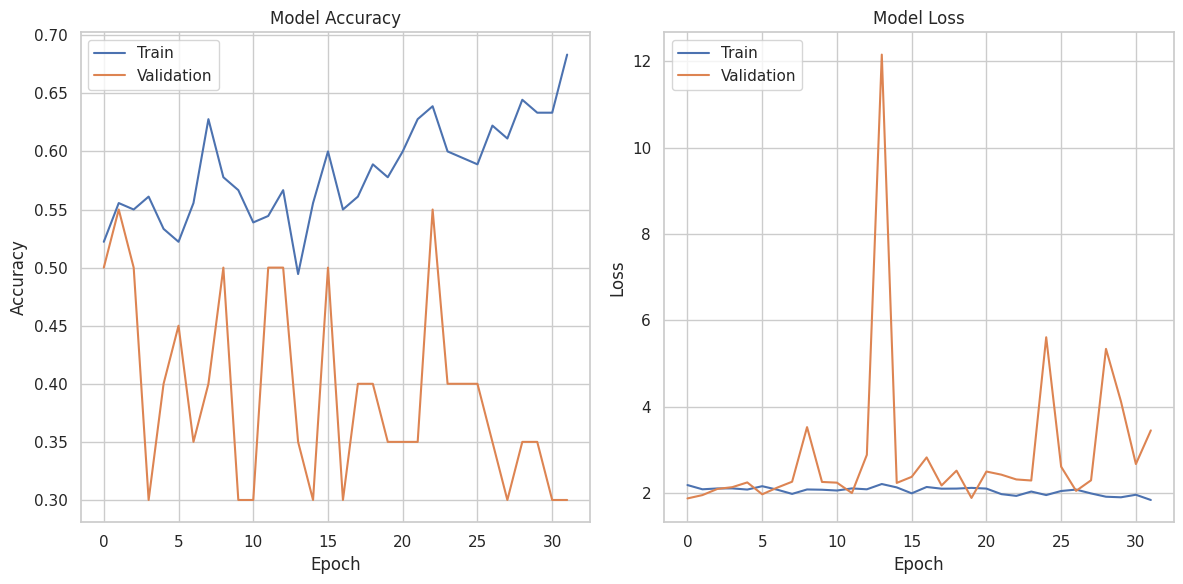

7/7 [==============================] - 0s 24ms/step
y_pred [[2.08194703e-01 7.78416872e-01 4.69439616e-03 8.69395584e-03]
 [4.20408994e-02 4.18522255e-03 9.52558577e-01 1.21530739e-03]
 [4.04247075e-01 1.03856241e-02 1.05015598e-02 5.74865699e-01]
 [6.69853091e-02 9.28646445e-01 2.23054993e-03 2.13766145e-03]
 [5.46202250e-02 9.42488730e-01 1.45894161e-03 1.43208005e-03]
 [7.30106473e-01 8.72866511e-02 1.18061714e-02 1.70800745e-01]
 [3.46662402e-02 9.61391687e-01 2.37769447e-03 1.56436313e-03]
 [5.87128818e-01 2.97430068e-01 5.62774166e-02 5.91636971e-02]
 [5.69596469e-01 1.02865146e-02 1.41918464e-02 4.05925214e-01]
 [6.07755125e-01 1.38991177e-01 8.99891779e-02 1.63264528e-01]
 [4.18125570e-01 5.40215552e-01 1.13080293e-02 3.03508881e-02]
 [4.05022278e-02 4.74425405e-03 9.53492939e-01 1.26052718e-03]
 [4.88997459e-01 1.03636300e-02 1.12637160e-02 4.89375234e-01]
 [5.76930344e-01 1.96297288e-01 2.16084749e-01 1.06876856e-02]
 [5.04336119e-01 7.52087776e-03 1.43335341e-02 4.73809451e-

6/6 [==============================] - 2s 303ms/step - loss: 1.9368 - sparse_categorical_accuracy: 0.6389 - val_loss: 1.9199 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.9622 - sparse_categorical_accuracy: 0.6500

6/6 [==============================] - 1s 237ms/step - loss: 1.9622 - sparse_categorical_accuracy: 0.6500 - val_loss: 1.8395 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 2.0362 - sparse_categorical_accuracy: 0.5889

6/6 [==============================] - 1s 227ms/step - loss: 2.0362 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.8277 - val_sparse_categorical_accuracy: 0.5500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.9956 - sparse_categorical_accuracy: 0.6556

6/6 [==============================] - 1s 228ms/step - loss: 1.9956 - sparse_categorical_accuracy: 0.6556 - val_loss: 1.9213 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.9473 - sparse_categorical_accuracy: 0.6556

6/6 [==============================] - 1s 227ms/step - loss: 1.9473 - sparse_categorical_accuracy: 0.6556 - val_loss: 1.8137 - val_sparse_categorical_accuracy: 0.5500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.9089 - sparse_categorical_accuracy: 0.6667

6/6 [==============================] - 1s 232ms/step - loss: 1.9089 - sparse_categorical_accuracy: 0.6667 - val_loss: 2.2393 - val_sparse_categorical_accuracy: 0.3500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.8882 - sparse_categorical_accuracy: 0.6556

6/6 [==============================] - 1s 232ms/step - loss: 1.8882 - sparse_categorical_accuracy: 0.6556 - val_loss: 2.2065 - val_sparse_categorical_accuracy: 0.5000
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.7971 - sparse_categorical_accuracy: 0.6778

6/6 [==============================] - 1s 231ms/step - loss: 1.7971 - sparse_categorical_accuracy: 0.6778 - val_loss: 2.1699 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.9003 - sparse_categorical_accuracy: 0.6778

6/6 [==============================] - 1s 237ms/step - loss: 1.9003 - sparse_categorical_accuracy: 0.6778 - val_loss: 34.4851 - val_sparse_categorical_accuracy: 0.4500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.8131 - sparse_categorical_accuracy: 0.7000

6/6 [==============================] - 1s 279ms/step - loss: 1.8131 - sparse_categorical_accuracy: 0.7000 - val_loss: 1.9473 - val_sparse_categorical_accuracy: 0.4500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.8418 - sparse_categorical_accuracy: 0.6667

6/6 [==============================] - 1s 274ms/step - loss: 1.8418 - sparse_categorical_accuracy: 0.6667 - val_loss: 1.8818 - val_sparse_categorical_accuracy: 0.4500
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.7467 - sparse_categorical_accuracy: 0.6833

6/6 [==============================] - 1s 282ms/step - loss: 1.7467 - sparse_categorical_accuracy: 0.6833 - val_loss: 2.4700 - val_sparse_categorical_accuracy: 0.3000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.8208 - sparse_categorical_accuracy: 0.6722

6/6 [==============================] - 1s 240ms/step - loss: 1.8208 - sparse_categorical_accuracy: 0.6722 - val_loss: 2.2031 - val_sparse_categorical_accuracy: 0.5000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.8526 - sparse_categorical_accuracy: 0.6722

6/6 [==============================] - 1s 230ms/step - loss: 1.8526 - sparse_categorical_accuracy: 0.6722 - val_loss: 2.0675 - val_sparse_categorical_accuracy: 0.5000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.7664 - sparse_categorical_accuracy: 0.7278

6/6 [==============================] - 1s 231ms/step - loss: 1.7664 - sparse_categorical_accuracy: 0.7278 - val_loss: 2.1925 - val_sparse_categorical_accuracy: 0.5000
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.7019 - sparse_categorical_accuracy: 0.7167

6/6 [==============================] - 1s 237ms/step - loss: 1.7019 - sparse_categorical_accuracy: 0.7167 - val_loss: 2.7372 - val_sparse_categorical_accuracy: 0.3000
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.7242 - sparse_categorical_accuracy: 0.7667

6/6 [==============================] - 1s 228ms/step - loss: 1.7242 - sparse_categorical_accuracy: 0.7667 - val_loss: 2.6412 - val_sparse_categorical_accuracy: 0.3500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.6973 - sparse_categorical_accuracy: 0.7222

6/6 [==============================] - 1s 229ms/step - loss: 1.6973 - sparse_categorical_accuracy: 0.7222 - val_loss: 3.0906 - val_sparse_categorical_accuracy: 0.4500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.7442 - sparse_categorical_accuracy: 0.7167

6/6 [==============================] - 1s 222ms/step - loss: 1.7442 - sparse_categorical_accuracy: 0.7167 - val_loss: 2.5963 - val_sparse_categorical_accuracy: 0.4500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.7734 - sparse_categorical_accuracy: 0.6889

6/6 [==============================] - 1s 258ms/step - loss: 1.7734 - sparse_categorical_accuracy: 0.6889 - val_loss: 2.6084 - val_sparse_categorical_accuracy: 0.3500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.8215 - sparse_categorical_accuracy: 0.7000

6/6 [==============================] - 2s 295ms/step - loss: 1.8215 - sparse_categorical_accuracy: 0.7000 - val_loss: 3.0512 - val_sparse_categorical_accuracy: 0.2500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.7851 - sparse_categorical_accuracy: 0.6944

6/6 [==============================] - 2s 300ms/step - loss: 1.7851 - sparse_categorical_accuracy: 0.6944 - val_loss: 2.6502 - val_sparse_categorical_accuracy: 0.3500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.7101 - sparse_categorical_accuracy: 0.7556

6/6 [==============================] - 1s 226ms/step - loss: 1.7101 - sparse_categorical_accuracy: 0.7556 - val_loss: 2.5527 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.6706 - sparse_categorical_accuracy: 0.7556

6/6 [==============================] - 1s 225ms/step - loss: 1.6706 - sparse_categorical_accuracy: 0.7556 - val_loss: 3.2426 - val_sparse_categorical_accuracy: 0.3500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.7196 - sparse_categorical_accuracy: 0.7611

6/6 [==============================] - 1s 229ms/step - loss: 1.7196 - sparse_categorical_accuracy: 0.7611 - val_loss: 2.6473 - val_sparse_categorical_accuracy: 0.3000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.6389 - sparse_categorical_accuracy: 0.7500

6/6 [==============================] - 1s 232ms/step - loss: 1.6389 - sparse_categorical_accuracy: 0.7500 - val_loss: 2.3169 - val_sparse_categorical_accuracy: 0.5000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.6003 - sparse_categorical_accuracy: 0.7944

6/6 [==============================] - 1s 230ms/step - loss: 1.6003 - sparse_categorical_accuracy: 0.7944 - val_loss: 2.9104 - val_sparse_categorical_accuracy: 0.3500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.6948 - sparse_categorical_accuracy: 0.7722

6/6 [==============================] - 1s 226ms/step - loss: 1.6948 - sparse_categorical_accuracy: 0.7722 - val_loss: 2.7371 - val_sparse_categorical_accuracy: 0.4000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.7677 - sparse_categorical_accuracy: 0.7667

6/6 [==============================] - 1s 226ms/step - loss: 1.7677 - sparse_categorical_accuracy: 0.7667 - val_loss: 2.8219 - val_sparse_categorical_accuracy: 0.3500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.6628 - sparse_categorical_accuracy: 0.7889

6/6 [==============================] - 1s 230ms/step - loss: 1.6628 - sparse_categorical_accuracy: 0.7889 - val_loss: 17.9261 - val_sparse_categorical_accuracy: 0.4500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.6323 - sparse_categorical_accuracy: 0.7833

6/6 [==============================] - 1s 283ms/step - loss: 1.6323 - sparse_categorical_accuracy: 0.7833 - val_loss: 2.9353 - val_sparse_categorical_accuracy: 0.3500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.6270 - sparse_categorical_accuracy: 0.7722

6/6 [==============================] - 2s 301ms/step - loss: 1.6270 - sparse_categorical_accuracy: 0.7722 - val_loss: 2.7614 - val_sparse_categorical_accuracy: 0.4500


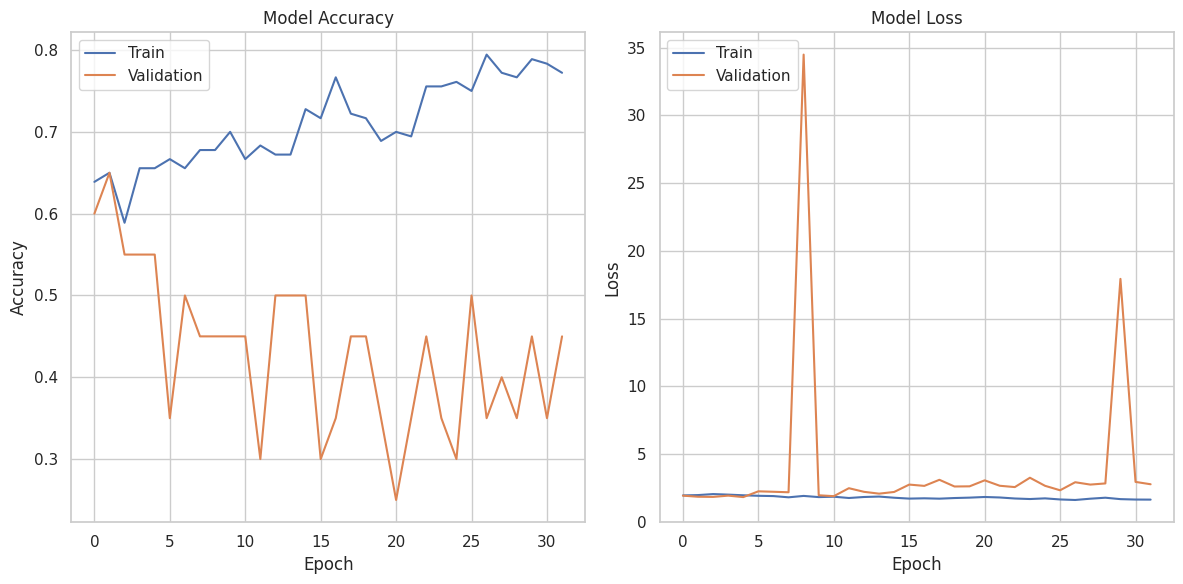

7/7 [==============================] - 0s 21ms/step
y_pred [[7.16891527e-01 2.33077511e-01 1.35667864e-02 3.64642516e-02]
 [3.30645149e-03 4.03785612e-03 9.92507637e-01 1.47956132e-04]
 [9.32063282e-01 2.43511843e-03 1.14130620e-02 5.40885814e-02]
 [6.09282143e-02 9.24867451e-01 1.12106586e-02 2.99368682e-03]
 [4.18606222e-01 3.96280037e-03 4.17743390e-03 5.73253512e-01]
 [8.17178905e-01 1.46465138e-01 1.36961248e-02 2.26598065e-02]
 [8.59405816e-01 1.32431299e-03 1.20751536e-03 1.38062313e-01]
 [8.64061117e-01 4.16935049e-02 3.91639881e-02 5.50813489e-02]
 [8.40038002e-01 1.12995148e-01 9.98586416e-03 3.69809456e-02]
 [8.28688562e-01 5.98350130e-02 4.06594612e-02 7.08169565e-02]
 [1.28733749e-02 6.71710074e-03 9.80351388e-01 5.81351524e-05]
 [1.55431656e-02 4.93663624e-02 9.34006453e-01 1.08404260e-03]
 [7.99824715e-01 1.31900376e-02 5.35943452e-03 1.81625798e-01]
 [2.64441944e-03 9.37074481e-04 9.96417284e-01 1.17537820e-06]
 [4.34804469e-01 5.00165522e-01 4.65330668e-02 1.84969120e-

6/6 [==============================] - 1s 249ms/step - loss: 1.6646 - sparse_categorical_accuracy: 0.7833 - val_loss: 1.6519 - val_sparse_categorical_accuracy: 0.7000
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.6769 - sparse_categorical_accuracy: 0.7722

6/6 [==============================] - 1s 226ms/step - loss: 1.6769 - sparse_categorical_accuracy: 0.7722 - val_loss: 2.3500 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.7475 - sparse_categorical_accuracy: 0.7444

6/6 [==============================] - 1s 228ms/step - loss: 1.7475 - sparse_categorical_accuracy: 0.7444 - val_loss: 1.5591 - val_sparse_categorical_accuracy: 0.6500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.7191 - sparse_categorical_accuracy: 0.7389

6/6 [==============================] - 2s 290ms/step - loss: 1.7191 - sparse_categorical_accuracy: 0.7389 - val_loss: 2.8098 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.5628 - sparse_categorical_accuracy: 0.8111

6/6 [==============================] - 2s 295ms/step - loss: 1.5628 - sparse_categorical_accuracy: 0.8111 - val_loss: 1.8769 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.6226 - sparse_categorical_accuracy: 0.7833

6/6 [==============================] - 1s 252ms/step - loss: 1.6226 - sparse_categorical_accuracy: 0.7833 - val_loss: 1.7403 - val_sparse_categorical_accuracy: 0.5500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.6080 - sparse_categorical_accuracy: 0.7722

6/6 [==============================] - 1s 227ms/step - loss: 1.6080 - sparse_categorical_accuracy: 0.7722 - val_loss: 1.9450 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.5576 - sparse_categorical_accuracy: 0.7833

6/6 [==============================] - 1s 225ms/step - loss: 1.5576 - sparse_categorical_accuracy: 0.7833 - val_loss: 3.0607 - val_sparse_categorical_accuracy: 0.4000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.5796 - sparse_categorical_accuracy: 0.8278

6/6 [==============================] - 1s 227ms/step - loss: 1.5796 - sparse_categorical_accuracy: 0.8278 - val_loss: 6.6964 - val_sparse_categorical_accuracy: 0.2000
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.5637 - sparse_categorical_accuracy: 0.8222

6/6 [==============================] - 1s 228ms/step - loss: 1.5637 - sparse_categorical_accuracy: 0.8222 - val_loss: 7.9534 - val_sparse_categorical_accuracy: 0.5000
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.6140 - sparse_categorical_accuracy: 0.7778

6/6 [==============================] - 1s 226ms/step - loss: 1.6140 - sparse_categorical_accuracy: 0.7778 - val_loss: 2.9530 - val_sparse_categorical_accuracy: 0.6000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.5691 - sparse_categorical_accuracy: 0.8111

6/6 [==============================] - 1s 231ms/step - loss: 1.5691 - sparse_categorical_accuracy: 0.8111 - val_loss: 2.3502 - val_sparse_categorical_accuracy: 0.5000
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.5025 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 226ms/step - loss: 1.5025 - sparse_categorical_accuracy: 0.8444 - val_loss: 3.1226 - val_sparse_categorical_accuracy: 0.3000
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.7962 - sparse_categorical_accuracy: 0.7278

6/6 [==============================] - 1s 258ms/step - loss: 1.7962 - sparse_categorical_accuracy: 0.7278 - val_loss: 170.1775 - val_sparse_categorical_accuracy: 0.2000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.6393 - sparse_categorical_accuracy: 0.7667

6/6 [==============================] - 2s 292ms/step - loss: 1.6393 - sparse_categorical_accuracy: 0.7667 - val_loss: 2.8688 - val_sparse_categorical_accuracy: 0.3500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.6018 - sparse_categorical_accuracy: 0.7833

6/6 [==============================] - 2s 297ms/step - loss: 1.6018 - sparse_categorical_accuracy: 0.7833 - val_loss: 2.6902 - val_sparse_categorical_accuracy: 0.4500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.6757 - sparse_categorical_accuracy: 0.7778

6/6 [==============================] - 1s 226ms/step - loss: 1.6757 - sparse_categorical_accuracy: 0.7778 - val_loss: 2.3890 - val_sparse_categorical_accuracy: 0.3500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.4930 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 243ms/step - loss: 1.4930 - sparse_categorical_accuracy: 0.8444 - val_loss: 2.4933 - val_sparse_categorical_accuracy: 0.4500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.6016 - sparse_categorical_accuracy: 0.8000

6/6 [==============================] - 1s 231ms/step - loss: 1.6016 - sparse_categorical_accuracy: 0.8000 - val_loss: 2.1446 - val_sparse_categorical_accuracy: 0.4500
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.4911 - sparse_categorical_accuracy: 0.8278

6/6 [==============================] - 1s 227ms/step - loss: 1.4911 - sparse_categorical_accuracy: 0.8278 - val_loss: 2.5178 - val_sparse_categorical_accuracy: 0.4500
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.5055 - sparse_categorical_accuracy: 0.8611

6/6 [==============================] - 1s 233ms/step - loss: 1.5055 - sparse_categorical_accuracy: 0.8611 - val_loss: 2.7026 - val_sparse_categorical_accuracy: 0.4500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.5292 - sparse_categorical_accuracy: 0.8111

6/6 [==============================] - 1s 234ms/step - loss: 1.5292 - sparse_categorical_accuracy: 0.8111 - val_loss: 151.6428 - val_sparse_categorical_accuracy: 0.3000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.3705 - sparse_categorical_accuracy: 0.8889

6/6 [==============================] - 1s 226ms/step - loss: 1.3705 - sparse_categorical_accuracy: 0.8889 - val_loss: 2.0991 - val_sparse_categorical_accuracy: 0.5000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.4349 - sparse_categorical_accuracy: 0.8556

6/6 [==============================] - 1s 227ms/step - loss: 1.4349 - sparse_categorical_accuracy: 0.8556 - val_loss: 3.1646 - val_sparse_categorical_accuracy: 0.2500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.4304 - sparse_categorical_accuracy: 0.8389

6/6 [==============================] - 2s 297ms/step - loss: 1.4304 - sparse_categorical_accuracy: 0.8389 - val_loss: 3.6189 - val_sparse_categorical_accuracy: 0.3000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.4574 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 2s 308ms/step - loss: 1.4574 - sparse_categorical_accuracy: 0.8667 - val_loss: 2.5467 - val_sparse_categorical_accuracy: 0.4000
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.4375 - sparse_categorical_accuracy: 0.8556

6/6 [==============================] - 1s 237ms/step - loss: 1.4375 - sparse_categorical_accuracy: 0.8556 - val_loss: 9.4752 - val_sparse_categorical_accuracy: 0.3500
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.4040 - sparse_categorical_accuracy: 0.8722

6/6 [==============================] - 1s 229ms/step - loss: 1.4040 - sparse_categorical_accuracy: 0.8722 - val_loss: 2.7131 - val_sparse_categorical_accuracy: 0.4000
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.3813 - sparse_categorical_accuracy: 0.8778

6/6 [==============================] - 1s 227ms/step - loss: 1.3813 - sparse_categorical_accuracy: 0.8778 - val_loss: 3.8270 - val_sparse_categorical_accuracy: 0.3500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.4717 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 1s 229ms/step - loss: 1.4717 - sparse_categorical_accuracy: 0.8667 - val_loss: 4.1472 - val_sparse_categorical_accuracy: 0.2000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.3320 - sparse_categorical_accuracy: 0.8944

6/6 [==============================] - 1s 229ms/step - loss: 1.3320 - sparse_categorical_accuracy: 0.8944 - val_loss: 3.8061 - val_sparse_categorical_accuracy: 0.2000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.3254 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 230ms/step - loss: 1.3254 - sparse_categorical_accuracy: 0.9000 - val_loss: 3.2060 - val_sparse_categorical_accuracy: 0.3500


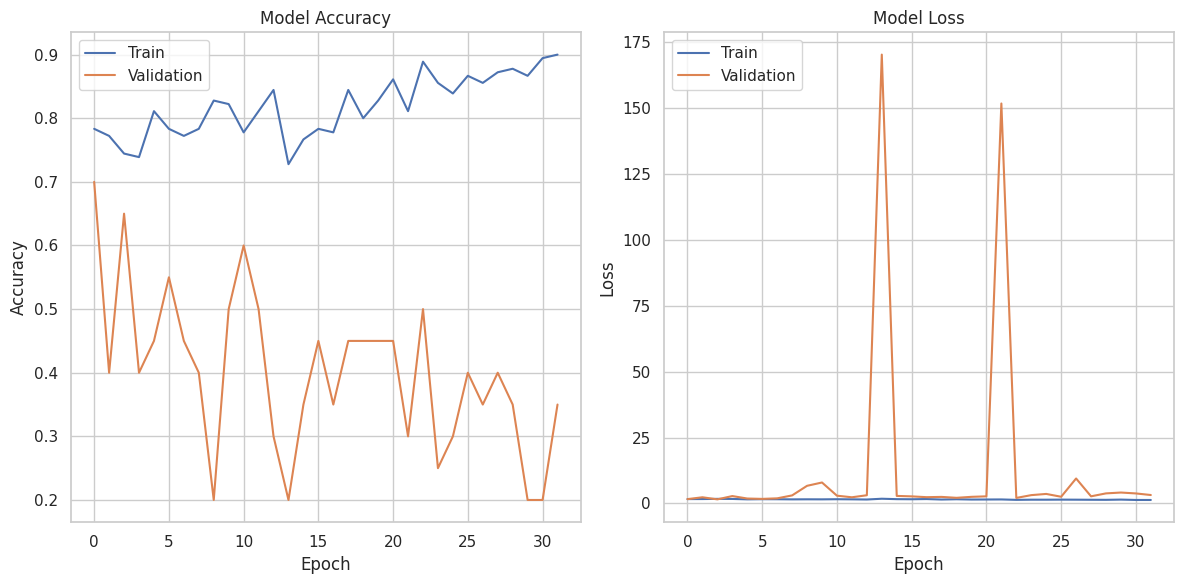

7/7 [==============================] - 0s 22ms/step
y_pred [[9.66306269e-01 3.79494787e-03 8.85564927e-03 2.10431498e-02]
 [7.27795541e-01 1.25344340e-02 2.49782160e-01 9.88775399e-03]
 [9.51952875e-01 9.43003315e-03 2.18619909e-02 1.67550817e-02]
 [9.13465917e-01 3.05072367e-02 3.89392301e-02 1.70875955e-02]
 [4.77870228e-03 7.01102272e-06 4.85224336e-05 9.95165825e-01]
 [8.66193175e-01 8.60923156e-03 1.00964524e-01 2.42330227e-02]
 [8.10779035e-01 2.47192365e-04 2.01619259e-04 1.88772067e-01]
 [8.91945302e-01 4.86775208e-03 4.61632712e-03 9.85706747e-02]
 [9.24289346e-01 5.84223727e-03 4.22257408e-02 2.76426058e-02]
 [8.00083950e-02 8.81704748e-01 1.93884708e-02 1.88983250e-02]
 [4.85963583e-01 2.37730592e-01 2.44463608e-01 3.18421833e-02]
 [2.04897914e-02 1.34926243e-03 9.76423442e-01 1.73753314e-03]
 [4.38152393e-03 5.73032503e-06 4.49349027e-05 9.95567739e-01]
 [2.33275339e-01 1.26268819e-01 6.24206901e-01 1.62489638e-02]
 [9.20858026e-01 7.68534467e-03 5.92738539e-02 1.21827200e-

6/6 [==============================] - 2s 255ms/step - loss: 1.7319 - sparse_categorical_accuracy: 0.7833 - val_loss: 2.0501 - val_sparse_categorical_accuracy: 0.7500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.5237 - sparse_categorical_accuracy: 0.8278

6/6 [==============================] - 1s 228ms/step - loss: 1.5237 - sparse_categorical_accuracy: 0.8278 - val_loss: 7.5417 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.4843 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 231ms/step - loss: 1.4843 - sparse_categorical_accuracy: 0.8444 - val_loss: 1.7518 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.4419 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 232ms/step - loss: 1.4419 - sparse_categorical_accuracy: 0.8444 - val_loss: 1.0839 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.3169 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 232ms/step - loss: 1.3169 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.4006 - val_sparse_categorical_accuracy: 0.8000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.3725 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 1s 233ms/step - loss: 1.3725 - sparse_categorical_accuracy: 0.9056 - val_loss: 1.2833 - val_sparse_categorical_accuracy: 0.7500
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.5576 - sparse_categorical_accuracy: 0.8389

6/6 [==============================] - 2s 288ms/step - loss: 1.5576 - sparse_categorical_accuracy: 0.8389 - val_loss: 2.0284 - val_sparse_categorical_accuracy: 0.7500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.5157 - sparse_categorical_accuracy: 0.8944

6/6 [==============================] - 2s 303ms/step - loss: 1.5157 - sparse_categorical_accuracy: 0.8944 - val_loss: 3.5893 - val_sparse_categorical_accuracy: 0.4000
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.4203 - sparse_categorical_accuracy: 0.8611

6/6 [==============================] - 1s 262ms/step - loss: 1.4203 - sparse_categorical_accuracy: 0.8611 - val_loss: 3.0455 - val_sparse_categorical_accuracy: 0.4500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.5191 - sparse_categorical_accuracy: 0.8389

6/6 [==============================] - 1s 226ms/step - loss: 1.5191 - sparse_categorical_accuracy: 0.8389 - val_loss: 2.0244 - val_sparse_categorical_accuracy: 0.6500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.4484 - sparse_categorical_accuracy: 0.8556

6/6 [==============================] - 1s 233ms/step - loss: 1.4484 - sparse_categorical_accuracy: 0.8556 - val_loss: 1.7814 - val_sparse_categorical_accuracy: 0.5000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.3872 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 1s 236ms/step - loss: 1.3872 - sparse_categorical_accuracy: 0.8667 - val_loss: 1.3834 - val_sparse_categorical_accuracy: 0.8500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.3591 - sparse_categorical_accuracy: 0.8500

6/6 [==============================] - 1s 233ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.8500 - val_loss: 1.6699 - val_sparse_categorical_accuracy: 0.6500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.3704 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 1s 234ms/step - loss: 1.3704 - sparse_categorical_accuracy: 0.8667 - val_loss: 1.0573 - val_sparse_categorical_accuracy: 0.9000
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.4043 - sparse_categorical_accuracy: 0.8778

6/6 [==============================] - 1s 228ms/step - loss: 1.4043 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.2978 - val_sparse_categorical_accuracy: 0.8500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.3291 - sparse_categorical_accuracy: 0.9222

6/6 [==============================] - 1s 232ms/step - loss: 1.3291 - sparse_categorical_accuracy: 0.9222 - val_loss: 1.2957 - val_sparse_categorical_accuracy: 0.8000
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.4261 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 1s 269ms/step - loss: 1.4261 - sparse_categorical_accuracy: 0.8667 - val_loss: 1.3864 - val_sparse_categorical_accuracy: 0.8500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.3324 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 2s 302ms/step - loss: 1.3324 - sparse_categorical_accuracy: 0.9056 - val_loss: 1.2274 - val_sparse_categorical_accuracy: 0.8000
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.3277 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 2s 294ms/step - loss: 1.3277 - sparse_categorical_accuracy: 0.9111 - val_loss: 3.6905 - val_sparse_categorical_accuracy: 0.5000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.3953 - sparse_categorical_accuracy: 0.8667

6/6 [==============================] - 1s 226ms/step - loss: 1.3953 - sparse_categorical_accuracy: 0.8667 - val_loss: 1.6850 - val_sparse_categorical_accuracy: 0.7000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.4473 - sparse_categorical_accuracy: 0.8833

6/6 [==============================] - 1s 228ms/step - loss: 1.4473 - sparse_categorical_accuracy: 0.8833 - val_loss: 2.6331 - val_sparse_categorical_accuracy: 0.6500
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.4268 - sparse_categorical_accuracy: 0.8611

6/6 [==============================] - 1s 229ms/step - loss: 1.4268 - sparse_categorical_accuracy: 0.8611 - val_loss: 4.7309 - val_sparse_categorical_accuracy: 0.4000
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.3647 - sparse_categorical_accuracy: 0.8833

6/6 [==============================] - 1s 236ms/step - loss: 1.3647 - sparse_categorical_accuracy: 0.8833 - val_loss: 3.1655 - val_sparse_categorical_accuracy: 0.7500
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.3302 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 237ms/step - loss: 1.3302 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.2628 - val_sparse_categorical_accuracy: 0.7000
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.4829 - sparse_categorical_accuracy: 0.8556

6/6 [==============================] - 1s 231ms/step - loss: 1.4829 - sparse_categorical_accuracy: 0.8556 - val_loss: 3.0589 - val_sparse_categorical_accuracy: 0.6500
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.3120 - sparse_categorical_accuracy: 0.8889

6/6 [==============================] - 1s 229ms/step - loss: 1.3120 - sparse_categorical_accuracy: 0.8889 - val_loss: 3.2537 - val_sparse_categorical_accuracy: 0.6500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.3402 - sparse_categorical_accuracy: 0.8833

6/6 [==============================] - 1s 244ms/step - loss: 1.3402 - sparse_categorical_accuracy: 0.8833 - val_loss: 2.4021 - val_sparse_categorical_accuracy: 0.6000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.3280 - sparse_categorical_accuracy: 0.9056

6/6 [==============================] - 2s 288ms/step - loss: 1.3280 - sparse_categorical_accuracy: 0.9056 - val_loss: 2.4180 - val_sparse_categorical_accuracy: 0.6500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.3005 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 2s 307ms/step - loss: 1.3005 - sparse_categorical_accuracy: 0.9000 - val_loss: 1.3186 - val_sparse_categorical_accuracy: 0.9000
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.2683 - sparse_categorical_accuracy: 0.9333

6/6 [==============================] - 1s 241ms/step - loss: 1.2683 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.1385 - val_sparse_categorical_accuracy: 0.7000
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.3035 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 230ms/step - loss: 1.3035 - sparse_categorical_accuracy: 0.9167 - val_loss: 2.1811 - val_sparse_categorical_accuracy: 0.5500
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.3585 - sparse_categorical_accuracy: 0.8889

6/6 [==============================] - 1s 227ms/step - loss: 1.3585 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.7202 - val_sparse_categorical_accuracy: 0.6000


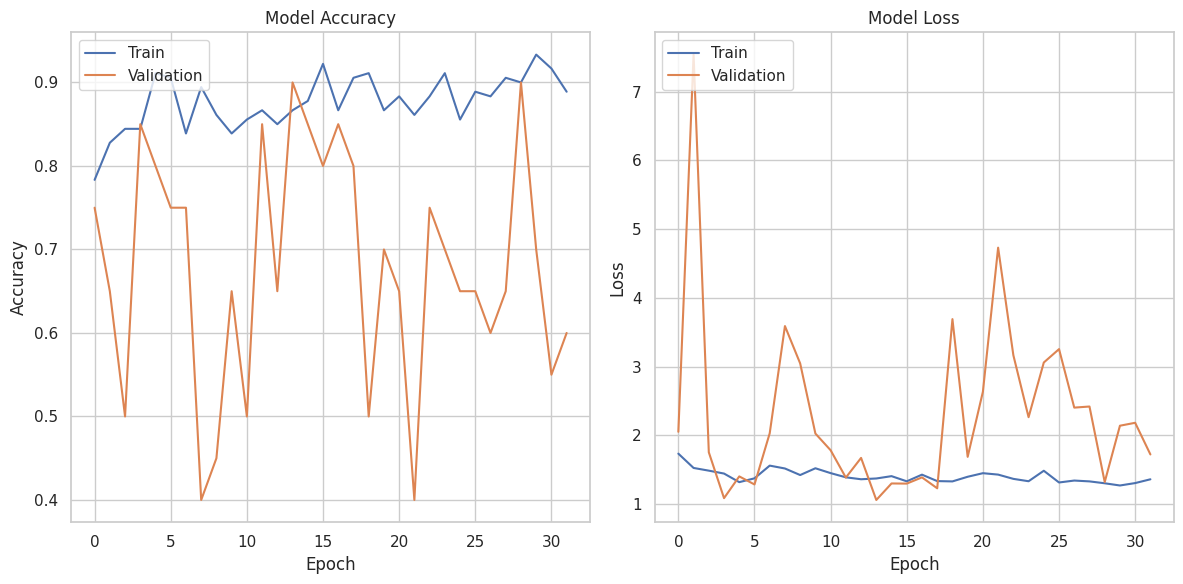

7/7 [==============================] - 0s 22ms/step
y_pred [[7.44659722e-01 2.31064181e-03 3.37914308e-03 2.49650598e-01]
 [1.16293132e-02 3.06387339e-03 9.83331144e-01 1.97564857e-03]
 [9.34403896e-01 1.82520249e-03 2.01504654e-03 6.17558770e-02]
 [9.15131345e-03 9.69432294e-01 1.99503694e-02 1.46608113e-03]
 [9.33247060e-03 3.53710893e-05 1.43424200e-04 9.90488648e-01]
 [9.47570205e-01 2.67808465e-03 2.16795062e-03 4.75838296e-02]
 [9.99765217e-01 1.00739926e-05 3.52403254e-06 2.21150898e-04]
 [9.94819582e-01 1.01942150e-03 7.53394910e-04 3.40762082e-03]
 [4.57699131e-03 1.00510024e-05 4.37140588e-05 9.95369256e-01]
 [5.82215309e-01 4.19885218e-02 3.27611774e-01 4.81843650e-02]
 [5.33077084e-02 4.07656282e-02 9.03772175e-01 2.15450930e-03]
 [2.71529667e-02 5.83738554e-03 9.62303340e-01 4.70632827e-03]
 [9.92366811e-04 6.16284751e-07 3.25019323e-06 9.99003828e-01]
 [4.07143496e-03 8.54446832e-03 9.87365186e-01 1.89346429e-05]
 [3.11138451e-01 2.18997244e-03 3.08620837e-03 6.83585346e-

6/6 [==============================] - 2s 322ms/step - loss: 1.3669 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.3158 - val_sparse_categorical_accuracy: 0.7500
Epoch 2/32
6/6 [==============================] - ETA: 0s - loss: 1.3090 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 2s 296ms/step - loss: 1.3090 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.3531 - val_sparse_categorical_accuracy: 0.8000
Epoch 3/32
6/6 [==============================] - ETA: 0s - loss: 1.3232 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 271ms/step - loss: 1.3232 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.0324 - val_sparse_categorical_accuracy: 0.8500
Epoch 4/32
6/6 [==============================] - ETA: 0s - loss: 1.2447 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 236ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.0387 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/32
6/6 [==============================] - ETA: 0s - loss: 1.3105 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 236ms/step - loss: 1.3105 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.4657 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/32
6/6 [==============================] - ETA: 0s - loss: 1.3844 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 240ms/step - loss: 1.3844 - sparse_categorical_accuracy: 0.9000 - val_loss: 1.4746 - val_sparse_categorical_accuracy: 0.7000
Epoch 7/32
6/6 [==============================] - ETA: 0s - loss: 1.2729 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 233ms/step - loss: 1.2729 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.5181 - val_sparse_categorical_accuracy: 0.7500
Epoch 8/32
6/6 [==============================] - ETA: 0s - loss: 1.3671 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 233ms/step - loss: 1.3671 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.4095 - val_sparse_categorical_accuracy: 0.7500
Epoch 9/32
6/6 [==============================] - ETA: 0s - loss: 1.2864 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 243ms/step - loss: 1.2864 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.1804 - val_sparse_categorical_accuracy: 0.8500
Epoch 10/32
6/6 [==============================] - ETA: 0s - loss: 1.3042 - sparse_categorical_accuracy: 0.8889

6/6 [==============================] - 1s 240ms/step - loss: 1.3042 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.5423 - val_sparse_categorical_accuracy: 0.7500
Epoch 11/32
6/6 [==============================] - ETA: 0s - loss: 1.1694 - sparse_categorical_accuracy: 0.9722

6/6 [==============================] - 2s 296ms/step - loss: 1.1694 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.8989 - val_sparse_categorical_accuracy: 0.9000
Epoch 12/32
6/6 [==============================] - ETA: 0s - loss: 1.1803 - sparse_categorical_accuracy: 0.9667

6/6 [==============================] - 2s 304ms/step - loss: 1.1803 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.7126 - val_sparse_categorical_accuracy: 0.6500
Epoch 13/32
6/6 [==============================] - ETA: 0s - loss: 1.2559 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 282ms/step - loss: 1.2559 - sparse_categorical_accuracy: 0.9500 - val_loss: 2.4863 - val_sparse_categorical_accuracy: 0.5500
Epoch 14/32
6/6 [==============================] - ETA: 0s - loss: 1.2331 - sparse_categorical_accuracy: 0.9333

6/6 [==============================] - 1s 232ms/step - loss: 1.2331 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.1474 - val_sparse_categorical_accuracy: 0.5500
Epoch 15/32
6/6 [==============================] - ETA: 0s - loss: 1.2495 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 237ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.9167 - val_loss: 2.3139 - val_sparse_categorical_accuracy: 0.6500
Epoch 16/32
6/6 [==============================] - ETA: 0s - loss: 1.2845 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 231ms/step - loss: 1.2845 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.6434 - val_sparse_categorical_accuracy: 0.7500
Epoch 17/32
6/6 [==============================] - ETA: 0s - loss: 1.2556 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 228ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.5584 - val_sparse_categorical_accuracy: 0.8500
Epoch 18/32
6/6 [==============================] - ETA: 0s - loss: 1.3709 - sparse_categorical_accuracy: 0.9000

6/6 [==============================] - 1s 232ms/step - loss: 1.3709 - sparse_categorical_accuracy: 0.9000 - val_loss: 3.9689 - val_sparse_categorical_accuracy: 0.4500
Epoch 19/32
6/6 [==============================] - ETA: 0s - loss: 1.2693 - sparse_categorical_accuracy: 0.9444

6/6 [==============================] - 1s 231ms/step - loss: 1.2693 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.2067 - val_sparse_categorical_accuracy: 0.6000
Epoch 20/32
6/6 [==============================] - ETA: 0s - loss: 1.2653 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 239ms/step - loss: 1.2653 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.5811 - val_sparse_categorical_accuracy: 0.7000
Epoch 21/32
6/6 [==============================] - ETA: 0s - loss: 1.2027 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 273ms/step - loss: 1.2027 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.4589 - val_sparse_categorical_accuracy: 0.7000
Epoch 22/32
6/6 [==============================] - ETA: 0s - loss: 1.1681 - sparse_categorical_accuracy: 0.9611

6/6 [==============================] - 2s 309ms/step - loss: 1.1681 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.7500
Epoch 23/32
6/6 [==============================] - ETA: 0s - loss: 1.3606 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 2s 292ms/step - loss: 1.3606 - sparse_categorical_accuracy: 0.9167 - val_loss: 1.9038 - val_sparse_categorical_accuracy: 0.8000
Epoch 24/32
6/6 [==============================] - ETA: 0s - loss: 1.2790 - sparse_categorical_accuracy: 0.9222

6/6 [==============================] - 1s 230ms/step - loss: 1.2790 - sparse_categorical_accuracy: 0.9222 - val_loss: 5.6945 - val_sparse_categorical_accuracy: 0.5500
Epoch 25/32
6/6 [==============================] - ETA: 0s - loss: 1.2463 - sparse_categorical_accuracy: 0.9278

6/6 [==============================] - 1s 231ms/step - loss: 1.2463 - sparse_categorical_accuracy: 0.9278 - val_loss: 3.3889 - val_sparse_categorical_accuracy: 0.5000
Epoch 26/32
6/6 [==============================] - ETA: 0s - loss: 1.3536 - sparse_categorical_accuracy: 0.9167

6/6 [==============================] - 1s 234ms/step - loss: 1.3536 - sparse_categorical_accuracy: 0.9167 - val_loss: 3.1029 - val_sparse_categorical_accuracy: 0.6500
Epoch 27/32
6/6 [==============================] - ETA: 0s - loss: 1.3285 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 234ms/step - loss: 1.3285 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.7700 - val_sparse_categorical_accuracy: 0.6000
Epoch 28/32
6/6 [==============================] - ETA: 0s - loss: 1.4796 - sparse_categorical_accuracy: 0.8444

6/6 [==============================] - 1s 239ms/step - loss: 1.4796 - sparse_categorical_accuracy: 0.8444 - val_loss: 2.7410 - val_sparse_categorical_accuracy: 0.3500
Epoch 29/32
6/6 [==============================] - ETA: 0s - loss: 1.2738 - sparse_categorical_accuracy: 0.9389

6/6 [==============================] - 1s 241ms/step - loss: 1.2738 - sparse_categorical_accuracy: 0.9389 - val_loss: 2.3828 - val_sparse_categorical_accuracy: 0.5500
Epoch 30/32
6/6 [==============================] - ETA: 0s - loss: 1.3139 - sparse_categorical_accuracy: 0.9111

6/6 [==============================] - 1s 245ms/step - loss: 1.3139 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.8070 - val_sparse_categorical_accuracy: 0.7500
Epoch 31/32
6/6 [==============================] - ETA: 0s - loss: 1.2228 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 1s 267ms/step - loss: 1.2228 - sparse_categorical_accuracy: 0.9500 - val_loss: 2.1105 - val_sparse_categorical_accuracy: 0.5000
Epoch 32/32
6/6 [==============================] - ETA: 0s - loss: 1.2252 - sparse_categorical_accuracy: 0.9500

6/6 [==============================] - 2s 298ms/step - loss: 1.2252 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.2129 - val_sparse_categorical_accuracy: 0.7000


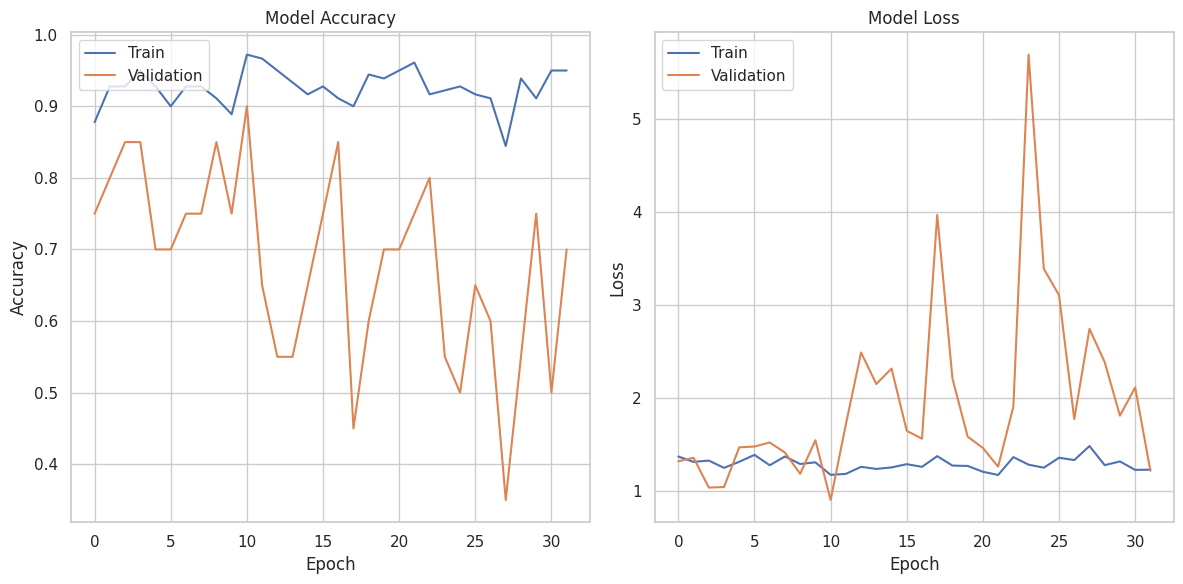

7/7 [==============================] - 0s 21ms/step
y_pred [[9.91085351e-01 2.02631345e-03 2.14483752e-03 4.74341027e-03]
 [1.24039799e-02 1.40401791e-03 9.83807743e-01 2.38425145e-03]
 [9.88547206e-01 2.40433891e-03 2.01875367e-03 7.02961767e-03]
 [2.05368549e-03 9.94760096e-01 1.19910482e-03 1.98711944e-03]
 [1.20953040e-03 6.27842337e-06 3.27638045e-05 9.98751402e-01]
 [9.71969604e-01 1.67358425e-02 5.37325442e-03 5.92126604e-03]
 [9.97027218e-01 8.31119833e-04 3.51851486e-04 1.78979384e-03]
 [7.11738706e-01 6.87169703e-03 8.02644528e-03 2.73363203e-01]
 [2.11382750e-03 1.66381360e-05 1.06516010e-04 9.97762918e-01]
 [2.08301600e-02 1.31161258e-01 8.46981168e-01 1.02745707e-03]
 [2.03301519e-01 8.85417312e-02 6.90223992e-01 1.79327633e-02]
 [1.53308902e-02 1.97355985e-03 9.80885446e-01 1.81006896e-03]
 [3.80596076e-03 4.17542615e-05 2.49654346e-04 9.95902598e-01]
 [3.39889944e-01 7.77135789e-02 5.65252185e-01 1.71443671e-02]
 [8.50857556e-01 5.64187840e-02 9.71202087e-03 8.30116794e-

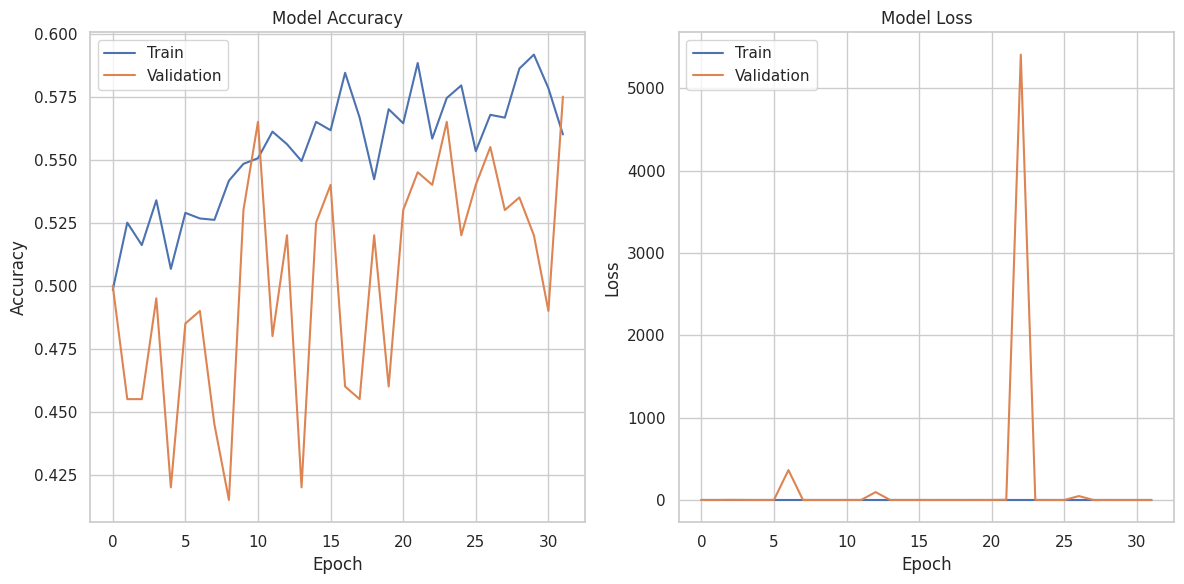

63/63 [==============================] - 1s 18ms/step
y_pred [[0.30250153 0.71338266]
 [0.35731667 0.66992927]
 [0.5009777  0.496089  ]
 ...
 [0.3406894  0.6586735 ]
 [0.7223381  0.28135493]
 [0.14953142 0.83511615]]
Accuracy: 0.48
Confusion Matrix: [[198 790]
 [250 762]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.7441 - accuracy: 0.5519
Epoch 1: val_accuracy improved from -inf to 0.54500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_1_best_model.keras
57/57 [==============================] - 6s 104ms/step - loss: 1.7404 - accuracy: 0.5517 - val_loss: 1.7032 - val_accuracy: 0.5450
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.7353 - accuracy: 0.5904
Epoch 2: val_accuracy did not improve from 0.54500
57/57 [==============================] - 5s 94ms/step - loss: 1.7318 - accuracy: 0.5906 - val_loss: 1.8474 - val_accuracy:

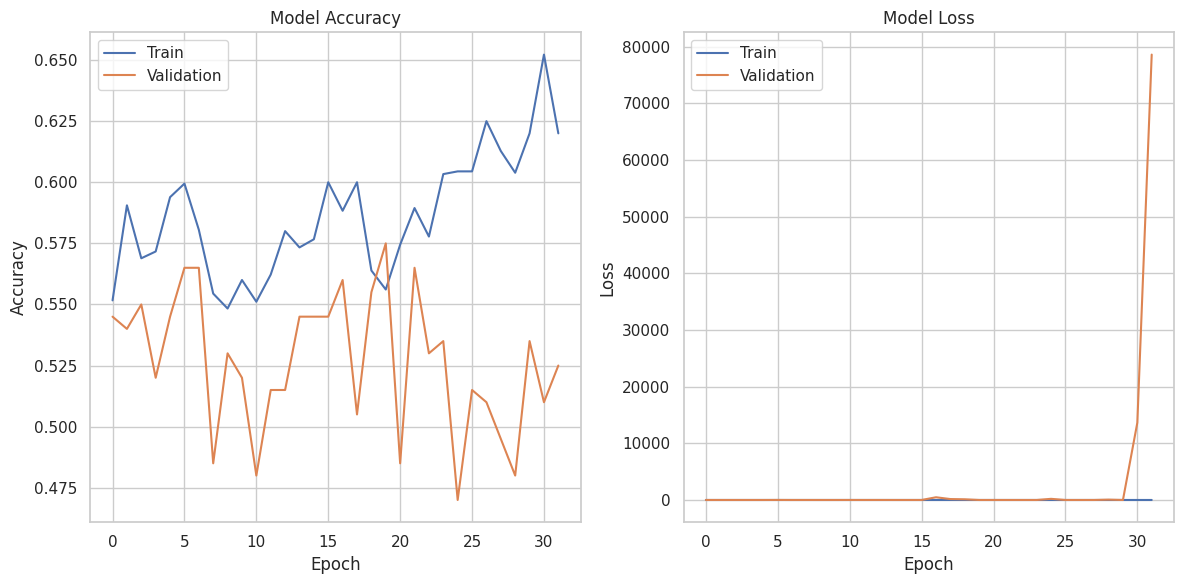

63/63 [==============================] - 1s 17ms/step
y_pred [[3.7230837e-01 6.3070184e-01]
 [9.9848467e-01 2.1145723e-03]
 [1.0000000e+00 1.4726888e-13]
 ...
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 4.7691079e-25]
 [1.0000000e+00 0.0000000e+00]]
Accuracy: 0.5105
Confusion Matrix: [[640 348]
 [631 381]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.7121 - accuracy: 0.6295
Epoch 1: val_accuracy improved from -inf to 0.60500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_2_best_model.keras
57/57 [==============================] - 6s 100ms/step - loss: 1.7085 - accuracy: 0.6294 - val_loss: 2.0648 - val_accuracy: 0.6050
Epoch 2/32
57/57 [==============================] - ETA: 0s - loss: 1.7031 - accuracy: 0.6339
Epoch 2: val_accuracy improved from 0.60500 to 0.64000, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.da

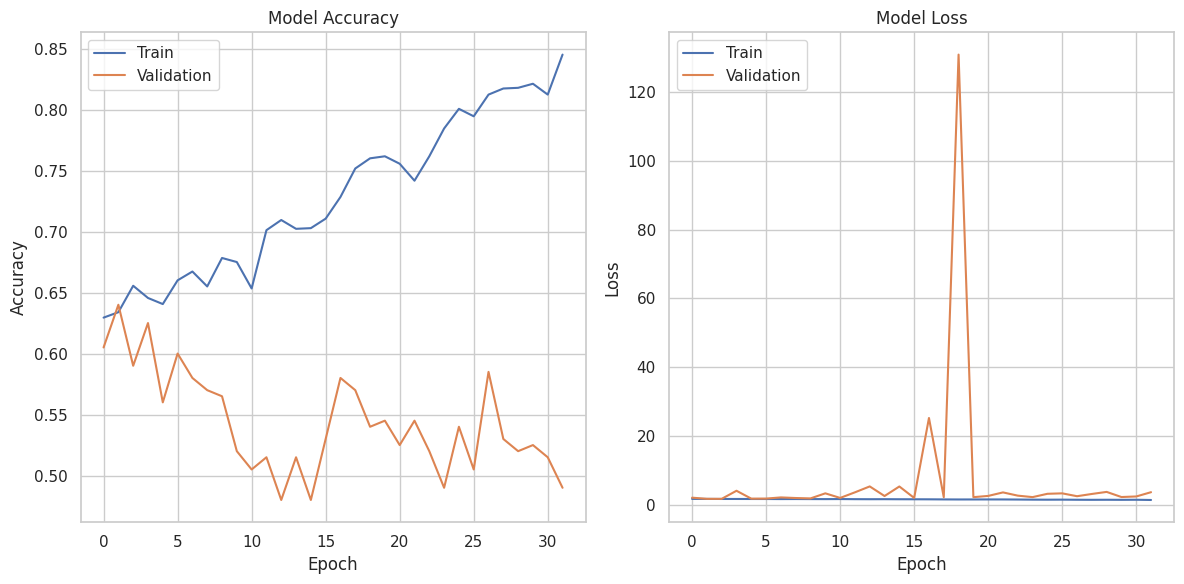

63/63 [==============================] - 1s 16ms/step
y_pred [[2.4961634e-04 9.9976319e-01]
 [1.7098896e-01 8.2831079e-01]
 [6.6417537e-04 9.9937445e-01]
 ...
 [6.7786514e-03 9.9273020e-01]
 [1.0931540e-01 8.9017397e-01]
 [5.4791801e-02 9.4436604e-01]]
Accuracy: 0.5045
Confusion Matrix: [[158 830]
 [161 851]]
Epoch 1/32
57/57 [==============================] - ETA: 0s - loss: 1.4992 - accuracy: 0.7928
Epoch 1: val_accuracy improved from -inf to 0.84500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_3_best_model.keras
57/57 [==============================] - 6s 109ms/step - loss: 1.4992 - accuracy: 0.7928 - val_loss: 1.4579 - val_accuracy: 0.8450
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.4393 - accuracy: 0.8337
Epoch 2: val_accuracy did not improve from 0.84500
57/57 [==============================] - 5s 93ms/step - loss: 1.4355 - accuracy: 0.8

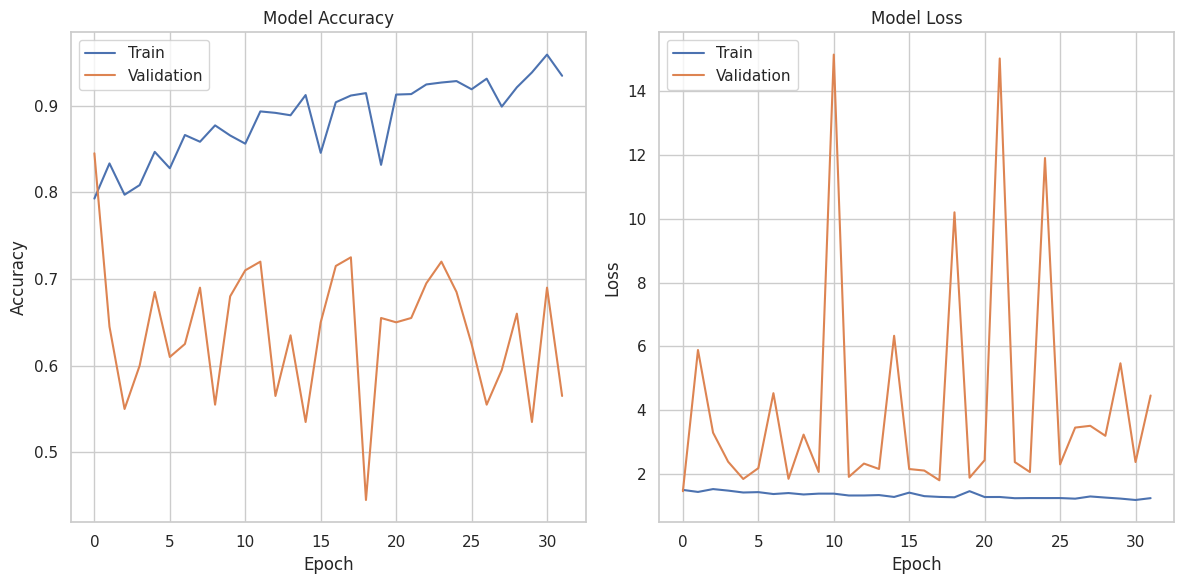

63/63 [==============================] - 1s 16ms/step
y_pred [[1.4347819e-06 9.9999905e-01]
 [1.1724834e-03 9.9883407e-01]
 [2.6883318e-03 9.9722904e-01]
 ...
 [7.5474512e-05 9.9993205e-01]
 [1.0588339e-09 1.0000000e+00]
 [4.4513126e-05 9.9996424e-01]]
Accuracy: 0.516
Confusion Matrix: [[160 828]
 [140 872]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.2561 - accuracy: 0.9224
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_4_best_model.keras
57/57 [==============================] - 6s 98ms/step - loss: 1.2520 - accuracy: 0.9228 - val_loss: 1.6318 - val_accuracy: 0.8200
Epoch 2/32
57/57 [==============================] - ETA: 0s - loss: 1.2272 - accuracy: 0.9378
Epoch 2: val_accuracy improved from 0.82000 to 0.86500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data

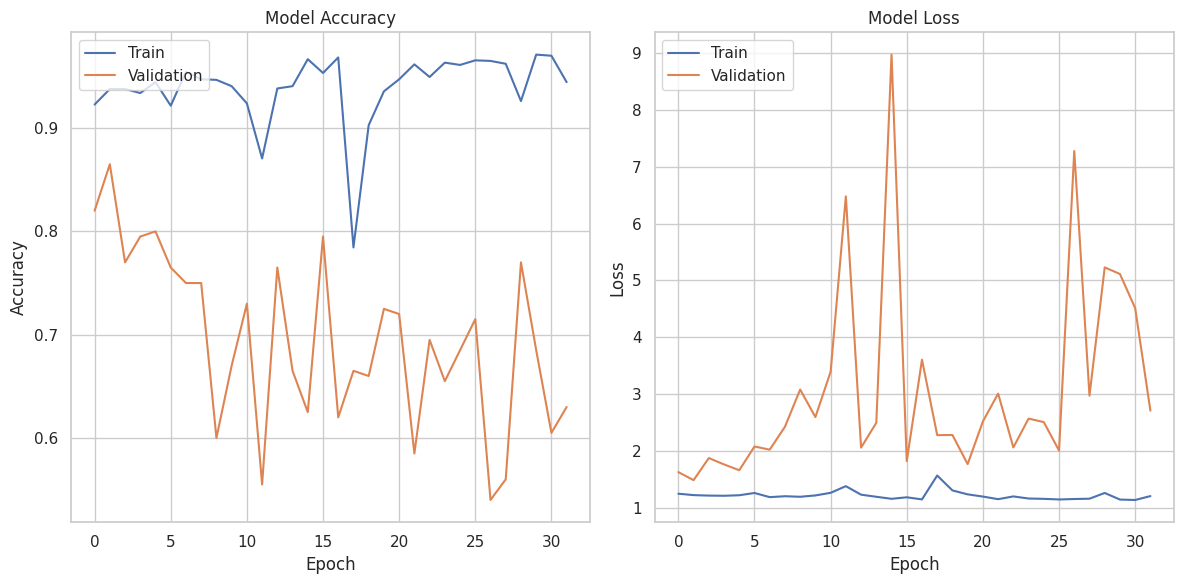

63/63 [==============================] - 1s 16ms/step
y_pred [[0.00201424 0.99815243]
 [0.3671968  0.63468915]
 [0.01250127 0.9874172 ]
 ...
 [0.2605072  0.74123824]
 [0.0018529  0.99822074]
 [0.18004754 0.81949186]]
Accuracy: 0.5155
Confusion Matrix: [[180 808]
 [161 851]]
Epoch 1/32
57/57 [==============================] - ETA: 0s - loss: 1.2077 - accuracy: 0.9406
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_5_best_model.keras
57/57 [==============================] - 6s 111ms/step - loss: 1.2077 - accuracy: 0.9406 - val_loss: 1.4421 - val_accuracy: 0.8750
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1800 - accuracy: 0.9537
Epoch 2: val_accuracy did not improve from 0.87500
57/57 [==============================] - 5s 94ms/step - loss: 1.1796 - accuracy: 0.9528 - val_loss: 3.9055 - val_accurac

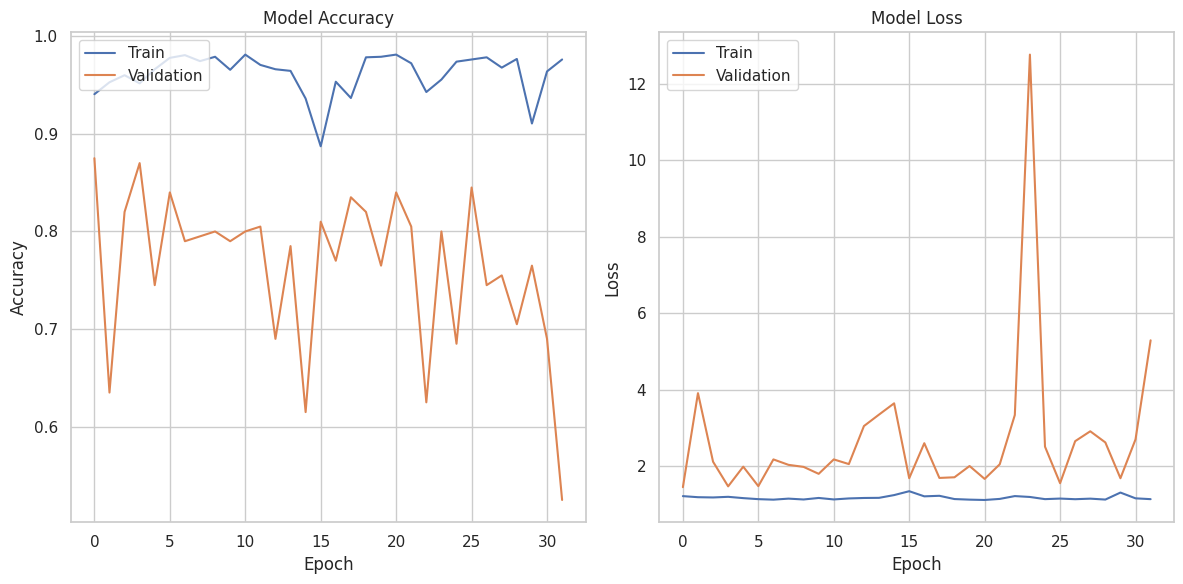

63/63 [==============================] - 1s 16ms/step
y_pred [[3.4274341e-05 9.9996579e-01]
 [1.3585058e-04 9.9987161e-01]
 [4.6022092e-03 9.9542540e-01]
 ...
 [7.8087890e-01 2.1631645e-01]
 [1.3308347e-08 1.0000000e+00]
 [7.4054062e-01 2.5806841e-01]]
Accuracy: 0.511
Confusion Matrix: [[ 85 903]
 [ 75 937]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.1685 - accuracy: 0.9660
Epoch 1: val_accuracy improved from -inf to 0.79000, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_6_best_model.keras
57/57 [==============================] - 6s 100ms/step - loss: 1.1647 - accuracy: 0.9661 - val_loss: 2.8708 - val_accuracy: 0.7900
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1361 - accuracy: 0.9782
Epoch 2: val_accuracy improved from 0.79000 to 0.86000, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.dat

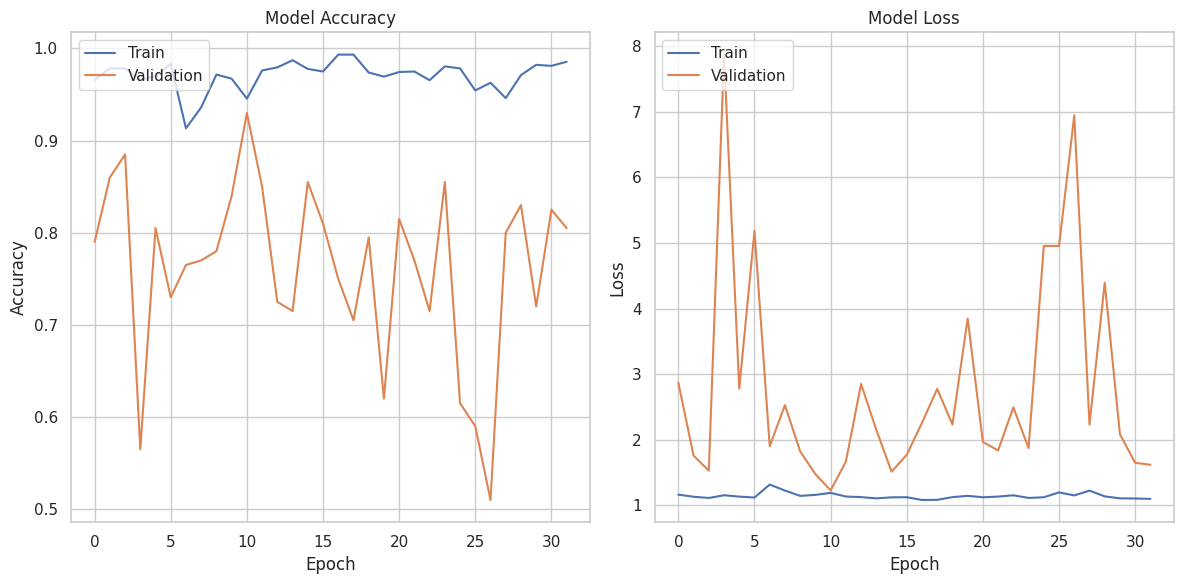

63/63 [==============================] - 1s 16ms/step
y_pred [[7.65856676e-05 9.99954224e-01]
 [9.99994278e-01 5.75414106e-06]
 [9.99999881e-01 1.09136494e-07]
 ...
 [8.09962392e-01 1.92631200e-01]
 [6.55522163e-05 9.99962568e-01]
 [9.99991775e-01 8.20476907e-06]]
Accuracy: 0.49
Confusion Matrix: [[403 585]
 [435 577]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.1039 - accuracy: 0.9866
Epoch 1: val_accuracy improved from -inf to 0.75500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_7_best_model.keras
57/57 [==============================] - 7s 114ms/step - loss: 1.1002 - accuracy: 0.9867 - val_loss: 2.9569 - val_accuracy: 0.7550
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1500 - accuracy: 0.9710
Epoch 2: val_accuracy did not improve from 0.75500
57/57 [==============================] - 5s 94ms/step - loss: 1.1519 - acc

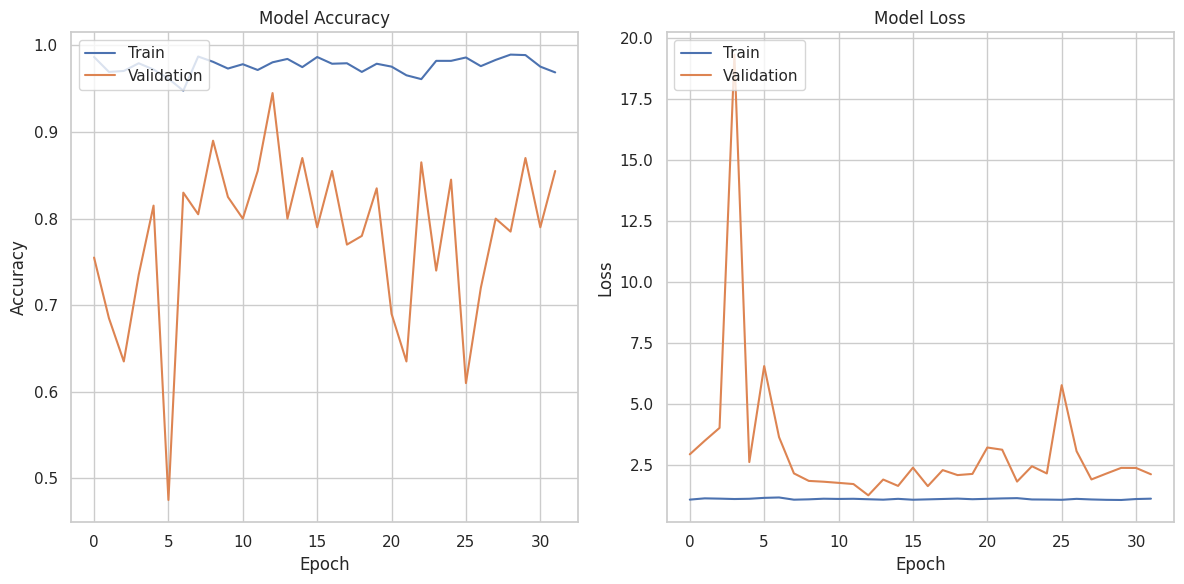

63/63 [==============================] - 1s 18ms/step
y_pred [[1.7898477e-04 9.9984062e-01]
 [1.0000000e+00 3.4143039e-08]
 [1.0000000e+00 3.2859724e-08]
 ...
 [9.9999309e-01 6.6700454e-06]
 [7.5701356e-01 2.4245436e-01]
 [1.0000000e+00 4.1283542e-08]]
Accuracy: 0.4735
Confusion Matrix: [[578 410]
 [643 369]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.2248 - accuracy: 0.9470
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_8_best_model.keras
57/57 [==============================] - 6s 104ms/step - loss: 1.2251 - accuracy: 0.9456 - val_loss: 1.8927 - val_accuracy: 0.7750
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1313 - accuracy: 0.9766
Epoch 2: val_accuracy improved from 0.77500 to 0.87500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.da

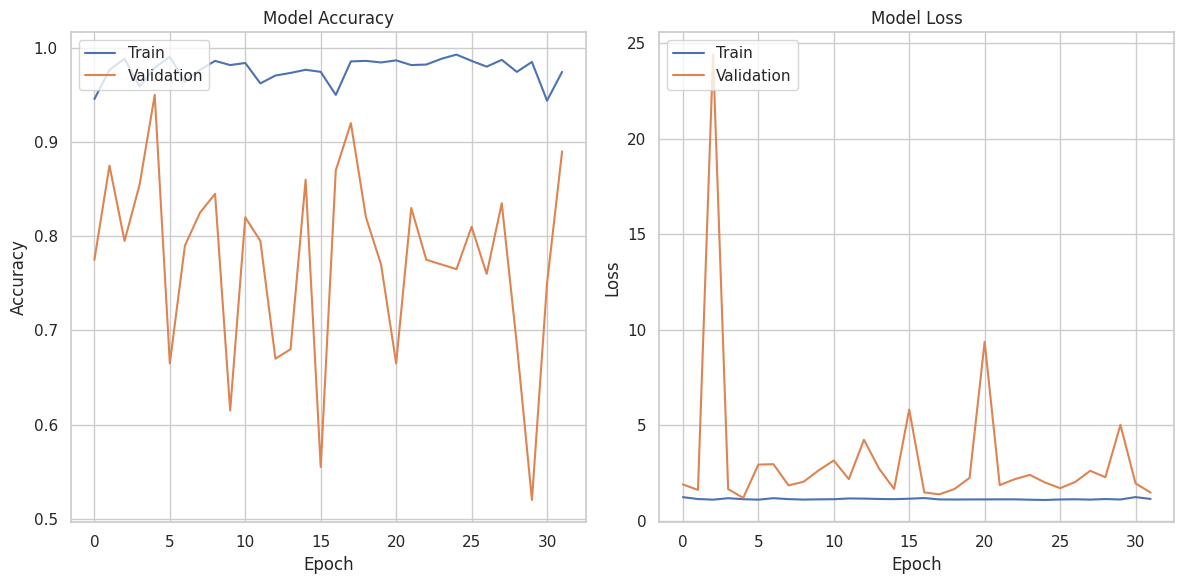

63/63 [==============================] - 1s 16ms/step
y_pred [[1.0290834e-01 8.9352542e-01]
 [9.9979943e-01 1.8515439e-04]
 [9.0645194e-01 9.5742024e-02]
 ...
 [9.9991393e-01 7.7808239e-05]
 [5.2416104e-01 4.7659546e-01]
 [9.9988067e-01 1.0854421e-04]]
Accuracy: 0.496
Confusion Matrix: [[470 518]
 [490 522]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.1175 - accuracy: 0.9794
Epoch 1: val_accuracy improved from -inf to 0.81000, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_ElossPointNet_fold_9_best_model.keras
57/57 [==============================] - 6s 101ms/step - loss: 1.1180 - accuracy: 0.9783 - val_loss: 2.4807 - val_accuracy: 0.8100
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1455 - accuracy: 0.9654
Epoch 2: val_accuracy improved from 0.81000 to 0.86500, saving model to /content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.dat

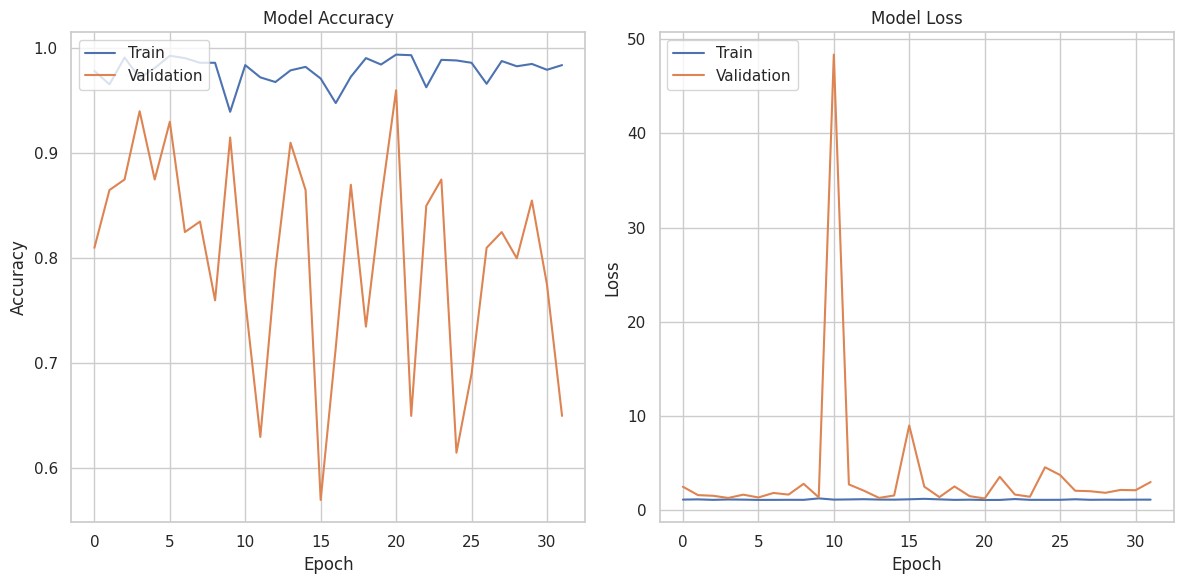

63/63 [==============================] - 1s 17ms/step
y_pred [[3.9203684e-03 9.9599540e-01]
 [4.8656646e-02 9.4882989e-01]
 [9.9999893e-01 9.6870178e-07]
 ...
 [7.0228655e-04 9.9931192e-01]
 [1.4533583e-04 9.9986613e-01]
 [8.4139844e-03 9.9122798e-01]]
Accuracy: 0.5
Confusion Matrix: [[240 748]
 [252 760]]
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
Average Train Time: 3.288293787638346 minutes
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_AlphaSPointNet
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.6013 - sparse_categ

57/57 [==============================] - 6s 100ms/step - loss: 2.5965 - sparse_categorical_accuracy: 0.3183 - val_loss: 2.6634 - val_sparse_categorical_accuracy: 0.3400
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.2059 - sparse_categorical_accuracy: 0.3471

57/57 [==============================] - 5s 94ms/step - loss: 2.2023 - sparse_categorical_accuracy: 0.3472 - val_loss: 2.2633 - val_sparse_categorical_accuracy: 0.2950
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.1957 - sparse_categorical_accuracy: 0.3343

57/57 [==============================] - 6s 104ms/step - loss: 2.1917 - sparse_categorical_accuracy: 0.3339 - val_loss: 3.4536 - val_sparse_categorical_accuracy: 0.3000
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.2056 - sparse_categorical_accuracy: 0.3410

57/57 [==============================] - 5s 95ms/step - loss: 2.2018 - sparse_categorical_accuracy: 0.3417 - val_loss: 2.5613 - val_sparse_categorical_accuracy: 0.3200
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.1894 - sparse_categorical_accuracy: 0.3387

57/57 [==============================] - 5s 94ms/step - loss: 2.1853 - sparse_categorical_accuracy: 0.3389 - val_loss: 2.1522 - val_sparse_categorical_accuracy: 0.2900
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.1842 - sparse_categorical_accuracy: 0.3331

57/57 [==============================] - 6s 101ms/step - loss: 2.1805 - sparse_categorical_accuracy: 0.3328 - val_loss: 2.2479 - val_sparse_categorical_accuracy: 0.3250
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.1819 - sparse_categorical_accuracy: 0.3326

57/57 [==============================] - 5s 96ms/step - loss: 2.1778 - sparse_categorical_accuracy: 0.3333 - val_loss: 254.4167 - val_sparse_categorical_accuracy: 0.3500
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.1988 - sparse_categorical_accuracy: 0.3331

57/57 [==============================] - 6s 101ms/step - loss: 2.1955 - sparse_categorical_accuracy: 0.3328 - val_loss: 2.1544 - val_sparse_categorical_accuracy: 0.3200
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.1797 - sparse_categorical_accuracy: 0.3337

57/57 [==============================] - 6s 99ms/step - loss: 2.1757 - sparse_categorical_accuracy: 0.3350 - val_loss: 2.2755 - val_sparse_categorical_accuracy: 0.3100
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.1735 - sparse_categorical_accuracy: 0.3588

57/57 [==============================] - 5s 95ms/step - loss: 2.1703 - sparse_categorical_accuracy: 0.3589 - val_loss: 2.2234 - val_sparse_categorical_accuracy: 0.3500
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.1675 - sparse_categorical_accuracy: 0.3516

57/57 [==============================] - 6s 106ms/step - loss: 2.1645 - sparse_categorical_accuracy: 0.3511 - val_loss: 2.2116 - val_sparse_categorical_accuracy: 0.3150
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.1716 - sparse_categorical_accuracy: 0.3532

57/57 [==============================] - 5s 94ms/step - loss: 2.1681 - sparse_categorical_accuracy: 0.3528 - val_loss: 2.1695 - val_sparse_categorical_accuracy: 0.3400
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.1759 - sparse_categorical_accuracy: 0.3482

57/57 [==============================] - 5s 97ms/step - loss: 2.1731 - sparse_categorical_accuracy: 0.3483 - val_loss: 2.2145 - val_sparse_categorical_accuracy: 0.3200
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.1718 - sparse_categorical_accuracy: 0.3750

57/57 [==============================] - 6s 98ms/step - loss: 2.1685 - sparse_categorical_accuracy: 0.3744 - val_loss: 2.2671 - val_sparse_categorical_accuracy: 0.3150
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.1710 - sparse_categorical_accuracy: 0.3382

57/57 [==============================] - 5s 94ms/step - loss: 2.1674 - sparse_categorical_accuracy: 0.3383 - val_loss: 2.1685 - val_sparse_categorical_accuracy: 0.3000
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.1657 - sparse_categorical_accuracy: 0.3806

57/57 [==============================] - 6s 100ms/step - loss: 2.1630 - sparse_categorical_accuracy: 0.3800 - val_loss: 6.2797 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.1595 - sparse_categorical_accuracy: 0.3694

57/57 [==============================] - 5s 97ms/step - loss: 2.1559 - sparse_categorical_accuracy: 0.3700 - val_loss: 2.1795 - val_sparse_categorical_accuracy: 0.3000
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.1607 - sparse_categorical_accuracy: 0.3800

57/57 [==============================] - 5s 94ms/step - loss: 2.1569 - sparse_categorical_accuracy: 0.3806 - val_loss: 2.6119 - val_sparse_categorical_accuracy: 0.3450
Epoch 19/32
57/57 [==============================] - ETA: 0s - loss: 2.1522 - sparse_categorical_accuracy: 0.3789

57/57 [==============================] - 6s 104ms/step - loss: 2.1522 - sparse_categorical_accuracy: 0.3789 - val_loss: 2.1794 - val_sparse_categorical_accuracy: 0.3050
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.1641 - sparse_categorical_accuracy: 0.3661

57/57 [==============================] - 5s 96ms/step - loss: 2.1605 - sparse_categorical_accuracy: 0.3667 - val_loss: 2.2222 - val_sparse_categorical_accuracy: 0.2950
Epoch 21/32
57/57 [==============================] - ETA: 0s - loss: 2.1555 - sparse_categorical_accuracy: 0.3967

57/57 [==============================] - 6s 101ms/step - loss: 2.1555 - sparse_categorical_accuracy: 0.3967 - val_loss: 2.2398 - val_sparse_categorical_accuracy: 0.3350
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.1611 - sparse_categorical_accuracy: 0.3744

57/57 [==============================] - 6s 99ms/step - loss: 2.1568 - sparse_categorical_accuracy: 0.3750 - val_loss: 2.1826 - val_sparse_categorical_accuracy: 0.3600
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.1606 - sparse_categorical_accuracy: 0.4079

57/57 [==============================] - 5s 94ms/step - loss: 2.1571 - sparse_categorical_accuracy: 0.4083 - val_loss: 2.3173 - val_sparse_categorical_accuracy: 0.3500
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.1540 - sparse_categorical_accuracy: 0.3929

57/57 [==============================] - 6s 105ms/step - loss: 2.1498 - sparse_categorical_accuracy: 0.3939 - val_loss: 38.3204 - val_sparse_categorical_accuracy: 0.2900
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.1428 - sparse_categorical_accuracy: 0.4241

57/57 [==============================] - 5s 95ms/step - loss: 2.1389 - sparse_categorical_accuracy: 0.4250 - val_loss: 2.2084 - val_sparse_categorical_accuracy: 0.3450
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.1495 - sparse_categorical_accuracy: 0.4057

57/57 [==============================] - 6s 98ms/step - loss: 2.1461 - sparse_categorical_accuracy: 0.4061 - val_loss: 2.3425 - val_sparse_categorical_accuracy: 0.3200
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 2.1293 - sparse_categorical_accuracy: 0.4403

57/57 [==============================] - 6s 98ms/step - loss: 2.1254 - sparse_categorical_accuracy: 0.4417 - val_loss: 50832768.0000 - val_sparse_categorical_accuracy: 0.3850
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.1502 - sparse_categorical_accuracy: 0.4102

57/57 [==============================] - 5s 94ms/step - loss: 2.1465 - sparse_categorical_accuracy: 0.4094 - val_loss: 2.2193 - val_sparse_categorical_accuracy: 0.3300
Epoch 29/32
57/57 [==============================] - ETA: 0s - loss: 2.1437 - sparse_categorical_accuracy: 0.4028

57/57 [==============================] - 6s 104ms/step - loss: 2.1437 - sparse_categorical_accuracy: 0.4028 - val_loss: 16.5401 - val_sparse_categorical_accuracy: 0.3350
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.1640 - sparse_categorical_accuracy: 0.4202

57/57 [==============================] - 5s 96ms/step - loss: 2.1599 - sparse_categorical_accuracy: 0.4200 - val_loss: 4.2519 - val_sparse_categorical_accuracy: 0.3800
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.1429 - sparse_categorical_accuracy: 0.4286

57/57 [==============================] - 5s 94ms/step - loss: 2.1392 - sparse_categorical_accuracy: 0.4289 - val_loss: 2.6503 - val_sparse_categorical_accuracy: 0.3050
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.1362 - sparse_categorical_accuracy: 0.4453

57/57 [==============================] - 6s 103ms/step - loss: 2.1327 - sparse_categorical_accuracy: 0.4450 - val_loss: 36.7254 - val_sparse_categorical_accuracy: 0.3500


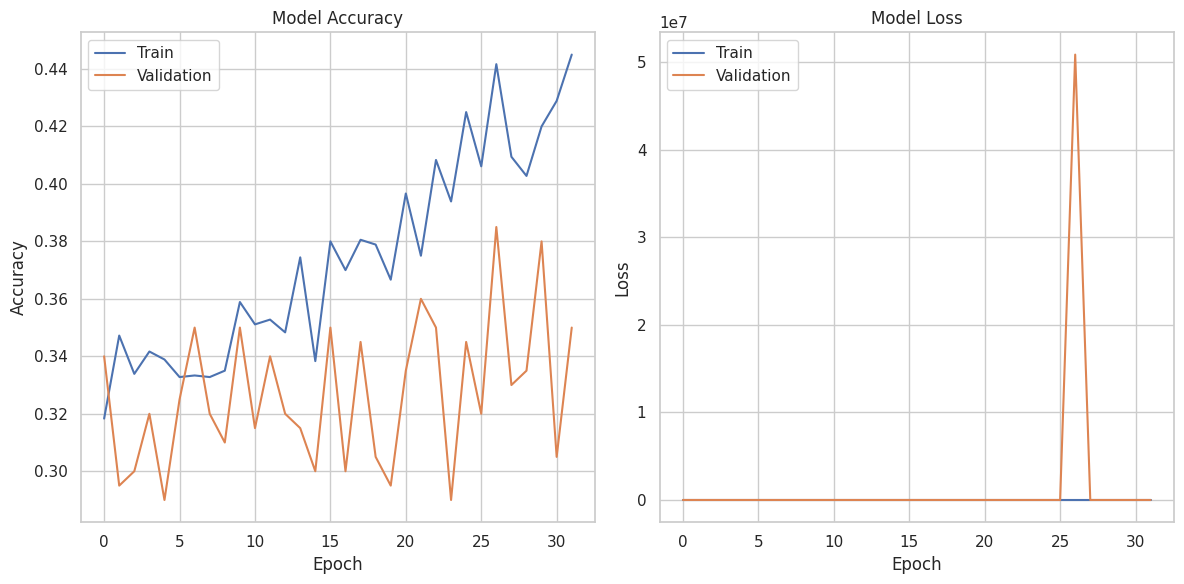

63/63 [==============================] - 1s 16ms/step
y_pred [[1.00694492e-01 5.26365757e-01 3.72939765e-01]
 [3.87730986e-01 3.80155474e-01 2.32113525e-01]
 [1.45809942e-08 1.81344745e-04 9.99818623e-01]
 ...
 [3.50035620e-13 1.04986725e-06 9.99998927e-01]
 [1.04298145e-01 5.27804375e-01 3.67897481e-01]
 [1.30945338e-07 9.81590711e-04 9.99018312e-01]]
Accuracy: 0.312
Confusion Matrix: [[ 57 191 424]
 [ 66 201 408]
 [ 74 213 366]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.1496 - sparse_categorical_accuracy: 0.4135

57/57 [==============================] - 6s 95ms/step - loss: 2.1463 - sparse_categorical_accuracy: 0.4128 - val_loss: 2.2765 - val_sparse_categorical_accuracy: 0.4400
Epoch 2/32
57/57 [==============================] - ETA: 0s - loss: 2.1335 - sparse_categorical_accuracy: 0.4244

57/57 [==============================] - 6s 105ms/step - loss: 2.1335 - sparse_categorical_accuracy: 0.4244 - val_loss: 2.1788 - val_sparse_categorical_accuracy: 0.4650
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.1374 - sparse_categorical_accuracy: 0.4280

57/57 [==============================] - 5s 95ms/step - loss: 2.1345 - sparse_categorical_accuracy: 0.4278 - val_loss: 2.3750 - val_sparse_categorical_accuracy: 0.3400
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.1201 - sparse_categorical_accuracy: 0.4420

57/57 [==============================] - 6s 99ms/step - loss: 2.1167 - sparse_categorical_accuracy: 0.4417 - val_loss: 1384.3098 - val_sparse_categorical_accuracy: 0.3500
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.1215 - sparse_categorical_accuracy: 0.4381

57/57 [==============================] - 6s 100ms/step - loss: 2.1184 - sparse_categorical_accuracy: 0.4383 - val_loss: 2.5573 - val_sparse_categorical_accuracy: 0.3900
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.1421 - sparse_categorical_accuracy: 0.4258

57/57 [==============================] - 5s 93ms/step - loss: 2.1385 - sparse_categorical_accuracy: 0.4261 - val_loss: 2.2722 - val_sparse_categorical_accuracy: 0.3550
Epoch 7/32
57/57 [==============================] - ETA: 0s - loss: 2.1138 - sparse_categorical_accuracy: 0.4417

57/57 [==============================] - 6s 108ms/step - loss: 2.1138 - sparse_categorical_accuracy: 0.4417 - val_loss: 2.6877 - val_sparse_categorical_accuracy: 0.4100
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.1027 - sparse_categorical_accuracy: 0.4503

57/57 [==============================] - 6s 97ms/step - loss: 2.0986 - sparse_categorical_accuracy: 0.4517 - val_loss: 2.2602 - val_sparse_categorical_accuracy: 0.3350
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.1035 - sparse_categorical_accuracy: 0.4554

57/57 [==============================] - 6s 98ms/step - loss: 2.0994 - sparse_categorical_accuracy: 0.4561 - val_loss: 2.1802 - val_sparse_categorical_accuracy: 0.4300
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.0735 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 101ms/step - loss: 2.0700 - sparse_categorical_accuracy: 0.4894 - val_loss: 2.2354 - val_sparse_categorical_accuracy: 0.3600
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.0877 - sparse_categorical_accuracy: 0.4671

57/57 [==============================] - 5s 97ms/step - loss: 2.0850 - sparse_categorical_accuracy: 0.4672 - val_loss: 2.4043 - val_sparse_categorical_accuracy: 0.3350
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.0923 - sparse_categorical_accuracy: 0.4827

57/57 [==============================] - 6s 103ms/step - loss: 2.0883 - sparse_categorical_accuracy: 0.4828 - val_loss: 2.2870 - val_sparse_categorical_accuracy: 0.3550
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.0503 - sparse_categorical_accuracy: 0.5173

57/57 [==============================] - 5s 96ms/step - loss: 2.0470 - sparse_categorical_accuracy: 0.5161 - val_loss: 3.9274 - val_sparse_categorical_accuracy: 0.3100
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.1388 - sparse_categorical_accuracy: 0.4470

57/57 [==============================] - 5s 94ms/step - loss: 2.1360 - sparse_categorical_accuracy: 0.4467 - val_loss: 55.0257 - val_sparse_categorical_accuracy: 0.3600
Epoch 15/32
57/57 [==============================] - ETA: 0s - loss: 2.0994 - sparse_categorical_accuracy: 0.4717

57/57 [==============================] - 6s 105ms/step - loss: 2.0994 - sparse_categorical_accuracy: 0.4717 - val_loss: 2.1983 - val_sparse_categorical_accuracy: 0.3150
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.0563 - sparse_categorical_accuracy: 0.5073

57/57 [==============================] - 5s 97ms/step - loss: 2.0536 - sparse_categorical_accuracy: 0.5072 - val_loss: 2.6914 - val_sparse_categorical_accuracy: 0.4400
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.0515 - sparse_categorical_accuracy: 0.5156

57/57 [==============================] - 6s 100ms/step - loss: 2.0474 - sparse_categorical_accuracy: 0.5156 - val_loss: 3.3178 - val_sparse_categorical_accuracy: 0.3750
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.0388 - sparse_categorical_accuracy: 0.5251

57/57 [==============================] - 6s 99ms/step - loss: 2.0358 - sparse_categorical_accuracy: 0.5244 - val_loss: 2.9162 - val_sparse_categorical_accuracy: 0.4200
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.0107 - sparse_categorical_accuracy: 0.5363

57/57 [==============================] - 5s 93ms/step - loss: 2.0062 - sparse_categorical_accuracy: 0.5372 - val_loss: 3.1415 - val_sparse_categorical_accuracy: 0.3700
Epoch 20/32
57/57 [==============================] - ETA: 0s - loss: 1.9693 - sparse_categorical_accuracy: 0.5672

57/57 [==============================] - 6s 105ms/step - loss: 1.9693 - sparse_categorical_accuracy: 0.5672 - val_loss: 2.6223 - val_sparse_categorical_accuracy: 0.3050
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 1.9774 - sparse_categorical_accuracy: 0.5608

57/57 [==============================] - 5s 96ms/step - loss: 1.9731 - sparse_categorical_accuracy: 0.5611 - val_loss: 2.4519 - val_sparse_categorical_accuracy: 0.3450
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.9669 - sparse_categorical_accuracy: 0.5837

57/57 [==============================] - 5s 96ms/step - loss: 1.9646 - sparse_categorical_accuracy: 0.5833 - val_loss: 3.3393 - val_sparse_categorical_accuracy: 0.3800
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 1.9581 - sparse_categorical_accuracy: 0.5971

57/57 [==============================] - 6s 100ms/step - loss: 1.9539 - sparse_categorical_accuracy: 0.5978 - val_loss: 3.0363 - val_sparse_categorical_accuracy: 0.3550
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 1.9261 - sparse_categorical_accuracy: 0.6038

57/57 [==============================] - 5s 96ms/step - loss: 1.9244 - sparse_categorical_accuracy: 0.6033 - val_loss: 2.9533 - val_sparse_categorical_accuracy: 0.3850
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.9137 - sparse_categorical_accuracy: 0.6150

57/57 [==============================] - 6s 102ms/step - loss: 1.9117 - sparse_categorical_accuracy: 0.6144 - val_loss: 27.7981 - val_sparse_categorical_accuracy: 0.3800
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.8778 - sparse_categorical_accuracy: 0.6261

57/57 [==============================] - 6s 97ms/step - loss: 1.8771 - sparse_categorical_accuracy: 0.6244 - val_loss: 2.9517 - val_sparse_categorical_accuracy: 0.3550
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.8559 - sparse_categorical_accuracy: 0.6501

57/57 [==============================] - 5s 94ms/step - loss: 1.8553 - sparse_categorical_accuracy: 0.6489 - val_loss: 35.3135 - val_sparse_categorical_accuracy: 0.3550
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.0785 - sparse_categorical_accuracy: 0.5218

57/57 [==============================] - 6s 104ms/step - loss: 2.0750 - sparse_categorical_accuracy: 0.5222 - val_loss: 2.8626 - val_sparse_categorical_accuracy: 0.3000
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.9401 - sparse_categorical_accuracy: 0.6295

57/57 [==============================] - 5s 96ms/step - loss: 1.9371 - sparse_categorical_accuracy: 0.6294 - val_loss: 3.7073 - val_sparse_categorical_accuracy: 0.3750
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.8875 - sparse_categorical_accuracy: 0.6356

57/57 [==============================] - 6s 97ms/step - loss: 1.8822 - sparse_categorical_accuracy: 0.6367 - val_loss: 3.1382 - val_sparse_categorical_accuracy: 0.3950
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.7771 - sparse_categorical_accuracy: 0.6992

57/57 [==============================] - 6s 99ms/step - loss: 1.7734 - sparse_categorical_accuracy: 0.6994 - val_loss: 3.2228 - val_sparse_categorical_accuracy: 0.3000
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.7632 - sparse_categorical_accuracy: 0.7020

57/57 [==============================] - 5s 97ms/step - loss: 1.7612 - sparse_categorical_accuracy: 0.7017 - val_loss: 8.3349 - val_sparse_categorical_accuracy: 0.3000


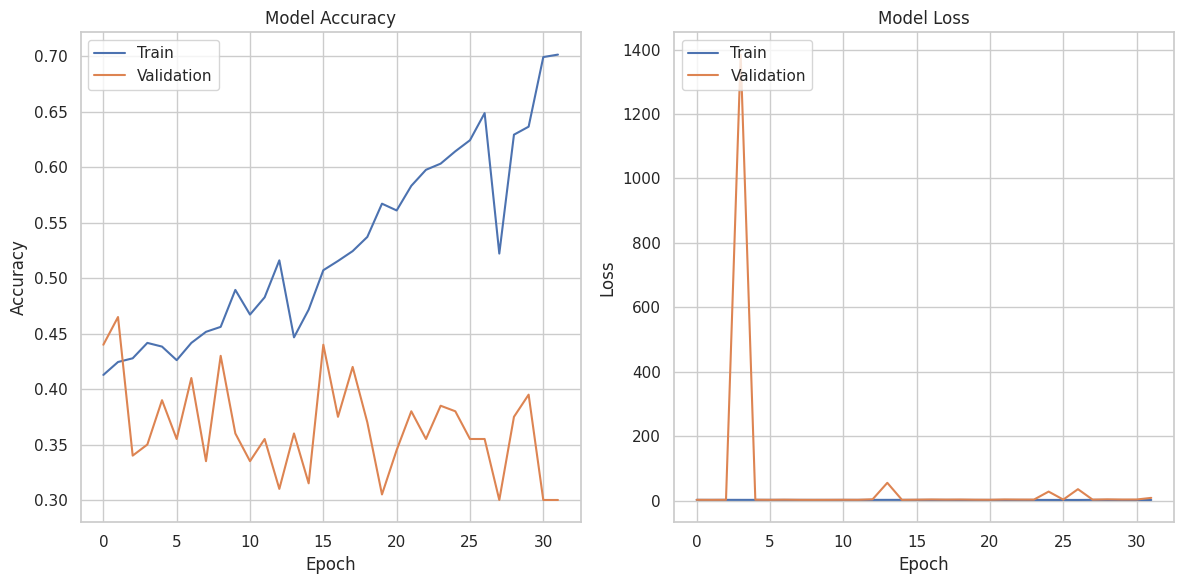

63/63 [==============================] - 1s 16ms/step
y_pred [[1.1445559e-03 2.3308020e-02 9.7554737e-01]
 [8.4263040e-03 4.7042646e-02 9.4453108e-01]
 [3.5655868e-04 9.8224086e-01 1.7402640e-02]
 ...
 [7.2311792e-07 9.9964595e-01 3.5327475e-04]
 [2.9667245e-02 2.7199140e-01 6.9834137e-01]
 [1.9096786e-14 1.0000000e+00 1.2403105e-09]]
Accuracy: 0.3575
Confusion Matrix: [[ 18 342 312]
 [ 19 307 349]
 [ 27 236 390]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.8528 - sparse_categorical_accuracy: 0.6708

57/57 [==============================] - 6s 104ms/step - loss: 1.8479 - sparse_categorical_accuracy: 0.6717 - val_loss: 3.3156 - val_sparse_categorical_accuracy: 0.4700
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.7626 - sparse_categorical_accuracy: 0.7182

57/57 [==============================] - 5s 97ms/step - loss: 1.7608 - sparse_categorical_accuracy: 0.7172 - val_loss: 2.9197 - val_sparse_categorical_accuracy: 0.4050
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.7644 - sparse_categorical_accuracy: 0.6987

57/57 [==============================] - 6s 101ms/step - loss: 1.7655 - sparse_categorical_accuracy: 0.6972 - val_loss: 4.1301 - val_sparse_categorical_accuracy: 0.3850
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 1.6983 - sparse_categorical_accuracy: 0.7500

57/57 [==============================] - 6s 100ms/step - loss: 1.6965 - sparse_categorical_accuracy: 0.7489 - val_loss: 2.4247 - val_sparse_categorical_accuracy: 0.5350
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 1.6868 - sparse_categorical_accuracy: 0.7522

57/57 [==============================] - 5s 96ms/step - loss: 1.6845 - sparse_categorical_accuracy: 0.7522 - val_loss: 2.4697 - val_sparse_categorical_accuracy: 0.4800
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.6427 - sparse_categorical_accuracy: 0.7701

57/57 [==============================] - 6s 104ms/step - loss: 1.6437 - sparse_categorical_accuracy: 0.7683 - val_loss: 2.2308 - val_sparse_categorical_accuracy: 0.5500
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 1.6021 - sparse_categorical_accuracy: 0.7952

57/57 [==============================] - 6s 98ms/step - loss: 1.5997 - sparse_categorical_accuracy: 0.7944 - val_loss: 154.6425 - val_sparse_categorical_accuracy: 0.3600
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 1.6667 - sparse_categorical_accuracy: 0.7718

57/57 [==============================] - 6s 97ms/step - loss: 1.6677 - sparse_categorical_accuracy: 0.7694 - val_loss: 4.3931 - val_sparse_categorical_accuracy: 0.4600
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.6387 - sparse_categorical_accuracy: 0.7751

57/57 [==============================] - 6s 99ms/step - loss: 1.6358 - sparse_categorical_accuracy: 0.7744 - val_loss: 225.3041 - val_sparse_categorical_accuracy: 0.3500
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 1.5673 - sparse_categorical_accuracy: 0.8080

57/57 [==============================] - 6s 98ms/step - loss: 1.5651 - sparse_categorical_accuracy: 0.8072 - val_loss: 3.2759 - val_sparse_categorical_accuracy: 0.3950
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 1.5412 - sparse_categorical_accuracy: 0.8200

57/57 [==============================] - 6s 103ms/step - loss: 1.5412 - sparse_categorical_accuracy: 0.8200 - val_loss: 2.8543 - val_sparse_categorical_accuracy: 0.4950
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.4811 - sparse_categorical_accuracy: 0.8426

57/57 [==============================] - 6s 99ms/step - loss: 1.4790 - sparse_categorical_accuracy: 0.8417 - val_loss: 2.6860 - val_sparse_categorical_accuracy: 0.4050
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 1.4911 - sparse_categorical_accuracy: 0.8326

57/57 [==============================] - 5s 95ms/step - loss: 1.4911 - sparse_categorical_accuracy: 0.8317 - val_loss: 6.9191 - val_sparse_categorical_accuracy: 0.4050
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 1.5635 - sparse_categorical_accuracy: 0.8100

57/57 [==============================] - 6s 105ms/step - loss: 1.5635 - sparse_categorical_accuracy: 0.8100 - val_loss: 2.9408 - val_sparse_categorical_accuracy: 0.4750
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 1.4635 - sparse_categorical_accuracy: 0.8527

57/57 [==============================] - 5s 97ms/step - loss: 1.4610 - sparse_categorical_accuracy: 0.8528 - val_loss: 4.4160 - val_sparse_categorical_accuracy: 0.4500
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.3828 - sparse_categorical_accuracy: 0.8817

57/57 [==============================] - 6s 100ms/step - loss: 1.3815 - sparse_categorical_accuracy: 0.8800 - val_loss: 9.8100 - val_sparse_categorical_accuracy: 0.3750
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.5740 - sparse_categorical_accuracy: 0.8181

57/57 [==============================] - 6s 99ms/step - loss: 1.5702 - sparse_categorical_accuracy: 0.8172 - val_loss: 24.1946 - val_sparse_categorical_accuracy: 0.3650
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 1.4141 - sparse_categorical_accuracy: 0.8789

57/57 [==============================] - 5s 94ms/step - loss: 1.4100 - sparse_categorical_accuracy: 0.8789 - val_loss: 3.2416 - val_sparse_categorical_accuracy: 0.4700
Epoch 19/32
57/57 [==============================] - ETA: 0s - loss: 1.4299 - sparse_categorical_accuracy: 0.8694

57/57 [==============================] - 6s 102ms/step - loss: 1.4299 - sparse_categorical_accuracy: 0.8694 - val_loss: 3.6574 - val_sparse_categorical_accuracy: 0.4600
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.4003 - sparse_categorical_accuracy: 0.8783

57/57 [==============================] - 6s 98ms/step - loss: 1.3989 - sparse_categorical_accuracy: 0.8772 - val_loss: 3.8536 - val_sparse_categorical_accuracy: 0.4550
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 1.3242 - sparse_categorical_accuracy: 0.9107

57/57 [==============================] - 5s 95ms/step - loss: 1.3202 - sparse_categorical_accuracy: 0.9106 - val_loss: 3.3640 - val_sparse_categorical_accuracy: 0.4850
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.3323 - sparse_categorical_accuracy: 0.9079

57/57 [==============================] - 6s 99ms/step - loss: 1.3285 - sparse_categorical_accuracy: 0.9083 - val_loss: 4.0515 - val_sparse_categorical_accuracy: 0.4650
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 1.3720 - sparse_categorical_accuracy: 0.8817

57/57 [==============================] - 6s 98ms/step - loss: 1.3680 - sparse_categorical_accuracy: 0.8817 - val_loss: 4.4382 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/32
57/57 [==============================] - ETA: 0s - loss: 1.3381 - sparse_categorical_accuracy: 0.8978

57/57 [==============================] - 6s 103ms/step - loss: 1.3381 - sparse_categorical_accuracy: 0.8978 - val_loss: 4.9564 - val_sparse_categorical_accuracy: 0.4000
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.3376 - sparse_categorical_accuracy: 0.9023

57/57 [==============================] - 6s 100ms/step - loss: 1.3373 - sparse_categorical_accuracy: 0.9017 - val_loss: 2.9125 - val_sparse_categorical_accuracy: 0.4950
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.3392 - sparse_categorical_accuracy: 0.9012

57/57 [==============================] - 6s 98ms/step - loss: 1.3403 - sparse_categorical_accuracy: 0.8994 - val_loss: 3.2714 - val_sparse_categorical_accuracy: 0.4500
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.4101 - sparse_categorical_accuracy: 0.8722

57/57 [==============================] - 6s 105ms/step - loss: 1.4071 - sparse_categorical_accuracy: 0.8717 - val_loss: 7.9031 - val_sparse_categorical_accuracy: 0.3900
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.3473 - sparse_categorical_accuracy: 0.9012

57/57 [==============================] - 6s 97ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.9006 - val_loss: 4.6776 - val_sparse_categorical_accuracy: 0.4200
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.3902 - sparse_categorical_accuracy: 0.8733

57/57 [==============================] - 6s 102ms/step - loss: 1.3897 - sparse_categorical_accuracy: 0.8728 - val_loss: 8051.2573 - val_sparse_categorical_accuracy: 0.3550
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.4049 - sparse_categorical_accuracy: 0.8711

57/57 [==============================] - 6s 99ms/step - loss: 1.4029 - sparse_categorical_accuracy: 0.8700 - val_loss: 99.5761 - val_sparse_categorical_accuracy: 0.3500
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.3007 - sparse_categorical_accuracy: 0.9163

57/57 [==============================] - 5s 95ms/step - loss: 1.3028 - sparse_categorical_accuracy: 0.9150 - val_loss: 5.6311 - val_sparse_categorical_accuracy: 0.4200
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.2473 - sparse_categorical_accuracy: 0.5530

57/57 [==============================] - 6s 100ms/step - loss: 2.2454 - sparse_categorical_accuracy: 0.5522 - val_loss: 2.9164 - val_sparse_categorical_accuracy: 0.3550


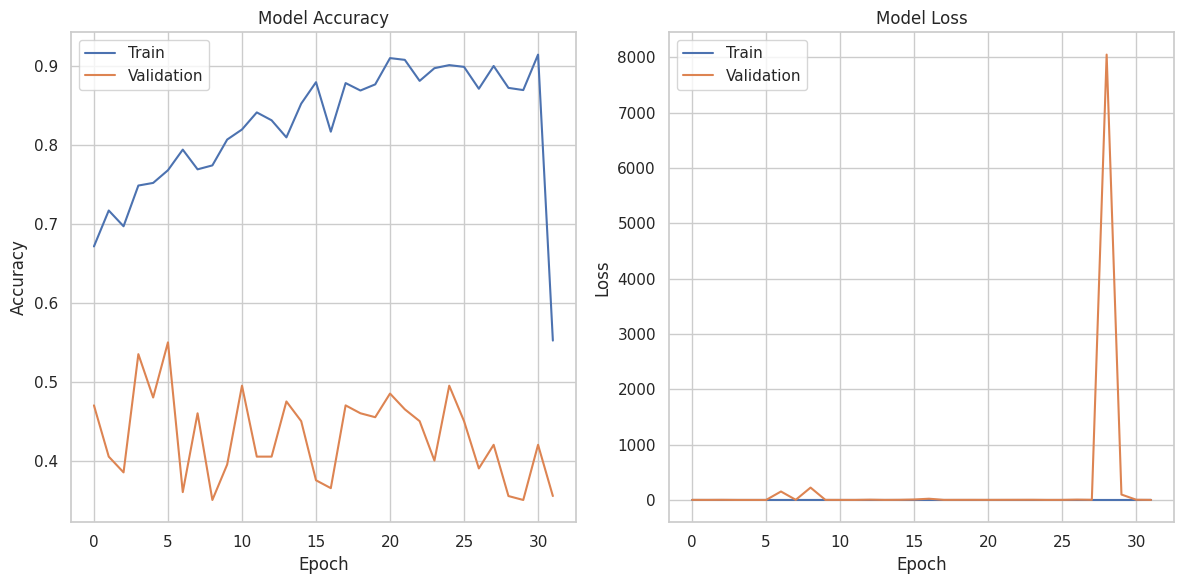

63/63 [==============================] - 1s 17ms/step
y_pred [[0.64235765 0.0200152  0.33762717]
 [0.1663569  0.60049605 0.23314704]
 [0.16994666 0.59303796 0.23701538]
 ...
 [0.7357945  0.10934886 0.15485665]
 [0.04505657 0.8494483  0.10549513]
 [0.00371769 0.9824551  0.01382722]]
Accuracy: 0.3385
Confusion Matrix: [[ 81 519  72]
 [ 91 480 104]
 [121 416 116]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.9974 - sparse_categorical_accuracy: 0.5887

57/57 [==============================] - 6s 100ms/step - loss: 1.9934 - sparse_categorical_accuracy: 0.5889 - val_loss: 2.5707 - val_sparse_categorical_accuracy: 0.5350
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.7958 - sparse_categorical_accuracy: 0.7054

57/57 [==============================] - 6s 98ms/step - loss: 1.7921 - sparse_categorical_accuracy: 0.7061 - val_loss: 2.0785 - val_sparse_categorical_accuracy: 0.5900
Epoch 3/32
57/57 [==============================] - ETA: 0s - loss: 1.6601 - sparse_categorical_accuracy: 0.7672

57/57 [==============================] - 6s 103ms/step - loss: 1.6601 - sparse_categorical_accuracy: 0.7672 - val_loss: 2.4200 - val_sparse_categorical_accuracy: 0.5600
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 1.5792 - sparse_categorical_accuracy: 0.7969

57/57 [==============================] - 6s 98ms/step - loss: 1.5762 - sparse_categorical_accuracy: 0.7967 - val_loss: 3.3756 - val_sparse_categorical_accuracy: 0.5200
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 1.4535 - sparse_categorical_accuracy: 0.8610

57/57 [==============================] - 5s 96ms/step - loss: 1.4546 - sparse_categorical_accuracy: 0.8600 - val_loss: 3.4625 - val_sparse_categorical_accuracy: 0.5450
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.4585 - sparse_categorical_accuracy: 0.8583

57/57 [==============================] - 6s 98ms/step - loss: 1.4582 - sparse_categorical_accuracy: 0.8578 - val_loss: 2.3754 - val_sparse_categorical_accuracy: 0.5550
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 1.4348 - sparse_categorical_accuracy: 0.8627

57/57 [==============================] - 5s 96ms/step - loss: 1.4314 - sparse_categorical_accuracy: 0.8628 - val_loss: 3.2560 - val_sparse_categorical_accuracy: 0.5700
Epoch 8/32
57/57 [==============================] - ETA: 0s - loss: 1.3564 - sparse_categorical_accuracy: 0.8972

57/57 [==============================] - 6s 103ms/step - loss: 1.3564 - sparse_categorical_accuracy: 0.8972 - val_loss: 5.3721 - val_sparse_categorical_accuracy: 0.4050
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.3765 - sparse_categorical_accuracy: 0.8996

57/57 [==============================] - 6s 98ms/step - loss: 1.3754 - sparse_categorical_accuracy: 0.8989 - val_loss: 3.0232 - val_sparse_categorical_accuracy: 0.6200
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 1.3246 - sparse_categorical_accuracy: 0.9074

57/57 [==============================] - 5s 94ms/step - loss: 1.3228 - sparse_categorical_accuracy: 0.9067 - val_loss: 6.7669 - val_sparse_categorical_accuracy: 0.4100
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 1.3399 - sparse_categorical_accuracy: 0.9067

57/57 [==============================] - 6s 105ms/step - loss: 1.3399 - sparse_categorical_accuracy: 0.9067 - val_loss: 3.4773 - val_sparse_categorical_accuracy: 0.5150
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.2951 - sparse_categorical_accuracy: 0.9152

57/57 [==============================] - 6s 97ms/step - loss: 1.2910 - sparse_categorical_accuracy: 0.9156 - val_loss: 3.5307 - val_sparse_categorical_accuracy: 0.5300
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 1.3002 - sparse_categorical_accuracy: 0.9224

57/57 [==============================] - 6s 98ms/step - loss: 1.2957 - sparse_categorical_accuracy: 0.9228 - val_loss: 2.2054 - val_sparse_categorical_accuracy: 0.7000
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.2776 - sparse_categorical_accuracy: 0.9247

57/57 [==============================] - 6s 98ms/step - loss: 1.2773 - sparse_categorical_accuracy: 0.9233 - val_loss: 3.0613 - val_sparse_categorical_accuracy: 0.5250
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 1.2985 - sparse_categorical_accuracy: 0.9152

57/57 [==============================] - 5s 96ms/step - loss: 1.3003 - sparse_categorical_accuracy: 0.9139 - val_loss: 3.9598 - val_sparse_categorical_accuracy: 0.5700
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.3380 - sparse_categorical_accuracy: 0.9062

57/57 [==============================] - 6s 104ms/step - loss: 1.3337 - sparse_categorical_accuracy: 0.9067 - val_loss: 2.4383 - val_sparse_categorical_accuracy: 0.6050
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.2359 - sparse_categorical_accuracy: 0.9509

57/57 [==============================] - 6s 98ms/step - loss: 1.2323 - sparse_categorical_accuracy: 0.9511 - val_loss: 2.4087 - val_sparse_categorical_accuracy: 0.7000
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 1.2446 - sparse_categorical_accuracy: 0.9442

57/57 [==============================] - 5s 95ms/step - loss: 1.2424 - sparse_categorical_accuracy: 0.9433 - val_loss: 2.6326 - val_sparse_categorical_accuracy: 0.6350
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 1.2533 - sparse_categorical_accuracy: 0.9347

57/57 [==============================] - 6s 102ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.9344 - val_loss: 4.4775 - val_sparse_categorical_accuracy: 0.5250
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.2360 - sparse_categorical_accuracy: 0.9414

57/57 [==============================] - 6s 98ms/step - loss: 1.2334 - sparse_categorical_accuracy: 0.9411 - val_loss: 5.9581 - val_sparse_categorical_accuracy: 0.4850
Epoch 21/32
57/57 [==============================] - ETA: 0s - loss: 1.2446 - sparse_categorical_accuracy: 0.9422

57/57 [==============================] - 6s 102ms/step - loss: 1.2446 - sparse_categorical_accuracy: 0.9422 - val_loss: 3.0711 - val_sparse_categorical_accuracy: 0.5500
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.2593 - sparse_categorical_accuracy: 0.9392

57/57 [==============================] - 6s 98ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.9378 - val_loss: 8.2222 - val_sparse_categorical_accuracy: 0.4800
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 1.2998 - sparse_categorical_accuracy: 0.9185

57/57 [==============================] - 5s 94ms/step - loss: 1.2993 - sparse_categorical_accuracy: 0.9172 - val_loss: 4.1982 - val_sparse_categorical_accuracy: 0.4800
Epoch 24/32
57/57 [==============================] - ETA: 0s - loss: 1.2213 - sparse_categorical_accuracy: 0.9500

57/57 [==============================] - 6s 102ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.9500 - val_loss: 2.5822 - val_sparse_categorical_accuracy: 0.6200
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.1951 - sparse_categorical_accuracy: 0.9626

57/57 [==============================] - 6s 97ms/step - loss: 1.1911 - sparse_categorical_accuracy: 0.9628 - val_loss: 5.8789 - val_sparse_categorical_accuracy: 0.5150
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.2252 - sparse_categorical_accuracy: 0.9448

57/57 [==============================] - 5s 94ms/step - loss: 1.2226 - sparse_categorical_accuracy: 0.9439 - val_loss: 4.3039 - val_sparse_categorical_accuracy: 0.5350
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.2641 - sparse_categorical_accuracy: 0.9408

57/57 [==============================] - 6s 102ms/step - loss: 1.2669 - sparse_categorical_accuracy: 0.9389 - val_loss: 5.8887 - val_sparse_categorical_accuracy: 0.4700
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.2084 - sparse_categorical_accuracy: 0.9520

57/57 [==============================] - 5s 97ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.9506 - val_loss: 6.0197 - val_sparse_categorical_accuracy: 0.4450
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.3090 - sparse_categorical_accuracy: 0.9163

57/57 [==============================] - 6s 99ms/step - loss: 1.3119 - sparse_categorical_accuracy: 0.9150 - val_loss: 3.9933 - val_sparse_categorical_accuracy: 0.5100
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.2161 - sparse_categorical_accuracy: 0.9459

57/57 [==============================] - 6s 99ms/step - loss: 1.2139 - sparse_categorical_accuracy: 0.9450 - val_loss: 3.9496 - val_sparse_categorical_accuracy: 0.4900
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.1951 - sparse_categorical_accuracy: 0.9621

57/57 [==============================] - 5s 96ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.9617 - val_loss: 3.2842 - val_sparse_categorical_accuracy: 0.5050
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.1713 - sparse_categorical_accuracy: 0.9648

57/57 [==============================] - 6s 101ms/step - loss: 1.1778 - sparse_categorical_accuracy: 0.9633 - val_loss: 4.3199 - val_sparse_categorical_accuracy: 0.5200


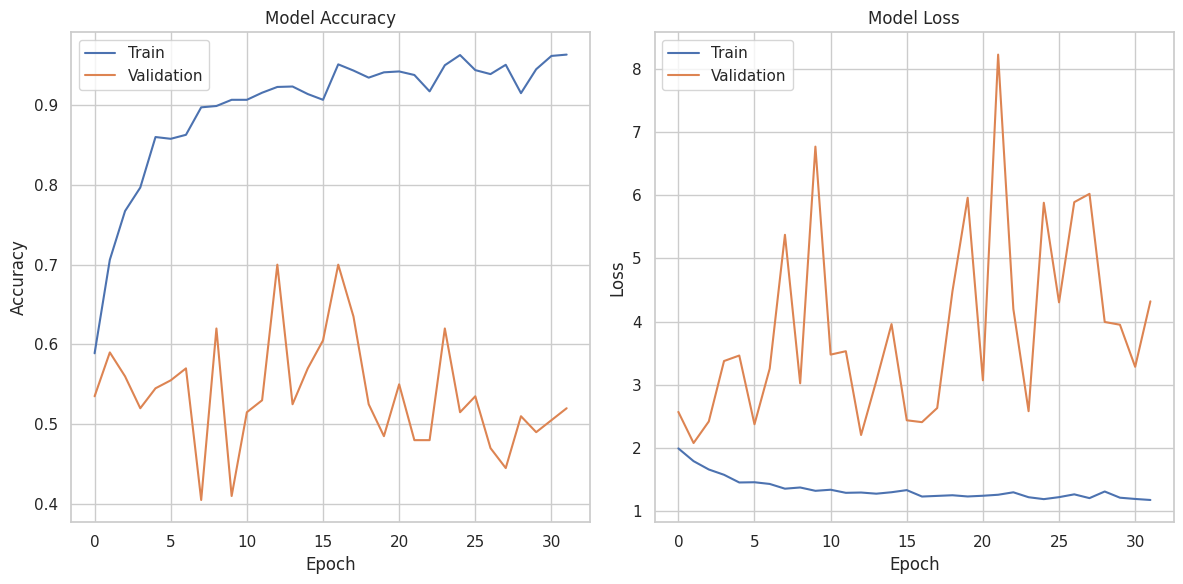

63/63 [==============================] - 1s 16ms/step
y_pred [[9.63250932e-04 9.98985827e-01 5.07992736e-05]
 [5.78861870e-03 9.88243699e-01 5.96769480e-03]
 [1.07978005e-02 8.14656675e-01 1.74545482e-01]
 ...
 [6.44868612e-03 9.93424773e-01 1.26465937e-04]
 [5.61657012e-01 2.84043640e-01 1.54299319e-01]
 [7.00841606e-01 2.97804356e-01 1.35400752e-03]]
Accuracy: 0.3205
Confusion Matrix: [[184 266 222]
 [179 273 223]
 [193 276 184]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.4073 - sparse_categorical_accuracy: 0.8934

57/57 [==============================] - 6s 95ms/step - loss: 1.4105 - sparse_categorical_accuracy: 0.8922 - val_loss: 5.8709 - val_sparse_categorical_accuracy: 0.5750
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.2380 - sparse_categorical_accuracy: 0.9453

57/57 [==============================] - 6s 99ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.9439 - val_loss: 3.2676 - val_sparse_categorical_accuracy: 0.6550
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.2524 - sparse_categorical_accuracy: 0.9425

57/57 [==============================] - 6s 99ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.9422 - val_loss: 4.3701 - val_sparse_categorical_accuracy: 0.4350
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 1.3068 - sparse_categorical_accuracy: 0.9141

57/57 [==============================] - 5s 95ms/step - loss: 1.3023 - sparse_categorical_accuracy: 0.9144 - val_loss: 1.6195 - val_sparse_categorical_accuracy: 0.8450
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 1.1758 - sparse_categorical_accuracy: 0.9704

57/57 [==============================] - 6s 100ms/step - loss: 1.1810 - sparse_categorical_accuracy: 0.9689 - val_loss: 2.6882 - val_sparse_categorical_accuracy: 0.7150
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.1926 - sparse_categorical_accuracy: 0.9570

57/57 [==============================] - 6s 97ms/step - loss: 1.1962 - sparse_categorical_accuracy: 0.9556 - val_loss: 4.9677 - val_sparse_categorical_accuracy: 0.5350
Epoch 7/32
57/57 [==============================] - ETA: 0s - loss: 1.4124 - sparse_categorical_accuracy: 0.8778

57/57 [==============================] - 6s 99ms/step - loss: 1.4124 - sparse_categorical_accuracy: 0.8778 - val_loss: 3.5147 - val_sparse_categorical_accuracy: 0.5650
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 1.2317 - sparse_categorical_accuracy: 0.9487

57/57 [==============================] - 6s 98ms/step - loss: 1.2297 - sparse_categorical_accuracy: 0.9478 - val_loss: 5.0613 - val_sparse_categorical_accuracy: 0.5350
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.3006 - sparse_categorical_accuracy: 0.9102

57/57 [==============================] - 6s 97ms/step - loss: 1.2963 - sparse_categorical_accuracy: 0.9106 - val_loss: 3.0211 - val_sparse_categorical_accuracy: 0.5900
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 1.1932 - sparse_categorical_accuracy: 0.9621

57/57 [==============================] - 6s 99ms/step - loss: 1.1971 - sparse_categorical_accuracy: 0.9606 - val_loss: 8.6011 - val_sparse_categorical_accuracy: 0.6050
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 1.2352 - sparse_categorical_accuracy: 0.9425

57/57 [==============================] - 5s 96ms/step - loss: 1.2350 - sparse_categorical_accuracy: 0.9417 - val_loss: 3.5176 - val_sparse_categorical_accuracy: 0.6050
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.2170 - sparse_categorical_accuracy: 0.9509

57/57 [==============================] - 5s 96ms/step - loss: 1.2157 - sparse_categorical_accuracy: 0.9500 - val_loss: 4.4979 - val_sparse_categorical_accuracy: 0.5400
Epoch 13/32
57/57 [==============================] - ETA: 0s - loss: 1.2030 - sparse_categorical_accuracy: 0.9583

57/57 [==============================] - 6s 103ms/step - loss: 1.2030 - sparse_categorical_accuracy: 0.9583 - val_loss: 15.1570 - val_sparse_categorical_accuracy: 0.4250
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.7234 - sparse_categorical_accuracy: 0.7790

57/57 [==============================] - 6s 97ms/step - loss: 1.7190 - sparse_categorical_accuracy: 0.7783 - val_loss: 3.0612 - val_sparse_categorical_accuracy: 0.5150
Epoch 15/32
57/57 [==============================] - ETA: 0s - loss: 1.3466 - sparse_categorical_accuracy: 0.9011

57/57 [==============================] - 6s 102ms/step - loss: 1.3466 - sparse_categorical_accuracy: 0.9011 - val_loss: 3.6274 - val_sparse_categorical_accuracy: 0.5450
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.2329 - sparse_categorical_accuracy: 0.9492

57/57 [==============================] - 6s 97ms/step - loss: 1.2315 - sparse_categorical_accuracy: 0.9483 - val_loss: 2.8640 - val_sparse_categorical_accuracy: 0.5650
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.2401 - sparse_categorical_accuracy: 0.9431

57/57 [==============================] - 6s 97ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.9428 - val_loss: 2.7236 - val_sparse_categorical_accuracy: 0.6550
Epoch 18/32
57/57 [==============================] - ETA: 0s - loss: 1.1900 - sparse_categorical_accuracy: 0.9589

57/57 [==============================] - 6s 102ms/step - loss: 1.1900 - sparse_categorical_accuracy: 0.9589 - val_loss: 3.4603 - val_sparse_categorical_accuracy: 0.6000
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 1.2123 - sparse_categorical_accuracy: 0.9626

57/57 [==============================] - 6s 98ms/step - loss: 1.2090 - sparse_categorical_accuracy: 0.9622 - val_loss: 3.2767 - val_sparse_categorical_accuracy: 0.6000
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.1962 - sparse_categorical_accuracy: 0.9632

57/57 [==============================] - 6s 97ms/step - loss: 1.1942 - sparse_categorical_accuracy: 0.9628 - val_loss: 11.5726 - val_sparse_categorical_accuracy: 0.3500
Epoch 21/32
57/57 [==============================] - ETA: 0s - loss: 1.2223 - sparse_categorical_accuracy: 0.9444

57/57 [==============================] - 6s 101ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.1440 - val_sparse_categorical_accuracy: 0.6950
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.2013 - sparse_categorical_accuracy: 0.9593

57/57 [==============================] - 6s 98ms/step - loss: 1.2017 - sparse_categorical_accuracy: 0.9583 - val_loss: 3.7122 - val_sparse_categorical_accuracy: 0.5150
Epoch 23/32
57/57 [==============================] - ETA: 0s - loss: 1.4057 - sparse_categorical_accuracy: 0.8833

57/57 [==============================] - 6s 101ms/step - loss: 1.4057 - sparse_categorical_accuracy: 0.8833 - val_loss: 2.5482 - val_sparse_categorical_accuracy: 0.6850
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 1.2444 - sparse_categorical_accuracy: 0.9459

57/57 [==============================] - 6s 97ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.9461 - val_loss: 3.8440 - val_sparse_categorical_accuracy: 0.5650
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.2068 - sparse_categorical_accuracy: 0.9604

57/57 [==============================] - 6s 97ms/step - loss: 1.2070 - sparse_categorical_accuracy: 0.9600 - val_loss: 4.0054 - val_sparse_categorical_accuracy: 0.6300
Epoch 26/32
57/57 [==============================] - ETA: 0s - loss: 1.1675 - sparse_categorical_accuracy: 0.9706

57/57 [==============================] - 6s 100ms/step - loss: 1.1675 - sparse_categorical_accuracy: 0.9706 - val_loss: 4.1874 - val_sparse_categorical_accuracy: 0.5400
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.2054 - sparse_categorical_accuracy: 0.9531

57/57 [==============================] - 6s 98ms/step - loss: 1.2107 - sparse_categorical_accuracy: 0.9511 - val_loss: 4.3996 - val_sparse_categorical_accuracy: 0.5350
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.3205 - sparse_categorical_accuracy: 0.9146

57/57 [==============================] - 6s 97ms/step - loss: 1.3176 - sparse_categorical_accuracy: 0.9139 - val_loss: 11.8179 - val_sparse_categorical_accuracy: 0.3650
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.2077 - sparse_categorical_accuracy: 0.9542

57/57 [==============================] - 6s 99ms/step - loss: 1.2072 - sparse_categorical_accuracy: 0.9533 - val_loss: 2.3482 - val_sparse_categorical_accuracy: 0.7350
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.1643 - sparse_categorical_accuracy: 0.9693

57/57 [==============================] - 6s 98ms/step - loss: 1.1662 - sparse_categorical_accuracy: 0.9678 - val_loss: 17.5039 - val_sparse_categorical_accuracy: 0.3750
Epoch 31/32
57/57 [==============================] - ETA: 0s - loss: 2.2432 - sparse_categorical_accuracy: 0.5850

57/57 [==============================] - 6s 102ms/step - loss: 2.2432 - sparse_categorical_accuracy: 0.5850 - val_loss: 2.4905 - val_sparse_categorical_accuracy: 0.5050
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.7813 - sparse_categorical_accuracy: 0.7171

57/57 [==============================] - 6s 97ms/step - loss: 1.7782 - sparse_categorical_accuracy: 0.7156 - val_loss: 2.8228 - val_sparse_categorical_accuracy: 0.4950


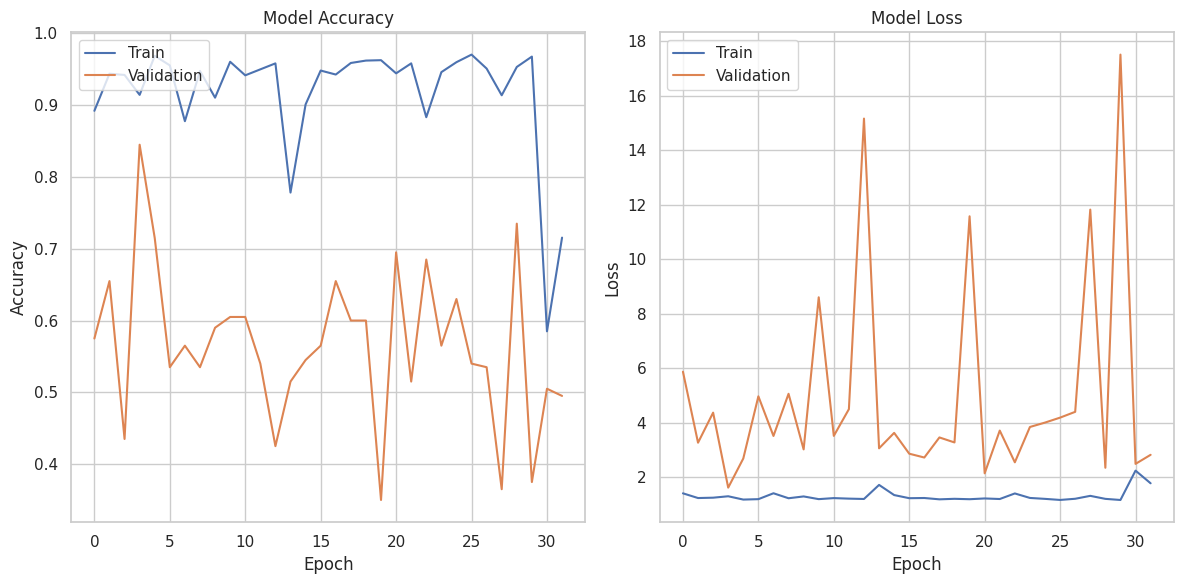

63/63 [==============================] - 1s 17ms/step
y_pred [[5.0462715e-02 6.2060612e-01 3.2893112e-01]
 [1.4715995e-02 3.0807135e-01 6.7721266e-01]
 [1.9409671e-02 6.1088794e-01 3.6970246e-01]
 ...
 [1.7165640e-02 9.8271745e-01 1.1692315e-04]
 [6.7471057e-01 2.1695732e-01 1.0833214e-01]
 [1.9836789e-02 9.8015469e-01 8.5532474e-06]]
Accuracy: 0.3365
Confusion Matrix: [[ 77 353 242]
 [ 85 356 234]
 [ 96 317 240]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.5885 - sparse_categorical_accuracy: 0.8036

57/57 [==============================] - 6s 100ms/step - loss: 1.5857 - sparse_categorical_accuracy: 0.8039 - val_loss: 1.9635 - val_sparse_categorical_accuracy: 0.6600
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.4230 - sparse_categorical_accuracy: 0.8739

57/57 [==============================] - 5s 96ms/step - loss: 1.4226 - sparse_categorical_accuracy: 0.8728 - val_loss: 2.2399 - val_sparse_categorical_accuracy: 0.6450
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.3538 - sparse_categorical_accuracy: 0.9085

57/57 [==============================] - 5s 96ms/step - loss: 1.3502 - sparse_categorical_accuracy: 0.9083 - val_loss: 2.9542 - val_sparse_categorical_accuracy: 0.6750
Epoch 4/32
57/57 [==============================] - ETA: 0s - loss: 1.2756 - sparse_categorical_accuracy: 0.9278

57/57 [==============================] - 6s 101ms/step - loss: 1.2756 - sparse_categorical_accuracy: 0.9278 - val_loss: 9.2295 - val_sparse_categorical_accuracy: 0.4250
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 1.2540 - sparse_categorical_accuracy: 0.9425

57/57 [==============================] - 6s 98ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.9417 - val_loss: 3.1893 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.2541 - sparse_categorical_accuracy: 0.9336

57/57 [==============================] - 6s 97ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.9311 - val_loss: 10.5775 - val_sparse_categorical_accuracy: 0.4400
Epoch 7/32
57/57 [==============================] - ETA: 0s - loss: 1.2634 - sparse_categorical_accuracy: 0.9367

57/57 [==============================] - 6s 104ms/step - loss: 1.2634 - sparse_categorical_accuracy: 0.9367 - val_loss: 1.9625 - val_sparse_categorical_accuracy: 0.7650
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 1.2193 - sparse_categorical_accuracy: 0.9531

57/57 [==============================] - 5s 96ms/step - loss: 1.2152 - sparse_categorical_accuracy: 0.9533 - val_loss: 3.0094 - val_sparse_categorical_accuracy: 0.6000
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.2043 - sparse_categorical_accuracy: 0.9503

57/57 [==============================] - 6s 103ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.9489 - val_loss: 4.0145 - val_sparse_categorical_accuracy: 0.5400
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 1.2245 - sparse_categorical_accuracy: 0.9487

57/57 [==============================] - 6s 97ms/step - loss: 1.2214 - sparse_categorical_accuracy: 0.9483 - val_loss: 2.5465 - val_sparse_categorical_accuracy: 0.7100
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 1.2007 - sparse_categorical_accuracy: 0.9587

57/57 [==============================] - 6s 97ms/step - loss: 1.1967 - sparse_categorical_accuracy: 0.9589 - val_loss: 2.9184 - val_sparse_categorical_accuracy: 0.6150
Epoch 12/32
57/57 [==============================] - ETA: 0s - loss: 1.1851 - sparse_categorical_accuracy: 0.9617

57/57 [==============================] - 6s 102ms/step - loss: 1.1851 - sparse_categorical_accuracy: 0.9617 - val_loss: 3.6878 - val_sparse_categorical_accuracy: 0.5850
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 1.1592 - sparse_categorical_accuracy: 0.9693

57/57 [==============================] - 5s 96ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.9683 - val_loss: 3.4872 - val_sparse_categorical_accuracy: 0.6200
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.1796 - sparse_categorical_accuracy: 0.9637

57/57 [==============================] - 6s 97ms/step - loss: 1.1796 - sparse_categorical_accuracy: 0.9622 - val_loss: 3.5857 - val_sparse_categorical_accuracy: 0.6900
Epoch 15/32
57/57 [==============================] - ETA: 0s - loss: 1.2958 - sparse_categorical_accuracy: 0.9172

57/57 [==============================] - 6s 102ms/step - loss: 1.2958 - sparse_categorical_accuracy: 0.9172 - val_loss: 3.8288 - val_sparse_categorical_accuracy: 0.6550
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.2056 - sparse_categorical_accuracy: 0.9542

57/57 [==============================] - 6s 97ms/step - loss: 1.2036 - sparse_categorical_accuracy: 0.9539 - val_loss: 3.7577 - val_sparse_categorical_accuracy: 0.5600
Epoch 17/32
57/57 [==============================] - ETA: 0s - loss: 1.1660 - sparse_categorical_accuracy: 0.9694

57/57 [==============================] - 6s 101ms/step - loss: 1.1660 - sparse_categorical_accuracy: 0.9694 - val_loss: 2.6443 - val_sparse_categorical_accuracy: 0.6950
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 1.1467 - sparse_categorical_accuracy: 0.9794

57/57 [==============================] - 6s 97ms/step - loss: 1.1497 - sparse_categorical_accuracy: 0.9778 - val_loss: 8.9069 - val_sparse_categorical_accuracy: 0.3350
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.0703 - sparse_categorical_accuracy: 0.6836

57/57 [==============================] - 6s 98ms/step - loss: 2.0698 - sparse_categorical_accuracy: 0.6822 - val_loss: 2.6755 - val_sparse_categorical_accuracy: 0.5050
Epoch 20/32
57/57 [==============================] - ETA: 0s - loss: 1.6261 - sparse_categorical_accuracy: 0.7911

57/57 [==============================] - 6s 100ms/step - loss: 1.6261 - sparse_categorical_accuracy: 0.7911 - val_loss: 3.8564 - val_sparse_categorical_accuracy: 0.4000
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 1.3980 - sparse_categorical_accuracy: 0.8945

57/57 [==============================] - 6s 98ms/step - loss: 1.3966 - sparse_categorical_accuracy: 0.8939 - val_loss: 2.3290 - val_sparse_categorical_accuracy: 0.6850
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.3043 - sparse_categorical_accuracy: 0.9163

57/57 [==============================] - 6s 97ms/step - loss: 1.3008 - sparse_categorical_accuracy: 0.9161 - val_loss: 2.7885 - val_sparse_categorical_accuracy: 0.6050
Epoch 23/32
57/57 [==============================] - ETA: 0s - loss: 1.2373 - sparse_categorical_accuracy: 0.9489

57/57 [==============================] - 6s 101ms/step - loss: 1.2373 - sparse_categorical_accuracy: 0.9489 - val_loss: 3.3039 - val_sparse_categorical_accuracy: 0.5850
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 1.2198 - sparse_categorical_accuracy: 0.9498

57/57 [==============================] - 5s 97ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.9494 - val_loss: 3.0198 - val_sparse_categorical_accuracy: 0.5850
Epoch 25/32
57/57 [==============================] - ETA: 0s - loss: 1.2373 - sparse_categorical_accuracy: 0.9461

57/57 [==============================] - 6s 103ms/step - loss: 1.2373 - sparse_categorical_accuracy: 0.9461 - val_loss: 6.8466 - val_sparse_categorical_accuracy: 0.4450
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.2032 - sparse_categorical_accuracy: 0.9609

57/57 [==============================] - 6s 98ms/step - loss: 1.2030 - sparse_categorical_accuracy: 0.9600 - val_loss: 2.0660 - val_sparse_categorical_accuracy: 0.7350
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.1739 - sparse_categorical_accuracy: 0.9710

57/57 [==============================] - 6s 97ms/step - loss: 1.1701 - sparse_categorical_accuracy: 0.9711 - val_loss: 2.3384 - val_sparse_categorical_accuracy: 0.7200
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.1685 - sparse_categorical_accuracy: 0.9626

57/57 [==============================] - 6s 99ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.9606 - val_loss: 3.6391 - val_sparse_categorical_accuracy: 0.6350
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.1914 - sparse_categorical_accuracy: 0.9621

57/57 [==============================] - 6s 97ms/step - loss: 1.1887 - sparse_categorical_accuracy: 0.9617 - val_loss: 3.1120 - val_sparse_categorical_accuracy: 0.5600
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.1559 - sparse_categorical_accuracy: 0.9760

57/57 [==============================] - 6s 98ms/step - loss: 1.1520 - sparse_categorical_accuracy: 0.9761 - val_loss: 2.9986 - val_sparse_categorical_accuracy: 0.6550
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.1473 - sparse_categorical_accuracy: 0.9782

57/57 [==============================] - 6s 99ms/step - loss: 1.1434 - sparse_categorical_accuracy: 0.9783 - val_loss: 2.6259 - val_sparse_categorical_accuracy: 0.7450
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.1323 - sparse_categorical_accuracy: 0.9810

57/57 [==============================] - 5s 97ms/step - loss: 1.1353 - sparse_categorical_accuracy: 0.9794 - val_loss: 3.4431 - val_sparse_categorical_accuracy: 0.6400


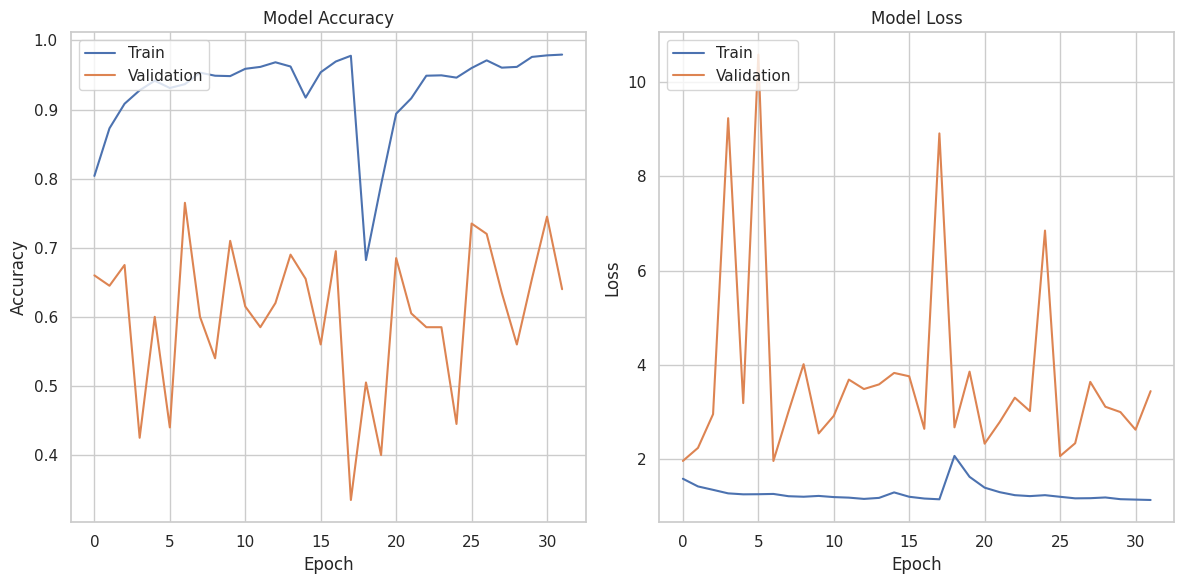

63/63 [==============================] - 1s 16ms/step
y_pred [[2.5451143e-04 9.9969983e-01 4.5697881e-05]
 [2.7311955e-08 1.0000000e+00 6.6446804e-10]
 [1.3446140e-03 1.8044886e-05 9.9863738e-01]
 ...
 [5.9915472e-08 9.9999988e-01 5.4749226e-11]
 [2.2240758e-03 3.3623721e-05 9.9774230e-01]
 [1.5844853e-09 1.0000000e+00 2.3408329e-13]]
Accuracy: 0.3235
Confusion Matrix: [[180 266 226]
 [193 274 208]
 [195 265 193]]
Epoch 1/32
57/57 [==============================] - ETA: 0s - loss: 1.2218 - sparse_categorical_accuracy: 0.9500

57/57 [==============================] - 6s 102ms/step - loss: 1.2218 - sparse_categorical_accuracy: 0.9500 - val_loss: 6.6382 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.4073 - sparse_categorical_accuracy: 0.8878

57/57 [==============================] - 5s 97ms/step - loss: 1.4033 - sparse_categorical_accuracy: 0.8878 - val_loss: 2.0167 - val_sparse_categorical_accuracy: 0.7350
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.2137 - sparse_categorical_accuracy: 0.9559

57/57 [==============================] - 5s 97ms/step - loss: 1.2104 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.3519 - val_sparse_categorical_accuracy: 0.7600
Epoch 4/32
57/57 [==============================] - ETA: 0s - loss: 1.1664 - sparse_categorical_accuracy: 0.9700

57/57 [==============================] - 6s 98ms/step - loss: 1.1664 - sparse_categorical_accuracy: 0.9700 - val_loss: 3.4546 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 1.1647 - sparse_categorical_accuracy: 0.9715

57/57 [==============================] - 5s 96ms/step - loss: 1.1614 - sparse_categorical_accuracy: 0.9711 - val_loss: 2.7243 - val_sparse_categorical_accuracy: 0.6600
Epoch 6/32
57/57 [==============================] - ETA: 0s - loss: 1.1564 - sparse_categorical_accuracy: 0.9750

57/57 [==============================] - 6s 102ms/step - loss: 1.1564 - sparse_categorical_accuracy: 0.9750 - val_loss: 2.6534 - val_sparse_categorical_accuracy: 0.7600
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 1.1832 - sparse_categorical_accuracy: 0.9676

57/57 [==============================] - 5s 96ms/step - loss: 1.1792 - sparse_categorical_accuracy: 0.9678 - val_loss: 2.8694 - val_sparse_categorical_accuracy: 0.6800
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 1.1380 - sparse_categorical_accuracy: 0.9777

57/57 [==============================] - 5s 96ms/step - loss: 1.1360 - sparse_categorical_accuracy: 0.9772 - val_loss: 3.1878 - val_sparse_categorical_accuracy: 0.7150
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.1665 - sparse_categorical_accuracy: 0.9704

57/57 [==============================] - 6s 104ms/step - loss: 1.1626 - sparse_categorical_accuracy: 0.9706 - val_loss: 5.7344 - val_sparse_categorical_accuracy: 0.5800
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 1.1480 - sparse_categorical_accuracy: 0.9771

57/57 [==============================] - 6s 98ms/step - loss: 1.1489 - sparse_categorical_accuracy: 0.9761 - val_loss: 12.3841 - val_sparse_categorical_accuracy: 0.4700
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 1.2233 - sparse_categorical_accuracy: 0.9503

57/57 [==============================] - 6s 100ms/step - loss: 1.2228 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.6223 - val_sparse_categorical_accuracy: 0.8200
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.1567 - sparse_categorical_accuracy: 0.9777

57/57 [==============================] - 6s 98ms/step - loss: 1.1596 - sparse_categorical_accuracy: 0.9772 - val_loss: 3.1234 - val_sparse_categorical_accuracy: 0.7150
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 1.1368 - sparse_categorical_accuracy: 0.9810

57/57 [==============================] - 5s 97ms/step - loss: 1.1342 - sparse_categorical_accuracy: 0.9806 - val_loss: 3.4115 - val_sparse_categorical_accuracy: 0.6950
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.1435 - sparse_categorical_accuracy: 0.9794

57/57 [==============================] - 6s 100ms/step - loss: 1.1405 - sparse_categorical_accuracy: 0.9783 - val_loss: 3.3163 - val_sparse_categorical_accuracy: 0.7400
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 1.1556 - sparse_categorical_accuracy: 0.9704

57/57 [==============================] - 6s 98ms/step - loss: 1.1571 - sparse_categorical_accuracy: 0.9689 - val_loss: 4.7521 - val_sparse_categorical_accuracy: 0.6800
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.2432 - sparse_categorical_accuracy: 0.9381

57/57 [==============================] - 5s 97ms/step - loss: 1.2393 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.6996 - val_sparse_categorical_accuracy: 0.6850
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.1718 - sparse_categorical_accuracy: 0.9671

57/57 [==============================] - 6s 101ms/step - loss: 1.1720 - sparse_categorical_accuracy: 0.9656 - val_loss: 4.5069 - val_sparse_categorical_accuracy: 0.6450
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 1.1523 - sparse_categorical_accuracy: 0.9782

57/57 [==============================] - 6s 97ms/step - loss: 1.1494 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.3441 - val_sparse_categorical_accuracy: 0.7400
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 1.1319 - sparse_categorical_accuracy: 0.9810

57/57 [==============================] - 6s 101ms/step - loss: 1.1283 - sparse_categorical_accuracy: 0.9811 - val_loss: 5.9334 - val_sparse_categorical_accuracy: 0.5900
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.1396 - sparse_categorical_accuracy: 0.9766

57/57 [==============================] - 6s 97ms/step - loss: 1.1361 - sparse_categorical_accuracy: 0.9767 - val_loss: 3.4288 - val_sparse_categorical_accuracy: 0.6550
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 1.1550 - sparse_categorical_accuracy: 0.9738

57/57 [==============================] - 6s 98ms/step - loss: 1.1513 - sparse_categorical_accuracy: 0.9739 - val_loss: 2.6449 - val_sparse_categorical_accuracy: 0.7300
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.1215 - sparse_categorical_accuracy: 0.9838

57/57 [==============================] - 6s 101ms/step - loss: 1.1178 - sparse_categorical_accuracy: 0.9839 - val_loss: 2.5301 - val_sparse_categorical_accuracy: 0.7800
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 1.1479 - sparse_categorical_accuracy: 0.9743

57/57 [==============================] - 6s 98ms/step - loss: 1.1459 - sparse_categorical_accuracy: 0.9733 - val_loss: 2.4404 - val_sparse_categorical_accuracy: 0.6800
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 1.1597 - sparse_categorical_accuracy: 0.9738

57/57 [==============================] - 6s 97ms/step - loss: 1.1565 - sparse_categorical_accuracy: 0.9733 - val_loss: 3.3166 - val_sparse_categorical_accuracy: 0.7100
Epoch 25/32
57/57 [==============================] - ETA: 0s - loss: 1.1434 - sparse_categorical_accuracy: 0.9783

57/57 [==============================] - 6s 100ms/step - loss: 1.1434 - sparse_categorical_accuracy: 0.9783 - val_loss: 3.0161 - val_sparse_categorical_accuracy: 0.6650
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.1114 - sparse_categorical_accuracy: 0.9866

57/57 [==============================] - 5s 97ms/step - loss: 1.1087 - sparse_categorical_accuracy: 0.9861 - val_loss: 4.2010 - val_sparse_categorical_accuracy: 0.6700
Epoch 27/32
57/57 [==============================] - ETA: 0s - loss: 1.1836 - sparse_categorical_accuracy: 0.9594

57/57 [==============================] - 6s 103ms/step - loss: 1.1836 - sparse_categorical_accuracy: 0.9594 - val_loss: 3.7816 - val_sparse_categorical_accuracy: 0.6450
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.1487 - sparse_categorical_accuracy: 0.9766

57/57 [==============================] - 6s 97ms/step - loss: 1.1524 - sparse_categorical_accuracy: 0.9744 - val_loss: 8.6517 - val_sparse_categorical_accuracy: 0.5400
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.3502 - sparse_categorical_accuracy: 0.9102

57/57 [==============================] - 6s 97ms/step - loss: 1.3480 - sparse_categorical_accuracy: 0.9094 - val_loss: 4.2741 - val_sparse_categorical_accuracy: 0.6050
Epoch 30/32
57/57 [==============================] - ETA: 0s - loss: 1.2102 - sparse_categorical_accuracy: 0.9544

57/57 [==============================] - 6s 104ms/step - loss: 1.2102 - sparse_categorical_accuracy: 0.9544 - val_loss: 1.9907 - val_sparse_categorical_accuracy: 0.7550
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.1525 - sparse_categorical_accuracy: 0.9760

57/57 [==============================] - 6s 97ms/step - loss: 1.1488 - sparse_categorical_accuracy: 0.9761 - val_loss: 3.1994 - val_sparse_categorical_accuracy: 0.6600
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.1411 - sparse_categorical_accuracy: 0.9777

57/57 [==============================] - 6s 99ms/step - loss: 1.1373 - sparse_categorical_accuracy: 0.9778 - val_loss: 3.3468 - val_sparse_categorical_accuracy: 0.6450


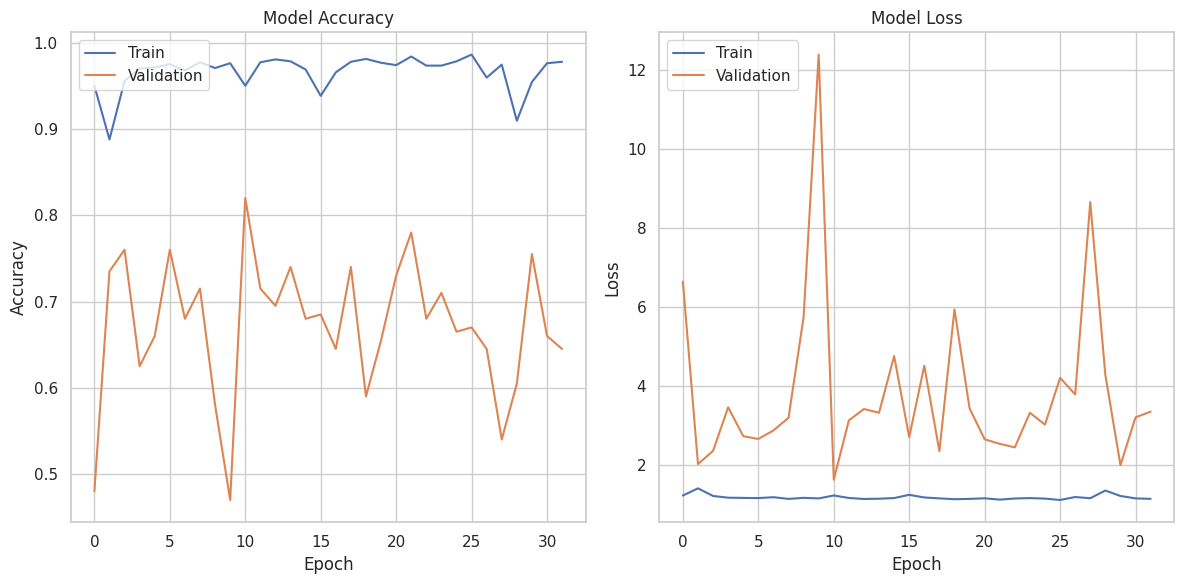

63/63 [==============================] - 1s 18ms/step
y_pred [[1.9018107e-05 2.0874681e-05 9.9996006e-01]
 [9.1535822e-03 5.8460361e-01 4.0624282e-01]
 [2.4749750e-06 9.0108114e-07 9.9999666e-01]
 ...
 [8.8256931e-01 5.3023871e-02 6.4406835e-02]
 [6.8022442e-01 7.3577775e-07 3.1977481e-01]
 [6.4204924e-02 9.3577844e-01 1.6627344e-05]]
Accuracy: 0.321
Confusion Matrix: [[148 204 320]
 [163 189 323]
 [159 189 305]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.1699 - sparse_categorical_accuracy: 0.9660

57/57 [==============================] - 6s 98ms/step - loss: 1.1679 - sparse_categorical_accuracy: 0.9656 - val_loss: 3.3427 - val_sparse_categorical_accuracy: 0.7050
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1439 - sparse_categorical_accuracy: 0.9760

57/57 [==============================] - 6s 101ms/step - loss: 1.1505 - sparse_categorical_accuracy: 0.9750 - val_loss: 2.8566 - val_sparse_categorical_accuracy: 0.7300
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.2623 - sparse_categorical_accuracy: 0.9330

57/57 [==============================] - 6s 98ms/step - loss: 1.2591 - sparse_categorical_accuracy: 0.9328 - val_loss: 2.8248 - val_sparse_categorical_accuracy: 0.7300
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 1.1645 - sparse_categorical_accuracy: 0.9688

57/57 [==============================] - 5s 96ms/step - loss: 1.1662 - sparse_categorical_accuracy: 0.9672 - val_loss: 2.6394 - val_sparse_categorical_accuracy: 0.7600
Epoch 5/32
57/57 [==============================] - ETA: 0s - loss: 1.2118 - sparse_categorical_accuracy: 0.9533

57/57 [==============================] - 6s 105ms/step - loss: 1.2118 - sparse_categorical_accuracy: 0.9533 - val_loss: 12.3622 - val_sparse_categorical_accuracy: 0.5150
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.1769 - sparse_categorical_accuracy: 0.9637

57/57 [==============================] - 6s 98ms/step - loss: 1.1837 - sparse_categorical_accuracy: 0.9611 - val_loss: 5.6354 - val_sparse_categorical_accuracy: 0.5300
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 1.2023 - sparse_categorical_accuracy: 0.9598

57/57 [==============================] - 6s 98ms/step - loss: 1.2018 - sparse_categorical_accuracy: 0.9589 - val_loss: 3.4729 - val_sparse_categorical_accuracy: 0.6850
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 1.1568 - sparse_categorical_accuracy: 0.9721

57/57 [==============================] - 6s 103ms/step - loss: 1.1576 - sparse_categorical_accuracy: 0.9711 - val_loss: 237.9931 - val_sparse_categorical_accuracy: 0.3150
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.4672 - sparse_categorical_accuracy: 0.4682

57/57 [==============================] - 6s 98ms/step - loss: 2.4618 - sparse_categorical_accuracy: 0.4683 - val_loss: 2.5896 - val_sparse_categorical_accuracy: 0.3700
Epoch 10/32
57/57 [==============================] - ETA: 0s - loss: 2.1299 - sparse_categorical_accuracy: 0.4611

57/57 [==============================] - 6s 103ms/step - loss: 2.1299 - sparse_categorical_accuracy: 0.4611 - val_loss: 2.6494 - val_sparse_categorical_accuracy: 0.4050
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.0590 - sparse_categorical_accuracy: 0.5206

57/57 [==============================] - 6s 97ms/step - loss: 2.0559 - sparse_categorical_accuracy: 0.5194 - val_loss: 6.8668 - val_sparse_categorical_accuracy: 0.3100
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.9756 - sparse_categorical_accuracy: 0.5831

57/57 [==============================] - 5s 97ms/step - loss: 1.9730 - sparse_categorical_accuracy: 0.5828 - val_loss: 3.8506 - val_sparse_categorical_accuracy: 0.4000
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 1.9440 - sparse_categorical_accuracy: 0.6150

57/57 [==============================] - 6s 99ms/step - loss: 1.9417 - sparse_categorical_accuracy: 0.6150 - val_loss: 2.2595 - val_sparse_categorical_accuracy: 0.4700
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.8410 - sparse_categorical_accuracy: 0.6758

57/57 [==============================] - 6s 97ms/step - loss: 1.8410 - sparse_categorical_accuracy: 0.6756 - val_loss: 3.0231 - val_sparse_categorical_accuracy: 0.5300
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 1.7618 - sparse_categorical_accuracy: 0.7260

57/57 [==============================] - 6s 98ms/step - loss: 1.7584 - sparse_categorical_accuracy: 0.7256 - val_loss: 4.0798 - val_sparse_categorical_accuracy: 0.4950
Epoch 16/32
57/57 [==============================] - ETA: 0s - loss: 1.6404 - sparse_categorical_accuracy: 0.7889

57/57 [==============================] - 6s 99ms/step - loss: 1.6404 - sparse_categorical_accuracy: 0.7889 - val_loss: 3.9782 - val_sparse_categorical_accuracy: 0.4350
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.5430 - sparse_categorical_accuracy: 0.8331

57/57 [==============================] - 6s 97ms/step - loss: 1.5442 - sparse_categorical_accuracy: 0.8317 - val_loss: 3.2448 - val_sparse_categorical_accuracy: 0.5250
Epoch 18/32
57/57 [==============================] - ETA: 0s - loss: 1.4656 - sparse_categorical_accuracy: 0.8594

57/57 [==============================] - 6s 102ms/step - loss: 1.4656 - sparse_categorical_accuracy: 0.8594 - val_loss: 3.3003 - val_sparse_categorical_accuracy: 0.5000
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 1.4121 - sparse_categorical_accuracy: 0.8834

57/57 [==============================] - 5s 96ms/step - loss: 1.4088 - sparse_categorical_accuracy: 0.8833 - val_loss: 3.2067 - val_sparse_categorical_accuracy: 0.5500
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.4021 - sparse_categorical_accuracy: 0.8795

57/57 [==============================] - 6s 98ms/step - loss: 1.3989 - sparse_categorical_accuracy: 0.8794 - val_loss: 6.1929 - val_sparse_categorical_accuracy: 0.5200
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 1.3123 - sparse_categorical_accuracy: 0.9202

57/57 [==============================] - 6s 101ms/step - loss: 1.3082 - sparse_categorical_accuracy: 0.9206 - val_loss: 3.8896 - val_sparse_categorical_accuracy: 0.5300
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.2565 - sparse_categorical_accuracy: 0.9314

57/57 [==============================] - 6s 98ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.9289 - val_loss: 5.2099 - val_sparse_categorical_accuracy: 0.4950
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 1.2426 - sparse_categorical_accuracy: 0.9425

57/57 [==============================] - 6s 98ms/step - loss: 1.2419 - sparse_categorical_accuracy: 0.9417 - val_loss: 6.1215 - val_sparse_categorical_accuracy: 0.5650
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 1.3199 - sparse_categorical_accuracy: 0.9135

57/57 [==============================] - 6s 99ms/step - loss: 1.3158 - sparse_categorical_accuracy: 0.9139 - val_loss: 3.7555 - val_sparse_categorical_accuracy: 0.5200
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.2524 - sparse_categorical_accuracy: 0.9414

57/57 [==============================] - 6s 97ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.9406 - val_loss: 4.3227 - val_sparse_categorical_accuracy: 0.5150
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.2444 - sparse_categorical_accuracy: 0.9431

57/57 [==============================] - 6s 100ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.9422 - val_loss: 4.3942 - val_sparse_categorical_accuracy: 0.5400
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.2144 - sparse_categorical_accuracy: 0.9498

57/57 [==============================] - 6s 99ms/step - loss: 1.2178 - sparse_categorical_accuracy: 0.9489 - val_loss: 5.0438 - val_sparse_categorical_accuracy: 0.5350
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.1606 - sparse_categorical_accuracy: 0.9693

57/57 [==============================] - 5s 97ms/step - loss: 1.1582 - sparse_categorical_accuracy: 0.9689 - val_loss: 3.1294 - val_sparse_categorical_accuracy: 0.6100
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.1971 - sparse_categorical_accuracy: 0.9542

57/57 [==============================] - 6s 102ms/step - loss: 1.1958 - sparse_categorical_accuracy: 0.9533 - val_loss: 3.1445 - val_sparse_categorical_accuracy: 0.6200
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.1984 - sparse_categorical_accuracy: 0.9587

57/57 [==============================] - 6s 97ms/step - loss: 1.1944 - sparse_categorical_accuracy: 0.9589 - val_loss: 3.2063 - val_sparse_categorical_accuracy: 0.6100
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.1514 - sparse_categorical_accuracy: 0.9699

57/57 [==============================] - 6s 99ms/step - loss: 1.1547 - sparse_categorical_accuracy: 0.9678 - val_loss: 4.2738 - val_sparse_categorical_accuracy: 0.5350
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.1891 - sparse_categorical_accuracy: 0.9615

57/57 [==============================] - 6s 100ms/step - loss: 1.1886 - sparse_categorical_accuracy: 0.9600 - val_loss: 5.7699 - val_sparse_categorical_accuracy: 0.5400


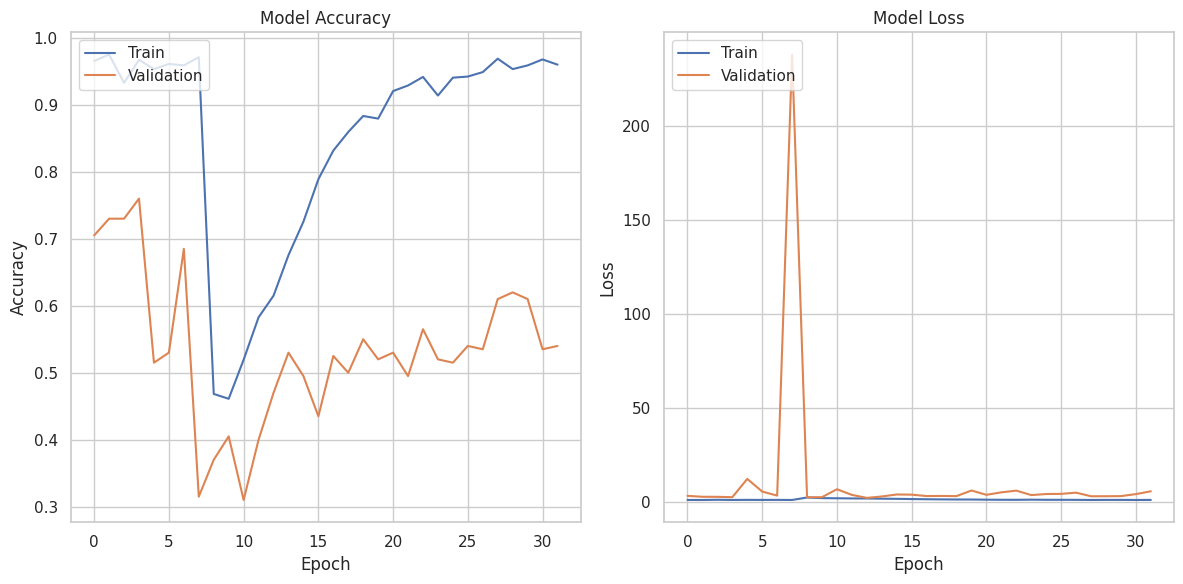

63/63 [==============================] - 1s 17ms/step
y_pred [[2.4428312e-08 1.0000000e+00 4.0419015e-11]
 [1.4469431e-08 1.0000000e+00 4.0768031e-12]
 [6.8062029e-05 9.9948019e-01 4.5176523e-04]
 ...
 [9.4991583e-01 5.0079927e-02 4.2299298e-06]
 [1.0497952e-02 2.8840653e-03 9.8661798e-01]
 [3.2596745e-05 9.9996746e-01 2.0919313e-09]]
Accuracy: 0.3325
Confusion Matrix: [[124 278 270]
 [130 236 309]
 [118 230 305]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.2821 - sparse_categorical_accuracy: 0.9202

57/57 [==============================] - 6s 98ms/step - loss: 1.2800 - sparse_categorical_accuracy: 0.9194 - val_loss: 1.6807 - val_sparse_categorical_accuracy: 0.8700
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.2199 - sparse_categorical_accuracy: 0.9475

57/57 [==============================] - 5s 96ms/step - loss: 1.2167 - sparse_categorical_accuracy: 0.9472 - val_loss: 2.7365 - val_sparse_categorical_accuracy: 0.7200
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.2039 - sparse_categorical_accuracy: 0.9492

57/57 [==============================] - 6s 100ms/step - loss: 1.2075 - sparse_categorical_accuracy: 0.9483 - val_loss: 3.3854 - val_sparse_categorical_accuracy: 0.6750
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 1.1784 - sparse_categorical_accuracy: 0.9643

57/57 [==============================] - 6s 97ms/step - loss: 1.1771 - sparse_categorical_accuracy: 0.9633 - val_loss: 1.8666 - val_sparse_categorical_accuracy: 0.8050
Epoch 5/32
57/57 [==============================] - ETA: 0s - loss: 1.1629 - sparse_categorical_accuracy: 0.9683

57/57 [==============================] - 6s 103ms/step - loss: 1.1629 - sparse_categorical_accuracy: 0.9683 - val_loss: 2.0633 - val_sparse_categorical_accuracy: 0.7450
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.1360 - sparse_categorical_accuracy: 0.9827

57/57 [==============================] - 6s 98ms/step - loss: 1.1354 - sparse_categorical_accuracy: 0.9811 - val_loss: 6.3771 - val_sparse_categorical_accuracy: 0.5850
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 1.1800 - sparse_categorical_accuracy: 0.9626

57/57 [==============================] - 5s 96ms/step - loss: 1.1760 - sparse_categorical_accuracy: 0.9628 - val_loss: 1.7907 - val_sparse_categorical_accuracy: 0.8500
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 1.1325 - sparse_categorical_accuracy: 0.9766

57/57 [==============================] - 6s 102ms/step - loss: 1.1295 - sparse_categorical_accuracy: 0.9761 - val_loss: 1.7862 - val_sparse_categorical_accuracy: 0.8100
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.1322 - sparse_categorical_accuracy: 0.9821

57/57 [==============================] - 5s 97ms/step - loss: 1.1286 - sparse_categorical_accuracy: 0.9822 - val_loss: 2.4282 - val_sparse_categorical_accuracy: 0.7600
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 1.1531 - sparse_categorical_accuracy: 0.9727

57/57 [==============================] - 6s 99ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.9717 - val_loss: 3.1851 - val_sparse_categorical_accuracy: 0.7100
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 1.1805 - sparse_categorical_accuracy: 0.9572

57/57 [==============================] - 6s 100ms/step - loss: 1.1805 - sparse_categorical_accuracy: 0.9572 - val_loss: 4.7287 - val_sparse_categorical_accuracy: 0.5600
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.1933 - sparse_categorical_accuracy: 0.9615

57/57 [==============================] - 6s 97ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.9611 - val_loss: 2.0722 - val_sparse_categorical_accuracy: 0.7400
Epoch 13/32
57/57 [==============================] - ETA: 0s - loss: 1.1771 - sparse_categorical_accuracy: 0.9622

57/57 [==============================] - 6s 101ms/step - loss: 1.1771 - sparse_categorical_accuracy: 0.9622 - val_loss: 3.1226 - val_sparse_categorical_accuracy: 0.6800
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.2284 - sparse_categorical_accuracy: 0.9498

57/57 [==============================] - 5s 97ms/step - loss: 1.2254 - sparse_categorical_accuracy: 0.9494 - val_loss: 101.6664 - val_sparse_categorical_accuracy: 0.3800
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 1.5316 - sparse_categorical_accuracy: 0.8415

57/57 [==============================] - 5s 97ms/step - loss: 1.5312 - sparse_categorical_accuracy: 0.8411 - val_loss: 5.0701 - val_sparse_categorical_accuracy: 0.4850
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.2875 - sparse_categorical_accuracy: 0.9252

57/57 [==============================] - 6s 101ms/step - loss: 1.2884 - sparse_categorical_accuracy: 0.9239 - val_loss: 4.3249 - val_sparse_categorical_accuracy: 0.5850
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.2190 - sparse_categorical_accuracy: 0.9498

57/57 [==============================] - 6s 97ms/step - loss: 1.2172 - sparse_categorical_accuracy: 0.9483 - val_loss: 2.4383 - val_sparse_categorical_accuracy: 0.7200
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 1.1750 - sparse_categorical_accuracy: 0.9693

57/57 [==============================] - 6s 99ms/step - loss: 1.1749 - sparse_categorical_accuracy: 0.9689 - val_loss: 2.6653 - val_sparse_categorical_accuracy: 0.7550
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 1.1334 - sparse_categorical_accuracy: 0.9788

57/57 [==============================] - 6s 97ms/step - loss: 1.1350 - sparse_categorical_accuracy: 0.9778 - val_loss: 5.0572 - val_sparse_categorical_accuracy: 0.5550
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.1759 - sparse_categorical_accuracy: 0.9648

57/57 [==============================] - 6s 98ms/step - loss: 1.1756 - sparse_categorical_accuracy: 0.9644 - val_loss: 4.7553 - val_sparse_categorical_accuracy: 0.5500
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 1.1441 - sparse_categorical_accuracy: 0.9738

57/57 [==============================] - 6s 103ms/step - loss: 1.1474 - sparse_categorical_accuracy: 0.9728 - val_loss: 3.2196 - val_sparse_categorical_accuracy: 0.6700
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.2609 - sparse_categorical_accuracy: 0.9381

57/57 [==============================] - 6s 97ms/step - loss: 1.2592 - sparse_categorical_accuracy: 0.9372 - val_loss: 2.6935 - val_sparse_categorical_accuracy: 0.6300
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 1.1718 - sparse_categorical_accuracy: 0.9699

57/57 [==============================] - 6s 97ms/step - loss: 1.1699 - sparse_categorical_accuracy: 0.9689 - val_loss: 2.8143 - val_sparse_categorical_accuracy: 0.6900
Epoch 24/32
57/57 [==============================] - ETA: 0s - loss: 1.1474 - sparse_categorical_accuracy: 0.9789

57/57 [==============================] - 6s 105ms/step - loss: 1.1474 - sparse_categorical_accuracy: 0.9789 - val_loss: 2.5865 - val_sparse_categorical_accuracy: 0.7600
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.1189 - sparse_categorical_accuracy: 0.9844

57/57 [==============================] - 6s 97ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.9844 - val_loss: 2.7239 - val_sparse_categorical_accuracy: 0.7150
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 1.1272 - sparse_categorical_accuracy: 0.9816

57/57 [==============================] - 6s 99ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.9817 - val_loss: 3.5524 - val_sparse_categorical_accuracy: 0.6500
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.1093 - sparse_categorical_accuracy: 0.9866

57/57 [==============================] - 6s 98ms/step - loss: 1.1062 - sparse_categorical_accuracy: 0.9861 - val_loss: 3.6201 - val_sparse_categorical_accuracy: 0.6650
Epoch 28/32
57/57 [==============================] - ETA: 0s - loss: 1.1547 - sparse_categorical_accuracy: 0.9744

57/57 [==============================] - 6s 98ms/step - loss: 1.1547 - sparse_categorical_accuracy: 0.9744 - val_loss: 3.5106 - val_sparse_categorical_accuracy: 0.6450
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.1054 - sparse_categorical_accuracy: 0.9905

57/57 [==============================] - 6s 102ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.9894 - val_loss: 2.2010 - val_sparse_categorical_accuracy: 0.7450
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.1270 - sparse_categorical_accuracy: 0.9821

57/57 [==============================] - 6s 98ms/step - loss: 1.1233 - sparse_categorical_accuracy: 0.9822 - val_loss: 2.7345 - val_sparse_categorical_accuracy: 0.7400
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 1.1174 - sparse_categorical_accuracy: 0.9794

57/57 [==============================] - 6s 97ms/step - loss: 1.1143 - sparse_categorical_accuracy: 0.9794 - val_loss: 6.0130 - val_sparse_categorical_accuracy: 0.5450
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.1182 - sparse_categorical_accuracy: 0.9849

57/57 [==============================] - 6s 101ms/step - loss: 1.1167 - sparse_categorical_accuracy: 0.9833 - val_loss: 5.7062 - val_sparse_categorical_accuracy: 0.4600


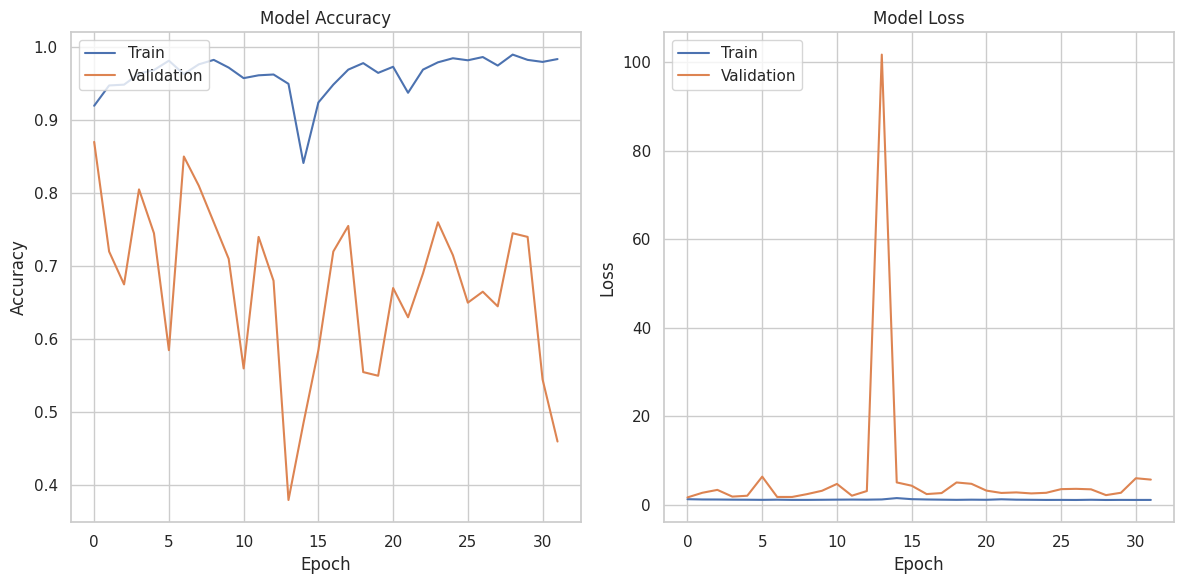

63/63 [==============================] - 1s 18ms/step
y_pred [[9.9459076e-01 1.7201502e-05 5.3920159e-03]
 [9.9999321e-01 6.6598368e-06 1.3165969e-07]
 [1.0322444e-04 9.7666373e-03 9.9013013e-01]
 ...
 [6.7301720e-01 3.2683825e-01 1.4454113e-04]
 [9.9999964e-01 1.2730922e-08 3.2451175e-07]
 [5.4929330e-08 1.0000000e+00 1.3636079e-09]]
Accuracy: 0.33
Confusion Matrix: [[417 174  81]
 [419 185  71]
 [434 161  58]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 1.2048 - sparse_categorical_accuracy: 0.9604

57/57 [==============================] - 6s 100ms/step - loss: 1.2043 - sparse_categorical_accuracy: 0.9594 - val_loss: 2.8311 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 1.1311 - sparse_categorical_accuracy: 0.9816

57/57 [==============================] - 6s 101ms/step - loss: 1.1302 - sparse_categorical_accuracy: 0.9806 - val_loss: 1.7729 - val_sparse_categorical_accuracy: 0.8500
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 1.1901 - sparse_categorical_accuracy: 0.9621

57/57 [==============================] - 6s 98ms/step - loss: 1.1861 - sparse_categorical_accuracy: 0.9622 - val_loss: 1.6583 - val_sparse_categorical_accuracy: 0.8750
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 1.1449 - sparse_categorical_accuracy: 0.9754

57/57 [==============================] - 6s 97ms/step - loss: 1.1489 - sparse_categorical_accuracy: 0.9733 - val_loss: 7.4325 - val_sparse_categorical_accuracy: 0.4550
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 1.3411 - sparse_categorical_accuracy: 0.9040

57/57 [==============================] - 6s 102ms/step - loss: 1.3408 - sparse_categorical_accuracy: 0.9033 - val_loss: 2.6715 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 1.1663 - sparse_categorical_accuracy: 0.9688

57/57 [==============================] - 6s 97ms/step - loss: 1.1676 - sparse_categorical_accuracy: 0.9678 - val_loss: 2.3983 - val_sparse_categorical_accuracy: 0.7400
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 1.1553 - sparse_categorical_accuracy: 0.9727

57/57 [==============================] - 6s 98ms/step - loss: 1.1563 - sparse_categorical_accuracy: 0.9717 - val_loss: 2.4786 - val_sparse_categorical_accuracy: 0.7500
Epoch 8/32
57/57 [==============================] - ETA: 0s - loss: 1.1458 - sparse_categorical_accuracy: 0.9744

57/57 [==============================] - 6s 100ms/step - loss: 1.1458 - sparse_categorical_accuracy: 0.9744 - val_loss: 4.3199 - val_sparse_categorical_accuracy: 0.6150
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 1.1794 - sparse_categorical_accuracy: 0.9654

57/57 [==============================] - 5s 96ms/step - loss: 1.1772 - sparse_categorical_accuracy: 0.9650 - val_loss: 1.9640 - val_sparse_categorical_accuracy: 0.8050
Epoch 10/32
57/57 [==============================] - ETA: 0s - loss: 1.1437 - sparse_categorical_accuracy: 0.9756

57/57 [==============================] - 6s 104ms/step - loss: 1.1437 - sparse_categorical_accuracy: 0.9756 - val_loss: 1.8114 - val_sparse_categorical_accuracy: 0.8400
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 1.1121 - sparse_categorical_accuracy: 0.9872

57/57 [==============================] - 6s 98ms/step - loss: 1.1122 - sparse_categorical_accuracy: 0.9867 - val_loss: 6.2561 - val_sparse_categorical_accuracy: 0.5550
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 1.1308 - sparse_categorical_accuracy: 0.9821

57/57 [==============================] - 5s 97ms/step - loss: 1.1364 - sparse_categorical_accuracy: 0.9800 - val_loss: 4.0748 - val_sparse_categorical_accuracy: 0.6100
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 1.1847 - sparse_categorical_accuracy: 0.9643

57/57 [==============================] - 6s 103ms/step - loss: 1.1835 - sparse_categorical_accuracy: 0.9633 - val_loss: 3.4783 - val_sparse_categorical_accuracy: 0.6550
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 1.1554 - sparse_categorical_accuracy: 0.9738

57/57 [==============================] - 6s 98ms/step - loss: 1.1540 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.8959 - val_sparse_categorical_accuracy: 0.8000
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 1.1416 - sparse_categorical_accuracy: 0.9777

57/57 [==============================] - 6s 99ms/step - loss: 1.1378 - sparse_categorical_accuracy: 0.9778 - val_loss: 3.1138 - val_sparse_categorical_accuracy: 0.7350
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 1.0975 - sparse_categorical_accuracy: 0.9905

57/57 [==============================] - 6s 99ms/step - loss: 1.0966 - sparse_categorical_accuracy: 0.9894 - val_loss: 2.3941 - val_sparse_categorical_accuracy: 0.7700
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 1.1167 - sparse_categorical_accuracy: 0.9855

57/57 [==============================] - 6s 97ms/step - loss: 1.1167 - sparse_categorical_accuracy: 0.9844 - val_loss: 11.0763 - val_sparse_categorical_accuracy: 0.4500
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 1.2216 - sparse_categorical_accuracy: 0.9414

57/57 [==============================] - 6s 104ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.9411 - val_loss: 2.9193 - val_sparse_categorical_accuracy: 0.7050
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 1.1617 - sparse_categorical_accuracy: 0.9699

57/57 [==============================] - 6s 98ms/step - loss: 1.1640 - sparse_categorical_accuracy: 0.9678 - val_loss: 4.4560 - val_sparse_categorical_accuracy: 0.6250
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 1.1963 - sparse_categorical_accuracy: 0.9581

57/57 [==============================] - 6s 97ms/step - loss: 1.1943 - sparse_categorical_accuracy: 0.9578 - val_loss: 2.7295 - val_sparse_categorical_accuracy: 0.7000
Epoch 21/32
57/57 [==============================] - ETA: 0s - loss: 1.1320 - sparse_categorical_accuracy: 0.9806

57/57 [==============================] - 6s 103ms/step - loss: 1.1320 - sparse_categorical_accuracy: 0.9806 - val_loss: 3.0361 - val_sparse_categorical_accuracy: 0.7100
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 1.1773 - sparse_categorical_accuracy: 0.9648

57/57 [==============================] - 6s 97ms/step - loss: 1.1751 - sparse_categorical_accuracy: 0.9639 - val_loss: 3.0346 - val_sparse_categorical_accuracy: 0.6800
Epoch 23/32
57/57 [==============================] - ETA: 0s - loss: 1.1487 - sparse_categorical_accuracy: 0.9761

57/57 [==============================] - 6s 103ms/step - loss: 1.1487 - sparse_categorical_accuracy: 0.9761 - val_loss: 2.5289 - val_sparse_categorical_accuracy: 0.7700
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 1.1202 - sparse_categorical_accuracy: 0.9855

57/57 [==============================] - 6s 99ms/step - loss: 1.1208 - sparse_categorical_accuracy: 0.9844 - val_loss: 2.3276 - val_sparse_categorical_accuracy: 0.7600
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 1.1537 - sparse_categorical_accuracy: 0.9754

57/57 [==============================] - 6s 97ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.9750 - val_loss: 8.8908 - val_sparse_categorical_accuracy: 0.4750
Epoch 26/32
57/57 [==============================] - ETA: 0s - loss: 1.1465 - sparse_categorical_accuracy: 0.9733

57/57 [==============================] - 6s 104ms/step - loss: 1.1465 - sparse_categorical_accuracy: 0.9733 - val_loss: 4.2881 - val_sparse_categorical_accuracy: 0.7100
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 1.1603 - sparse_categorical_accuracy: 0.9660

57/57 [==============================] - 5s 97ms/step - loss: 1.1566 - sparse_categorical_accuracy: 0.9661 - val_loss: 4.5439 - val_sparse_categorical_accuracy: 0.7250
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 1.1146 - sparse_categorical_accuracy: 0.9844

57/57 [==============================] - 6s 101ms/step - loss: 1.1163 - sparse_categorical_accuracy: 0.9828 - val_loss: 4.3578 - val_sparse_categorical_accuracy: 0.6150
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 1.3063 - sparse_categorical_accuracy: 0.9241

57/57 [==============================] - 6s 99ms/step - loss: 1.3082 - sparse_categorical_accuracy: 0.9233 - val_loss: 9.3097 - val_sparse_categorical_accuracy: 0.5450
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 1.2080 - sparse_categorical_accuracy: 0.9559

57/57 [==============================] - 5s 97ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.9561 - val_loss: 2.2252 - val_sparse_categorical_accuracy: 0.7200
Epoch 31/32
57/57 [==============================] - ETA: 0s - loss: 1.1208 - sparse_categorical_accuracy: 0.9806

57/57 [==============================] - 6s 101ms/step - loss: 1.1208 - sparse_categorical_accuracy: 0.9806 - val_loss: 2.4219 - val_sparse_categorical_accuracy: 0.7500
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 1.1110 - sparse_categorical_accuracy: 0.9855

57/57 [==============================] - 6s 97ms/step - loss: 1.1105 - sparse_categorical_accuracy: 0.9844 - val_loss: 2.1277 - val_sparse_categorical_accuracy: 0.8000


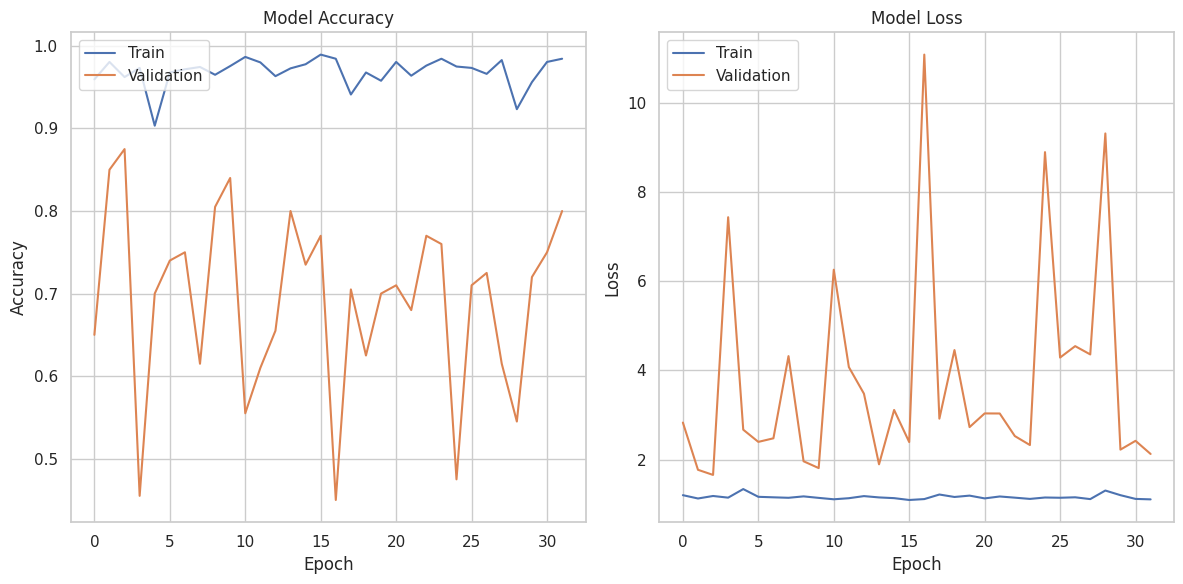

63/63 [==============================] - 1s 16ms/step
y_pred [[1.1667381e-01 3.5714719e-03 8.7975472e-01]
 [9.1776735e-04 9.9778026e-01 1.3019937e-03]
 [1.6345565e-03 9.9357384e-01 4.7915769e-03]
 ...
 [5.9558920e-06 9.9999356e-01 4.6122975e-07]
 [6.7877270e-02 1.5422437e-01 7.7789831e-01]
 [1.4840039e-05 9.9998522e-01 1.6332100e-08]]
Accuracy: 0.344
Confusion Matrix: [[221 275 176]
 [226 252 197]
 [232 206 215]]
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
Average Train Time: 3.22158021012942 minutes
/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jetml_classification_size_10000_classifier_Q0Poi

57/57 [==============================] - 6s 106ms/step - loss: 2.6733 - sparse_categorical_accuracy: 0.4550 - val_loss: 5.1543 - val_sparse_categorical_accuracy: 0.5750
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3795 - sparse_categorical_accuracy: 0.4727

57/57 [==============================] - 6s 99ms/step - loss: 2.3773 - sparse_categorical_accuracy: 0.4717 - val_loss: 2.2385 - val_sparse_categorical_accuracy: 0.5800
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.3686 - sparse_categorical_accuracy: 0.4799

57/57 [==============================] - 5s 97ms/step - loss: 2.3658 - sparse_categorical_accuracy: 0.4794 - val_loss: 2.4877 - val_sparse_categorical_accuracy: 0.5750
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3654 - sparse_categorical_accuracy: 0.4754

57/57 [==============================] - 6s 102ms/step - loss: 2.3638 - sparse_categorical_accuracy: 0.4750 - val_loss: 85805.4297 - val_sparse_categorical_accuracy: 0.3900
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3861 - sparse_categorical_accuracy: 0.4754

57/57 [==============================] - 6s 98ms/step - loss: 2.3812 - sparse_categorical_accuracy: 0.4772 - val_loss: 2.2056 - val_sparse_categorical_accuracy: 0.5750
Epoch 6/32
57/57 [==============================] - ETA: 0s - loss: 2.3518 - sparse_categorical_accuracy: 0.4756

57/57 [==============================] - 6s 103ms/step - loss: 2.3518 - sparse_categorical_accuracy: 0.4756 - val_loss: 2.1922 - val_sparse_categorical_accuracy: 0.5800
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3464 - sparse_categorical_accuracy: 0.4794

57/57 [==============================] - 6s 99ms/step - loss: 2.3452 - sparse_categorical_accuracy: 0.4783 - val_loss: 140783.7656 - val_sparse_categorical_accuracy: 0.3350
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3573 - sparse_categorical_accuracy: 0.4738

57/57 [==============================] - 6s 97ms/step - loss: 2.3527 - sparse_categorical_accuracy: 0.4744 - val_loss: 2.2556 - val_sparse_categorical_accuracy: 0.5450
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3395 - sparse_categorical_accuracy: 0.4799

57/57 [==============================] - 6s 99ms/step - loss: 2.3354 - sparse_categorical_accuracy: 0.4800 - val_loss: 3.1478 - val_sparse_categorical_accuracy: 0.5150
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3317 - sparse_categorical_accuracy: 0.4816

57/57 [==============================] - 6s 97ms/step - loss: 2.3273 - sparse_categorical_accuracy: 0.4822 - val_loss: 2.2309 - val_sparse_categorical_accuracy: 0.5800
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.3460 - sparse_categorical_accuracy: 0.4788

57/57 [==============================] - 5s 97ms/step - loss: 2.3408 - sparse_categorical_accuracy: 0.4800 - val_loss: 30.6861 - val_sparse_categorical_accuracy: 0.5800
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3365 - sparse_categorical_accuracy: 0.4805

57/57 [==============================] - 6s 99ms/step - loss: 2.3347 - sparse_categorical_accuracy: 0.4794 - val_loss: 2.2284 - val_sparse_categorical_accuracy: 0.5800
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3355 - sparse_categorical_accuracy: 0.4810

57/57 [==============================] - 6s 97ms/step - loss: 2.3333 - sparse_categorical_accuracy: 0.4800 - val_loss: 2.3912 - val_sparse_categorical_accuracy: 0.5500
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.3437 - sparse_categorical_accuracy: 0.4766

57/57 [==============================] - 6s 97ms/step - loss: 2.3396 - sparse_categorical_accuracy: 0.4772 - val_loss: 2.3760 - val_sparse_categorical_accuracy: 0.5550
Epoch 15/32
57/57 [==============================] - ETA: 0s - loss: 2.3336 - sparse_categorical_accuracy: 0.4778

57/57 [==============================] - 6s 101ms/step - loss: 2.3336 - sparse_categorical_accuracy: 0.4778 - val_loss: 2.2475 - val_sparse_categorical_accuracy: 0.5800
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3288 - sparse_categorical_accuracy: 0.4760

57/57 [==============================] - 6s 98ms/step - loss: 2.3254 - sparse_categorical_accuracy: 0.4772 - val_loss: 1240.6876 - val_sparse_categorical_accuracy: 0.4600
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.3578 - sparse_categorical_accuracy: 0.4794

57/57 [==============================] - 6s 101ms/step - loss: 2.3537 - sparse_categorical_accuracy: 0.4800 - val_loss: 2.1935 - val_sparse_categorical_accuracy: 0.5800
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3376 - sparse_categorical_accuracy: 0.4777

57/57 [==============================] - 6s 97ms/step - loss: 2.3334 - sparse_categorical_accuracy: 0.4783 - val_loss: 7.7945 - val_sparse_categorical_accuracy: 0.5800
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3374 - sparse_categorical_accuracy: 0.4754

57/57 [==============================] - 5s 96ms/step - loss: 2.3325 - sparse_categorical_accuracy: 0.4767 - val_loss: 2.2213 - val_sparse_categorical_accuracy: 0.5800
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3306 - sparse_categorical_accuracy: 0.4777

57/57 [==============================] - 6s 103ms/step - loss: 2.3286 - sparse_categorical_accuracy: 0.4772 - val_loss: 2.2416 - val_sparse_categorical_accuracy: 0.5800
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3283 - sparse_categorical_accuracy: 0.4771

57/57 [==============================] - 6s 98ms/step - loss: 2.3259 - sparse_categorical_accuracy: 0.4761 - val_loss: 2.2577 - val_sparse_categorical_accuracy: 0.5800
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.3274 - sparse_categorical_accuracy: 0.4766

57/57 [==============================] - 6s 97ms/step - loss: 2.3244 - sparse_categorical_accuracy: 0.4761 - val_loss: 2.2216 - val_sparse_categorical_accuracy: 0.5800
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3218 - sparse_categorical_accuracy: 0.4805

57/57 [==============================] - 6s 99ms/step - loss: 2.3191 - sparse_categorical_accuracy: 0.4806 - val_loss: 2.3546 - val_sparse_categorical_accuracy: 0.5700
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3265 - sparse_categorical_accuracy: 0.4816

57/57 [==============================] - 5s 97ms/step - loss: 2.3268 - sparse_categorical_accuracy: 0.4800 - val_loss: 20305.4609 - val_sparse_categorical_accuracy: 0.4450
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.3302 - sparse_categorical_accuracy: 0.4766

57/57 [==============================] - 6s 102ms/step - loss: 2.3243 - sparse_categorical_accuracy: 0.4783 - val_loss: 2.9527 - val_sparse_categorical_accuracy: 0.5400
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3227 - sparse_categorical_accuracy: 0.4782

57/57 [==============================] - 6s 97ms/step - loss: 2.3177 - sparse_categorical_accuracy: 0.4794 - val_loss: 2.2805 - val_sparse_categorical_accuracy: 0.5650
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 2.3183 - sparse_categorical_accuracy: 0.4799

57/57 [==============================] - 5s 97ms/step - loss: 2.3142 - sparse_categorical_accuracy: 0.4806 - val_loss: 110876808.0000 - val_sparse_categorical_accuracy: 0.3200
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3339 - sparse_categorical_accuracy: 0.4782

57/57 [==============================] - 6s 101ms/step - loss: 2.3301 - sparse_categorical_accuracy: 0.4783 - val_loss: 3.2458 - val_sparse_categorical_accuracy: 0.5500
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3229 - sparse_categorical_accuracy: 0.4771

57/57 [==============================] - 5s 96ms/step - loss: 2.3202 - sparse_categorical_accuracy: 0.4767 - val_loss: 4558.1196 - val_sparse_categorical_accuracy: 0.5150
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.3213 - sparse_categorical_accuracy: 0.4788

57/57 [==============================] - 6s 99ms/step - loss: 2.3186 - sparse_categorical_accuracy: 0.4789 - val_loss: 315.0358 - val_sparse_categorical_accuracy: 0.3800
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3378 - sparse_categorical_accuracy: 0.4777

57/57 [==============================] - 6s 98ms/step - loss: 2.3341 - sparse_categorical_accuracy: 0.4778 - val_loss: 170.6823 - val_sparse_categorical_accuracy: 0.5750
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3350 - sparse_categorical_accuracy: 0.4771

57/57 [==============================] - 6s 99ms/step - loss: 2.3305 - sparse_categorical_accuracy: 0.4778 - val_loss: 2.4019 - val_sparse_categorical_accuracy: 0.5500


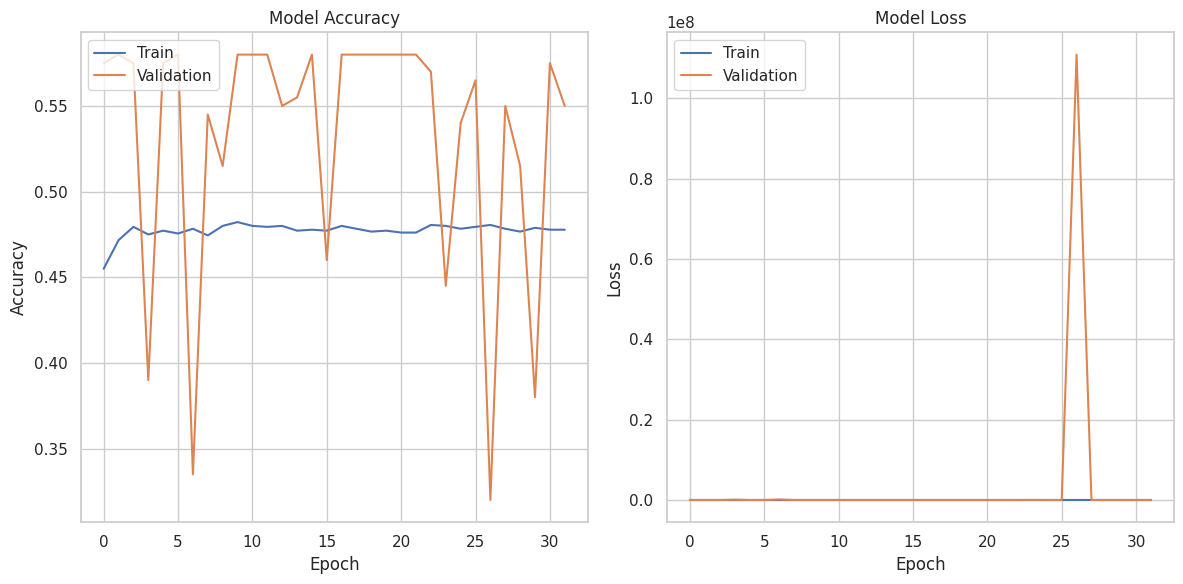

63/63 [==============================] - 1s 16ms/step
y_pred [[0.58023417 0.14616089 0.18484975 0.08875515]
 [0.5085094  0.12319767 0.18886271 0.1794302 ]
 [0.56578803 0.14418943 0.18482915 0.10519339]
 ...
 [0.526232   0.11429232 0.29810828 0.06136737]
 [0.25250354 0.6113492  0.13420771 0.00193952]
 [0.4799271  0.04567153 0.46659258 0.00780882]]
Accuracy: 0.4785
Confusion Matrix: [[949  33  30   0]
 [302   3   9   0]
 [324   5   5   0]
 [330   8   2   0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.3163 - sparse_categorical_accuracy: 0.4872

57/57 [==============================] - 6s 100ms/step - loss: 2.3132 - sparse_categorical_accuracy: 0.4867 - val_loss: 2.6577 - val_sparse_categorical_accuracy: 0.3700
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3618 - sparse_categorical_accuracy: 0.4860

57/57 [==============================] - 5s 97ms/step - loss: 2.3593 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.2979 - val_sparse_categorical_accuracy: 0.5250
Epoch 3/32
57/57 [==============================] - ETA: 0s - loss: 2.3226 - sparse_categorical_accuracy: 0.4878

57/57 [==============================] - 6s 103ms/step - loss: 2.3226 - sparse_categorical_accuracy: 0.4878 - val_loss: 2.2779 - val_sparse_categorical_accuracy: 0.5250
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3278 - sparse_categorical_accuracy: 0.4872

57/57 [==============================] - 6s 97ms/step - loss: 2.3236 - sparse_categorical_accuracy: 0.4878 - val_loss: 2.7178 - val_sparse_categorical_accuracy: 0.5250
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3272 - sparse_categorical_accuracy: 0.4844

57/57 [==============================] - 6s 97ms/step - loss: 2.3237 - sparse_categorical_accuracy: 0.4844 - val_loss: 19240.1426 - val_sparse_categorical_accuracy: 0.5250
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.3262 - sparse_categorical_accuracy: 0.4827

57/57 [==============================] - 6s 103ms/step - loss: 2.3215 - sparse_categorical_accuracy: 0.4839 - val_loss: 4.3388 - val_sparse_categorical_accuracy: 0.5250
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3163 - sparse_categorical_accuracy: 0.4855

57/57 [==============================] - 6s 97ms/step - loss: 2.3140 - sparse_categorical_accuracy: 0.4850 - val_loss: 72993840.0000 - val_sparse_categorical_accuracy: 0.5250
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3298 - sparse_categorical_accuracy: 0.4866

57/57 [==============================] - 6s 102ms/step - loss: 2.3263 - sparse_categorical_accuracy: 0.4867 - val_loss: 2.2917 - val_sparse_categorical_accuracy: 0.5250
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3154 - sparse_categorical_accuracy: 0.4872

57/57 [==============================] - 6s 98ms/step - loss: 2.3130 - sparse_categorical_accuracy: 0.4872 - val_loss: 2.2463 - val_sparse_categorical_accuracy: 0.5250
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3327 - sparse_categorical_accuracy: 0.4833

57/57 [==============================] - 6s 98ms/step - loss: 2.3300 - sparse_categorical_accuracy: 0.4828 - val_loss: 4.6809 - val_sparse_categorical_accuracy: 0.5250
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 2.3149 - sparse_categorical_accuracy: 0.4844

57/57 [==============================] - 6s 100ms/step - loss: 2.3149 - sparse_categorical_accuracy: 0.4844 - val_loss: 11.7605 - val_sparse_categorical_accuracy: 0.4100
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3179 - sparse_categorical_accuracy: 0.4849

57/57 [==============================] - 6s 98ms/step - loss: 2.3143 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.2937 - val_sparse_categorical_accuracy: 0.5250
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3041 - sparse_categorical_accuracy: 0.4838

57/57 [==============================] - 6s 97ms/step - loss: 2.3005 - sparse_categorical_accuracy: 0.4839 - val_loss: 9.3151 - val_sparse_categorical_accuracy: 0.4800
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.3251 - sparse_categorical_accuracy: 0.4844

57/57 [==============================] - 6s 102ms/step - loss: 2.3214 - sparse_categorical_accuracy: 0.4844 - val_loss: 289259.9688 - val_sparse_categorical_accuracy: 0.4650
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3265 - sparse_categorical_accuracy: 0.4844

57/57 [==============================] - 6s 98ms/step - loss: 2.3227 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.2641 - val_sparse_categorical_accuracy: 0.5250
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3143 - sparse_categorical_accuracy: 0.4872

57/57 [==============================] - 6s 101ms/step - loss: 2.3129 - sparse_categorical_accuracy: 0.4856 - val_loss: 10304230.0000 - val_sparse_categorical_accuracy: 0.4100
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.3153 - sparse_categorical_accuracy: 0.4860

57/57 [==============================] - 6s 98ms/step - loss: 2.3117 - sparse_categorical_accuracy: 0.4867 - val_loss: 537.0599 - val_sparse_categorical_accuracy: 0.3900
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3136 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 97ms/step - loss: 2.3110 - sparse_categorical_accuracy: 0.4883 - val_loss: 971.1688 - val_sparse_categorical_accuracy: 0.3750
Epoch 19/32
57/57 [==============================] - ETA: 0s - loss: 2.3086 - sparse_categorical_accuracy: 0.4889

57/57 [==============================] - 6s 104ms/step - loss: 2.3086 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.4532 - val_sparse_categorical_accuracy: 0.5250
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3018 - sparse_categorical_accuracy: 0.4855

57/57 [==============================] - 6s 98ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.4317 - val_sparse_categorical_accuracy: 0.5250
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3079 - sparse_categorical_accuracy: 0.4849

57/57 [==============================] - 6s 98ms/step - loss: 2.3033 - sparse_categorical_accuracy: 0.4861 - val_loss: 628444.2500 - val_sparse_categorical_accuracy: 0.3400
Epoch 22/32
57/57 [==============================] - ETA: 0s - loss: 2.2980 - sparse_categorical_accuracy: 0.4833

57/57 [==============================] - 6s 103ms/step - loss: 2.2980 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.2375 - val_sparse_categorical_accuracy: 0.5300
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.2953 - sparse_categorical_accuracy: 0.4855

57/57 [==============================] - 6s 97ms/step - loss: 2.2925 - sparse_categorical_accuracy: 0.4850 - val_loss: 21732.6953 - val_sparse_categorical_accuracy: 0.3550
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3390 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 102ms/step - loss: 2.3362 - sparse_categorical_accuracy: 0.4872 - val_loss: 2.3021 - val_sparse_categorical_accuracy: 0.5100
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.3238 - sparse_categorical_accuracy: 0.4877

57/57 [==============================] - 6s 97ms/step - loss: 2.3185 - sparse_categorical_accuracy: 0.4889 - val_loss: 5.0736 - val_sparse_categorical_accuracy: 0.3600
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3235 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 97ms/step - loss: 2.3216 - sparse_categorical_accuracy: 0.4867 - val_loss: 2.2836 - val_sparse_categorical_accuracy: 0.5250
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 2.3179 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 103ms/step - loss: 2.3158 - sparse_categorical_accuracy: 0.4872 - val_loss: 196.3661 - val_sparse_categorical_accuracy: 0.5250
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3298 - sparse_categorical_accuracy: 0.4866

57/57 [==============================] - 6s 97ms/step - loss: 2.3253 - sparse_categorical_accuracy: 0.4878 - val_loss: 2.7914 - val_sparse_categorical_accuracy: 0.5250
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3304 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 98ms/step - loss: 2.3280 - sparse_categorical_accuracy: 0.4872 - val_loss: 10.0267 - val_sparse_categorical_accuracy: 0.3600
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.3351 - sparse_categorical_accuracy: 0.4849

57/57 [==============================] - 6s 102ms/step - loss: 2.3306 - sparse_categorical_accuracy: 0.4861 - val_loss: 3185.6982 - val_sparse_categorical_accuracy: 0.5250
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3213 - sparse_categorical_accuracy: 0.4877

57/57 [==============================] - 6s 97ms/step - loss: 2.3187 - sparse_categorical_accuracy: 0.4878 - val_loss: 285.6046 - val_sparse_categorical_accuracy: 0.4000
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3278 - sparse_categorical_accuracy: 0.4838

57/57 [==============================] - 6s 99ms/step - loss: 2.3240 - sparse_categorical_accuracy: 0.4839 - val_loss: 3.8753 - val_sparse_categorical_accuracy: 0.5250


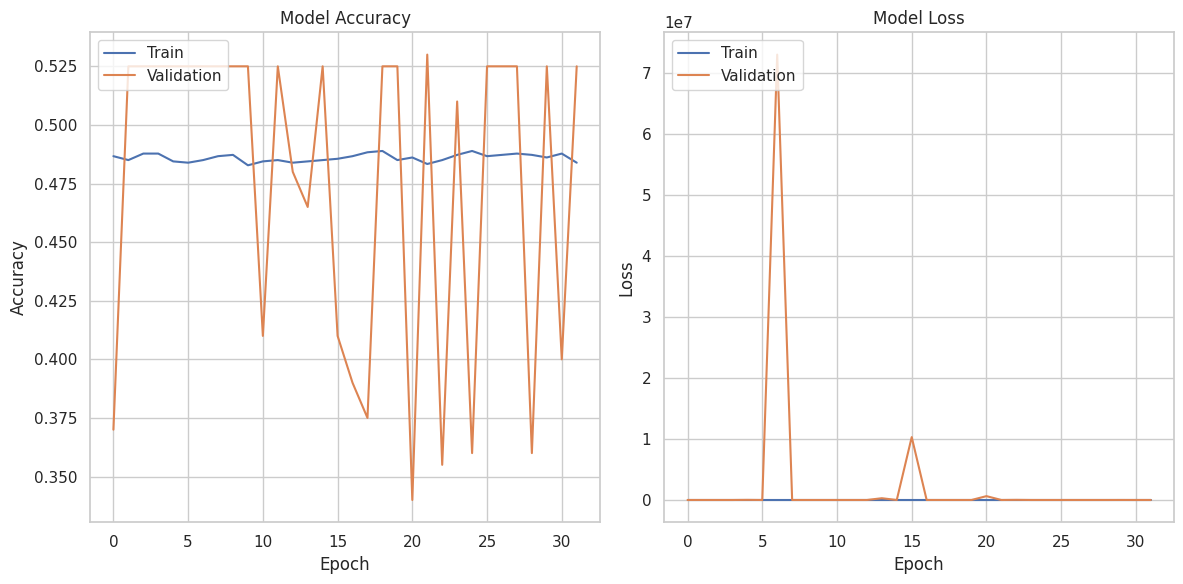

63/63 [==============================] - 1s 16ms/step
y_pred [[5.1686537e-01 1.5906486e-01 1.7681442e-01 1.4725536e-01]
 [5.1647067e-01 1.5889150e-01 1.7732559e-01 1.4731218e-01]
 [4.7772515e-01 1.9099346e-01 1.7762162e-01 1.5365979e-01]
 ...
 [9.8095208e-01 1.3942659e-02 2.6981276e-03 2.4070074e-03]
 [5.1938128e-01 1.5825090e-01 1.7801771e-01 1.4435008e-01]
 [9.9998045e-01 1.9194002e-05 1.5901325e-07 1.5842716e-07]]
Accuracy: 0.506
Confusion Matrix: [[1012    0    0    0]
 [ 314    0    0    0]
 [ 334    0    0    0]
 [ 340    0    0    0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.3155 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 103ms/step - loss: 2.3122 - sparse_categorical_accuracy: 0.4917 - val_loss: 3835.4897 - val_sparse_categorical_accuracy: 0.4750
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3213 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 98ms/step - loss: 2.3177 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4559 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/32
57/57 [==============================] - ETA: 0s - loss: 2.3143 - sparse_categorical_accuracy: 0.4928

57/57 [==============================] - 6s 104ms/step - loss: 2.3143 - sparse_categorical_accuracy: 0.4928 - val_loss: 4.0526 - val_sparse_categorical_accuracy: 0.4150
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3099 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 97ms/step - loss: 2.3084 - sparse_categorical_accuracy: 0.4894 - val_loss: 7.1079 - val_sparse_categorical_accuracy: 0.3750
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3109 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 5s 96ms/step - loss: 2.3080 - sparse_categorical_accuracy: 0.4917 - val_loss: 4.2022 - val_sparse_categorical_accuracy: 0.4800
Epoch 6/32
57/57 [==============================] - ETA: 0s - loss: 2.3101 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 105ms/step - loss: 2.3101 - sparse_categorical_accuracy: 0.4911 - val_loss: 3.5947 - val_sparse_categorical_accuracy: 0.4750
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3101 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.3082 - sparse_categorical_accuracy: 0.4928 - val_loss: 4.6838 - val_sparse_categorical_accuracy: 0.4900
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3154 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 101ms/step - loss: 2.3112 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.4446 - val_sparse_categorical_accuracy: 0.4750
Epoch 9/32
57/57 [==============================] - ETA: 0s - loss: 2.3160 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 100ms/step - loss: 2.3160 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.6077 - val_sparse_categorical_accuracy: 0.4750
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3228 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.3198 - sparse_categorical_accuracy: 0.4933 - val_loss: 3.5558 - val_sparse_categorical_accuracy: 0.4600
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 2.3121 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 104ms/step - loss: 2.3121 - sparse_categorical_accuracy: 0.4933 - val_loss: 109215.9688 - val_sparse_categorical_accuracy: 0.3950
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3100 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 98ms/step - loss: 2.3070 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.3093 - val_sparse_categorical_accuracy: 0.4700
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3082 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 98ms/step - loss: 2.3055 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.4304 - val_sparse_categorical_accuracy: 0.4850
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 2.3088 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 104ms/step - loss: 2.3088 - sparse_categorical_accuracy: 0.4922 - val_loss: 2.3593 - val_sparse_categorical_accuracy: 0.4750
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3094 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 98ms/step - loss: 2.3070 - sparse_categorical_accuracy: 0.4922 - val_loss: 117.4472 - val_sparse_categorical_accuracy: 0.4750
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3166 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 100ms/step - loss: 2.3118 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.2881 - val_sparse_categorical_accuracy: 0.4750
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.3115 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 99ms/step - loss: 2.3087 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.7258 - val_sparse_categorical_accuracy: 0.4800
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3073 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 97ms/step - loss: 2.3047 - sparse_categorical_accuracy: 0.4906 - val_loss: 14078.0254 - val_sparse_categorical_accuracy: 0.4750
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3067 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 102ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.3598 - val_sparse_categorical_accuracy: 0.4800
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3066 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4933 - val_loss: 62.7436 - val_sparse_categorical_accuracy: 0.4750
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3107 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 5s 97ms/step - loss: 2.3059 - sparse_categorical_accuracy: 0.4928 - val_loss: 17.6268 - val_sparse_categorical_accuracy: 0.3900
Epoch 22/32
57/57 [==============================] - ETA: 0s - loss: 2.3103 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 102ms/step - loss: 2.3103 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.2857 - val_sparse_categorical_accuracy: 0.4650
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3144 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 97ms/step - loss: 2.3107 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3245 - val_sparse_categorical_accuracy: 0.4750
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3097 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 99ms/step - loss: 2.3055 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3043 - val_sparse_categorical_accuracy: 0.4750
Epoch 25/32
57/57 [==============================] - ETA: 0s - loss: 2.3113 - sparse_categorical_accuracy: 0.4928

57/57 [==============================] - 6s 98ms/step - loss: 2.3113 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3532 - val_sparse_categorical_accuracy: 0.4900
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3133 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 97ms/step - loss: 2.3083 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.3909 - val_sparse_categorical_accuracy: 0.4750
Epoch 27/32
57/57 [==============================] - ETA: 0s - loss: 2.3084 - sparse_categorical_accuracy: 0.4906

57/57 [==============================] - 6s 101ms/step - loss: 2.3084 - sparse_categorical_accuracy: 0.4906 - val_loss: 2205.1482 - val_sparse_categorical_accuracy: 0.4800
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3127 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 99ms/step - loss: 2.3090 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.2920 - val_sparse_categorical_accuracy: 0.4750
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3086 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 97ms/step - loss: 2.3074 - sparse_categorical_accuracy: 0.4928 - val_loss: 9653.6113 - val_sparse_categorical_accuracy: 0.4050
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.3060 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 101ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.4928 - val_loss: 5.0484 - val_sparse_categorical_accuracy: 0.4500
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3075 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 97ms/step - loss: 2.3040 - sparse_categorical_accuracy: 0.4933 - val_loss: 5819.6182 - val_sparse_categorical_accuracy: 0.3500
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3070 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 99ms/step - loss: 2.3036 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2889 - val_sparse_categorical_accuracy: 0.4700


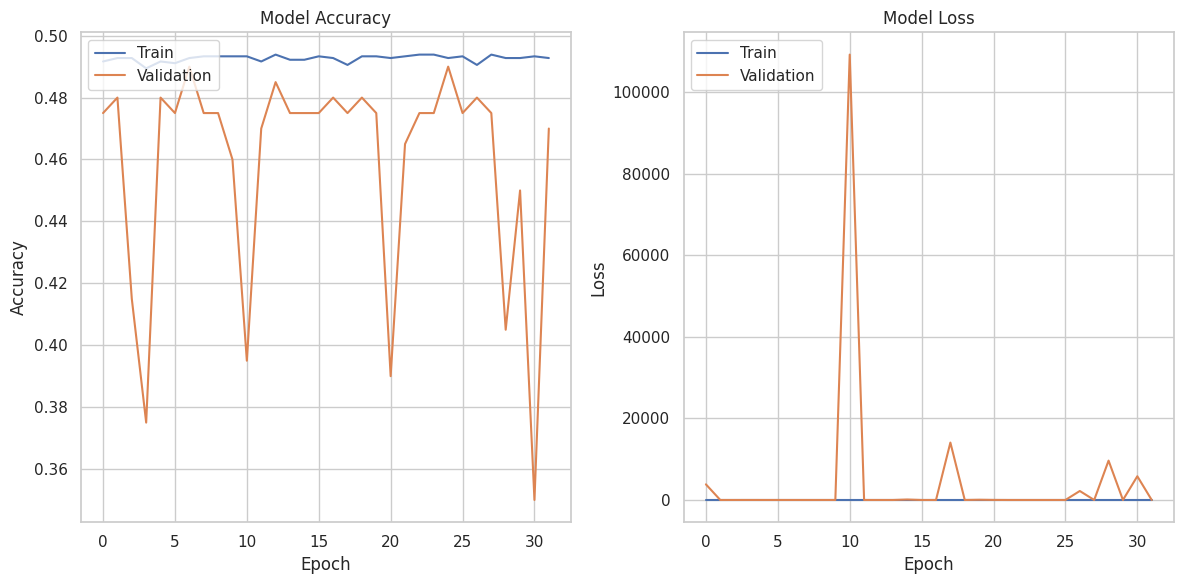

63/63 [==============================] - 1s 16ms/step
y_pred [[0.50656825 0.1634579  0.17406449 0.15590942]
 [0.51036227 0.16410214 0.1726332  0.1529024 ]
 [0.5242181  0.17157875 0.16875684 0.13544632]
 ...
 [0.6870442  0.1127934  0.14984293 0.05031947]
 [0.50260836 0.16492581 0.17549334 0.15697245]
 [0.51372373 0.17249976 0.25586107 0.05791543]]
Accuracy: 0.4985
Confusion Matrix: [[995   0  17   0]
 [309   0   5   0]
 [332   0   2   0]
 [339   0   1   0]]
Epoch 1/32
57/57 [==============================] - ETA: 0s - loss: 2.3003 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 105ms/step - loss: 2.3003 - sparse_categorical_accuracy: 0.4978 - val_loss: 101.8205 - val_sparse_categorical_accuracy: 0.4250
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.2981 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 5s 96ms/step - loss: 2.2952 - sparse_categorical_accuracy: 0.4983 - val_loss: 5.1516 - val_sparse_categorical_accuracy: 0.3950
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.3008 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 99ms/step - loss: 2.2969 - sparse_categorical_accuracy: 0.4961 - val_loss: 24.2153 - val_sparse_categorical_accuracy: 0.3700
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.2978 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 97ms/step - loss: 2.2955 - sparse_categorical_accuracy: 0.4956 - val_loss: 9.3224 - val_sparse_categorical_accuracy: 0.4250
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.2991 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 97ms/step - loss: 2.2953 - sparse_categorical_accuracy: 0.4978 - val_loss: 2.3666 - val_sparse_categorical_accuracy: 0.4200
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.2988 - sparse_categorical_accuracy: 0.4983

57/57 [==============================] - 6s 101ms/step - loss: 2.2958 - sparse_categorical_accuracy: 0.4978 - val_loss: 5.0585 - val_sparse_categorical_accuracy: 0.3950
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3016 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 97ms/step - loss: 2.2973 - sparse_categorical_accuracy: 0.4978 - val_loss: 2573.5664 - val_sparse_categorical_accuracy: 0.2900
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3081 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 5s 97ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4972 - val_loss: 2.5693 - val_sparse_categorical_accuracy: 0.4250
Epoch 9/32
57/57 [==============================] - ETA: 0s - loss: 2.2974 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 102ms/step - loss: 2.2974 - sparse_categorical_accuracy: 0.4978 - val_loss: 22.5704 - val_sparse_categorical_accuracy: 0.3700
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.2998 - sparse_categorical_accuracy: 0.4983

57/57 [==============================] - 6s 97ms/step - loss: 2.2966 - sparse_categorical_accuracy: 0.4978 - val_loss: 2.4613 - val_sparse_categorical_accuracy: 0.4150
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.2983 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 99ms/step - loss: 2.2952 - sparse_categorical_accuracy: 0.4972 - val_loss: 5.8524 - val_sparse_categorical_accuracy: 0.3800
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.2982 - sparse_categorical_accuracy: 0.4994

57/57 [==============================] - 6s 97ms/step - loss: 2.2952 - sparse_categorical_accuracy: 0.4989 - val_loss: 1819.6763 - val_sparse_categorical_accuracy: 0.4250
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3120 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 98ms/step - loss: 2.3073 - sparse_categorical_accuracy: 0.4989 - val_loss: 57.2205 - val_sparse_categorical_accuracy: 0.4250
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.3086 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 6s 100ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.5672 - val_sparse_categorical_accuracy: 0.4250
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3110 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 6s 99ms/step - loss: 2.3073 - sparse_categorical_accuracy: 0.4989 - val_loss: 5.4988 - val_sparse_categorical_accuracy: 0.4200
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3073 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 5s 97ms/step - loss: 2.3035 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.6518 - val_sparse_categorical_accuracy: 0.4250
Epoch 17/32
57/57 [==============================] - ETA: 0s - loss: 2.3043 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 6s 105ms/step - loss: 2.3043 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.4253 - val_sparse_categorical_accuracy: 0.4200
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3019 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 6s 97ms/step - loss: 2.2986 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.3644 - val_sparse_categorical_accuracy: 0.4250
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3039 - sparse_categorical_accuracy: 0.4994

57/57 [==============================] - 6s 101ms/step - loss: 2.3012 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.4456 - val_sparse_categorical_accuracy: 0.4150
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3007 - sparse_categorical_accuracy: 0.4994

57/57 [==============================] - 6s 98ms/step - loss: 2.2981 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.5332 - val_sparse_categorical_accuracy: 0.4050
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3007 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 6s 97ms/step - loss: 2.2977 - sparse_categorical_accuracy: 0.4983 - val_loss: 2.8431 - val_sparse_categorical_accuracy: 0.3800
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.3007 - sparse_categorical_accuracy: 0.4983

57/57 [==============================] - 6s 99ms/step - loss: 2.2964 - sparse_categorical_accuracy: 0.4989 - val_loss: 3.5310 - val_sparse_categorical_accuracy: 0.3950
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3016 - sparse_categorical_accuracy: 0.4972

57/57 [==============================] - 6s 99ms/step - loss: 2.2962 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.3852 - val_sparse_categorical_accuracy: 0.4250
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.2988 - sparse_categorical_accuracy: 0.4983

57/57 [==============================] - 6s 97ms/step - loss: 2.2958 - sparse_categorical_accuracy: 0.4978 - val_loss: 2.3643 - val_sparse_categorical_accuracy: 0.4250
Epoch 25/32
57/57 [==============================] - ETA: 0s - loss: 2.2933 - sparse_categorical_accuracy: 0.4989

57/57 [==============================] - 6s 102ms/step - loss: 2.2933 - sparse_categorical_accuracy: 0.4989 - val_loss: 29.4541 - val_sparse_categorical_accuracy: 0.4250
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3041 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 97ms/step - loss: 2.3006 - sparse_categorical_accuracy: 0.4978 - val_loss: 2.4503 - val_sparse_categorical_accuracy: 0.4150
Epoch 27/32
57/57 [==============================] - ETA: 0s - loss: 2.2987 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 102ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.4978 - val_loss: 2.3858 - val_sparse_categorical_accuracy: 0.4250
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.2957 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 98ms/step - loss: 2.2924 - sparse_categorical_accuracy: 0.4967 - val_loss: 3.2858 - val_sparse_categorical_accuracy: 0.3900
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.2997 - sparse_categorical_accuracy: 0.4983

57/57 [==============================] - 6s 97ms/step - loss: 2.2952 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.6299 - val_sparse_categorical_accuracy: 0.4200
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.2980 - sparse_categorical_accuracy: 0.5011

57/57 [==============================] - 6s 101ms/step - loss: 2.2971 - sparse_categorical_accuracy: 0.4989 - val_loss: 2.4132 - val_sparse_categorical_accuracy: 0.4250
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.2964 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 97ms/step - loss: 2.2931 - sparse_categorical_accuracy: 0.4978 - val_loss: 4.6255 - val_sparse_categorical_accuracy: 0.3600
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.2989 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 97ms/step - loss: 2.2955 - sparse_categorical_accuracy: 0.4944 - val_loss: 5.9924 - val_sparse_categorical_accuracy: 0.3400


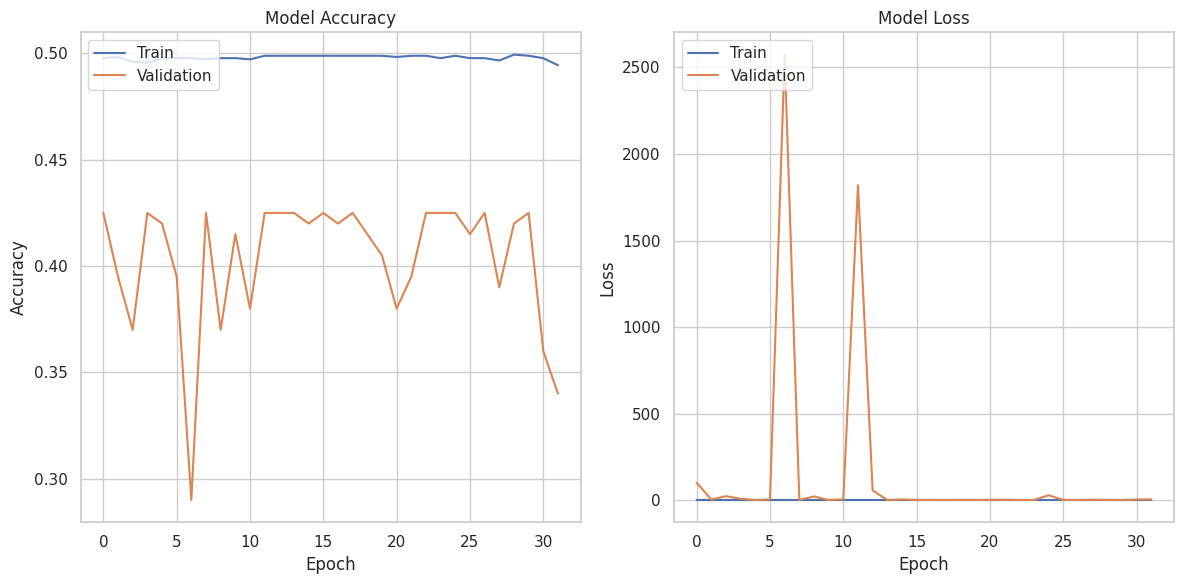

63/63 [==============================] - 1s 16ms/step
y_pred [[5.15259564e-01 1.60390168e-01 1.81965634e-01 1.42384604e-01]
 [4.94197369e-01 1.29859611e-01 3.05662304e-01 7.02806711e-02]
 [5.43608963e-01 1.72457919e-01 1.55860350e-01 1.28072724e-01]
 ...
 [1.20903447e-03 9.85891916e-07 9.98789966e-01 1.47210244e-09]
 [4.85987902e-01 1.58692345e-01 2.07756966e-01 1.47562847e-01]
 [1.10109866e-10 1.73928863e-19 1.00000000e+00 4.14751469e-28]]
Accuracy: 0.463
Confusion Matrix: [[852   0 160   0]
 [241   0  73   0]
 [260   0  74   0]
 [271   0  69   0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.3124 - sparse_categorical_accuracy: 0.4866

57/57 [==============================] - 6s 104ms/step - loss: 2.3082 - sparse_categorical_accuracy: 0.4872 - val_loss: 3.2374 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3113 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 97ms/step - loss: 2.3071 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2512 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.3094 - sparse_categorical_accuracy: 0.4844

57/57 [==============================] - 6s 100ms/step - loss: 2.3054 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.3157 - val_sparse_categorical_accuracy: 0.5150
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3081 - sparse_categorical_accuracy: 0.4872

57/57 [==============================] - 6s 98ms/step - loss: 2.3054 - sparse_categorical_accuracy: 0.4867 - val_loss: 2.2504 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3093 - sparse_categorical_accuracy: 0.4877

57/57 [==============================] - 5s 96ms/step - loss: 2.3060 - sparse_categorical_accuracy: 0.4878 - val_loss: 2.2481 - val_sparse_categorical_accuracy: 0.5150
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.3106 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 99ms/step - loss: 2.3067 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.9080 - val_sparse_categorical_accuracy: 0.5150
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3083 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 99ms/step - loss: 2.3058 - sparse_categorical_accuracy: 0.4883 - val_loss: 2.6067 - val_sparse_categorical_accuracy: 0.5000
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3095 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 97ms/step - loss: 2.3080 - sparse_categorical_accuracy: 0.4883 - val_loss: 3.5620 - val_sparse_categorical_accuracy: 0.4900
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3059 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 101ms/step - loss: 2.3031 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2907 - val_sparse_categorical_accuracy: 0.5200
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3091 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 98ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.9132 - val_sparse_categorical_accuracy: 0.5150
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.3065 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 99ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.3145 - val_sparse_categorical_accuracy: 0.5100
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3111 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 98ms/step - loss: 2.3095 - sparse_categorical_accuracy: 0.4889 - val_loss: 9.1104 - val_sparse_categorical_accuracy: 0.5150
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3084 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 97ms/step - loss: 2.3039 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2623 - val_sparse_categorical_accuracy: 0.5150
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 2.3066 - sparse_categorical_accuracy: 0.4889

57/57 [==============================] - 6s 104ms/step - loss: 2.3066 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2666 - val_sparse_categorical_accuracy: 0.5150
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3077 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 100ms/step - loss: 2.3045 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2678 - val_sparse_categorical_accuracy: 0.5100
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3074 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 97ms/step - loss: 2.3037 - sparse_categorical_accuracy: 0.4883 - val_loss: 2.2508 - val_sparse_categorical_accuracy: 0.5200
Epoch 17/32
57/57 [==============================] - ETA: 0s - loss: 2.3076 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 104ms/step - loss: 2.3076 - sparse_categorical_accuracy: 0.4894 - val_loss: 2.3092 - val_sparse_categorical_accuracy: 0.5150
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3074 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 98ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4883 - val_loss: 2.2671 - val_sparse_categorical_accuracy: 0.5150
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3064 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 101ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.4883 - val_loss: 2.4940 - val_sparse_categorical_accuracy: 0.5100
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3078 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 98ms/step - loss: 2.3038 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2549 - val_sparse_categorical_accuracy: 0.5150
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3083 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 98ms/step - loss: 2.3059 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2550 - val_sparse_categorical_accuracy: 0.5150
Epoch 22/32
57/57 [==============================] - ETA: 0s - loss: 2.3016 - sparse_categorical_accuracy: 0.4889

57/57 [==============================] - 6s 104ms/step - loss: 2.3016 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2629 - val_sparse_categorical_accuracy: 0.5150
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3082 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 97ms/step - loss: 2.3052 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.3072 - val_sparse_categorical_accuracy: 0.5150
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3063 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 97ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2560 - val_sparse_categorical_accuracy: 0.5150
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.3076 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 100ms/step - loss: 2.3047 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.3963 - val_sparse_categorical_accuracy: 0.5100
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3074 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 97ms/step - loss: 2.3037 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2681 - val_sparse_categorical_accuracy: 0.5150
Epoch 27/32
57/57 [==============================] - ETA: 0s - loss: 2.3014 - sparse_categorical_accuracy: 0.4889

57/57 [==============================] - 6s 101ms/step - loss: 2.3014 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.3715 - val_sparse_categorical_accuracy: 0.5150
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3093 - sparse_categorical_accuracy: 0.4877

57/57 [==============================] - 5s 96ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2594 - val_sparse_categorical_accuracy: 0.5100
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3067 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 98ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.6925 - val_sparse_categorical_accuracy: 0.4850
Epoch 30/32
57/57 [==============================] - ETA: 0s - loss: 2.2974 - sparse_categorical_accuracy: 0.4889

57/57 [==============================] - 6s 104ms/step - loss: 2.2974 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2849 - val_sparse_categorical_accuracy: 0.5100
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3114 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 98ms/step - loss: 2.3085 - sparse_categorical_accuracy: 0.4883 - val_loss: 2.2775 - val_sparse_categorical_accuracy: 0.5200
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3097 - sparse_categorical_accuracy: 0.4877

57/57 [==============================] - 6s 99ms/step - loss: 2.3054 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.2690 - val_sparse_categorical_accuracy: 0.5100


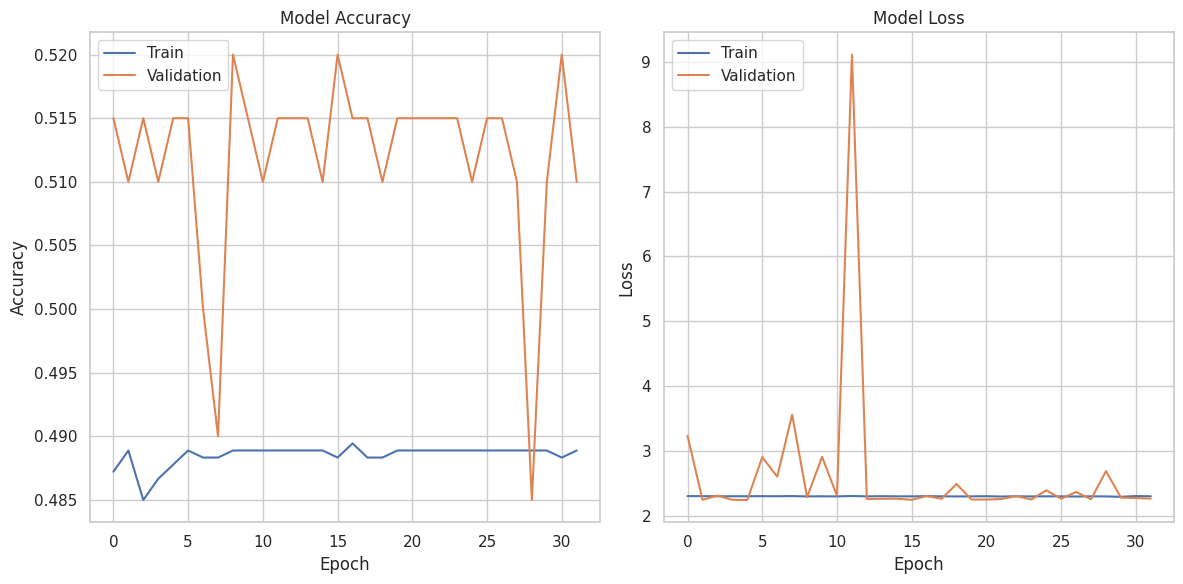

63/63 [==============================] - 1s 16ms/step
y_pred [[0.4362029  0.15278979 0.2326685  0.1783387 ]
 [0.4378218  0.15279418 0.23150302 0.17788106]
 [0.45356938 0.15917708 0.21075712 0.17649633]
 ...
 [0.5255119  0.18822981 0.17356376 0.11269444]
 [0.44835532 0.15599567 0.21888019 0.17676882]
 [0.46735594 0.18652163 0.23891541 0.10720705]]
Accuracy: 0.5005
Confusion Matrix: [[1001    0   11    0]
 [ 311    0    3    0]
 [ 334    0    0    0]
 [ 340    0    0    0]]
Epoch 1/32
57/57 [==============================] - ETA: 0s - loss: 2.3017 - sparse_categorical_accuracy: 0.4917

57/57 [==============================] - 6s 104ms/step - loss: 2.3017 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2905 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3053 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 97ms/step - loss: 2.3017 - sparse_categorical_accuracy: 0.4911 - val_loss: 2.3130 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/32
57/57 [==============================] - ETA: 0s - loss: 2.2984 - sparse_categorical_accuracy: 0.4917

57/57 [==============================] - 6s 103ms/step - loss: 2.2984 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2810 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3090 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 99ms/step - loss: 2.3043 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.3099 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3032 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 5s 96ms/step - loss: 2.3006 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2860 - val_sparse_categorical_accuracy: 0.4900
Epoch 6/32
57/57 [==============================] - ETA: 0s - loss: 2.2992 - sparse_categorical_accuracy: 0.4917

57/57 [==============================] - 6s 102ms/step - loss: 2.2992 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2872 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3024 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 5s 96ms/step - loss: 2.2994 - sparse_categorical_accuracy: 0.4906 - val_loss: 2.2997 - val_sparse_categorical_accuracy: 0.4900
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3050 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 6s 98ms/step - loss: 2.3019 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.3625 - val_sparse_categorical_accuracy: 0.4700
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3023 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 99ms/step - loss: 2.2988 - sparse_categorical_accuracy: 0.4911 - val_loss: 2.2747 - val_sparse_categorical_accuracy: 0.4900
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3042 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 6s 98ms/step - loss: 2.3007 - sparse_categorical_accuracy: 0.4917 - val_loss: 3.1784 - val_sparse_categorical_accuracy: 0.4600
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 2.3003 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 98ms/step - loss: 2.3003 - sparse_categorical_accuracy: 0.4911 - val_loss: 2.3669 - val_sparse_categorical_accuracy: 0.4550
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.2984 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 98ms/step - loss: 2.2968 - sparse_categorical_accuracy: 0.4911 - val_loss: 2.9292 - val_sparse_categorical_accuracy: 0.4300
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3061 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 98ms/step - loss: 2.3013 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.3369 - val_sparse_categorical_accuracy: 0.4700
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 2.3018 - sparse_categorical_accuracy: 0.4917

57/57 [==============================] - 6s 102ms/step - loss: 2.3018 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.4841 - val_sparse_categorical_accuracy: 0.4750
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3042 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 98ms/step - loss: 2.3018 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.3240 - val_sparse_categorical_accuracy: 0.4850
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3152 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 98ms/step - loss: 2.3109 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2841 - val_sparse_categorical_accuracy: 0.4900
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.3145 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 97ms/step - loss: 2.3108 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2874 - val_sparse_categorical_accuracy: 0.4900
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3115 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 5s 97ms/step - loss: 2.3084 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2781 - val_sparse_categorical_accuracy: 0.4900
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3084 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 103ms/step - loss: 2.3054 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.6904 - val_sparse_categorical_accuracy: 0.4700
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3109 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 99ms/step - loss: 2.3062 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.5943 - val_sparse_categorical_accuracy: 0.4750
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3077 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 97ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4911 - val_loss: 39.8622 - val_sparse_categorical_accuracy: 0.4050
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.3054 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 104ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.4917 - val_loss: 3.1989 - val_sparse_categorical_accuracy: 0.4350
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3073 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 98ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.2951 - val_sparse_categorical_accuracy: 0.4800
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3060 - sparse_categorical_accuracy: 0.4911

57/57 [==============================] - 6s 102ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.4911 - val_loss: 7.2633 - val_sparse_categorical_accuracy: 0.4400
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.3028 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 99ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.4928 - val_loss: 59.1245 - val_sparse_categorical_accuracy: 0.3800
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3062 - sparse_categorical_accuracy: 0.4883

57/57 [==============================] - 6s 97ms/step - loss: 2.3032 - sparse_categorical_accuracy: 0.4878 - val_loss: 2.3306 - val_sparse_categorical_accuracy: 0.4900
Epoch 27/32
57/57 [==============================] - ETA: 0s - loss: 2.3004 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 102ms/step - loss: 2.3004 - sparse_categorical_accuracy: 0.4922 - val_loss: 2.3706 - val_sparse_categorical_accuracy: 0.4650
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3040 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 98ms/step - loss: 2.2994 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.8209 - val_sparse_categorical_accuracy: 0.4600
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3031 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 5s 97ms/step - loss: 2.2980 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.5446 - val_sparse_categorical_accuracy: 0.4900
Epoch 30/32
57/57 [==============================] - ETA: 0s - loss: 2.3002 - sparse_categorical_accuracy: 0.4917

57/57 [==============================] - 6s 104ms/step - loss: 2.3002 - sparse_categorical_accuracy: 0.4917 - val_loss: 3.1767 - val_sparse_categorical_accuracy: 0.4650
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3046 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 97ms/step - loss: 2.3018 - sparse_categorical_accuracy: 0.4917 - val_loss: 2.3127 - val_sparse_categorical_accuracy: 0.4800
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3001 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 102ms/step - loss: 2.2979 - sparse_categorical_accuracy: 0.4917 - val_loss: 5.0987 - val_sparse_categorical_accuracy: 0.4400


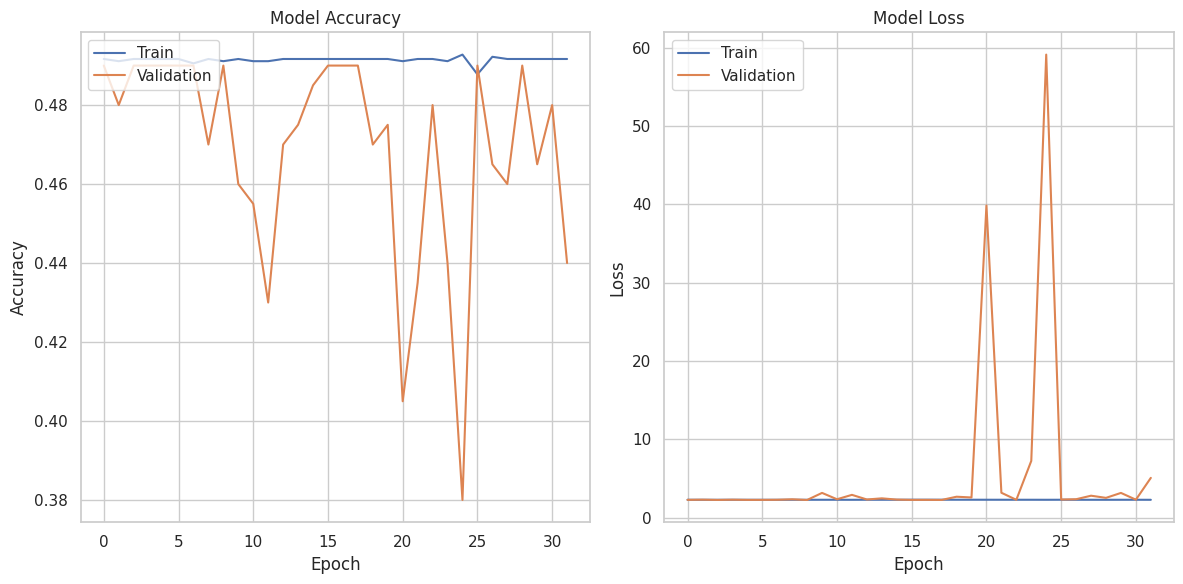

63/63 [==============================] - 1s 17ms/step
y_pred [[4.8489070e-01 1.7129822e-01 1.3581246e-01 2.0799859e-01]
 [5.8195621e-01 2.2612152e-01 9.3862355e-02 9.8059922e-02]
 [5.9237516e-01 1.5455247e-01 1.0837527e-01 1.4469711e-01]
 ...
 [6.2620118e-03 7.2364897e-02 9.2137307e-01 2.7644494e-23]
 [5.7476121e-01 1.6556376e-01 1.6336185e-01 9.6313141e-02]
 [3.2437677e-06 3.0249709e-03 9.9697173e-01 0.0000000e+00]]
Accuracy: 0.4615
Confusion Matrix: [[897   0 115   0]
 [276   0  38   0]
 [308   0  26   0]
 [317   0  23   0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.3052 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 99ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.7063 - val_sparse_categorical_accuracy: 0.4700
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3077 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 98ms/step - loss: 2.3045 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3322 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.3116 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 5s 97ms/step - loss: 2.3085 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.4212 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3047 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.3014 - sparse_categorical_accuracy: 0.4939 - val_loss: 28.7003 - val_sparse_categorical_accuracy: 0.3650
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3058 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 101ms/step - loss: 2.3022 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3198 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.3086 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 97ms/step - loss: 2.3039 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.4992 - val_sparse_categorical_accuracy: 0.4650
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3029 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 5s 96ms/step - loss: 2.3013 - sparse_categorical_accuracy: 0.4939 - val_loss: 24.0852 - val_sparse_categorical_accuracy: 0.4700
Epoch 8/32
57/57 [==============================] - ETA: 0s - loss: 2.3042 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 101ms/step - loss: 2.3042 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.2954 - val_sparse_categorical_accuracy: 0.4800
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3042 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 97ms/step - loss: 2.3003 - sparse_categorical_accuracy: 0.4939 - val_loss: 4.9128 - val_sparse_categorical_accuracy: 0.4750
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3068 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 98ms/step - loss: 2.3021 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3655 - val_sparse_categorical_accuracy: 0.4700
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.3052 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.3011 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.8738 - val_sparse_categorical_accuracy: 0.4700
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3009 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.2976 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.5486 - val_sparse_categorical_accuracy: 0.4700
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3033 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 100ms/step - loss: 2.3002 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.4622 - val_sparse_categorical_accuracy: 0.4700
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.3010 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 98ms/step - loss: 2.2984 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3756 - val_sparse_categorical_accuracy: 0.4700
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3043 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 97ms/step - loss: 2.3012 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.6310 - val_sparse_categorical_accuracy: 0.4350
Epoch 16/32
57/57 [==============================] - ETA: 0s - loss: 2.3011 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 104ms/step - loss: 2.3011 - sparse_categorical_accuracy: 0.4939 - val_loss: 4.1241 - val_sparse_categorical_accuracy: 0.4350
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.3008 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.2971 - sparse_categorical_accuracy: 0.4939 - val_loss: 13.6301 - val_sparse_categorical_accuracy: 0.4050
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3032 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 102ms/step - loss: 2.2996 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.8139 - val_sparse_categorical_accuracy: 0.4250
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3005 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 97ms/step - loss: 2.2981 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3276 - val_sparse_categorical_accuracy: 0.4600
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3042 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 97ms/step - loss: 2.3013 - sparse_categorical_accuracy: 0.4928 - val_loss: 7.5098 - val_sparse_categorical_accuracy: 0.4400
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3013 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 102ms/step - loss: 2.2993 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.4248 - val_sparse_categorical_accuracy: 0.4450
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.3020 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.5633 - val_sparse_categorical_accuracy: 0.4550
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3028 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.2986 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3160 - val_sparse_categorical_accuracy: 0.4700
Epoch 24/32
57/57 [==============================] - ETA: 0s - loss: 2.2970 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 99ms/step - loss: 2.2970 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3849 - val_sparse_categorical_accuracy: 0.4550
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.3000 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 5s 96ms/step - loss: 2.2980 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3926 - val_sparse_categorical_accuracy: 0.4600
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3019 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 99ms/step - loss: 2.2984 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.4400 - val_sparse_categorical_accuracy: 0.4350
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 2.3023 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 98ms/step - loss: 2.2992 - sparse_categorical_accuracy: 0.4939 - val_loss: 9.0884 - val_sparse_categorical_accuracy: 0.4350
Epoch 28/32
57/57 [==============================] - ETA: 0s - loss: 2.2994 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 100ms/step - loss: 2.2994 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.8751 - val_sparse_categorical_accuracy: 0.4350
Epoch 29/32
57/57 [==============================] - ETA: 0s - loss: 2.2975 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 105ms/step - loss: 2.2975 - sparse_categorical_accuracy: 0.4939 - val_loss: 3.1747 - val_sparse_categorical_accuracy: 0.4500
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.2996 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.2967 - sparse_categorical_accuracy: 0.4928 - val_loss: 11.4474 - val_sparse_categorical_accuracy: 0.4400
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3021 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.2981 - sparse_categorical_accuracy: 0.4939 - val_loss: 5.3656 - val_sparse_categorical_accuracy: 0.4750
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3050 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.3007 - sparse_categorical_accuracy: 0.4939 - val_loss: 2.3406 - val_sparse_categorical_accuracy: 0.4700


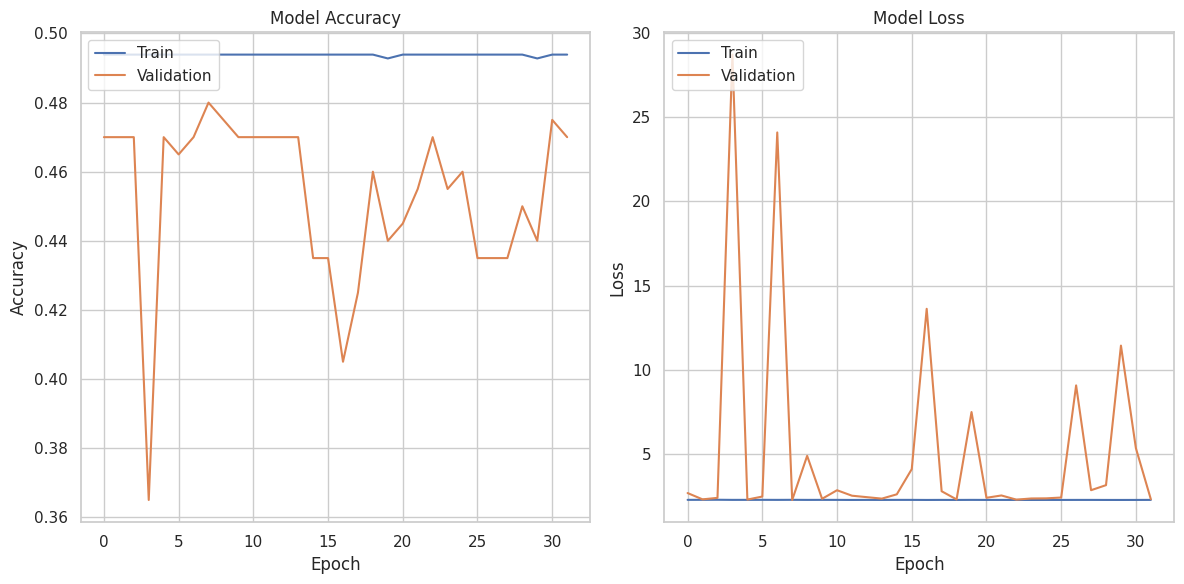

63/63 [==============================] - 1s 18ms/step
y_pred [[0.47896814 0.17701139 0.18897416 0.1550464 ]
 [0.49216568 0.18271446 0.19774209 0.12737776]
 [0.54006886 0.18004942 0.19977747 0.08010428]
 ...
 [0.58022636 0.18035339 0.20328109 0.03613923]
 [0.46849018 0.28809124 0.09513212 0.14828649]
 [0.58413845 0.1808021  0.20384172 0.03121769]]
Accuracy: 0.505
Confusion Matrix: [[1009    3    0    0]
 [ 313    1    0    0]
 [ 332    2    0    0]
 [ 340    0    0    0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.2972 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 99ms/step - loss: 2.2939 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3262 - val_sparse_categorical_accuracy: 0.4500
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.2992 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 98ms/step - loss: 2.2977 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3208 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.2996 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 104ms/step - loss: 2.2961 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3172 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.2990 - sparse_categorical_accuracy: 0.4972

57/57 [==============================] - 6s 97ms/step - loss: 2.2968 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3452 - val_sparse_categorical_accuracy: 0.4400
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.2989 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 100ms/step - loss: 2.2942 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3305 - val_sparse_categorical_accuracy: 0.4400
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.2992 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 100ms/step - loss: 2.2948 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.7088 - val_sparse_categorical_accuracy: 0.4050
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.2952 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 99ms/step - loss: 2.2924 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.4150 - val_sparse_categorical_accuracy: 0.4300
Epoch 8/32
57/57 [==============================] - ETA: 0s - loss: 2.2978 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 103ms/step - loss: 2.2978 - sparse_categorical_accuracy: 0.4967 - val_loss: 2.4541 - val_sparse_categorical_accuracy: 0.4450
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3012 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 6s 98ms/step - loss: 2.2971 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3261 - val_sparse_categorical_accuracy: 0.4450
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3004 - sparse_categorical_accuracy: 0.4950

57/57 [==============================] - 6s 99ms/step - loss: 2.2958 - sparse_categorical_accuracy: 0.4961 - val_loss: 60.6225 - val_sparse_categorical_accuracy: 0.3300
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.3068 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 106ms/step - loss: 2.3019 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.6087 - val_sparse_categorical_accuracy: 0.4300
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3026 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 99ms/step - loss: 2.2996 - sparse_categorical_accuracy: 0.4961 - val_loss: 5.7556 - val_sparse_categorical_accuracy: 0.4100
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3001 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 103ms/step - loss: 2.2965 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3363 - val_sparse_categorical_accuracy: 0.4400
Epoch 14/32
56/57 [============================>.] - ETA: 0s - loss: 2.2979 - sparse_categorical_accuracy: 0.4978

57/57 [==============================] - 6s 100ms/step - loss: 2.2961 - sparse_categorical_accuracy: 0.4961 - val_loss: 3.0681 - val_sparse_categorical_accuracy: 0.4100
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.2979 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 98ms/step - loss: 2.2955 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3264 - val_sparse_categorical_accuracy: 0.4450
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3000 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 6s 105ms/step - loss: 2.2957 - sparse_categorical_accuracy: 0.4961 - val_loss: 8.3115 - val_sparse_categorical_accuracy: 0.3900
Epoch 17/32
57/57 [==============================] - ETA: 0s - loss: 2.2967 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 101ms/step - loss: 2.2967 - sparse_categorical_accuracy: 0.4961 - val_loss: 3.8689 - val_sparse_categorical_accuracy: 0.4150
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3074 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 100ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4961 - val_loss: 3.6842 - val_sparse_categorical_accuracy: 0.3750
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3039 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 104ms/step - loss: 2.3007 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3223 - val_sparse_categorical_accuracy: 0.4500
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3008 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 99ms/step - loss: 2.2977 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.4638 - val_sparse_categorical_accuracy: 0.4500
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3014 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 99ms/step - loss: 2.2978 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3262 - val_sparse_categorical_accuracy: 0.4500
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.2997 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 100ms/step - loss: 2.2961 - sparse_categorical_accuracy: 0.4961 - val_loss: 4.6101 - val_sparse_categorical_accuracy: 0.4050
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3001 - sparse_categorical_accuracy: 0.4967

57/57 [==============================] - 6s 98ms/step - loss: 2.2969 - sparse_categorical_accuracy: 0.4961 - val_loss: 3.4392 - val_sparse_categorical_accuracy: 0.4500
Epoch 24/32
57/57 [==============================] - ETA: 0s - loss: 2.2953 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 104ms/step - loss: 2.2953 - sparse_categorical_accuracy: 0.4961 - val_loss: 3.2285 - val_sparse_categorical_accuracy: 0.4250
Epoch 25/32
56/57 [============================>.] - ETA: 0s - loss: 2.3061 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 100ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3232 - val_sparse_categorical_accuracy: 0.4500
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3039 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 6s 99ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.4961 - val_loss: 53.8893 - val_sparse_categorical_accuracy: 0.4250
Epoch 27/32
57/57 [==============================] - ETA: 0s - loss: 2.2979 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 104ms/step - loss: 2.2979 - sparse_categorical_accuracy: 0.4961 - val_loss: 51.1342 - val_sparse_categorical_accuracy: 0.3900
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3019 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 6s 100ms/step - loss: 2.2978 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3230 - val_sparse_categorical_accuracy: 0.4500
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3012 - sparse_categorical_accuracy: 0.4961

57/57 [==============================] - 6s 102ms/step - loss: 2.2975 - sparse_categorical_accuracy: 0.4961 - val_loss: 21.5984 - val_sparse_categorical_accuracy: 0.4500
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.3039 - sparse_categorical_accuracy: 0.4944

57/57 [==============================] - 6s 98ms/step - loss: 2.2985 - sparse_categorical_accuracy: 0.4961 - val_loss: 69.4954 - val_sparse_categorical_accuracy: 0.3950
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3024 - sparse_categorical_accuracy: 0.4955

57/57 [==============================] - 6s 98ms/step - loss: 2.2984 - sparse_categorical_accuracy: 0.4961 - val_loss: 2.3283 - val_sparse_categorical_accuracy: 0.4500
Epoch 32/32
57/57 [==============================] - ETA: 0s - loss: 2.2966 - sparse_categorical_accuracy: 0.4956

57/57 [==============================] - 6s 104ms/step - loss: 2.2966 - sparse_categorical_accuracy: 0.4956 - val_loss: 3.6322 - val_sparse_categorical_accuracy: 0.4150


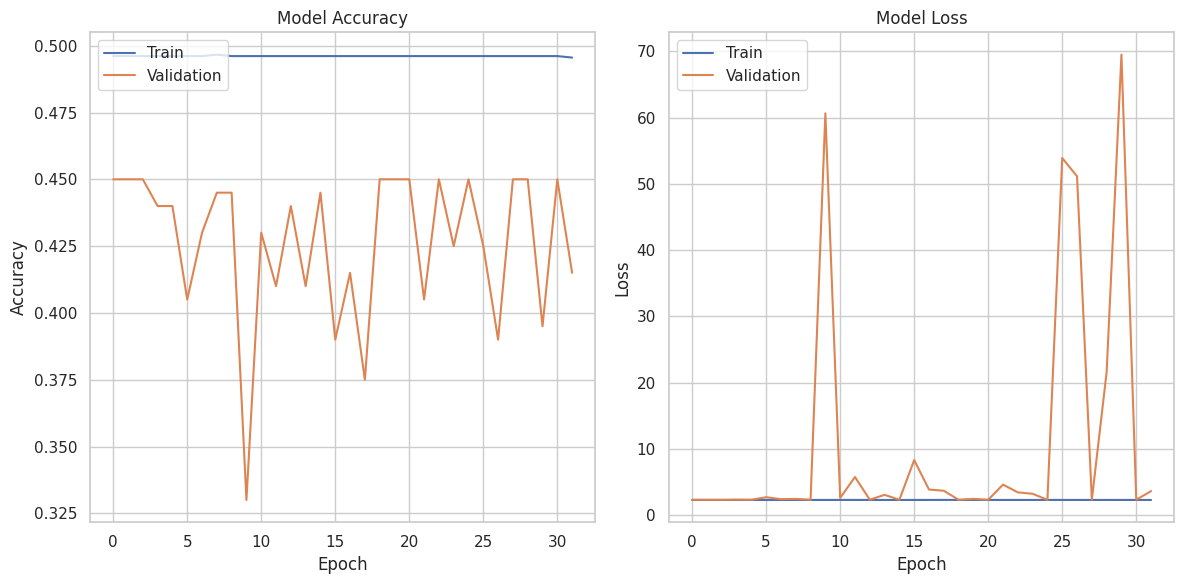

63/63 [==============================] - 1s 17ms/step
y_pred [[4.8967451e-01 1.6624278e-01 1.8961746e-01 1.5446530e-01]
 [5.3566957e-01 1.5721151e-01 1.7410606e-01 1.3301283e-01]
 [5.3279817e-01 1.5549211e-01 1.7614634e-01 1.3556333e-01]
 ...
 [3.0001499e-02 2.0694468e-02 9.4909149e-01 2.1249040e-04]
 [5.3054661e-01 1.5537748e-01 1.7703818e-01 1.3703772e-01]
 [3.2471899e-06 1.0534822e-05 9.9998617e-01 9.6123552e-12]]
Accuracy: 0.4685
Confusion Matrix: [[914   0  98   0]
 [281   0  33   0]
 [311   0  23   0]
 [322   0  18   0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.3078 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 105ms/step - loss: 2.3041 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2597 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/32
57/57 [==============================] - ETA: 0s - loss: 2.3055 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 103ms/step - loss: 2.3055 - sparse_categorical_accuracy: 0.4900 - val_loss: 3.5239 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/32
57/57 [==============================] - ETA: 0s - loss: 2.3044 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 103ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.5681 - val_sparse_categorical_accuracy: 0.4750
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3078 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 98ms/step - loss: 2.3042 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2726 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3079 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 98ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.3077 - val_sparse_categorical_accuracy: 0.5050
Epoch 6/32
57/57 [==============================] - ETA: 0s - loss: 2.3044 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 103ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4900 - val_loss: 5.3702 - val_sparse_categorical_accuracy: 0.4250
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3108 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 5s 96ms/step - loss: 2.3090 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.4644 - val_sparse_categorical_accuracy: 0.5100
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3071 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 99ms/step - loss: 2.3042 - sparse_categorical_accuracy: 0.4900 - val_loss: 3.1488 - val_sparse_categorical_accuracy: 0.4650
Epoch 9/32
56/57 [============================>.] - ETA: 0s - loss: 2.3091 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 100ms/step - loss: 2.3043 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2524 - val_sparse_categorical_accuracy: 0.5050
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3064 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 6s 97ms/step - loss: 2.3045 - sparse_categorical_accuracy: 0.4900 - val_loss: 5.5587 - val_sparse_categorical_accuracy: 0.4650
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.3083 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 97ms/step - loss: 2.3036 - sparse_categorical_accuracy: 0.4900 - val_loss: 3.0039 - val_sparse_categorical_accuracy: 0.4800
Epoch 12/32
56/57 [============================>.] - ETA: 0s - loss: 2.3075 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 98ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2607 - val_sparse_categorical_accuracy: 0.5050
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3055 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 98ms/step - loss: 2.3041 - sparse_categorical_accuracy: 0.4900 - val_loss: 47.0040 - val_sparse_categorical_accuracy: 0.3550
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 2.3040 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 102ms/step - loss: 2.3040 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.3133 - val_sparse_categorical_accuracy: 0.5050
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3057 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 98ms/step - loss: 2.3025 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2494 - val_sparse_categorical_accuracy: 0.5000
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3082 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 5s 97ms/step - loss: 2.3040 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2582 - val_sparse_categorical_accuracy: 0.5050
Epoch 17/32
57/57 [==============================] - ETA: 0s - loss: 2.3043 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 100ms/step - loss: 2.3043 - sparse_categorical_accuracy: 0.4900 - val_loss: 3.0309 - val_sparse_categorical_accuracy: 0.3250
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3093 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 97ms/step - loss: 2.3050 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2543 - val_sparse_categorical_accuracy: 0.5100
Epoch 19/32
57/57 [==============================] - ETA: 0s - loss: 2.3034 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 104ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4900 - val_loss: 28.0357 - val_sparse_categorical_accuracy: 0.4500
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3065 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 5s 96ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.9188 - val_sparse_categorical_accuracy: 0.4900
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3047 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 5s 96ms/step - loss: 2.3037 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2791 - val_sparse_categorical_accuracy: 0.5050
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.3064 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 100ms/step - loss: 2.3032 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2547 - val_sparse_categorical_accuracy: 0.5050
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3070 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 98ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2525 - val_sparse_categorical_accuracy: 0.5050
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3079 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 99ms/step - loss: 2.3031 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.4999 - val_sparse_categorical_accuracy: 0.4700
Epoch 25/32
57/57 [==============================] - ETA: 0s - loss: 2.3044 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 101ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.4900 - val_loss: 464.0305 - val_sparse_categorical_accuracy: 0.4800
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3213 - sparse_categorical_accuracy: 0.4888

57/57 [==============================] - 6s 98ms/step - loss: 2.3165 - sparse_categorical_accuracy: 0.4900 - val_loss: 22329.6152 - val_sparse_categorical_accuracy: 0.4600
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 2.3133 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 100ms/step - loss: 2.3096 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2570 - val_sparse_categorical_accuracy: 0.5050
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.3083 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 98ms/step - loss: 2.3055 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2600 - val_sparse_categorical_accuracy: 0.5050
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3095 - sparse_categorical_accuracy: 0.4894

57/57 [==============================] - 6s 97ms/step - loss: 2.3053 - sparse_categorical_accuracy: 0.4900 - val_loss: 31.3630 - val_sparse_categorical_accuracy: 0.4250
Epoch 30/32
57/57 [==============================] - ETA: 0s - loss: 2.3052 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 104ms/step - loss: 2.3052 - sparse_categorical_accuracy: 0.4900 - val_loss: 18210.1113 - val_sparse_categorical_accuracy: 0.3950
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3063 - sparse_categorical_accuracy: 0.4905

57/57 [==============================] - 6s 97ms/step - loss: 2.3033 - sparse_categorical_accuracy: 0.4900 - val_loss: 3.5123 - val_sparse_categorical_accuracy: 0.5050
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3067 - sparse_categorical_accuracy: 0.4900

57/57 [==============================] - 6s 97ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.4900 - val_loss: 2.2620 - val_sparse_categorical_accuracy: 0.5050


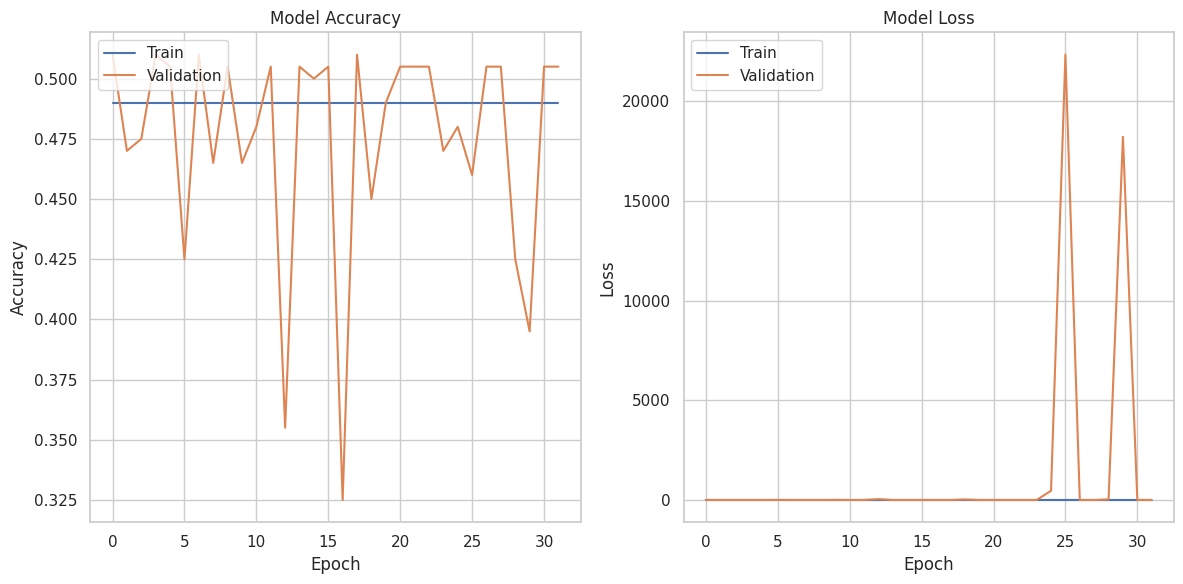

63/63 [==============================] - 1s 16ms/step
y_pred [[0.48758566 0.16941643 0.18795536 0.15504254]
 [0.48076755 0.16887946 0.19057529 0.15977773]
 [0.5079561  0.17739378 0.18451631 0.13013384]
 ...
 [0.49937302 0.17742497 0.18336973 0.1398323 ]
 [0.4843769  0.168636   0.18934837 0.15763876]
 [0.52770716 0.21258856 0.1909306  0.06877367]]
Accuracy: 0.5055
Confusion Matrix: [[1011    1    0    0]
 [ 314    0    0    0]
 [ 334    0    0    0]
 [ 340    0    0    0]]
Epoch 1/32
56/57 [============================>.] - ETA: 0s - loss: 2.3041 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 102ms/step - loss: 2.3004 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.5620 - val_sparse_categorical_accuracy: 0.4550
Epoch 2/32
56/57 [============================>.] - ETA: 0s - loss: 2.3035 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 98ms/step - loss: 2.2998 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.5618 - val_sparse_categorical_accuracy: 0.4650
Epoch 3/32
56/57 [============================>.] - ETA: 0s - loss: 2.3032 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 97ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4317 - val_sparse_categorical_accuracy: 0.4650
Epoch 4/32
56/57 [============================>.] - ETA: 0s - loss: 2.3009 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 100ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.5424 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/32
56/57 [============================>.] - ETA: 0s - loss: 2.3040 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.3011 - sparse_categorical_accuracy: 0.4928 - val_loss: 17.1003 - val_sparse_categorical_accuracy: 0.3700
Epoch 6/32
56/57 [============================>.] - ETA: 0s - loss: 2.3020 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 99ms/step - loss: 2.2989 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.7309 - val_sparse_categorical_accuracy: 0.4550
Epoch 7/32
56/57 [============================>.] - ETA: 0s - loss: 2.3043 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.3012 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4363 - val_sparse_categorical_accuracy: 0.4650
Epoch 8/32
56/57 [============================>.] - ETA: 0s - loss: 2.3032 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 6s 97ms/step - loss: 2.2983 - sparse_categorical_accuracy: 0.4928 - val_loss: 3.1723 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/32
57/57 [==============================] - ETA: 0s - loss: 2.3001 - sparse_categorical_accuracy: 0.4928

57/57 [==============================] - 6s 101ms/step - loss: 2.3001 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4748 - val_sparse_categorical_accuracy: 0.4650
Epoch 10/32
56/57 [============================>.] - ETA: 0s - loss: 2.3030 - sparse_categorical_accuracy: 0.4927

57/57 [==============================] - 6s 97ms/step - loss: 2.2998 - sparse_categorical_accuracy: 0.4928 - val_loss: 3.6778 - val_sparse_categorical_accuracy: 0.4350
Epoch 11/32
56/57 [============================>.] - ETA: 0s - loss: 2.3032 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 97ms/step - loss: 2.3001 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3664 - val_sparse_categorical_accuracy: 0.4650
Epoch 12/32
57/57 [==============================] - ETA: 0s - loss: 2.2974 - sparse_categorical_accuracy: 0.4928

57/57 [==============================] - 6s 103ms/step - loss: 2.2974 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4853 - val_sparse_categorical_accuracy: 0.4650
Epoch 13/32
56/57 [============================>.] - ETA: 0s - loss: 2.3018 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 5s 97ms/step - loss: 2.2996 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3021 - val_sparse_categorical_accuracy: 0.4600
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 2.2998 - sparse_categorical_accuracy: 0.4928

57/57 [==============================] - 6s 103ms/step - loss: 2.2998 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4053 - val_sparse_categorical_accuracy: 0.4650
Epoch 15/32
56/57 [============================>.] - ETA: 0s - loss: 2.3052 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 98ms/step - loss: 2.3012 - sparse_categorical_accuracy: 0.4928 - val_loss: 5.1918 - val_sparse_categorical_accuracy: 0.4350
Epoch 16/32
56/57 [============================>.] - ETA: 0s - loss: 2.3052 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 5s 97ms/step - loss: 2.3021 - sparse_categorical_accuracy: 0.4928 - val_loss: 286.5058 - val_sparse_categorical_accuracy: 0.4000
Epoch 17/32
56/57 [============================>.] - ETA: 0s - loss: 2.3028 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 97ms/step - loss: 2.3003 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2980 - val_sparse_categorical_accuracy: 0.4750
Epoch 18/32
56/57 [============================>.] - ETA: 0s - loss: 2.3051 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 97ms/step - loss: 2.3012 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2884 - val_sparse_categorical_accuracy: 0.4750
Epoch 19/32
56/57 [============================>.] - ETA: 0s - loss: 2.3023 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 97ms/step - loss: 2.3002 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3436 - val_sparse_categorical_accuracy: 0.4800
Epoch 20/32
56/57 [============================>.] - ETA: 0s - loss: 2.3008 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 103ms/step - loss: 2.2981 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2867 - val_sparse_categorical_accuracy: 0.4800
Epoch 21/32
56/57 [============================>.] - ETA: 0s - loss: 2.3005 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 97ms/step - loss: 2.2979 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2882 - val_sparse_categorical_accuracy: 0.4800
Epoch 22/32
56/57 [============================>.] - ETA: 0s - loss: 2.3031 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 103ms/step - loss: 2.2991 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3225 - val_sparse_categorical_accuracy: 0.4600
Epoch 23/32
56/57 [============================>.] - ETA: 0s - loss: 2.3012 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 99ms/step - loss: 2.2975 - sparse_categorical_accuracy: 0.4928 - val_loss: 3.2127 - val_sparse_categorical_accuracy: 0.4600
Epoch 24/32
56/57 [============================>.] - ETA: 0s - loss: 2.3020 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.2988 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4342 - val_sparse_categorical_accuracy: 0.4650
Epoch 25/32
57/57 [==============================] - ETA: 0s - loss: 2.2987 - sparse_categorical_accuracy: 0.4928

57/57 [==============================] - 6s 102ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.4928 - val_loss: 3.7719 - val_sparse_categorical_accuracy: 0.4000
Epoch 26/32
56/57 [============================>.] - ETA: 0s - loss: 2.3009 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 97ms/step - loss: 2.2985 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2923 - val_sparse_categorical_accuracy: 0.4650
Epoch 27/32
56/57 [============================>.] - ETA: 0s - loss: 2.3016 - sparse_categorical_accuracy: 0.4916

57/57 [==============================] - 6s 100ms/step - loss: 2.2968 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3098 - val_sparse_categorical_accuracy: 0.4650
Epoch 28/32
56/57 [============================>.] - ETA: 0s - loss: 2.2990 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 98ms/step - loss: 2.2959 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3833 - val_sparse_categorical_accuracy: 0.4650
Epoch 29/32
56/57 [============================>.] - ETA: 0s - loss: 2.3045 - sparse_categorical_accuracy: 0.4939

57/57 [==============================] - 6s 98ms/step - loss: 2.3016 - sparse_categorical_accuracy: 0.4933 - val_loss: 2.3645 - val_sparse_categorical_accuracy: 0.4800
Epoch 30/32
56/57 [============================>.] - ETA: 0s - loss: 2.3058 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 102ms/step - loss: 2.3016 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.4330 - val_sparse_categorical_accuracy: 0.4550
Epoch 31/32
56/57 [============================>.] - ETA: 0s - loss: 2.3031 - sparse_categorical_accuracy: 0.4933

57/57 [==============================] - 6s 100ms/step - loss: 2.3002 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.3994 - val_sparse_categorical_accuracy: 0.4500
Epoch 32/32
56/57 [============================>.] - ETA: 0s - loss: 2.3036 - sparse_categorical_accuracy: 0.4922

57/57 [==============================] - 6s 98ms/step - loss: 2.2994 - sparse_categorical_accuracy: 0.4928 - val_loss: 2.2912 - val_sparse_categorical_accuracy: 0.4800


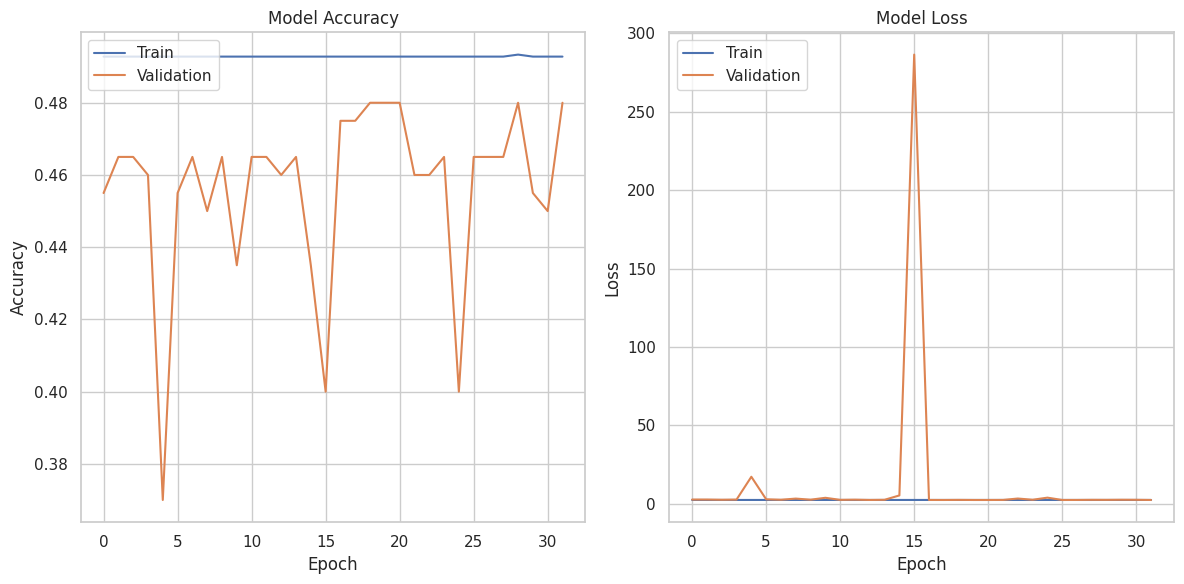

63/63 [==============================] - 1s 17ms/step
y_pred [[0.48204783 0.16832717 0.18518506 0.16443992]
 [0.48174852 0.16842267 0.1852613  0.16456756]
 [0.5557257  0.18044615 0.16093472 0.1028934 ]
 ...
 [0.54839325 0.17966473 0.16279973 0.10914225]
 [0.42713377 0.19402702 0.19766368 0.1811756 ]
 [0.54258204 0.19180259 0.17406368 0.09155173]]
Accuracy: 0.506
Confusion Matrix: [[1012    0    0    0]
 [ 314    0    0    0]
 [ 334    0    0    0]
 [ 340    0    0    0]]
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
Average Train Time: 3.2969276408354444 minutes
    Dataset_Size      Classifier  Mean_Accuracy  Std_A

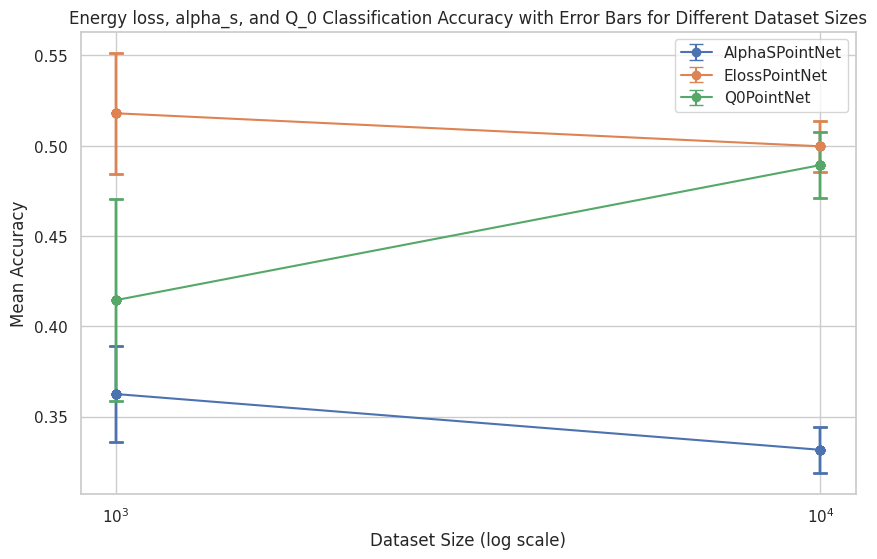

In [43]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
# n_epochs = 32
# k_folds = 10  # You can adjust the number of folds
n_epochs = 32
k_folds = 10  # You can adjust the number of folds

# defining dataset sizes and classifiers

# Sizes of datasets
# dataset_sizes = [1000]
# dataset_sizes = [10000]
# dataset_sizes = [100000]
# dataset_sizes = [1000000]
dataset_sizes = [1000, 10000]
# dataset_sizes = [1000, 10000,100000]
# dataset_sizes = [1000, 10000, 100000, 1000000]

print(simulation_directory_path)
# simulation_path=f'{simulation_directory_path}jetml_classification_{class_labels_str}'
simulation_path=f'{simulation_directory_path}jetml_classification'
train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)